## Table of contents:
* [The main purpose](#first-bullet)
* [Importing necessary modules](#second-bullet)
* [Exploring data](#third-bullet)
* [Features extraction](#featuresextraction)
* [Data visualization](#datavisualization)
* [Modeling](#modeling)
* [Conclusions](#conclusions)

## Questions:
* [Do customers in different regions spend more per transaction? Which regions spend the most/least?](#Q1)
* [Is there a relationship between the number of items purchased and amount spent?](#Q2)
* [Are there differences in the age of customers between regions?](#Q3)
* [If so, can we predict the age of a customer in a region based on other demographic data?](#Q4)
* [Is there any correlation between age of a customer and if the transaction was made online or in the store? Do any other factors predict if a customer will buy online or in our stores?](#Q5)
* [What about items? Are these even in the tree? Why or why not??](#Q6)

# The main purpose <a class="anchor" id="first-bullet"></a>

The main purpose of these analyzes is to understand and discover the behavior of customers in online and in-store shopping from different regions. One of the tasks set by the client was age prediction based on the region. Another dependence that played a large role for the customer and understanding the behavior of buyers was the prediction whether the customer will buy the product online or in the store based on the collected demographic data.

# Importing necessary modules <a class="anchor" id="second-bullet"></a>

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline


#Machine learning packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import svm
from sklearn import tree

import xgboost as xgb



# Exploring data <a class="anchor" id="third-bullet"></a>

In [31]:
data = pd.read_csv('Demographic_Data.csv')

#### The dataset contains 80,000 records and five columns:
#### a) in-store - the bool value determines whether the purchase was made online or in-store 
#### b) age - the age of the client (min 18 max 85)
#### c) items - number of items purchased (min 1 max 8)
#### d) amout - amount paid (min 5.0047 max 3000) 
#### e) region - a categorical, nominal variable specifies one of 4 regions (North, South, East, West) 

In [32]:
data = data.drop_duplicates()

### 21 duplicates were removed from the dataset. I decided to remove all duplicates, because the amount of duplicates were not high and indexes of transactions were different (not in sequence). Dataset do not contain missing values.

# Features extraction <a class="anchor" id="featuresextraction"></a>

Age rounded to nearest tenth

In [33]:
data['age_round'] = ((data['age']/10).round()*10).astype(int)

Amount spend per item

In [34]:
data['amount_per_item'] = data['amount']/data['items']

Counting people in each age group (every 10 years).

In [35]:
age_counts = data['age_round'].value_counts().sort_index()

Features discretization

In [67]:
data['age_levels']=pd.cut(data['age'],3,labels=['Young','Middle','Old'])
print('Mean of ages in groups:\n', data['age'].groupby(data['age_levels']).mean())
print('Minimum of ages in groups:\n', data['age'].groupby(data['age_levels']).min())
print('Maximum of ages in groups:\n', data['age'].groupby(data['age_levels']).max())
print('Count of ages in groups:\n', data['age'].groupby(data['age_levels']).count())
young_mean = round(data['age'].groupby(data['age_levels']).mean()['Young'])
middle_mean = round(data['age'].groupby(data['age_levels']).mean()['Middle'])
old_mean = round(data['age'].groupby(data['age_levels']).mean()['Old'])

data.loc[data['age_levels']=='Young', 'age_levels_mean'] = young_mean
data.loc[data['age_levels']=='Middle', 'age_levels_mean'] = middle_mean
data.loc[data['age_levels']=='Old', 'age_levels_mean'] = old_mean

Mean of ages in groups:
 age_levels
Young     30.696913
Middle    50.602622
Old       71.654716
Name: age, dtype: float64
Minimum of ages in groups:
 age_levels
Young     18
Middle    41
Old       63
Name: age, dtype: int64
Maximum of ages in groups:
 age_levels
Young     40
Middle    62
Old       85
Name: age, dtype: int64
Count of ages in groups:
 age_levels
Young     32885
Middle    34403
Old       12691
Name: age, dtype: int64


In [37]:
data['age_levels_5']=pd.cut(data['age'],5,labels=['Age1', 'Age2', 'Age3', 'Age4', 'Age5'])
data.loc[data['age_levels_5']=='Age1', 'age_levels_5_mean'] = round(data['age'].groupby(data['age_levels_5']).mean()['Age1'])
data.loc[data['age_levels_5']=='Age2', 'age_levels_5_mean'] = round(data['age'].groupby(data['age_levels_5']).mean()['Age2'])
data.loc[data['age_levels_5']=='Age3', 'age_levels_5_mean'] = round(data['age'].groupby(data['age_levels_5']).mean()['Age3'])
data.loc[data['age_levels_5']=='Age4', 'age_levels_5_mean'] = round(data['age'].groupby(data['age_levels_5']).mean()['Age4'])
data.loc[data['age_levels_5']=='Age5', 'age_levels_5_mean'] = round(data['age'].groupby(data['age_levels_5']).mean()['Age5'])

data['amount_levels_5']=pd.cut(data['amount'],5,labels=['Amount1', 'Amount2', 'Amount3', 'Amount4', 'Amount5'])
data.loc[data['amount_levels_5']=='Amount1', 'amount_levels_5_mean'] = round(data['amount'].groupby(data['amount_levels_5']).mean()['Amount1'])
data.loc[data['amount_levels_5']=='Amount2', 'amount_levels_5_mean'] = round(data['amount'].groupby(data['amount_levels_5']).mean()['Amount2'])
data.loc[data['amount_levels_5']=='Amount3', 'amount_levels_5_mean'] = round(data['amount'].groupby(data['amount_levels_5']).mean()['Amount3'])
data.loc[data['amount_levels_5']=='Amount4', 'amount_levels_5_mean'] = round(data['amount'].groupby(data['amount_levels_5']).mean()['Amount4'])
data.loc[data['amount_levels_5']=='Amount5', 'amount_levels_5_mean'] = round(data['amount'].groupby(data['amount_levels_5']).mean()['Amount5'])

data['amount_normalized']=(data['amount']-data['amount'].mean())/data['amount'].std()

data1 = pd.get_dummies(data['region'], prefix='Region', drop_first=True)
data = pd.concat([data, data1], axis=1)

# Data visualization  <a class="anchor" id="datavisualization"></a>

## Simple visualization of data <a class="anchor" id="fifth-a-bullet"></a>

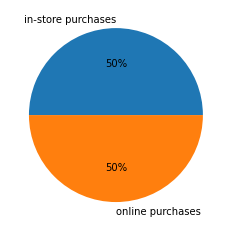

In [38]:
labels = ["in-store purchases", "online purchases"]
plt.pie([data[data['in-store']==1]['in-store'].count(), data[data['in-store']==0]['in-store'].count()], labels=labels, autopct='%1.0f%%')
plt.show()

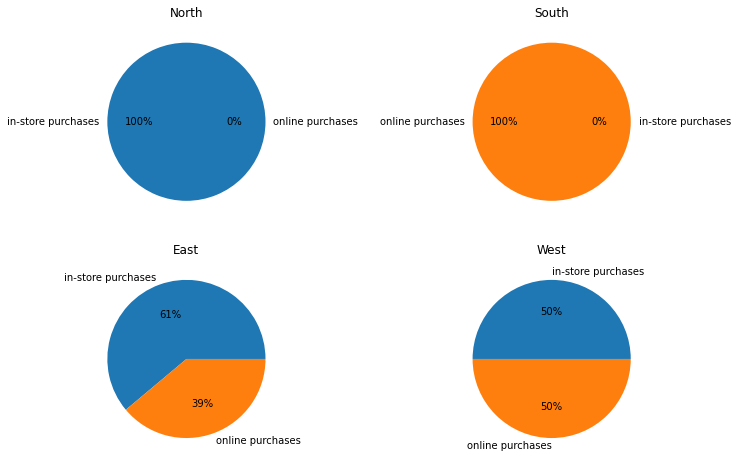

In [39]:
labels = ["in-store purchases", "online purchases"]
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.pie([data[(data['in-store']==1)&(data['region']==1)]['in-store'].count(), data[(data['in-store']==0)&(data['region']==1)]['in-store'].count()], labels=labels, autopct='%1.0f%%')
plt.title("North")
plt.subplot(2, 2, 2)
plt.pie([data[(data['in-store']==1)&(data['region']==2)]['in-store'].count(), data[(data['in-store']==0)&(data['region']==2)]['in-store'].count()], labels=labels, autopct='%1.0f%%')
plt.title("South")
plt.subplot(2, 2, 3)
plt.pie([data[(data['in-store']==1)&(data['region']==3)]['in-store'].count(), data[(data['in-store']==0)&(data['region']==3)]['in-store'].count()], labels=labels, autopct='%1.0f%%')
plt.title("East")
plt.subplot(2, 2, 4)
plt.pie([data[(data['in-store']==1)&(data['region']==4)]['in-store'].count(), data[(data['in-store']==0)&(data['region']==4)]['in-store'].count()], labels=labels, autopct='%1.0f%%')
plt.title("West")
plt.show()

### North customers buy only in-store, South customers buy only online. More than 60% of East customers buy instore. Half of West customers buy online.

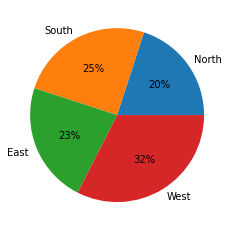

In [40]:
labels = ["North", "South", "East", "West"]

plt.pie([data[data['region']==1]['region'].count(), data[data['region']==2]['region'].count(), data[data['region']==3]['region'].count(), data[data['region']==4]['region'].count()], labels=labels, autopct='%1.0f%%')
plt.show()

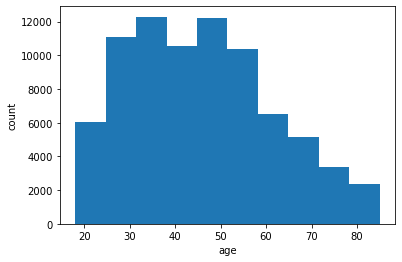

In [41]:
plt.hist(data['age'])
plt.xlabel('age')
plt.ylabel('count')
plt.show()

### Age data histogram is Positively (Right) Skewed. 

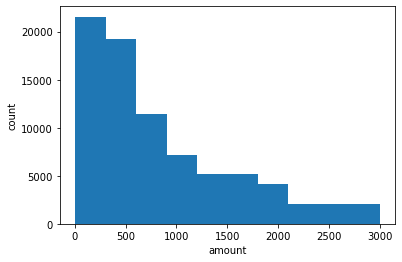

In [42]:
plt.hist(data['amount'])
plt.xlabel('amount')
plt.ylabel('count')
plt.show()

### Most often, less than 750 were spend when shopping.

# Do customers in different regions spend more per transaction? Which regions spend the most/least? <a class="anchor" id="Q1"></a>

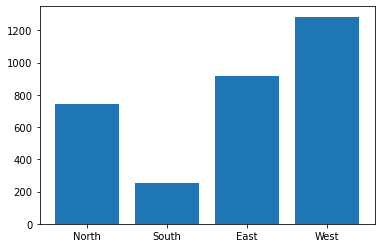

In [43]:
labels = ["North", "South", "East", "West"]
plt.bar(labels,data['amount'].groupby(data['region']).sum()/data['region'].groupby(data['region']).count())
plt.show()

### The bar plot shows that customers from West spend the most per transaction and customers from South spend the least per transaction

# Is there a relationship between the number of items purchased and amount spent?  <a class="anchor" id="Q2"></a>

In [44]:
data.corr('pearson')

in-store       age     items    amount    region  \
in-store              1.000000 -0.178180 -0.003897 -0.085573 -0.133171   
age                  -0.178180  1.000000  0.000657 -0.282033 -0.235370   
items                -0.003897  0.000657  1.000000  0.000384 -0.001904   
amount               -0.085573 -0.282033  0.000384  1.000000  0.403486   
region               -0.133171 -0.235370 -0.001904  0.403486  1.000000   
age_round            -0.180490  0.983693  0.000210 -0.276769 -0.231827   
amount_per_item      -0.054597 -0.187250 -0.469112  0.666868  0.269473   
age_levels_5_mean    -0.177309  0.970109  0.000801 -0.267094 -0.222032   
amount_levels_5_mean -0.093203 -0.273884  0.000434  0.974794  0.393620   
amount_normalized    -0.085573 -0.282033  0.000384  1.000000  0.403486   
Region_2             -0.577343  0.398625  0.002149 -0.467248 -0.345855   
Region_3              0.119691 -0.003826 -0.002911  0.061376  0.155499   
Region_4             -0.000009 -0.309304 -0.000458  0.431044  0.815993   

                      age_round  amount_per_item  age_levels_5_mean  \
in-store              -0.180490        -0.054597          -0.177309   
age                    0.983693        -0.187250           0.970109   
items                  0.000210        -0.469112           0.000801   
amount                -0.276769         0.666868          -0.267094   
region                -0.231827         0.269473          -0.222032   
age_round              1.000000        -0.183685           0.952719   
amount_per_item       -0.183685         1.000000          -0.178386   
age_levels_5_mean      0.952719        -0.178386           1.000000   
amount_levels_5_mean  -0.268681         0.649674          -0.259223   
amount_normalized     -0.276769         0.666868          -0.267094   
Region_2               0.393874        -0.311520           0.383516   
Region_3              -0.001191         0.040389          -0.004165   
Region_4              -0.306566         0.288070          -0.293751   

                      amount_levels_5_mean  amount_normalized  Region_2  \
in-store                         -0.093203          -0.085573 -0.577343   
age                              -0.273884          -0.282033  0.398625   
items                             0.000434           0.000384  0.002149   
amount                            0.974794           1.000000 -0.467248   
region                            0.393620           0.403486 -0.345855   
age_round                        -0.268681          -0.276769  0.393874   
amount_per_item                   0.649674           0.666868 -0.311520   
age_levels_5_mean                -0.259223          -0.267094  0.383516   
amount_levels_5_mean              1.000000           0.974794 -0.446413   
amount_normalized                 0.974794           1.000000 -0.467248   
Region_2                         -0.446413          -0.467248  1.000000   
Region_3                          0.055100           0.061376 -0.311130   
Region_4                          0.420443           0.431044 -0.400548   

                      Region_3  Region_4  
in-store              0.119691 -0.000009  
age                  -0.003826 -0.309304  
items                -0.002911 -0.000458  
amount                0.061376  0.431044  
region                0.155499  0.815993  
age_round            -0.001191 -0.306566  
amount_per_item       0.040389  0.288070  
age_levels_5_mean    -0.004165 -0.293751  
amount_levels_5_mean  0.055100  0.420443  
amount_normalized     0.061376  0.431044  
Region_2             -0.311130 -0.400548  
Region_3              1.000000 -0.373886  
Region_4             -0.373886  1.000000

### There are no Pearson correlation between items and amount, but there are observed correlation (not very strong) between age - in-store, region - items, region - age. There are no Spearman correlation between items and amount, but there are observed correlation (not very strong) between age - in-store, region - items, region - age.

## Checking dependency between amount and items purchased online and in-store

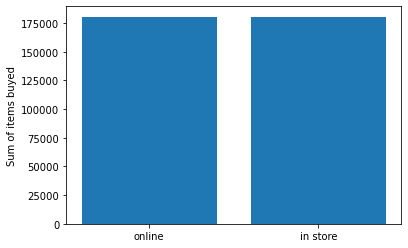

In [45]:
plt.bar(['online', 'in store'],data['items'].groupby(data['in-store']).sum())
plt.ylabel('Sum of items buyed')
plt.show()

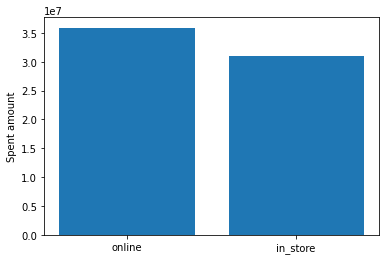

In [46]:
plt.bar(['online', 'in_store'],data['amount'].groupby(data['in-store']).sum())
plt.ylabel('Spent amount')
plt.show()

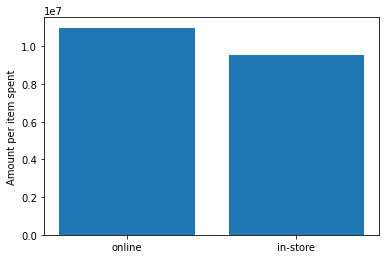

In [47]:
plt.bar(['online', 'in-store'],data['amount_per_item'].groupby(data['in-store']).sum())
plt.ylabel('Amount per item spent')
plt.show()

### Total number of items purchased online is same as total number of items purchased online, but customers spend more money during online shoping, because they choose more expensive products than in in-store shopping.

## Checking dependency between age and items, amount and amount per item

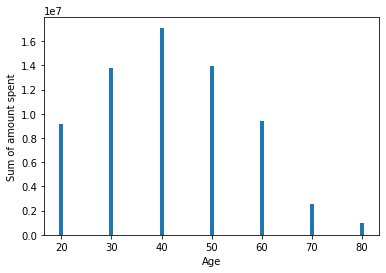

In [48]:
plt.bar(data['amount'].groupby(data['age_round']).sum().index, data['amount'].groupby(data['age_round']).sum().values)
plt.xlabel('Age')
plt.ylabel('Sum of amount spent')
plt.show()

### The bar plots shows that distribution beetween three selected dependencies (sum of amount spent, sum of item bought, sum of amount per item) does not change. Due to the unequal size of age groups, further analyzes are needed, especially taking into account the value per person.

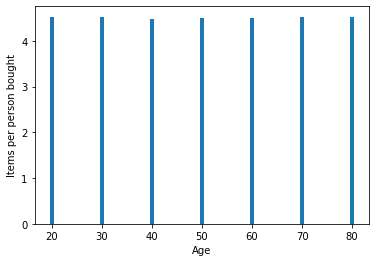

In [49]:
plt.bar(data['items'].groupby(data['age_round']).sum().index, data['items'].groupby(data['age_round']).sum().values/age_counts.values)
plt.xlabel('Age')
plt.ylabel('Items per person bought')
plt.show()

### In each age group, customers buy on average the same number of products per person.

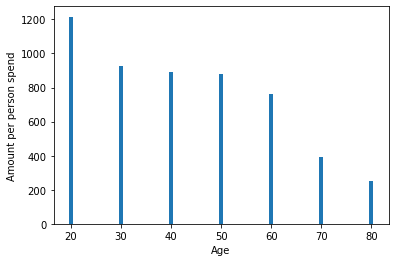

In [50]:
plt.bar(data['amount'].groupby(data['age_round']).sum().index, data['amount'].groupby(data['age_round']).sum().values/age_counts.values)
plt.xlabel('Age')
plt.ylabel('Amount per person spend')
plt.show()

### The bar plot shows that younger people spend in average more money

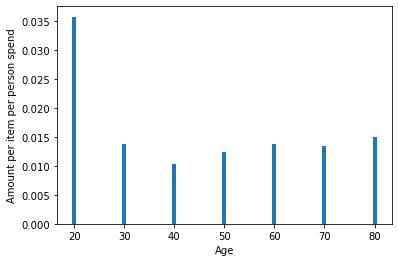

In [51]:
plt.bar(data['amount'].groupby(data['age_round']).sum().index, data['amount'].groupby(data['age_round']).sum().values/data['items'].groupby(data['age_round']).sum().values/age_counts.values)
plt.xlabel('Age')
plt.ylabel('Amount per item per person spend')
plt.show()

### The bar plot shows that younger people spend in average more money per item.

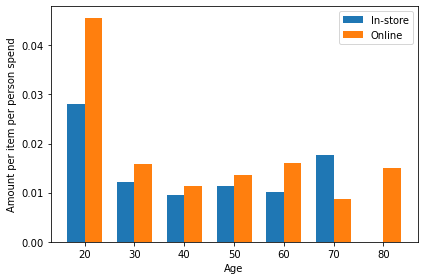

In [52]:
instore = data['amount'][data['in-store']==True].groupby(data['age_round']).sum().index, data['amount'][data['in-store']==True].groupby(data['age_round']).sum().values/data['items'][data['in-store']==True].groupby(data['age_round']).sum().values/age_counts.values[:-1]
online = data['amount'][data['in-store']==False].groupby(data['age_round']).sum().index, data['amount'][data['in-store']==False].groupby(data['age_round']).sum().values/data['items'][data['in-store']==False].groupby(data['age_round']).sum().values/age_counts.values
labels = age_counts.index
x_instore = np.arange(len(labels[:-1]))
x_online = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x_instore - width/2, instore[1], width, label='In-store')
rects2 = ax.bar(x_online + width/2, online[1], width, label='Online')

ax.set_ylabel('Amount per item per person spend')
ax.set_xlabel('Age')
ax.set_xticks(x_online)
ax.set_xticklabels(labels.astype(int))
ax.legend()

fig.tight_layout()

plt.show()

### Presented graph shows that:
### a) People older than 80 years old do not buy in-store
### b) Only people in their seventies bought more expensive products in-store than online
### c) People from 30-60 years old spend more less the same in-store and online per one product
### d) Youngest people spend more per item online than in-store

## Comparision of amount spend in-store and onlne by East and West customers (North and South customers are skipped because they choose only one method of buying)

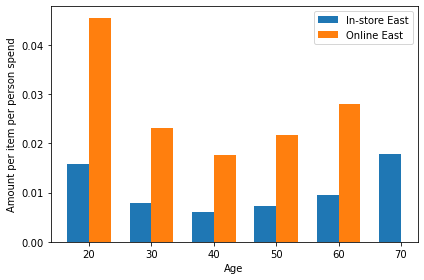

In [53]:
instore_reg3 = data['amount'][(data['in-store']==True)&(data['region']==3)].groupby(data['age_round']).sum().index, data['amount'][(data['in-store']==True)&(data['region']==3)].groupby(data['age_round']).sum().values/data['items'][(data['in-store']==True)&(data['region']==3)].groupby(data['age_round']).sum().values/age_counts.values[:-1]
online_reg3 = data['amount'][(data['in-store']==False)&(data['region']==3)].groupby(data['age_round']).sum().index, data['amount'][(data['in-store']==False)&(data['region']==3)].groupby(data['age_round']).sum().values/data['items'][(data['in-store']==False)&(data['region']==3)].groupby(data['age_round']).sum().values/age_counts.values[:-2]
labels = age_counts.index
x_instore = np.arange(len(labels[:-1]))
x_online = np.arange(len(labels[:-2]))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x_instore - width/2, instore_reg3[1], width, label='In-store East')
rects2 = ax.bar(x_online + width/2, online_reg3[1], width, label='Online East')

ax.set_ylabel('Amount per item per person spend')
ax.set_xlabel('Age')
ax.set_xticks(x_instore)
ax.set_xticklabels(labels[:-1].astype(int))
ax.legend()

fig.tight_layout()

plt.show()

### People from East spend in average more amount per item online besides 70 yo people which do not buy online

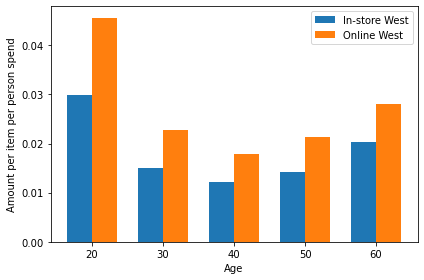

In [54]:
instore_reg3 = data['amount'][(data['in-store']==True)&(data['region']==4)].groupby(data['age_round']).sum().index, data['amount'][(data['in-store']==True)&(data['region']==4)].groupby(data['age_round']).sum().values/data['items'][(data['in-store']==True)&(data['region']==4)].groupby(data['age_round']).sum().values/age_counts.values[:-2]
online_reg3 = data['amount'][(data['in-store']==False)&(data['region']==4)].groupby(data['age_round']).sum().index, data['amount'][(data['in-store']==False)&(data['region']==4)].groupby(data['age_round']).sum().values/data['items'][(data['in-store']==False)&(data['region']==4)].groupby(data['age_round']).sum().values/age_counts.values[:-2]
labels = age_counts.index[:-2]
x_instore = np.arange(len(labels))
x_online = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x_instore - width/2, instore_reg3[1], width, label='In-store West')
rects2 = ax.bar(x_online + width/2, online_reg3[1], width, label='Online West')

ax.set_ylabel('Amount per item per person spend')
ax.set_xlabel('Age')
ax.set_xticks(x_instore)
ax.set_xticklabels(labels.astype(int))
ax.legend()

fig.tight_layout()

plt.show()

### People from West spend in average more amount per item online.

## Comparision of customers age in different regions

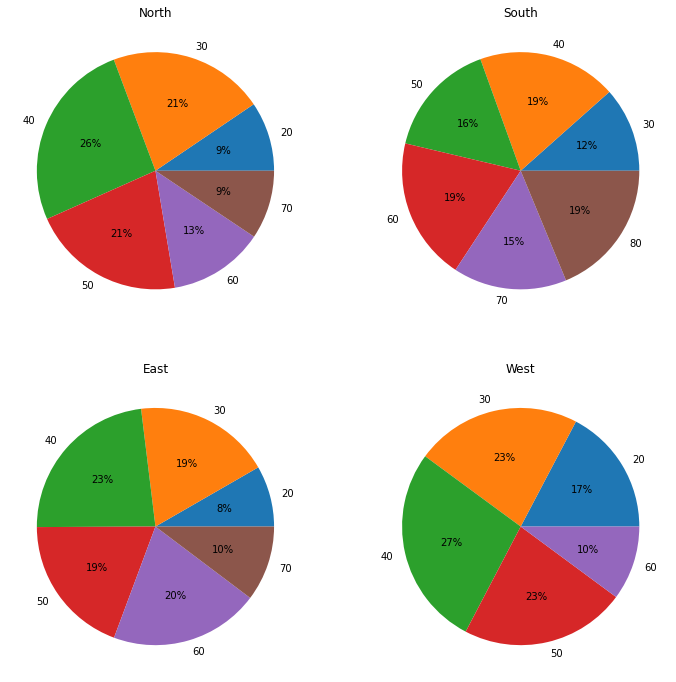

In [55]:
age_counts_north = data['age_round'][data['region']==1].value_counts().sort_index()
age_counts_south = data['age_round'][data['region']==2].value_counts().sort_index()
age_counts_east = data['age_round'][data['region']==3].value_counts().sort_index()
age_counts_west = data['age_round'][data['region']==4].value_counts().sort_index()


plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.pie(np.array(age_counts_north.values), labels=age_counts_north.index, autopct='%1.0f%%')
plt.title('North')
plt.subplot(2,2,2)
plt.pie(np.array(age_counts_south.values), labels=age_counts_south.index, autopct='%1.0f%%')
plt.title('South')
plt.subplot(2,2,3)
plt.pie(np.array(age_counts_east.values), labels=age_counts_east.index, autopct='%1.0f%%')
plt.title('East')
plt.subplot(2,2,4)
plt.pie(np.array(age_counts_west.values), labels=age_counts_west.index, autopct='%1.0f%%')
plt.title('West')
plt.show()

### There are no visible outliers. Not all regions have the same age groups.

# Are there differences in the age of customers between regions? <a class="anchor" id="Q3"></a>

### Analyzing figure above we can see that only in South there are people above 80 yo. Apart from that any differences are observed.

# Modeling - Classification <a class="anchor" id="Modeling"></a>

### I will test a lot of different models so I decided to create function to fit, predict and plot results

In [56]:
def fit_predict_plot(model, X_train, X_test, y_train, y_test, xticklabels, yticklabels):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy:', round(accuracy_score(y_test, y_pred)*100), '%')
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm/np.sum(cm), annot=True, annot_kws={"size": 12}, fmt='.1%', cbar=False, xticklabels=xticklabels, yticklabels=yticklabels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [57]:
def fit_predict_plot_validation(model, X_train, X_test, y_train, y_test, xticklabels, yticklabels):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = cross_val_score(model, X=X_train, y=y_train, cv=10, n_jobs=1)
    print('Cross Validation accuracy scores: %s' % scores)
    print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
    print('Accuracy:', round(accuracy_score(y_test, y_pred)*100), '%')
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm/np.sum(cm), annot=True, annot_kws={"size": 12}, fmt='.1%', cbar=False, xticklabels=xticklabels, yticklabels=yticklabels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [59]:
def fit_predict_plot_GS(model, X_train, X_test, y_train, y_test, xticklabels, yticklabels, params):
    clf = GridSearchCV(model, params, cv=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Accuracy:', round(accuracy_score(y_test, y_pred)*100), '%')
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm/np.sum(cm), annot=True, annot_kws={"size": 12}, fmt='.1%', cbar=False, xticklabels=xticklabels, yticklabels=yticklabels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [60]:
X = data[['region']]
y = data['age_round']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
age_labels = ['20', '30', '40', '50', '60', '70', '80']

## Customer age prediction - 7 bins

### Decision Tree Classifier

Accuracy: 25 %
              precision    recall  f1-score   support

          20       0.00      0.00      0.00      1896
          30       0.00      0.00      0.00      3694
          40       0.26      0.81      0.40      4873
          50       0.00      0.00      0.00      3924
          60       0.19      0.32      0.24      3006
          70       0.00      0.00      0.00      1664
          80       0.00      0.00      0.00       938

    accuracy                           0.25     19995
   macro avg       0.06      0.16      0.09     19995
weighted avg       0.09      0.25      0.13     19995



C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


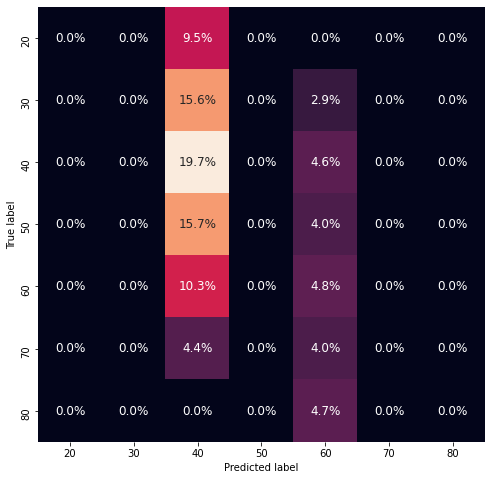

In [61]:
model = DecisionTreeClassifier()
fit_predict_plot(model, X_train, X_test, y_train, y_test, age_labels, age_labels)

## Customer age prediction - 3 bins

In [62]:
X = data[['region']]
y = data['age_levels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
age_labels = ['Young','Middle','Old']

Accuracy: 47 %
              precision    recall  f1-score   support

      Middle       0.46      0.24      0.32      8592
         Old       0.40      0.63      0.49      3208
       Young       0.51      0.65      0.57      8195

    accuracy                           0.47     19995
   macro avg       0.46      0.51      0.46     19995
weighted avg       0.47      0.47      0.45     19995



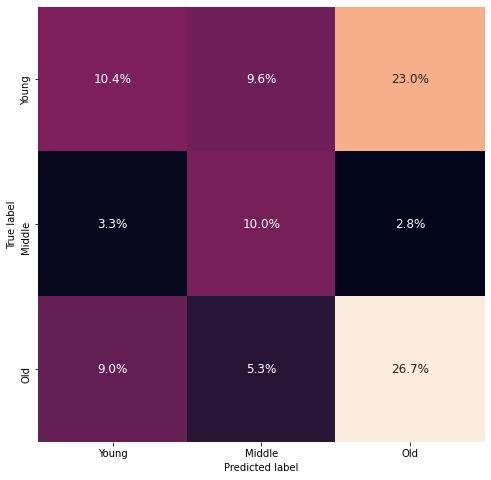

In [63]:
model = DecisionTreeClassifier()
fit_predict_plot(model, X_train, X_test, y_train, y_test, age_labels, age_labels)

### Models (Decision Tree Classifier and XGBoost Classifier) obtained bigger accuracy using less classes, but it is not sufficient to predict age using only region. An apparent increase in accuracy is expected as the number of classes is reduced. For 7 classes and random classifier, the accuracy is ~14%, while for 3 classes it increases to ~33%.

# If so, can we predict the age of a customer in a region based on other demographic data? <a class="anchor" id="Q4"></a>

### There is no clear correlation between the region and the age of the consumer. Due to this fact I decided to check if adding other data can increase performance of the model.

In [64]:
X = data[['region', 'in-store', 'amount', 'items']]
y = data['age_levels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
age_labels = ['Young','Middle','Old']

Accuracy: 43 %
              precision    recall  f1-score   support

      Middle       0.44      0.44      0.44      8592
         Old       0.33      0.33      0.33      3208
       Young       0.46      0.45      0.46      8195

    accuracy                           0.43     19995
   macro avg       0.41      0.41      0.41     19995
weighted avg       0.43      0.43      0.43     19995



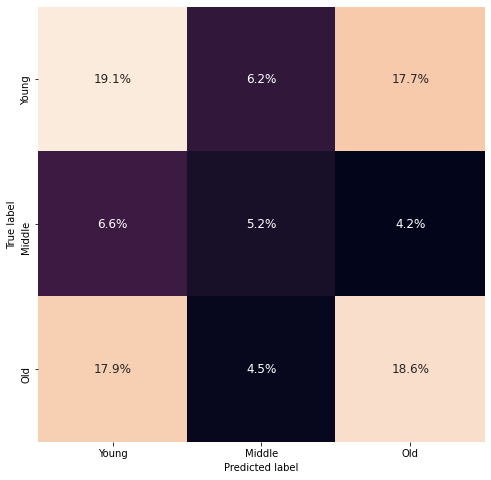

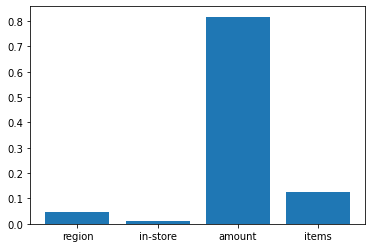

In [65]:
model = DecisionTreeClassifier()
fit_predict_plot(model, X_train, X_test, y_train, y_test, age_labels, age_labels)
plt.bar(['region', 'in-store', 'amount', 'items'],model.feature_importances_)
plt.show()

C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:54:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 47 %
              precision    recall  f1-score   support

      Middle       0.43      0.46      0.45      8592
         Old       0.39      0.33      0.36      3208
       Young       0.54      0.54      0.54      8195

    accuracy                           0.47     19995
   macro avg       0.46      0.44      0.45     19995
weighted avg       0.47      0.47      0.47     19995



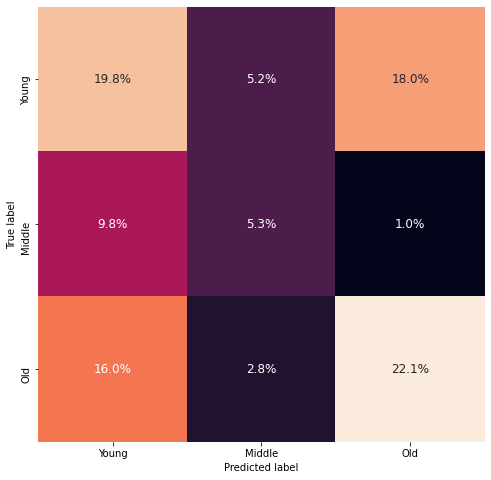

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

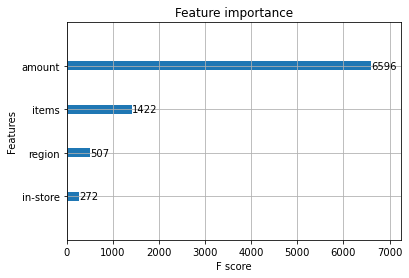

In [66]:
model = xgb.XGBClassifier()
fit_predict_plot(model, X_train, X_test, y_train, y_test, age_labels, age_labels)
xgb.plot_importance(model)

### In order to check the validity of features for the models, two charts were prepared. Both models showed that the total amount of purchases is important to predict the age, then to a much lesser extent the number of items purchased, the region and whether the purchase was made in-store or online. Analyzing the presented data, I came to the conclusion that it is not possible to predict the consumer's age on the basis of demographic data.

# Is there any correlation between age of a customer and if the transaction was made online or in the store? Do any other factors predict if a customer will buy online or in our stores? <a class="anchor" id="Q5"></a>

## Trying to predict if the transaction was made online or in the store basic on the age of the customer aggregated to seven levels 

In [72]:
X = data[['age_round']]
y = data['in-store']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
labels = ['in-store', 'online']

Accuracy: 59 %
              precision    recall  f1-score   support

           0       0.71      0.28      0.41      9870
           1       0.56      0.89      0.69     10125

    accuracy                           0.59     19995
   macro avg       0.63      0.59      0.55     19995
weighted avg       0.63      0.59      0.55     19995



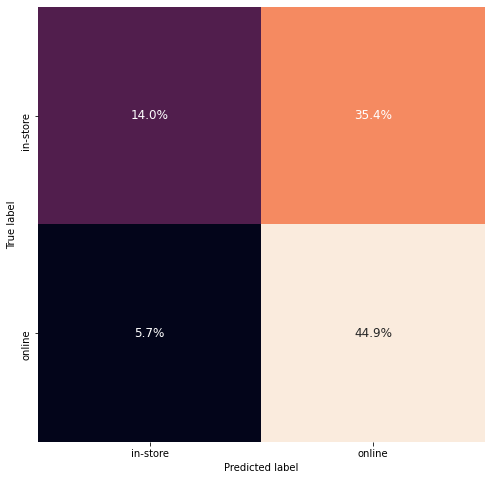

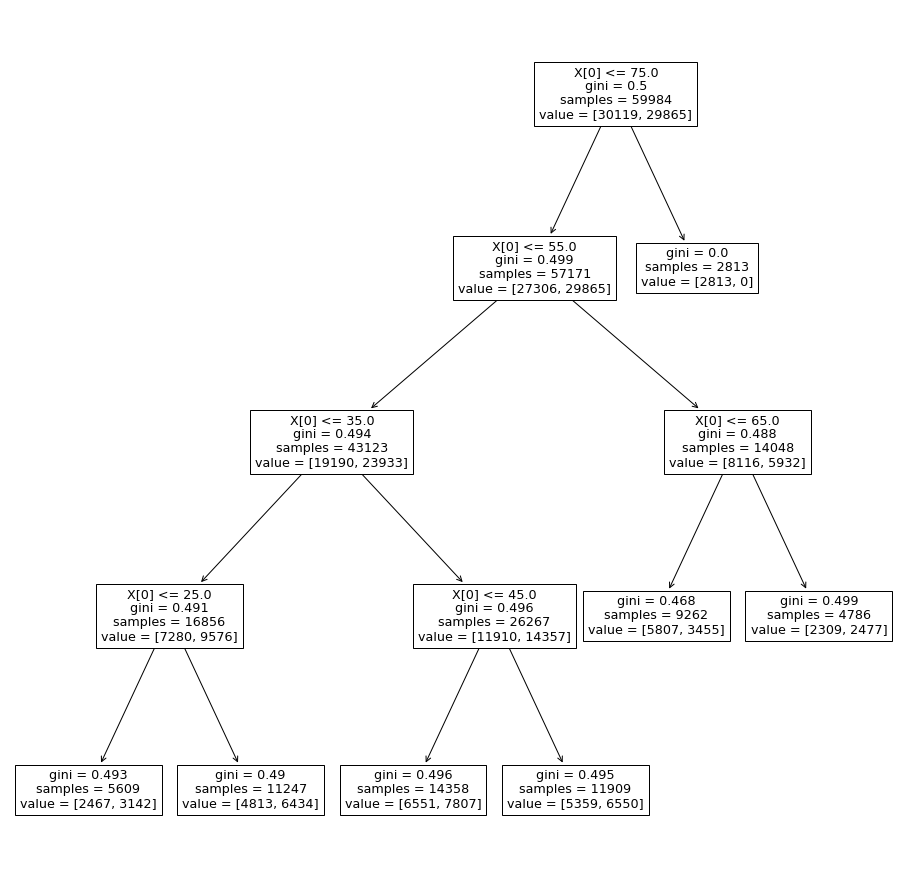

In [73]:
model = DecisionTreeClassifier(max_depth=4)
fit_predict_plot(model, X_train, X_test, y_train, y_test, labels, labels)
plt.figure(figsize=(16,16))
tree.plot_tree(model)
plt.show()

### The model obtained accuracy 59%. When analyzing the decision tree, it can be noticed that the model correctly recognized that people over 75 years old do not make in-store purchases. This relationship has also been shown previously in the EDA.

C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:11:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 59 %
              precision    recall  f1-score   support

           0       0.71      0.28      0.41      9870
           1       0.56      0.89      0.69     10125

    accuracy                           0.59     19995
   macro avg       0.63      0.59      0.55     19995
weighted avg       0.63      0.59      0.55     19995



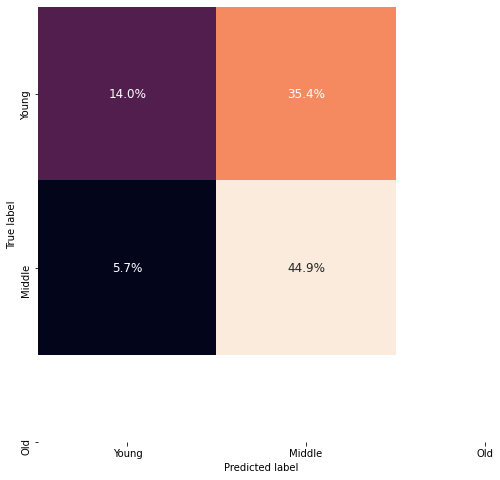

In [56]:
model = xgb.XGBClassifier()
fit_predict_plot(model, X_train, X_test, y_train, y_test, age_labels, age_labels)

### XGBoost also showed similar accuracy as decision trees. Therefore, to obtain an effective model, it is necessary to use more features. It is not possible to predict whether a customer bought online or in a store just based on his age.

## Adding new features for higher accuracy

### At the beginning, I added all the available features to check the importace of the features for the model.

In [75]:
feats = ['age', 'items', 'amount', 'region', 'age_round',
       'amount_per_item', 'age_levels_mean']
X = data[feats]
y = data['in-store']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
labels = ['in-store', 'online']

Accuracy: 84 %
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      9870
           1       0.85      0.84      0.84     10125

    accuracy                           0.84     19995
   macro avg       0.84      0.84      0.84     19995
weighted avg       0.84      0.84      0.84     19995



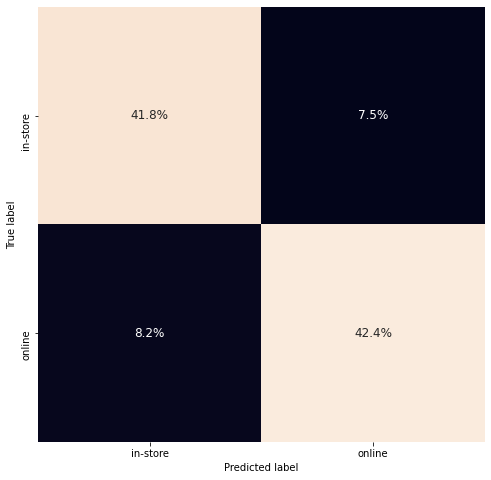

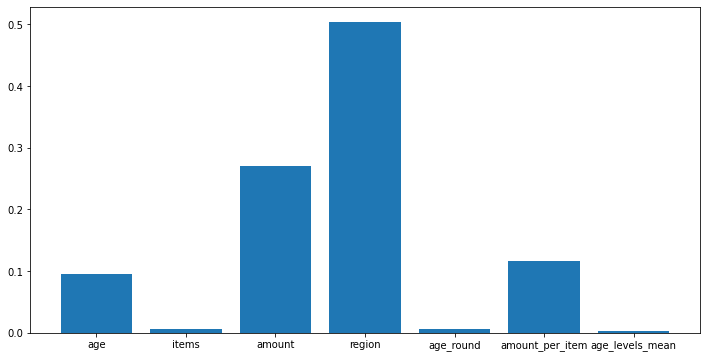

In [77]:
model = DecisionTreeClassifier()
fit_predict_plot(model, X_train, X_test, y_train, y_test, labels, labels)
plt.figure(figsize=(12,6))
plt.bar(feats,model.feature_importances_)
plt.show()

## What about items? Are these even in the tree? Why or why not? <a class="anchor" id="Q4"></a>

### Items are not in the tree and has very low importance for models due to its low correlation with target variable

C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:09:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 88 %
              precision    recall  f1-score   support

           0       0.98      0.79      0.87      9870
           1       0.82      0.98      0.90     10125

    accuracy                           0.88     19995
   macro avg       0.90      0.88      0.88     19995
weighted avg       0.90      0.88      0.88     19995



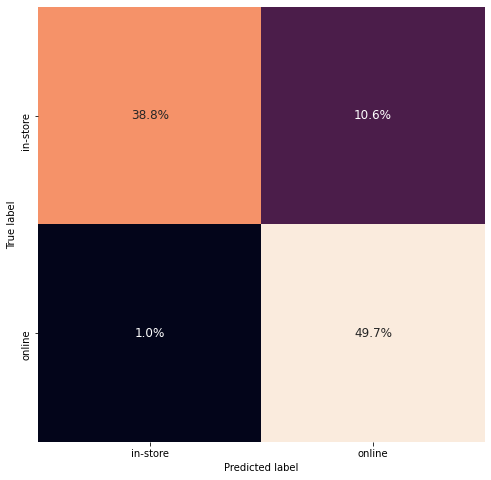

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

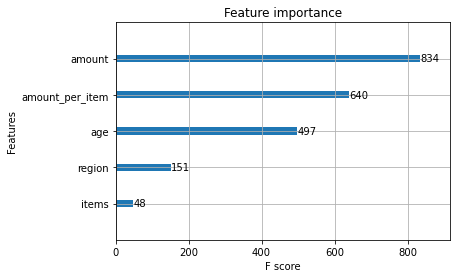

In [78]:
model = xgb.XGBClassifier()
fit_predict_plot(model, X_train, X_test, y_train, y_test, labels, labels)
xgb.plot_importance(model)

### Both models showed a high efficiency of over 80%. In the case of decision trees, the highest importance was given to features such as region, amount, age and amount_per_item. The Items feature is not very important for the model. For further modeling, I used features such as region, amount, age.

In [79]:
feats = ['age', 'amount', 'region']
X = data[feats]
y = data['in-store']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
age_labels = ['in-store', 'online']

Cross Validation accuracy scores: [0.85397566 0.84547425 0.84280713 0.84914152 0.84761587 0.84978326
 0.84544848 0.84344782 0.84544848 0.84694898]
Cross Validation accuracy: 0.847 +/- 0.003
Accuracy: 85 %
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      9870
           1       0.85      0.84      0.85     10125

    accuracy                           0.85     19995
   macro avg       0.85      0.85      0.85     19995
weighted avg       0.85      0.85      0.85     19995



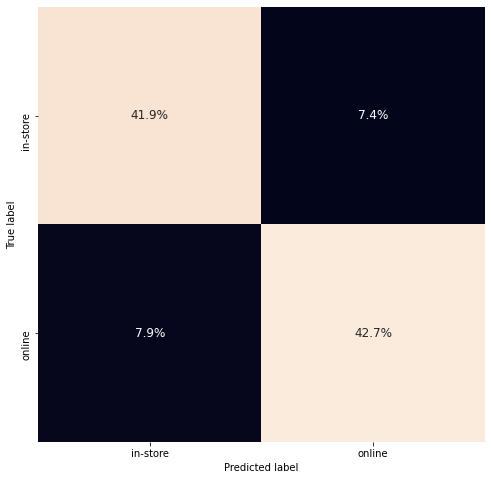

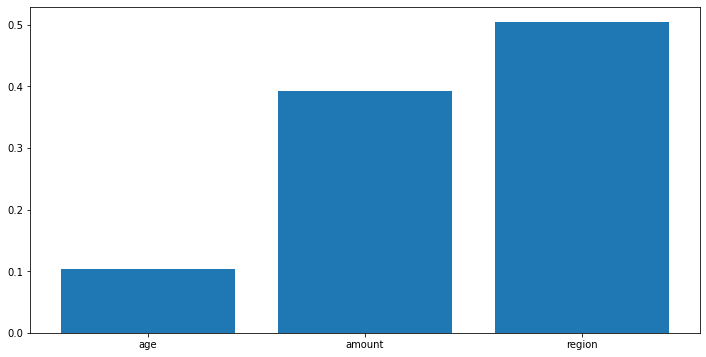

In [80]:
model = DecisionTreeClassifier()
fit_predict_plot_validation(model, X_train, X_test, y_train, y_test, labels, labels)
plt.figure(figsize=(12,6))
plt.bar(feats,model.feature_importances_)
plt.show()

[18:09:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:09:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:10:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:10:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

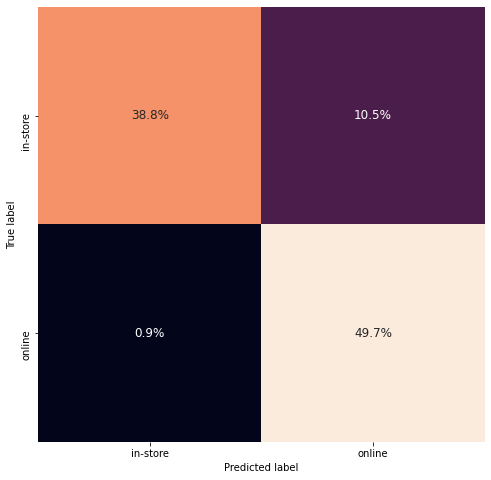

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

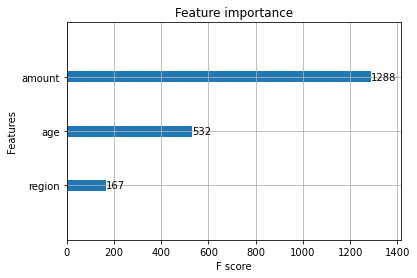

In [81]:
model = xgb.XGBClassifier(use_label_encoder=False)
fit_predict_plot_validation(model, X_train, X_test, y_train, y_test, labels, labels)
xgb.plot_importance(model)

Cross Validation accuracy scores: [0.85414236 0.84730788 0.84647441 0.85364227 0.85328443 0.85128376
 0.85645215 0.84911637 0.84794932 0.84994998]
Cross Validation accuracy: 0.851 +/- 0.003
Accuracy: 85 %
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      9870
           1       0.85      0.85      0.85     10125

    accuracy                           0.85     19995
   macro avg       0.85      0.85      0.85     19995
weighted avg       0.85      0.85      0.85     19995



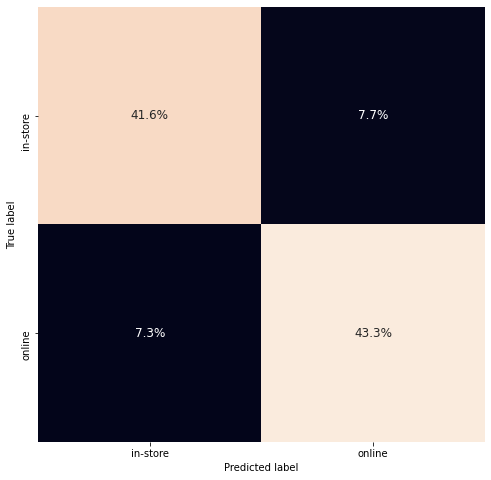

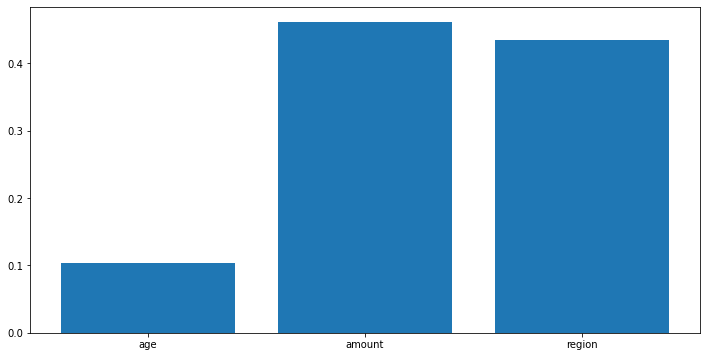

In [82]:
model = RandomForestClassifier()
fit_predict_plot_validation(model, X_train, X_test, y_train, y_test, labels, labels)
plt.figure(figsize=(12,6))
plt.bar(feats,model.feature_importances_)
plt.show()

Accuracy: 89 %
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      9870
           1       0.82      1.00      0.90     10125

    accuracy                           0.89     19995
   macro avg       0.91      0.89      0.89     19995
weighted avg       0.91      0.89      0.89     19995



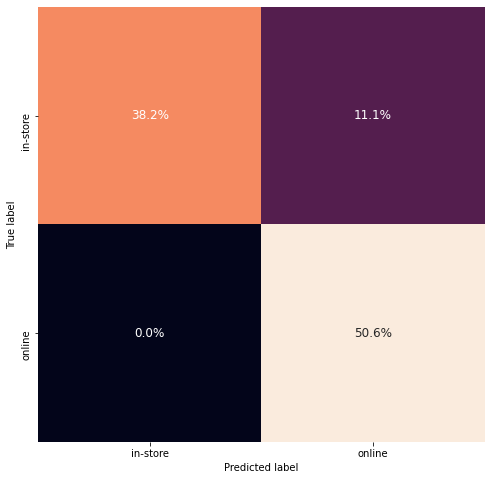

In [83]:
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8]}
fit_predict_plot_GS(DecisionTreeClassifier(), X_train, X_test, y_train, y_test, labels, labels, tree_para)

In [67]:
def XGBoost_fit_predict_CV(X_train, X_test, y_train, y_test):
    param_grid_cxgb = params = {
        'min_child_weight': [1, 5, 10, 20, 30],
        'gamma': [0.3, 0.5, 1, 1.5, 2, 5],
        'colsample_bytree': [0.6, 0.8, 1.0, 1.5, 2.0],
        'max_depth': [3, 4, 5, 6, 8, 10]
        }
    eval_s = [(X_train_val, y_train_val),(X_val,y_val)]
    cxgb_reg = xgb.XGBClassifier(learning_rate=0.08, n_estimators=300, objective='binary:logistic',
                        silent=True, nthread=1, use_label_encoder=False);
    cxgb = RandomizedSearchCV(cxgb_reg, param_grid_cxgb, cv=5, scoring='recall',verbose=3);
    cxgb.fit(X_train_val, y_train_val,eval_set=eval_s, early_stopping_rounds=20)
    print(cxgb.best_params_)
    print(cxgb.best_estimator_)
    xgb_res = cxgb.cv_results_
    xgb_best = cxgb.best_estimator_
    results = xgb_best.evals_result()
    plt.figure()
    plt.plot(results['validation_0']['logloss'], label='train')
    plt.plot(results['validation_1']['logloss'], label='test')
    plt.legend(['Train set', 'Validation set'])
    plt.xlabel('Epoch')
    plt.ylabel('Classification Error')
    plt.show()
    y_pred = xgb_best.predict(X_test)
    print('Accuracy:', round(accuracy_score(y_test, y_pred)*100), '%')
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm/np.sum(cm), annot=True, annot_kws={"size": 12}, fmt='.1%', cbar=False, xticklabels=['In-store','Online'], yticklabels=['In-store','Online'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    plt.figure()
    xgb.plot_importance(xgb_best)
    plt.show()
    return round(accuracy_score(y_test, y_pred)*100), cxgb.best_estimator_

In [68]:
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=123)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=2.0, gamma=5, max_depth=4, min_child_weight=30;, score=nan total time=   0.0s
[CV 2/5] END colsample_bytree=2.0, gamma=5, max_depth=4, min_child_weight=30;, score=nan total time=   0.0s
[CV 3/5] END colsample_bytree=2.0, gamma=5, max_depth=4, min_child_weight=30;, score=nan total time=   0.0s
[CV 4/5] END colsample_bytree=2.0, gamma=5, max_depth=4, min_child_weight=30;, score=nan total time=   0.0s
[CV 5/5] END colsample_bytree=2.0, gamma=5, max_depth=4, min_child_weight=30;, score=nan total time=   0.0s
[23:12:59] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:12:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, th

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[5]	validation_0-logloss:0.54309	validation_1-logloss:0.54383
[6]	validation_0-logloss:0.53345	validation_1-logloss:0.53434
[7]	validation_0-logloss:0.51454	validation_1-logloss:0.51557
[8]	validation_0-logloss:0.50689	validation_1-logloss:0.50774
[9]	validation_0-logloss:0.49064	validation_1-logloss:0.49146
[10]	validation_0-logloss:0.48430	validation_1-logloss:0.48484
[11]	validation_0-logloss:0.46669	validation_1-logloss:0.46696
[12]	validation_0-logloss:0.45362	validation_1-logloss:0.45404
[13]	validation_0-logloss:0.43903	validation_1-logloss:0.43939
[14]	validation_0-logloss:0.42607	validation_1-logloss:0.42622
[15]	validation_0-logloss:0.42164	validation_1-logloss:0.42161
[16]	validation_0-logloss:0.41205	validation_1-logloss:0.41215
[17]	validation_0-logloss:0.40137	validation_1-logloss:0.40122
[18]	validation_0-logloss:0.39171	validation_1-logloss:0.39147
[19]	validation_0-logloss:0.38292	validation_1-logloss:0.38252
[20]	validation_0-logloss:0.37495	validation_1-logloss:0.374

[135]	validation_0-logloss:0.24522	validation_1-logloss:0.24243
[136]	validation_0-logloss:0.24461	validation_1-logloss:0.24171
[137]	validation_0-logloss:0.24327	validation_1-logloss:0.24031
[138]	validation_0-logloss:0.24317	validation_1-logloss:0.24025
[139]	validation_0-logloss:0.24305	validation_1-logloss:0.24016
[140]	validation_0-logloss:0.24253	validation_1-logloss:0.23955
[141]	validation_0-logloss:0.24250	validation_1-logloss:0.23952
[142]	validation_0-logloss:0.24245	validation_1-logloss:0.23950
[143]	validation_0-logloss:0.24126	validation_1-logloss:0.23826
[144]	validation_0-logloss:0.24122	validation_1-logloss:0.23823
[145]	validation_0-logloss:0.24120	validation_1-logloss:0.23824
[146]	validation_0-logloss:0.24074	validation_1-logloss:0.23769
[147]	validation_0-logloss:0.24063	validation_1-logloss:0.23760
[148]	validation_0-logloss:0.24060	validation_1-logloss:0.23764
[149]	validation_0-logloss:0.24057	validation_1-logloss:0.23762
[150]	validation_0-logloss:0.24051	valid

[264]	validation_0-logloss:0.22831	validation_1-logloss:0.22504
[265]	validation_0-logloss:0.22830	validation_1-logloss:0.22504
[266]	validation_0-logloss:0.22829	validation_1-logloss:0.22503
[267]	validation_0-logloss:0.22827	validation_1-logloss:0.22504
[268]	validation_0-logloss:0.22824	validation_1-logloss:0.22507
[269]	validation_0-logloss:0.22820	validation_1-logloss:0.22502
[270]	validation_0-logloss:0.22820	validation_1-logloss:0.22502
[271]	validation_0-logloss:0.22819	validation_1-logloss:0.22500
[272]	validation_0-logloss:0.22817	validation_1-logloss:0.22501
[273]	validation_0-logloss:0.22817	validation_1-logloss:0.22501
[274]	validation_0-logloss:0.22814	validation_1-logloss:0.22498
[275]	validation_0-logloss:0.22813	validation_1-logloss:0.22498
[276]	validation_0-logloss:0.22813	validation_1-logloss:0.22498
[277]	validation_0-logloss:0.22813	validation_1-logloss:0.22498
[278]	validation_0-logloss:0.22813	validation_1-logloss:0.22498
[279]	validation_0-logloss:0.22813	valid

[86]	validation_0-logloss:0.27317	validation_1-logloss:0.27220
[87]	validation_0-logloss:0.27287	validation_1-logloss:0.27185
[88]	validation_0-logloss:0.27261	validation_1-logloss:0.27156
[89]	validation_0-logloss:0.27236	validation_1-logloss:0.27134
[90]	validation_0-logloss:0.27205	validation_1-logloss:0.27104
[91]	validation_0-logloss:0.27179	validation_1-logloss:0.27077
[92]	validation_0-logloss:0.27151	validation_1-logloss:0.27053
[93]	validation_0-logloss:0.27130	validation_1-logloss:0.27029
[94]	validation_0-logloss:0.27116	validation_1-logloss:0.27008
[95]	validation_0-logloss:0.27098	validation_1-logloss:0.26997
[96]	validation_0-logloss:0.27072	validation_1-logloss:0.26976
[97]	validation_0-logloss:0.27054	validation_1-logloss:0.26958
[98]	validation_0-logloss:0.27016	validation_1-logloss:0.26919
[99]	validation_0-logloss:0.27005	validation_1-logloss:0.26909
[100]	validation_0-logloss:0.26990	validation_1-logloss:0.26891
[101]	validation_0-logloss:0.26970	validation_1-loglos

[215]	validation_0-logloss:0.23098	validation_1-logloss:0.22756
[216]	validation_0-logloss:0.23092	validation_1-logloss:0.22747
[217]	validation_0-logloss:0.23092	validation_1-logloss:0.22747
[218]	validation_0-logloss:0.23055	validation_1-logloss:0.22711
[219]	validation_0-logloss:0.23054	validation_1-logloss:0.22711
[220]	validation_0-logloss:0.23053	validation_1-logloss:0.22714
[221]	validation_0-logloss:0.23052	validation_1-logloss:0.22713
[222]	validation_0-logloss:0.23021	validation_1-logloss:0.22681
[223]	validation_0-logloss:0.23015	validation_1-logloss:0.22674
[224]	validation_0-logloss:0.23014	validation_1-logloss:0.22674
[225]	validation_0-logloss:0.23012	validation_1-logloss:0.22673
[226]	validation_0-logloss:0.23009	validation_1-logloss:0.22670
[227]	validation_0-logloss:0.23008	validation_1-logloss:0.22671
[228]	validation_0-logloss:0.23008	validation_1-logloss:0.22671
[229]	validation_0-logloss:0.23007	validation_1-logloss:0.22672
[230]	validation_0-logloss:0.23003	valid

[47]	validation_0-logloss:0.29983	validation_1-logloss:0.29835
[48]	validation_0-logloss:0.29801	validation_1-logloss:0.29659
[49]	validation_0-logloss:0.29713	validation_1-logloss:0.29568
[50]	validation_0-logloss:0.29546	validation_1-logloss:0.29395
[51]	validation_0-logloss:0.29384	validation_1-logloss:0.29243
[52]	validation_0-logloss:0.29307	validation_1-logloss:0.29162
[53]	validation_0-logloss:0.29164	validation_1-logloss:0.29024
[54]	validation_0-logloss:0.29121	validation_1-logloss:0.28985
[55]	validation_0-logloss:0.29089	validation_1-logloss:0.28950
[56]	validation_0-logloss:0.29024	validation_1-logloss:0.28883
[57]	validation_0-logloss:0.28888	validation_1-logloss:0.28751
[58]	validation_0-logloss:0.28848	validation_1-logloss:0.28713
[59]	validation_0-logloss:0.28720	validation_1-logloss:0.28591
[60]	validation_0-logloss:0.28612	validation_1-logloss:0.28480
[61]	validation_0-logloss:0.28565	validation_1-logloss:0.28446
[62]	validation_0-logloss:0.28469	validation_1-logloss:

[176]	validation_0-logloss:0.23449	validation_1-logloss:0.23156
[177]	validation_0-logloss:0.23395	validation_1-logloss:0.23101
[178]	validation_0-logloss:0.23343	validation_1-logloss:0.23043
[179]	validation_0-logloss:0.23320	validation_1-logloss:0.23017
[180]	validation_0-logloss:0.23317	validation_1-logloss:0.23018
[181]	validation_0-logloss:0.23296	validation_1-logloss:0.22993
[182]	validation_0-logloss:0.23295	validation_1-logloss:0.22995
[183]	validation_0-logloss:0.23294	validation_1-logloss:0.22997
[184]	validation_0-logloss:0.23294	validation_1-logloss:0.22997
[185]	validation_0-logloss:0.23276	validation_1-logloss:0.22974
[186]	validation_0-logloss:0.23274	validation_1-logloss:0.22975
[187]	validation_0-logloss:0.23270	validation_1-logloss:0.22972
[188]	validation_0-logloss:0.23270	validation_1-logloss:0.22972
[189]	validation_0-logloss:0.23253	validation_1-logloss:0.22951
[190]	validation_0-logloss:0.23248	validation_1-logloss:0.22949
[191]	validation_0-logloss:0.23233	valid

[46]	validation_0-logloss:0.30193	validation_1-logloss:0.30042
[47]	validation_0-logloss:0.29991	validation_1-logloss:0.29846
[48]	validation_0-logloss:0.29813	validation_1-logloss:0.29668
[49]	validation_0-logloss:0.29720	validation_1-logloss:0.29573
[50]	validation_0-logloss:0.29554	validation_1-logloss:0.29405
[51]	validation_0-logloss:0.29393	validation_1-logloss:0.29247
[52]	validation_0-logloss:0.29351	validation_1-logloss:0.29202
[53]	validation_0-logloss:0.29213	validation_1-logloss:0.29058
[54]	validation_0-logloss:0.29169	validation_1-logloss:0.29021
[55]	validation_0-logloss:0.29102	validation_1-logloss:0.28948
[56]	validation_0-logloss:0.29065	validation_1-logloss:0.28918
[57]	validation_0-logloss:0.28935	validation_1-logloss:0.28785
[58]	validation_0-logloss:0.28879	validation_1-logloss:0.28735
[59]	validation_0-logloss:0.28753	validation_1-logloss:0.28613
[60]	validation_0-logloss:0.28639	validation_1-logloss:0.28502
[61]	validation_0-logloss:0.28593	validation_1-logloss:

[175]	validation_0-logloss:0.23601	validation_1-logloss:0.23276
[176]	validation_0-logloss:0.23579	validation_1-logloss:0.23252
[177]	validation_0-logloss:0.23501	validation_1-logloss:0.23169
[178]	validation_0-logloss:0.23441	validation_1-logloss:0.23101
[179]	validation_0-logloss:0.23422	validation_1-logloss:0.23078
[180]	validation_0-logloss:0.23420	validation_1-logloss:0.23077
[181]	validation_0-logloss:0.23410	validation_1-logloss:0.23066
[182]	validation_0-logloss:0.23409	validation_1-logloss:0.23066
[183]	validation_0-logloss:0.23408	validation_1-logloss:0.23065
[184]	validation_0-logloss:0.23406	validation_1-logloss:0.23066
[185]	validation_0-logloss:0.23398	validation_1-logloss:0.23056
[186]	validation_0-logloss:0.23394	validation_1-logloss:0.23057
[187]	validation_0-logloss:0.23387	validation_1-logloss:0.23048
[188]	validation_0-logloss:0.23387	validation_1-logloss:0.23047
[189]	validation_0-logloss:0.23387	validation_1-logloss:0.23047
[190]	validation_0-logloss:0.23385	valid

[55]	validation_0-logloss:0.29070	validation_1-logloss:0.28907
[56]	validation_0-logloss:0.29043	validation_1-logloss:0.28877
[57]	validation_0-logloss:0.28906	validation_1-logloss:0.28745
[58]	validation_0-logloss:0.28862	validation_1-logloss:0.28705
[59]	validation_0-logloss:0.28736	validation_1-logloss:0.28584
[60]	validation_0-logloss:0.28624	validation_1-logloss:0.28472
[61]	validation_0-logloss:0.28584	validation_1-logloss:0.28436
[62]	validation_0-logloss:0.28482	validation_1-logloss:0.28334
[63]	validation_0-logloss:0.28447	validation_1-logloss:0.28302
[64]	validation_0-logloss:0.28351	validation_1-logloss:0.28206
[65]	validation_0-logloss:0.28260	validation_1-logloss:0.28118
[66]	validation_0-logloss:0.28204	validation_1-logloss:0.28059
[67]	validation_0-logloss:0.28120	validation_1-logloss:0.27976
[68]	validation_0-logloss:0.28069	validation_1-logloss:0.27919
[69]	validation_0-logloss:0.27990	validation_1-logloss:0.27843
[70]	validation_0-logloss:0.27918	validation_1-logloss:

[184]	validation_0-logloss:0.23172	validation_1-logloss:0.22823
[185]	validation_0-logloss:0.23165	validation_1-logloss:0.22811
[186]	validation_0-logloss:0.23162	validation_1-logloss:0.22812
[187]	validation_0-logloss:0.23155	validation_1-logloss:0.22802
[188]	validation_0-logloss:0.23153	validation_1-logloss:0.22804
[189]	validation_0-logloss:0.23143	validation_1-logloss:0.22795
[190]	validation_0-logloss:0.23140	validation_1-logloss:0.22798
[191]	validation_0-logloss:0.23134	validation_1-logloss:0.22788
[192]	validation_0-logloss:0.23127	validation_1-logloss:0.22780
[193]	validation_0-logloss:0.23092	validation_1-logloss:0.22743
[194]	validation_0-logloss:0.23091	validation_1-logloss:0.22741
[195]	validation_0-logloss:0.23087	validation_1-logloss:0.22739
[196]	validation_0-logloss:0.23081	validation_1-logloss:0.22731
[197]	validation_0-logloss:0.23045	validation_1-logloss:0.22693
[198]	validation_0-logloss:0.23040	validation_1-logloss:0.22686
[199]	validation_0-logloss:0.23039	valid

[18]	validation_0-logloss:0.45405	validation_1-logloss:0.45452
[19]	validation_0-logloss:0.44354	validation_1-logloss:0.44401
[20]	validation_0-logloss:0.43409	validation_1-logloss:0.43454
[21]	validation_0-logloss:0.42961	validation_1-logloss:0.43003
[22]	validation_0-logloss:0.42841	validation_1-logloss:0.42892
[23]	validation_0-logloss:0.42449	validation_1-logloss:0.42494
[24]	validation_0-logloss:0.41613	validation_1-logloss:0.41656
[25]	validation_0-logloss:0.41271	validation_1-logloss:0.41309
[26]	validation_0-logloss:0.40966	validation_1-logloss:0.41000
[27]	validation_0-logloss:0.40217	validation_1-logloss:0.40248
[28]	validation_0-logloss:0.39541	validation_1-logloss:0.39568
[29]	validation_0-logloss:0.38927	validation_1-logloss:0.38951
[30]	validation_0-logloss:0.38660	validation_1-logloss:0.38679
[31]	validation_0-logloss:0.38425	validation_1-logloss:0.38437
[32]	validation_0-logloss:0.37865	validation_1-logloss:0.37876
[33]	validation_0-logloss:0.37360	validation_1-logloss:

[148]	validation_0-logloss:0.28037	validation_1-logloss:0.28124
[149]	validation_0-logloss:0.27999	validation_1-logloss:0.28085
[150]	validation_0-logloss:0.27973	validation_1-logloss:0.28062
[151]	validation_0-logloss:0.27937	validation_1-logloss:0.28026
[152]	validation_0-logloss:0.27913	validation_1-logloss:0.28006
[153]	validation_0-logloss:0.27892	validation_1-logloss:0.27988
[154]	validation_0-logloss:0.27859	validation_1-logloss:0.27953
[155]	validation_0-logloss:0.27829	validation_1-logloss:0.27921
[156]	validation_0-logloss:0.27806	validation_1-logloss:0.27904
[157]	validation_0-logloss:0.27788	validation_1-logloss:0.27889
[158]	validation_0-logloss:0.27781	validation_1-logloss:0.27885
[159]	validation_0-logloss:0.27752	validation_1-logloss:0.27854
[160]	validation_0-logloss:0.27745	validation_1-logloss:0.27849
[161]	validation_0-logloss:0.27715	validation_1-logloss:0.27821
[162]	validation_0-logloss:0.27700	validation_1-logloss:0.27804
[163]	validation_0-logloss:0.27674	valid

[277]	validation_0-logloss:0.26927	validation_1-logloss:0.27126
[278]	validation_0-logloss:0.26925	validation_1-logloss:0.27125
[279]	validation_0-logloss:0.26920	validation_1-logloss:0.27119
[280]	validation_0-logloss:0.26919	validation_1-logloss:0.27118
[281]	validation_0-logloss:0.26916	validation_1-logloss:0.27115
[282]	validation_0-logloss:0.26910	validation_1-logloss:0.27110
[283]	validation_0-logloss:0.26910	validation_1-logloss:0.27109
[284]	validation_0-logloss:0.26907	validation_1-logloss:0.27107
[285]	validation_0-logloss:0.26902	validation_1-logloss:0.27102
[286]	validation_0-logloss:0.26900	validation_1-logloss:0.27100
[287]	validation_0-logloss:0.26898	validation_1-logloss:0.27098
[288]	validation_0-logloss:0.26892	validation_1-logloss:0.27094
[289]	validation_0-logloss:0.26890	validation_1-logloss:0.27092
[290]	validation_0-logloss:0.26888	validation_1-logloss:0.27090
[291]	validation_0-logloss:0.26886	validation_1-logloss:0.27089
[292]	validation_0-logloss:0.26884	valid

[96]	validation_0-logloss:0.29780	validation_1-logloss:0.29835
[97]	validation_0-logloss:0.29666	validation_1-logloss:0.29716
[98]	validation_0-logloss:0.29652	validation_1-logloss:0.29705
[99]	validation_0-logloss:0.29612	validation_1-logloss:0.29669
[100]	validation_0-logloss:0.29601	validation_1-logloss:0.29664
[101]	validation_0-logloss:0.29592	validation_1-logloss:0.29657
[102]	validation_0-logloss:0.29482	validation_1-logloss:0.29543
[103]	validation_0-logloss:0.29474	validation_1-logloss:0.29539
[104]	validation_0-logloss:0.29465	validation_1-logloss:0.29532
[105]	validation_0-logloss:0.29461	validation_1-logloss:0.29530
[106]	validation_0-logloss:0.29358	validation_1-logloss:0.29424
[107]	validation_0-logloss:0.29316	validation_1-logloss:0.29386
[108]	validation_0-logloss:0.29281	validation_1-logloss:0.29351
[109]	validation_0-logloss:0.29186	validation_1-logloss:0.29251
[110]	validation_0-logloss:0.29149	validation_1-logloss:0.29219
[111]	validation_0-logloss:0.29145	validatio

[225]	validation_0-logloss:0.27138	validation_1-logloss:0.27313
[226]	validation_0-logloss:0.27134	validation_1-logloss:0.27311
[227]	validation_0-logloss:0.27131	validation_1-logloss:0.27312
[228]	validation_0-logloss:0.27129	validation_1-logloss:0.27311
[229]	validation_0-logloss:0.27128	validation_1-logloss:0.27310
[230]	validation_0-logloss:0.27126	validation_1-logloss:0.27309
[231]	validation_0-logloss:0.27124	validation_1-logloss:0.27311
[232]	validation_0-logloss:0.27120	validation_1-logloss:0.27311
[233]	validation_0-logloss:0.27107	validation_1-logloss:0.27297
[234]	validation_0-logloss:0.27095	validation_1-logloss:0.27283
[235]	validation_0-logloss:0.27093	validation_1-logloss:0.27282
[236]	validation_0-logloss:0.27091	validation_1-logloss:0.27281
[237]	validation_0-logloss:0.27080	validation_1-logloss:0.27269
[238]	validation_0-logloss:0.27078	validation_1-logloss:0.27268
[239]	validation_0-logloss:0.27076	validation_1-logloss:0.27266
[240]	validation_0-logloss:0.27066	valid

[44]	validation_0-logloss:0.35304	validation_1-logloss:0.35336
[45]	validation_0-logloss:0.35172	validation_1-logloss:0.35206
[46]	validation_0-logloss:0.35057	validation_1-logloss:0.35088
[47]	validation_0-logloss:0.34954	validation_1-logloss:0.34983
[48]	validation_0-logloss:0.34900	validation_1-logloss:0.34936
[49]	validation_0-logloss:0.34853	validation_1-logloss:0.34892
[50]	validation_0-logloss:0.34759	validation_1-logloss:0.34795
[51]	validation_0-logloss:0.34366	validation_1-logloss:0.34399
[52]	validation_0-logloss:0.34279	validation_1-logloss:0.34306
[53]	validation_0-logloss:0.34199	validation_1-logloss:0.34227
[54]	validation_0-logloss:0.34154	validation_1-logloss:0.34189
[55]	validation_0-logloss:0.34084	validation_1-logloss:0.34116
[56]	validation_0-logloss:0.34048	validation_1-logloss:0.34083
[57]	validation_0-logloss:0.33687	validation_1-logloss:0.33717
[58]	validation_0-logloss:0.33618	validation_1-logloss:0.33647
[59]	validation_0-logloss:0.33587	validation_1-logloss:

[173]	validation_0-logloss:0.27566	validation_1-logloss:0.27666
[174]	validation_0-logloss:0.27543	validation_1-logloss:0.27642
[175]	validation_0-logloss:0.27521	validation_1-logloss:0.27620
[176]	validation_0-logloss:0.27516	validation_1-logloss:0.27616
[177]	validation_0-logloss:0.27504	validation_1-logloss:0.27608
[178]	validation_0-logloss:0.27494	validation_1-logloss:0.27598
[179]	validation_0-logloss:0.27473	validation_1-logloss:0.27577
[180]	validation_0-logloss:0.27468	validation_1-logloss:0.27574
[181]	validation_0-logloss:0.27463	validation_1-logloss:0.27571
[182]	validation_0-logloss:0.27454	validation_1-logloss:0.27564
[183]	validation_0-logloss:0.27449	validation_1-logloss:0.27562
[184]	validation_0-logloss:0.27444	validation_1-logloss:0.27555
[185]	validation_0-logloss:0.27423	validation_1-logloss:0.27534
[186]	validation_0-logloss:0.27415	validation_1-logloss:0.27527
[187]	validation_0-logloss:0.27394	validation_1-logloss:0.27508
[188]	validation_0-logloss:0.27391	valid

[0]	validation_0-logloss:0.68721	validation_1-logloss:0.68713
[1]	validation_0-logloss:0.66996	validation_1-logloss:0.67008
[2]	validation_0-logloss:0.63669	validation_1-logloss:0.63692
[3]	validation_0-logloss:0.60821	validation_1-logloss:0.60853
[4]	validation_0-logloss:0.60434	validation_1-logloss:0.60464
[5]	validation_0-logloss:0.60099	validation_1-logloss:0.60126
[6]	validation_0-logloss:0.58861	validation_1-logloss:0.58897
[7]	validation_0-logloss:0.56527	validation_1-logloss:0.56572
[8]	validation_0-logloss:0.56264	validation_1-logloss:0.56315
[9]	validation_0-logloss:0.54253	validation_1-logloss:0.54299
[10]	validation_0-logloss:0.53302	validation_1-logloss:0.53360
[11]	validation_0-logloss:0.51559	validation_1-logloss:0.51620
[12]	validation_0-logloss:0.50013	validation_1-logloss:0.50077
[13]	validation_0-logloss:0.49265	validation_1-logloss:0.49331
[14]	validation_0-logloss:0.47910	validation_1-logloss:0.47979
[15]	validation_0-logloss:0.47756	validation_1-logloss:0.47823
[1

[130]	validation_0-logloss:0.28494	validation_1-logloss:0.28584
[131]	validation_0-logloss:0.28468	validation_1-logloss:0.28562
[132]	validation_0-logloss:0.28464	validation_1-logloss:0.28562
[133]	validation_0-logloss:0.28462	validation_1-logloss:0.28561
[134]	validation_0-logloss:0.28440	validation_1-logloss:0.28542
[135]	validation_0-logloss:0.28420	validation_1-logloss:0.28524
[136]	validation_0-logloss:0.28418	validation_1-logloss:0.28522
[137]	validation_0-logloss:0.28352	validation_1-logloss:0.28455
[138]	validation_0-logloss:0.28350	validation_1-logloss:0.28454
[139]	validation_0-logloss:0.28288	validation_1-logloss:0.28391
[140]	validation_0-logloss:0.28231	validation_1-logloss:0.28334
[141]	validation_0-logloss:0.28180	validation_1-logloss:0.28281
[142]	validation_0-logloss:0.28158	validation_1-logloss:0.28258
[143]	validation_0-logloss:0.28109	validation_1-logloss:0.28209
[144]	validation_0-logloss:0.28105	validation_1-logloss:0.28206
[145]	validation_0-logloss:0.28102	valid

[259]	validation_0-logloss:0.26958	validation_1-logloss:0.27132
[260]	validation_0-logloss:0.26952	validation_1-logloss:0.27125
[261]	validation_0-logloss:0.26950	validation_1-logloss:0.27123
[262]	validation_0-logloss:0.26946	validation_1-logloss:0.27119
[263]	validation_0-logloss:0.26944	validation_1-logloss:0.27118
[264]	validation_0-logloss:0.26943	validation_1-logloss:0.27117
[265]	validation_0-logloss:0.26941	validation_1-logloss:0.27116
[266]	validation_0-logloss:0.26940	validation_1-logloss:0.27115
[267]	validation_0-logloss:0.26939	validation_1-logloss:0.27115
[268]	validation_0-logloss:0.26938	validation_1-logloss:0.27114
[269]	validation_0-logloss:0.26937	validation_1-logloss:0.27113
[270]	validation_0-logloss:0.26931	validation_1-logloss:0.27107
[271]	validation_0-logloss:0.26930	validation_1-logloss:0.27106
[272]	validation_0-logloss:0.26928	validation_1-logloss:0.27105
[273]	validation_0-logloss:0.26927	validation_1-logloss:0.27105
[274]	validation_0-logloss:0.26925	valid

[78]	validation_0-logloss:0.31050	validation_1-logloss:0.31064
[79]	validation_0-logloss:0.31029	validation_1-logloss:0.31050
[80]	validation_0-logloss:0.30853	validation_1-logloss:0.30871
[81]	validation_0-logloss:0.30799	validation_1-logloss:0.30816
[82]	validation_0-logloss:0.30636	validation_1-logloss:0.30650
[83]	validation_0-logloss:0.30585	validation_1-logloss:0.30600
[84]	validation_0-logloss:0.30434	validation_1-logloss:0.30445
[85]	validation_0-logloss:0.30412	validation_1-logloss:0.30431
[86]	validation_0-logloss:0.30274	validation_1-logloss:0.30289
[87]	validation_0-logloss:0.30255	validation_1-logloss:0.30273
[88]	validation_0-logloss:0.30127	validation_1-logloss:0.30142
[89]	validation_0-logloss:0.30109	validation_1-logloss:0.30129
[90]	validation_0-logloss:0.30093	validation_1-logloss:0.30114
[91]	validation_0-logloss:0.30077	validation_1-logloss:0.30103
[92]	validation_0-logloss:0.30021	validation_1-logloss:0.30050
[93]	validation_0-logloss:0.29899	validation_1-logloss:

[207]	validation_0-logloss:0.27242	validation_1-logloss:0.27432
[208]	validation_0-logloss:0.27225	validation_1-logloss:0.27415
[209]	validation_0-logloss:0.27223	validation_1-logloss:0.27414
[210]	validation_0-logloss:0.27221	validation_1-logloss:0.27413
[211]	validation_0-logloss:0.27205	validation_1-logloss:0.27397
[212]	validation_0-logloss:0.27201	validation_1-logloss:0.27394
[213]	validation_0-logloss:0.27198	validation_1-logloss:0.27392
[214]	validation_0-logloss:0.27194	validation_1-logloss:0.27391
[215]	validation_0-logloss:0.27177	validation_1-logloss:0.27375
[216]	validation_0-logloss:0.27176	validation_1-logloss:0.27374
[217]	validation_0-logloss:0.27174	validation_1-logloss:0.27372
[218]	validation_0-logloss:0.27159	validation_1-logloss:0.27357
[219]	validation_0-logloss:0.27146	validation_1-logloss:0.27343
[220]	validation_0-logloss:0.27144	validation_1-logloss:0.27340
[221]	validation_0-logloss:0.27142	validation_1-logloss:0.27339
[222]	validation_0-logloss:0.27140	valid

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[1]	validation_0-logloss:0.59457	validation_1-logloss:0.59401
[2]	validation_0-logloss:0.55537	validation_1-logloss:0.55472
[3]	validation_0-logloss:0.52159	validation_1-logloss:0.52049
[4]	validation_0-logloss:0.49194	validation_1-logloss:0.49058
[5]	validation_0-logloss:0.46564	validation_1-logloss:0.46422
[6]	validation_0-logloss:0.44252	validation_1-logloss:0.44086
[7]	validation_0-logloss:0.42214	validation_1-logloss:0.42009
[8]	validation_0-logloss:0.40364	validation_1-logloss:0.40156
[9]	validation_0-logloss:0.38730	validation_1-logloss:0.38499
[10]	validation_0-logloss:0.37254	validation_1-logloss:0.37010
[11]	validation_0-logloss:0.35916	validation_1-logloss:0.35675
[12]	validation_0-logloss:0.34730	validation_1-logloss:0.34464
[13]	validation_0-logloss:0.33643	validation_1-logloss:0.33376
[14]	validation_0-logloss:0.32670	validation_1-logloss:0.32388
[15]	validation_0-logloss:0.31793	validation_1-logloss:0.31496
[16]	validation_0-logloss:0.30981	validation_1-logloss:0.30686
[

[25]	validation_0-logloss:0.26253	validation_1-logloss:0.25940
[26]	validation_0-logloss:0.25932	validation_1-logloss:0.25610
[27]	validation_0-logloss:0.25642	validation_1-logloss:0.25307
[28]	validation_0-logloss:0.25361	validation_1-logloss:0.25031
[29]	validation_0-logloss:0.25111	validation_1-logloss:0.24776
[30]	validation_0-logloss:0.24886	validation_1-logloss:0.24544
[31]	validation_0-logloss:0.24670	validation_1-logloss:0.24330
[32]	validation_0-logloss:0.24480	validation_1-logloss:0.24135
[33]	validation_0-logloss:0.24295	validation_1-logloss:0.23957
[34]	validation_0-logloss:0.24141	validation_1-logloss:0.23792
[35]	validation_0-logloss:0.23983	validation_1-logloss:0.23644
[36]	validation_0-logloss:0.23844	validation_1-logloss:0.23503
[37]	validation_0-logloss:0.23714	validation_1-logloss:0.23379
[38]	validation_0-logloss:0.23598	validation_1-logloss:0.23261
[39]	validation_0-logloss:0.23499	validation_1-logloss:0.23159
[40]	validation_0-logloss:0.23394	validation_1-logloss:

[47]	validation_0-logloss:0.22909	validation_1-logloss:0.22663
[48]	validation_0-logloss:0.22852	validation_1-logloss:0.22615
[49]	validation_0-logloss:0.22803	validation_1-logloss:0.22565
[50]	validation_0-logloss:0.22767	validation_1-logloss:0.22524
[51]	validation_0-logloss:0.22722	validation_1-logloss:0.22490
[52]	validation_0-logloss:0.22679	validation_1-logloss:0.22457
[53]	validation_0-logloss:0.22652	validation_1-logloss:0.22426
[54]	validation_0-logloss:0.22608	validation_1-logloss:0.22401
[55]	validation_0-logloss:0.22590	validation_1-logloss:0.22375
[56]	validation_0-logloss:0.22550	validation_1-logloss:0.22354
[57]	validation_0-logloss:0.22532	validation_1-logloss:0.22332
[58]	validation_0-logloss:0.22513	validation_1-logloss:0.22314
[59]	validation_0-logloss:0.22476	validation_1-logloss:0.22301
[60]	validation_0-logloss:0.22464	validation_1-logloss:0.22279
[61]	validation_0-logloss:0.22447	validation_1-logloss:0.22265
[62]	validation_0-logloss:0.22417	validation_1-logloss:

[58]	validation_0-logloss:0.22512	validation_1-logloss:0.22281
[59]	validation_0-logloss:0.22478	validation_1-logloss:0.22266
[60]	validation_0-logloss:0.22460	validation_1-logloss:0.22244
[61]	validation_0-logloss:0.22439	validation_1-logloss:0.22234
[62]	validation_0-logloss:0.22414	validation_1-logloss:0.22222
[63]	validation_0-logloss:0.22395	validation_1-logloss:0.22211
[64]	validation_0-logloss:0.22379	validation_1-logloss:0.22193
[65]	validation_0-logloss:0.22366	validation_1-logloss:0.22187
[66]	validation_0-logloss:0.22345	validation_1-logloss:0.22171
[67]	validation_0-logloss:0.22337	validation_1-logloss:0.22166
[68]	validation_0-logloss:0.22324	validation_1-logloss:0.22153
[69]	validation_0-logloss:0.22320	validation_1-logloss:0.22142
[70]	validation_0-logloss:0.22305	validation_1-logloss:0.22142
[71]	validation_0-logloss:0.22282	validation_1-logloss:0.22134
[72]	validation_0-logloss:0.22278	validation_1-logloss:0.22131
[73]	validation_0-logloss:0.22252	validation_1-logloss:

[73]	validation_0-logloss:0.22283	validation_1-logloss:0.22092
[74]	validation_0-logloss:0.22276	validation_1-logloss:0.22083
[75]	validation_0-logloss:0.22266	validation_1-logloss:0.22078
[76]	validation_0-logloss:0.22263	validation_1-logloss:0.22074
[77]	validation_0-logloss:0.22244	validation_1-logloss:0.22087
[78]	validation_0-logloss:0.22226	validation_1-logloss:0.22093
[79]	validation_0-logloss:0.22212	validation_1-logloss:0.22088
[80]	validation_0-logloss:0.22206	validation_1-logloss:0.22087
[81]	validation_0-logloss:0.22193	validation_1-logloss:0.22086
[82]	validation_0-logloss:0.22192	validation_1-logloss:0.22085
[83]	validation_0-logloss:0.22182	validation_1-logloss:0.22086
[84]	validation_0-logloss:0.22168	validation_1-logloss:0.22096
[85]	validation_0-logloss:0.22167	validation_1-logloss:0.22097
[86]	validation_0-logloss:0.22145	validation_1-logloss:0.22100
[87]	validation_0-logloss:0.22144	validation_1-logloss:0.22099
[88]	validation_0-logloss:0.22134	validation_1-logloss:

[96]	validation_0-logloss:0.29846	validation_1-logloss:0.29827
[97]	validation_0-logloss:0.29733	validation_1-logloss:0.29709
[98]	validation_0-logloss:0.29720	validation_1-logloss:0.29700
[99]	validation_0-logloss:0.29679	validation_1-logloss:0.29658
[100]	validation_0-logloss:0.29669	validation_1-logloss:0.29652
[101]	validation_0-logloss:0.29661	validation_1-logloss:0.29646
[102]	validation_0-logloss:0.29556	validation_1-logloss:0.29534
[103]	validation_0-logloss:0.29547	validation_1-logloss:0.29530
[104]	validation_0-logloss:0.29540	validation_1-logloss:0.29525
[105]	validation_0-logloss:0.29534	validation_1-logloss:0.29523
[106]	validation_0-logloss:0.29431	validation_1-logloss:0.29419
[107]	validation_0-logloss:0.29390	validation_1-logloss:0.29379
[108]	validation_0-logloss:0.29355	validation_1-logloss:0.29344
[109]	validation_0-logloss:0.29260	validation_1-logloss:0.29246
[110]	validation_0-logloss:0.29222	validation_1-logloss:0.29213
[111]	validation_0-logloss:0.29217	validatio

[225]	validation_0-logloss:0.27235	validation_1-logloss:0.27261
[226]	validation_0-logloss:0.27233	validation_1-logloss:0.27260
[227]	validation_0-logloss:0.27232	validation_1-logloss:0.27259
[228]	validation_0-logloss:0.27229	validation_1-logloss:0.27258
[229]	validation_0-logloss:0.27229	validation_1-logloss:0.27257
[230]	validation_0-logloss:0.27227	validation_1-logloss:0.27256
[231]	validation_0-logloss:0.27225	validation_1-logloss:0.27253
[232]	validation_0-logloss:0.27225	validation_1-logloss:0.27253
[233]	validation_0-logloss:0.27210	validation_1-logloss:0.27241
[234]	validation_0-logloss:0.27200	validation_1-logloss:0.27229
[235]	validation_0-logloss:0.27198	validation_1-logloss:0.27228
[236]	validation_0-logloss:0.27197	validation_1-logloss:0.27226
[237]	validation_0-logloss:0.27187	validation_1-logloss:0.27215
[238]	validation_0-logloss:0.27185	validation_1-logloss:0.27215
[239]	validation_0-logloss:0.27183	validation_1-logloss:0.27214
[240]	validation_0-logloss:0.27173	valid

[44]	validation_0-logloss:0.35315	validation_1-logloss:0.35326
[45]	validation_0-logloss:0.35188	validation_1-logloss:0.35197
[46]	validation_0-logloss:0.35075	validation_1-logloss:0.35079
[47]	validation_0-logloss:0.34976	validation_1-logloss:0.34975
[48]	validation_0-logloss:0.34922	validation_1-logloss:0.34929
[49]	validation_0-logloss:0.34874	validation_1-logloss:0.34889
[50]	validation_0-logloss:0.34782	validation_1-logloss:0.34793
[51]	validation_0-logloss:0.34388	validation_1-logloss:0.34395
[52]	validation_0-logloss:0.34304	validation_1-logloss:0.34305
[53]	validation_0-logloss:0.34224	validation_1-logloss:0.34224
[54]	validation_0-logloss:0.34179	validation_1-logloss:0.34188
[55]	validation_0-logloss:0.34115	validation_1-logloss:0.34115
[56]	validation_0-logloss:0.34077	validation_1-logloss:0.34085
[57]	validation_0-logloss:0.33714	validation_1-logloss:0.33716
[58]	validation_0-logloss:0.33648	validation_1-logloss:0.33648
[59]	validation_0-logloss:0.33615	validation_1-logloss:

[173]	validation_0-logloss:0.27652	validation_1-logloss:0.27681
[174]	validation_0-logloss:0.27628	validation_1-logloss:0.27655
[175]	validation_0-logloss:0.27606	validation_1-logloss:0.27632
[176]	validation_0-logloss:0.27598	validation_1-logloss:0.27628
[177]	validation_0-logloss:0.27590	validation_1-logloss:0.27619
[178]	validation_0-logloss:0.27580	validation_1-logloss:0.27612
[179]	validation_0-logloss:0.27559	validation_1-logloss:0.27589
[180]	validation_0-logloss:0.27554	validation_1-logloss:0.27586
[181]	validation_0-logloss:0.27549	validation_1-logloss:0.27583
[182]	validation_0-logloss:0.27541	validation_1-logloss:0.27576
[183]	validation_0-logloss:0.27538	validation_1-logloss:0.27574
[184]	validation_0-logloss:0.27531	validation_1-logloss:0.27570
[185]	validation_0-logloss:0.27512	validation_1-logloss:0.27547
[186]	validation_0-logloss:0.27505	validation_1-logloss:0.27542
[187]	validation_0-logloss:0.27483	validation_1-logloss:0.27521
[188]	validation_0-logloss:0.27478	valid

[0]	validation_0-logloss:0.68734	validation_1-logloss:0.68720
[1]	validation_0-logloss:0.66986	validation_1-logloss:0.67004
[2]	validation_0-logloss:0.63661	validation_1-logloss:0.63688
[3]	validation_0-logloss:0.60814	validation_1-logloss:0.60847
[4]	validation_0-logloss:0.60430	validation_1-logloss:0.60463
[5]	validation_0-logloss:0.60099	validation_1-logloss:0.60132
[6]	validation_0-logloss:0.58851	validation_1-logloss:0.58891
[7]	validation_0-logloss:0.56524	validation_1-logloss:0.56566
[8]	validation_0-logloss:0.56273	validation_1-logloss:0.56313
[9]	validation_0-logloss:0.54255	validation_1-logloss:0.54297
[10]	validation_0-logloss:0.53300	validation_1-logloss:0.53353
[11]	validation_0-logloss:0.51563	validation_1-logloss:0.51615
[12]	validation_0-logloss:0.50023	validation_1-logloss:0.50073
[13]	validation_0-logloss:0.49275	validation_1-logloss:0.49323
[14]	validation_0-logloss:0.47920	validation_1-logloss:0.47973
[15]	validation_0-logloss:0.47761	validation_1-logloss:0.47818
[1

[130]	validation_0-logloss:0.28617	validation_1-logloss:0.28619
[131]	validation_0-logloss:0.28593	validation_1-logloss:0.28595
[132]	validation_0-logloss:0.28590	validation_1-logloss:0.28594
[133]	validation_0-logloss:0.28587	validation_1-logloss:0.28593
[134]	validation_0-logloss:0.28567	validation_1-logloss:0.28573
[135]	validation_0-logloss:0.28548	validation_1-logloss:0.28554
[136]	validation_0-logloss:0.28547	validation_1-logloss:0.28554
[137]	validation_0-logloss:0.28481	validation_1-logloss:0.28487
[138]	validation_0-logloss:0.28479	validation_1-logloss:0.28486
[139]	validation_0-logloss:0.28419	validation_1-logloss:0.28424
[140]	validation_0-logloss:0.28362	validation_1-logloss:0.28367
[141]	validation_0-logloss:0.28311	validation_1-logloss:0.28315
[142]	validation_0-logloss:0.28288	validation_1-logloss:0.28293
[143]	validation_0-logloss:0.28243	validation_1-logloss:0.28245
[144]	validation_0-logloss:0.28237	validation_1-logloss:0.28240
[145]	validation_0-logloss:0.28234	valid

[259]	validation_0-logloss:0.27121	validation_1-logloss:0.27167
[260]	validation_0-logloss:0.27118	validation_1-logloss:0.27160
[261]	validation_0-logloss:0.27115	validation_1-logloss:0.27159
[262]	validation_0-logloss:0.27112	validation_1-logloss:0.27156
[263]	validation_0-logloss:0.27109	validation_1-logloss:0.27155
[264]	validation_0-logloss:0.27106	validation_1-logloss:0.27155
[265]	validation_0-logloss:0.27105	validation_1-logloss:0.27154
[266]	validation_0-logloss:0.27104	validation_1-logloss:0.27153
[267]	validation_0-logloss:0.27103	validation_1-logloss:0.27153
[268]	validation_0-logloss:0.27103	validation_1-logloss:0.27151
[269]	validation_0-logloss:0.27101	validation_1-logloss:0.27151
[270]	validation_0-logloss:0.27094	validation_1-logloss:0.27144
[271]	validation_0-logloss:0.27093	validation_1-logloss:0.27143
[272]	validation_0-logloss:0.27091	validation_1-logloss:0.27143
[273]	validation_0-logloss:0.27089	validation_1-logloss:0.27141
[274]	validation_0-logloss:0.27087	valid

[78]	validation_0-logloss:0.31077	validation_1-logloss:0.31061
[79]	validation_0-logloss:0.31058	validation_1-logloss:0.31044
[80]	validation_0-logloss:0.30883	validation_1-logloss:0.30865
[81]	validation_0-logloss:0.30832	validation_1-logloss:0.30812
[82]	validation_0-logloss:0.30665	validation_1-logloss:0.30645
[83]	validation_0-logloss:0.30615	validation_1-logloss:0.30595
[84]	validation_0-logloss:0.30467	validation_1-logloss:0.30440
[85]	validation_0-logloss:0.30444	validation_1-logloss:0.30424
[86]	validation_0-logloss:0.30306	validation_1-logloss:0.30282
[87]	validation_0-logloss:0.30286	validation_1-logloss:0.30268
[88]	validation_0-logloss:0.30161	validation_1-logloss:0.30136
[89]	validation_0-logloss:0.30140	validation_1-logloss:0.30123
[90]	validation_0-logloss:0.30126	validation_1-logloss:0.30113
[91]	validation_0-logloss:0.30114	validation_1-logloss:0.30103
[92]	validation_0-logloss:0.30058	validation_1-logloss:0.30051
[93]	validation_0-logloss:0.29936	validation_1-logloss:

[207]	validation_0-logloss:0.27353	validation_1-logloss:0.27383
[208]	validation_0-logloss:0.27337	validation_1-logloss:0.27366
[209]	validation_0-logloss:0.27336	validation_1-logloss:0.27365
[210]	validation_0-logloss:0.27334	validation_1-logloss:0.27364
[211]	validation_0-logloss:0.27318	validation_1-logloss:0.27348
[212]	validation_0-logloss:0.27314	validation_1-logloss:0.27343
[213]	validation_0-logloss:0.27312	validation_1-logloss:0.27340
[214]	validation_0-logloss:0.27309	validation_1-logloss:0.27338
[215]	validation_0-logloss:0.27293	validation_1-logloss:0.27323
[216]	validation_0-logloss:0.27293	validation_1-logloss:0.27322
[217]	validation_0-logloss:0.27289	validation_1-logloss:0.27320
[218]	validation_0-logloss:0.27275	validation_1-logloss:0.27305
[219]	validation_0-logloss:0.27265	validation_1-logloss:0.27292
[220]	validation_0-logloss:0.27262	validation_1-logloss:0.27290
[221]	validation_0-logloss:0.27260	validation_1-logloss:0.27288
[222]	validation_0-logloss:0.27259	valid

[25]	validation_0-logloss:0.41276	validation_1-logloss:0.41313
[26]	validation_0-logloss:0.40975	validation_1-logloss:0.41005
[27]	validation_0-logloss:0.40223	validation_1-logloss:0.40253
[28]	validation_0-logloss:0.39543	validation_1-logloss:0.39572
[29]	validation_0-logloss:0.38929	validation_1-logloss:0.38953
[30]	validation_0-logloss:0.38666	validation_1-logloss:0.38684
[31]	validation_0-logloss:0.38427	validation_1-logloss:0.38444
[32]	validation_0-logloss:0.37871	validation_1-logloss:0.37883
[33]	validation_0-logloss:0.37361	validation_1-logloss:0.37371
[34]	validation_0-logloss:0.37152	validation_1-logloss:0.37154
[35]	validation_0-logloss:0.36960	validation_1-logloss:0.36960
[36]	validation_0-logloss:0.36789	validation_1-logloss:0.36785
[37]	validation_0-logloss:0.36324	validation_1-logloss:0.36315
[38]	validation_0-logloss:0.36232	validation_1-logloss:0.36230
[39]	validation_0-logloss:0.36149	validation_1-logloss:0.36157
[40]	validation_0-logloss:0.36080	validation_1-logloss:

[155]	validation_0-logloss:0.27915	validation_1-logloss:0.27920
[156]	validation_0-logloss:0.27897	validation_1-logloss:0.27901
[157]	validation_0-logloss:0.27881	validation_1-logloss:0.27885
[158]	validation_0-logloss:0.27872	validation_1-logloss:0.27881
[159]	validation_0-logloss:0.27843	validation_1-logloss:0.27850
[160]	validation_0-logloss:0.27838	validation_1-logloss:0.27845
[161]	validation_0-logloss:0.27807	validation_1-logloss:0.27816
[162]	validation_0-logloss:0.27790	validation_1-logloss:0.27801
[163]	validation_0-logloss:0.27766	validation_1-logloss:0.27775
[164]	validation_0-logloss:0.27758	validation_1-logloss:0.27768
[165]	validation_0-logloss:0.27750	validation_1-logloss:0.27764
[166]	validation_0-logloss:0.27746	validation_1-logloss:0.27761
[167]	validation_0-logloss:0.27722	validation_1-logloss:0.27734
[168]	validation_0-logloss:0.27706	validation_1-logloss:0.27720
[169]	validation_0-logloss:0.27684	validation_1-logloss:0.27695
[170]	validation_0-logloss:0.27669	valid

[284]	validation_0-logloss:0.27024	validation_1-logloss:0.27100
[285]	validation_0-logloss:0.27019	validation_1-logloss:0.27095
[286]	validation_0-logloss:0.27017	validation_1-logloss:0.27093
[287]	validation_0-logloss:0.27014	validation_1-logloss:0.27091
[288]	validation_0-logloss:0.27008	validation_1-logloss:0.27087
[289]	validation_0-logloss:0.27007	validation_1-logloss:0.27085
[290]	validation_0-logloss:0.27004	validation_1-logloss:0.27084
[291]	validation_0-logloss:0.27003	validation_1-logloss:0.27082
[292]	validation_0-logloss:0.27002	validation_1-logloss:0.27081
[293]	validation_0-logloss:0.27001	validation_1-logloss:0.27080
[294]	validation_0-logloss:0.27000	validation_1-logloss:0.27080
[295]	validation_0-logloss:0.26998	validation_1-logloss:0.27079
[296]	validation_0-logloss:0.26997	validation_1-logloss:0.27078
[297]	validation_0-logloss:0.26993	validation_1-logloss:0.27075
[298]	validation_0-logloss:0.26993	validation_1-logloss:0.27075
[299]	validation_0-logloss:0.26990	valid

[103]	validation_0-logloss:0.22726	validation_1-logloss:0.22429
[104]	validation_0-logloss:0.22716	validation_1-logloss:0.22418
[105]	validation_0-logloss:0.22716	validation_1-logloss:0.22418
[106]	validation_0-logloss:0.22709	validation_1-logloss:0.22412
[107]	validation_0-logloss:0.22706	validation_1-logloss:0.22410
[108]	validation_0-logloss:0.22695	validation_1-logloss:0.22405
[109]	validation_0-logloss:0.22687	validation_1-logloss:0.22397
[110]	validation_0-logloss:0.22687	validation_1-logloss:0.22397
[111]	validation_0-logloss:0.22687	validation_1-logloss:0.22397
[112]	validation_0-logloss:0.22681	validation_1-logloss:0.22392
[113]	validation_0-logloss:0.22673	validation_1-logloss:0.22381
[114]	validation_0-logloss:0.22663	validation_1-logloss:0.22374
[115]	validation_0-logloss:0.22656	validation_1-logloss:0.22365
[116]	validation_0-logloss:0.22656	validation_1-logloss:0.22365
[117]	validation_0-logloss:0.22652	validation_1-logloss:0.22359
[118]	validation_0-logloss:0.22649	valid

[80]	validation_0-logloss:0.23189	validation_1-logloss:0.22890
[81]	validation_0-logloss:0.23188	validation_1-logloss:0.22890
[82]	validation_0-logloss:0.23143	validation_1-logloss:0.22847
[83]	validation_0-logloss:0.23114	validation_1-logloss:0.22820
[84]	validation_0-logloss:0.23068	validation_1-logloss:0.22769
[85]	validation_0-logloss:0.23061	validation_1-logloss:0.22766
[86]	validation_0-logloss:0.23023	validation_1-logloss:0.22731
[87]	validation_0-logloss:0.22982	validation_1-logloss:0.22686
[88]	validation_0-logloss:0.22959	validation_1-logloss:0.22667
[89]	validation_0-logloss:0.22959	validation_1-logloss:0.22667
[90]	validation_0-logloss:0.22921	validation_1-logloss:0.22628
[91]	validation_0-logloss:0.22887	validation_1-logloss:0.22591
[92]	validation_0-logloss:0.22861	validation_1-logloss:0.22564
[93]	validation_0-logloss:0.22831	validation_1-logloss:0.22530
[94]	validation_0-logloss:0.22807	validation_1-logloss:0.22507
[95]	validation_0-logloss:0.22804	validation_1-logloss:

[64]	validation_0-logloss:0.23898	validation_1-logloss:0.23625
[65]	validation_0-logloss:0.23803	validation_1-logloss:0.23530
[66]	validation_0-logloss:0.23796	validation_1-logloss:0.23524
[67]	validation_0-logloss:0.23702	validation_1-logloss:0.23428
[68]	validation_0-logloss:0.23694	validation_1-logloss:0.23422
[69]	validation_0-logloss:0.23616	validation_1-logloss:0.23341
[70]	validation_0-logloss:0.23544	validation_1-logloss:0.23268
[71]	validation_0-logloss:0.23466	validation_1-logloss:0.23186
[72]	validation_0-logloss:0.23392	validation_1-logloss:0.23112
[73]	validation_0-logloss:0.23333	validation_1-logloss:0.23051
[74]	validation_0-logloss:0.23326	validation_1-logloss:0.23046
[75]	validation_0-logloss:0.23323	validation_1-logloss:0.23044
[76]	validation_0-logloss:0.23269	validation_1-logloss:0.22991
[77]	validation_0-logloss:0.23263	validation_1-logloss:0.22989
[78]	validation_0-logloss:0.23203	validation_1-logloss:0.22926
[79]	validation_0-logloss:0.23198	validation_1-logloss:

[44]	validation_0-logloss:0.25621	validation_1-logloss:0.25351
[45]	validation_0-logloss:0.25583	validation_1-logloss:0.25316
[46]	validation_0-logloss:0.25550	validation_1-logloss:0.25283
[47]	validation_0-logloss:0.25349	validation_1-logloss:0.25073
[48]	validation_0-logloss:0.25149	validation_1-logloss:0.24871
[49]	validation_0-logloss:0.25124	validation_1-logloss:0.24844
[50]	validation_0-logloss:0.24950	validation_1-logloss:0.24668
[51]	validation_0-logloss:0.24789	validation_1-logloss:0.24504
[52]	validation_0-logloss:0.24767	validation_1-logloss:0.24482
[53]	validation_0-logloss:0.24621	validation_1-logloss:0.24333
[54]	validation_0-logloss:0.24600	validation_1-logloss:0.24312
[55]	validation_0-logloss:0.24581	validation_1-logloss:0.24296
[56]	validation_0-logloss:0.24570	validation_1-logloss:0.24284
[57]	validation_0-logloss:0.24415	validation_1-logloss:0.24128
[58]	validation_0-logloss:0.24402	validation_1-logloss:0.24118
[59]	validation_0-logloss:0.24265	validation_1-logloss:

[2]	validation_0-logloss:0.60531	validation_1-logloss:0.60551
[3]	validation_0-logloss:0.57381	validation_1-logloss:0.57406
[4]	validation_0-logloss:0.54646	validation_1-logloss:0.54672
[5]	validation_0-logloss:0.52255	validation_1-logloss:0.52287
[6]	validation_0-logloss:0.51097	validation_1-logloss:0.51132
[7]	validation_0-logloss:0.49063	validation_1-logloss:0.49099
[8]	validation_0-logloss:0.48118	validation_1-logloss:0.48157
[9]	validation_0-logloss:0.46372	validation_1-logloss:0.46406
[10]	validation_0-logloss:0.45593	validation_1-logloss:0.45622
[11]	validation_0-logloss:0.43478	validation_1-logloss:0.43474
[12]	validation_0-logloss:0.42106	validation_1-logloss:0.42102
[13]	validation_0-logloss:0.40366	validation_1-logloss:0.40326
[14]	validation_0-logloss:0.38808	validation_1-logloss:0.38741
[15]	validation_0-logloss:0.38340	validation_1-logloss:0.38275
[16]	validation_0-logloss:0.37338	validation_1-logloss:0.37271
[17]	validation_0-logloss:0.36079	validation_1-logloss:0.35983


[132]	validation_0-logloss:0.22647	validation_1-logloss:0.22335
[133]	validation_0-logloss:0.22647	validation_1-logloss:0.22335
[134]	validation_0-logloss:0.22647	validation_1-logloss:0.22335
[135]	validation_0-logloss:0.22647	validation_1-logloss:0.22335
[136]	validation_0-logloss:0.22647	validation_1-logloss:0.22335
[137]	validation_0-logloss:0.22647	validation_1-logloss:0.22335
[138]	validation_0-logloss:0.22647	validation_1-logloss:0.22335
[139]	validation_0-logloss:0.22647	validation_1-logloss:0.22335
[140]	validation_0-logloss:0.22647	validation_1-logloss:0.22335
[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=8, min_child_weight=20;, score=0.990 total time=   4.0s
[23:14:47] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abo

[110]	validation_0-logloss:0.29230	validation_1-logloss:0.29366
[111]	validation_0-logloss:0.29225	validation_1-logloss:0.29364
[112]	validation_0-logloss:0.29134	validation_1-logloss:0.29271
[113]	validation_0-logloss:0.29129	validation_1-logloss:0.29269
[114]	validation_0-logloss:0.29044	validation_1-logloss:0.29182
[115]	validation_0-logloss:0.29038	validation_1-logloss:0.29177
[116]	validation_0-logloss:0.29000	validation_1-logloss:0.29152
[117]	validation_0-logloss:0.28921	validation_1-logloss:0.29071
[118]	validation_0-logloss:0.28915	validation_1-logloss:0.29067
[119]	validation_0-logloss:0.28909	validation_1-logloss:0.29068
[120]	validation_0-logloss:0.28905	validation_1-logloss:0.29066
[121]	validation_0-logloss:0.28831	validation_1-logloss:0.28990
[122]	validation_0-logloss:0.28763	validation_1-logloss:0.28919
[123]	validation_0-logloss:0.28757	validation_1-logloss:0.28914
[124]	validation_0-logloss:0.28718	validation_1-logloss:0.28879
[125]	validation_0-logloss:0.28654	valid

[239]	validation_0-logloss:0.27256	validation_1-logloss:0.27545
[240]	validation_0-logloss:0.27253	validation_1-logloss:0.27541
[241]	validation_0-logloss:0.27250	validation_1-logloss:0.27538
[242]	validation_0-logloss:0.27232	validation_1-logloss:0.27520
[243]	validation_0-logloss:0.27230	validation_1-logloss:0.27520
[244]	validation_0-logloss:0.27227	validation_1-logloss:0.27517
[245]	validation_0-logloss:0.27226	validation_1-logloss:0.27516
[246]	validation_0-logloss:0.27225	validation_1-logloss:0.27516
[247]	validation_0-logloss:0.27223	validation_1-logloss:0.27513
[248]	validation_0-logloss:0.27221	validation_1-logloss:0.27511
[249]	validation_0-logloss:0.27204	validation_1-logloss:0.27495
[250]	validation_0-logloss:0.27202	validation_1-logloss:0.27493
[251]	validation_0-logloss:0.27201	validation_1-logloss:0.27492
[252]	validation_0-logloss:0.27199	validation_1-logloss:0.27491
[253]	validation_0-logloss:0.27198	validation_1-logloss:0.27490
[254]	validation_0-logloss:0.27196	valid

[58]	validation_0-logloss:0.33642	validation_1-logloss:0.33727
[59]	validation_0-logloss:0.33612	validation_1-logloss:0.33704
[60]	validation_0-logloss:0.33278	validation_1-logloss:0.33364
[61]	validation_0-logloss:0.33214	validation_1-logloss:0.33298
[62]	validation_0-logloss:0.32905	validation_1-logloss:0.32985
[63]	validation_0-logloss:0.32879	validation_1-logloss:0.32964
[64]	validation_0-logloss:0.32597	validation_1-logloss:0.32677
[65]	validation_0-logloss:0.32535	validation_1-logloss:0.32616
[66]	validation_0-logloss:0.32477	validation_1-logloss:0.32561
[67]	validation_0-logloss:0.32218	validation_1-logloss:0.32294
[68]	validation_0-logloss:0.32162	validation_1-logloss:0.32242
[69]	validation_0-logloss:0.32112	validation_1-logloss:0.32193
[70]	validation_0-logloss:0.31869	validation_1-logloss:0.31945
[71]	validation_0-logloss:0.31649	validation_1-logloss:0.31718
[72]	validation_0-logloss:0.31619	validation_1-logloss:0.31694
[73]	validation_0-logloss:0.31413	validation_1-logloss:

[187]	validation_0-logloss:0.27504	validation_1-logloss:0.27723
[188]	validation_0-logloss:0.27500	validation_1-logloss:0.27722
[189]	validation_0-logloss:0.27497	validation_1-logloss:0.27720
[190]	validation_0-logloss:0.27494	validation_1-logloss:0.27719
[191]	validation_0-logloss:0.27492	validation_1-logloss:0.27718
[192]	validation_0-logloss:0.27485	validation_1-logloss:0.27711
[193]	validation_0-logloss:0.27479	validation_1-logloss:0.27711
[194]	validation_0-logloss:0.27472	validation_1-logloss:0.27710
[195]	validation_0-logloss:0.27469	validation_1-logloss:0.27707
[196]	validation_0-logloss:0.27467	validation_1-logloss:0.27706
[197]	validation_0-logloss:0.27465	validation_1-logloss:0.27705
[198]	validation_0-logloss:0.27458	validation_1-logloss:0.27698
[199]	validation_0-logloss:0.27455	validation_1-logloss:0.27698
[200]	validation_0-logloss:0.27453	validation_1-logloss:0.27698
[201]	validation_0-logloss:0.27449	validation_1-logloss:0.27698
[202]	validation_0-logloss:0.27448	valid

[5]	validation_0-logloss:0.60101	validation_1-logloss:0.60142
[6]	validation_0-logloss:0.58852	validation_1-logloss:0.58904
[7]	validation_0-logloss:0.56523	validation_1-logloss:0.56579
[8]	validation_0-logloss:0.56268	validation_1-logloss:0.56333
[9]	validation_0-logloss:0.54254	validation_1-logloss:0.54318
[10]	validation_0-logloss:0.53298	validation_1-logloss:0.53378
[11]	validation_0-logloss:0.51561	validation_1-logloss:0.51640
[12]	validation_0-logloss:0.50018	validation_1-logloss:0.50099
[13]	validation_0-logloss:0.49262	validation_1-logloss:0.49352
[14]	validation_0-logloss:0.47913	validation_1-logloss:0.48002
[15]	validation_0-logloss:0.47758	validation_1-logloss:0.47851
[16]	validation_0-logloss:0.46558	validation_1-logloss:0.46652
[17]	validation_0-logloss:0.45946	validation_1-logloss:0.46043
[18]	validation_0-logloss:0.45411	validation_1-logloss:0.45509
[19]	validation_0-logloss:0.44358	validation_1-logloss:0.44457
[20]	validation_0-logloss:0.43413	validation_1-logloss:0.435

[135]	validation_0-logloss:0.28533	validation_1-logloss:0.28682
[136]	validation_0-logloss:0.28532	validation_1-logloss:0.28682
[137]	validation_0-logloss:0.28465	validation_1-logloss:0.28614
[138]	validation_0-logloss:0.28463	validation_1-logloss:0.28613
[139]	validation_0-logloss:0.28402	validation_1-logloss:0.28550
[140]	validation_0-logloss:0.28346	validation_1-logloss:0.28492
[141]	validation_0-logloss:0.28295	validation_1-logloss:0.28438
[142]	validation_0-logloss:0.28268	validation_1-logloss:0.28418
[143]	validation_0-logloss:0.28220	validation_1-logloss:0.28368
[144]	validation_0-logloss:0.28216	validation_1-logloss:0.28364
[145]	validation_0-logloss:0.28212	validation_1-logloss:0.28363
[146]	validation_0-logloss:0.28167	validation_1-logloss:0.28316
[147]	validation_0-logloss:0.28125	validation_1-logloss:0.28273
[148]	validation_0-logloss:0.28120	validation_1-logloss:0.28269
[149]	validation_0-logloss:0.28081	validation_1-logloss:0.28229
[150]	validation_0-logloss:0.28052	valid

[264]	validation_0-logloss:0.27188	validation_1-logloss:0.27481
[265]	validation_0-logloss:0.27187	validation_1-logloss:0.27480
[266]	validation_0-logloss:0.27186	validation_1-logloss:0.27479
[267]	validation_0-logloss:0.27185	validation_1-logloss:0.27478
[268]	validation_0-logloss:0.27182	validation_1-logloss:0.27480
[269]	validation_0-logloss:0.27182	validation_1-logloss:0.27480
[270]	validation_0-logloss:0.27180	validation_1-logloss:0.27478
[271]	validation_0-logloss:0.27180	validation_1-logloss:0.27478
[272]	validation_0-logloss:0.27177	validation_1-logloss:0.27480
[273]	validation_0-logloss:0.27176	validation_1-logloss:0.27477
[274]	validation_0-logloss:0.27175	validation_1-logloss:0.27476
[275]	validation_0-logloss:0.27159	validation_1-logloss:0.27460
[276]	validation_0-logloss:0.27158	validation_1-logloss:0.27459
[277]	validation_0-logloss:0.27157	validation_1-logloss:0.27458
[278]	validation_0-logloss:0.27156	validation_1-logloss:0.27458
[279]	validation_0-logloss:0.27155	valid

[83]	validation_0-logloss:0.30612	validation_1-logloss:0.30734
[84]	validation_0-logloss:0.30459	validation_1-logloss:0.30578
[85]	validation_0-logloss:0.30445	validation_1-logloss:0.30569
[86]	validation_0-logloss:0.30302	validation_1-logloss:0.30424
[87]	validation_0-logloss:0.30287	validation_1-logloss:0.30415
[88]	validation_0-logloss:0.30156	validation_1-logloss:0.30282
[89]	validation_0-logloss:0.30141	validation_1-logloss:0.30274
[90]	validation_0-logloss:0.30129	validation_1-logloss:0.30265
[91]	validation_0-logloss:0.30118	validation_1-logloss:0.30259
[92]	validation_0-logloss:0.30067	validation_1-logloss:0.30211
[93]	validation_0-logloss:0.29941	validation_1-logloss:0.30083
[94]	validation_0-logloss:0.29890	validation_1-logloss:0.30036
[95]	validation_0-logloss:0.29844	validation_1-logloss:0.29995
[96]	validation_0-logloss:0.29835	validation_1-logloss:0.29990
[97]	validation_0-logloss:0.29718	validation_1-logloss:0.29869
[98]	validation_0-logloss:0.29709	validation_1-logloss:

[212]	validation_0-logloss:0.27351	validation_1-logloss:0.27636
[213]	validation_0-logloss:0.27349	validation_1-logloss:0.27635
[214]	validation_0-logloss:0.27347	validation_1-logloss:0.27636
[215]	validation_0-logloss:0.27342	validation_1-logloss:0.27629
[216]	validation_0-logloss:0.27340	validation_1-logloss:0.27629
[217]	validation_0-logloss:0.27338	validation_1-logloss:0.27627
[218]	validation_0-logloss:0.27333	validation_1-logloss:0.27621
[219]	validation_0-logloss:0.27311	validation_1-logloss:0.27600
[220]	validation_0-logloss:0.27309	validation_1-logloss:0.27598
[221]	validation_0-logloss:0.27307	validation_1-logloss:0.27598
[222]	validation_0-logloss:0.27305	validation_1-logloss:0.27596
[223]	validation_0-logloss:0.27300	validation_1-logloss:0.27592
[224]	validation_0-logloss:0.27299	validation_1-logloss:0.27591
[225]	validation_0-logloss:0.27297	validation_1-logloss:0.27590
[226]	validation_0-logloss:0.27296	validation_1-logloss:0.27589
[227]	validation_0-logloss:0.27294	valid

[30]	validation_0-logloss:0.38659	validation_1-logloss:0.38742
[31]	validation_0-logloss:0.38425	validation_1-logloss:0.38502
[32]	validation_0-logloss:0.37866	validation_1-logloss:0.37940
[33]	validation_0-logloss:0.37358	validation_1-logloss:0.37429
[34]	validation_0-logloss:0.37143	validation_1-logloss:0.37217
[35]	validation_0-logloss:0.36951	validation_1-logloss:0.37023
[36]	validation_0-logloss:0.36780	validation_1-logloss:0.36851
[37]	validation_0-logloss:0.36312	validation_1-logloss:0.36381
[38]	validation_0-logloss:0.36225	validation_1-logloss:0.36302
[39]	validation_0-logloss:0.36147	validation_1-logloss:0.36234
[40]	validation_0-logloss:0.36079	validation_1-logloss:0.36174
[41]	validation_0-logloss:0.35658	validation_1-logloss:0.35748
[42]	validation_0-logloss:0.35500	validation_1-logloss:0.35590
[43]	validation_0-logloss:0.35357	validation_1-logloss:0.35443
[44]	validation_0-logloss:0.35296	validation_1-logloss:0.35393
[45]	validation_0-logloss:0.35173	validation_1-logloss:

[160]	validation_0-logloss:0.27809	validation_1-logloss:0.28034
[161]	validation_0-logloss:0.27780	validation_1-logloss:0.28004
[162]	validation_0-logloss:0.27763	validation_1-logloss:0.27987
[163]	validation_0-logloss:0.27736	validation_1-logloss:0.27959
[164]	validation_0-logloss:0.27728	validation_1-logloss:0.27954
[165]	validation_0-logloss:0.27722	validation_1-logloss:0.27951
[166]	validation_0-logloss:0.27717	validation_1-logloss:0.27947
[167]	validation_0-logloss:0.27691	validation_1-logloss:0.27920
[168]	validation_0-logloss:0.27673	validation_1-logloss:0.27906
[169]	validation_0-logloss:0.27664	validation_1-logloss:0.27897
[170]	validation_0-logloss:0.27649	validation_1-logloss:0.27889
[171]	validation_0-logloss:0.27644	validation_1-logloss:0.27886
[172]	validation_0-logloss:0.27631	validation_1-logloss:0.27880
[173]	validation_0-logloss:0.27621	validation_1-logloss:0.27873
[174]	validation_0-logloss:0.27612	validation_1-logloss:0.27864
[175]	validation_0-logloss:0.27587	valid

[289]	validation_0-logloss:0.27130	validation_1-logloss:0.27471
[290]	validation_0-logloss:0.27128	validation_1-logloss:0.27470
[291]	validation_0-logloss:0.27127	validation_1-logloss:0.27470
[292]	validation_0-logloss:0.27126	validation_1-logloss:0.27471
[293]	validation_0-logloss:0.27125	validation_1-logloss:0.27471
[294]	validation_0-logloss:0.27125	validation_1-logloss:0.27471
[295]	validation_0-logloss:0.27124	validation_1-logloss:0.27470
[296]	validation_0-logloss:0.27124	validation_1-logloss:0.27470
[297]	validation_0-logloss:0.27109	validation_1-logloss:0.27456
[298]	validation_0-logloss:0.27108	validation_1-logloss:0.27456
[299]	validation_0-logloss:0.27108	validation_1-logloss:0.27455
[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=6, min_child_weight=30;, score=0.921 total time=   5.3s
[23:15:16] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed d

[108]	validation_0-logloss:0.23897	validation_1-logloss:0.23544
[109]	validation_0-logloss:0.23882	validation_1-logloss:0.23532
[110]	validation_0-logloss:0.23877	validation_1-logloss:0.23525
[111]	validation_0-logloss:0.23868	validation_1-logloss:0.23514
[112]	validation_0-logloss:0.23862	validation_1-logloss:0.23508
[113]	validation_0-logloss:0.23753	validation_1-logloss:0.23387
[114]	validation_0-logloss:0.23740	validation_1-logloss:0.23377
[115]	validation_0-logloss:0.23734	validation_1-logloss:0.23371
[116]	validation_0-logloss:0.23724	validation_1-logloss:0.23362
[117]	validation_0-logloss:0.23718	validation_1-logloss:0.23356
[118]	validation_0-logloss:0.23623	validation_1-logloss:0.23247
[119]	validation_0-logloss:0.23617	validation_1-logloss:0.23239
[120]	validation_0-logloss:0.23612	validation_1-logloss:0.23234
[121]	validation_0-logloss:0.23603	validation_1-logloss:0.23226
[122]	validation_0-logloss:0.23599	validation_1-logloss:0.23221
[123]	validation_0-logloss:0.23515	valid

[237]	validation_0-logloss:0.22537	validation_1-logloss:0.22141
[238]	validation_0-logloss:0.22533	validation_1-logloss:0.22139
[239]	validation_0-logloss:0.22531	validation_1-logloss:0.22138
[240]	validation_0-logloss:0.22531	validation_1-logloss:0.22137
[241]	validation_0-logloss:0.22530	validation_1-logloss:0.22137
[242]	validation_0-logloss:0.22523	validation_1-logloss:0.22131
[243]	validation_0-logloss:0.22522	validation_1-logloss:0.22131
[244]	validation_0-logloss:0.22516	validation_1-logloss:0.22129
[245]	validation_0-logloss:0.22515	validation_1-logloss:0.22128
[246]	validation_0-logloss:0.22508	validation_1-logloss:0.22122
[247]	validation_0-logloss:0.22507	validation_1-logloss:0.22122
[248]	validation_0-logloss:0.22507	validation_1-logloss:0.22122
[249]	validation_0-logloss:0.22504	validation_1-logloss:0.22120
[250]	validation_0-logloss:0.22498	validation_1-logloss:0.22120
[251]	validation_0-logloss:0.22497	validation_1-logloss:0.22119
[252]	validation_0-logloss:0.22496	valid

[56]	validation_0-logloss:0.26677	validation_1-logloss:0.26408
[57]	validation_0-logloss:0.26607	validation_1-logloss:0.26338
[58]	validation_0-logloss:0.26555	validation_1-logloss:0.26289
[59]	validation_0-logloss:0.26520	validation_1-logloss:0.26258
[60]	validation_0-logloss:0.26451	validation_1-logloss:0.26195
[61]	validation_0-logloss:0.26408	validation_1-logloss:0.26156
[62]	validation_0-logloss:0.26349	validation_1-logloss:0.26100
[63]	validation_0-logloss:0.26072	validation_1-logloss:0.25801
[64]	validation_0-logloss:0.26043	validation_1-logloss:0.25770
[65]	validation_0-logloss:0.25989	validation_1-logloss:0.25722
[66]	validation_0-logloss:0.25953	validation_1-logloss:0.25690
[67]	validation_0-logloss:0.25905	validation_1-logloss:0.25642
[68]	validation_0-logloss:0.25881	validation_1-logloss:0.25615
[69]	validation_0-logloss:0.25638	validation_1-logloss:0.25354
[70]	validation_0-logloss:0.25600	validation_1-logloss:0.25324
[71]	validation_0-logloss:0.25470	validation_1-logloss:

[185]	validation_0-logloss:0.22921	validation_1-logloss:0.22514
[186]	validation_0-logloss:0.22920	validation_1-logloss:0.22515
[187]	validation_0-logloss:0.22919	validation_1-logloss:0.22515
[188]	validation_0-logloss:0.22918	validation_1-logloss:0.22513
[189]	validation_0-logloss:0.22916	validation_1-logloss:0.22512
[190]	validation_0-logloss:0.22914	validation_1-logloss:0.22512
[191]	validation_0-logloss:0.22869	validation_1-logloss:0.22461
[192]	validation_0-logloss:0.22868	validation_1-logloss:0.22459
[193]	validation_0-logloss:0.22868	validation_1-logloss:0.22459
[194]	validation_0-logloss:0.22868	validation_1-logloss:0.22460
[195]	validation_0-logloss:0.22864	validation_1-logloss:0.22458
[196]	validation_0-logloss:0.22864	validation_1-logloss:0.22457
[197]	validation_0-logloss:0.22861	validation_1-logloss:0.22459
[198]	validation_0-logloss:0.22857	validation_1-logloss:0.22457
[199]	validation_0-logloss:0.22856	validation_1-logloss:0.22457
[200]	validation_0-logloss:0.22854	valid

[3]	validation_0-logloss:0.55172	validation_1-logloss:0.55169
[4]	validation_0-logloss:0.52715	validation_1-logloss:0.52682
[5]	validation_0-logloss:0.50502	validation_1-logloss:0.50486
[6]	validation_0-logloss:0.48563	validation_1-logloss:0.48529
[7]	validation_0-logloss:0.46826	validation_1-logloss:0.46776
[8]	validation_0-logloss:0.45262	validation_1-logloss:0.45211
[9]	validation_0-logloss:0.43860	validation_1-logloss:0.43791
[10]	validation_0-logloss:0.42600	validation_1-logloss:0.42514
[11]	validation_0-logloss:0.41430	validation_1-logloss:0.41368
[12]	validation_0-logloss:0.40393	validation_1-logloss:0.40313
[13]	validation_0-logloss:0.39459	validation_1-logloss:0.39364
[14]	validation_0-logloss:0.38611	validation_1-logloss:0.38499
[15]	validation_0-logloss:0.37831	validation_1-logloss:0.37711
[16]	validation_0-logloss:0.37118	validation_1-logloss:0.36993
[17]	validation_0-logloss:0.36467	validation_1-logloss:0.36340
[18]	validation_0-logloss:0.35878	validation_1-logloss:0.35737

[133]	validation_0-logloss:0.23602	validation_1-logloss:0.23278
[134]	validation_0-logloss:0.23550	validation_1-logloss:0.23221
[135]	validation_0-logloss:0.23548	validation_1-logloss:0.23217
[136]	validation_0-logloss:0.23545	validation_1-logloss:0.23216
[137]	validation_0-logloss:0.23536	validation_1-logloss:0.23212
[138]	validation_0-logloss:0.23533	validation_1-logloss:0.23210
[139]	validation_0-logloss:0.23524	validation_1-logloss:0.23204
[140]	validation_0-logloss:0.23518	validation_1-logloss:0.23199
[141]	validation_0-logloss:0.23516	validation_1-logloss:0.23196
[142]	validation_0-logloss:0.23466	validation_1-logloss:0.23145
[143]	validation_0-logloss:0.23461	validation_1-logloss:0.23140
[144]	validation_0-logloss:0.23433	validation_1-logloss:0.23105
[145]	validation_0-logloss:0.23404	validation_1-logloss:0.23069
[146]	validation_0-logloss:0.23398	validation_1-logloss:0.23064
[147]	validation_0-logloss:0.23357	validation_1-logloss:0.23019
[148]	validation_0-logloss:0.23281	valid

[262]	validation_0-logloss:0.22524	validation_1-logloss:0.22199
[263]	validation_0-logloss:0.22525	validation_1-logloss:0.22198
[264]	validation_0-logloss:0.22522	validation_1-logloss:0.22198
[265]	validation_0-logloss:0.22522	validation_1-logloss:0.22198
[266]	validation_0-logloss:0.22519	validation_1-logloss:0.22197
[267]	validation_0-logloss:0.22508	validation_1-logloss:0.22187
[268]	validation_0-logloss:0.22508	validation_1-logloss:0.22187
[269]	validation_0-logloss:0.22504	validation_1-logloss:0.22188
[270]	validation_0-logloss:0.22502	validation_1-logloss:0.22188
[271]	validation_0-logloss:0.22502	validation_1-logloss:0.22188
[272]	validation_0-logloss:0.22497	validation_1-logloss:0.22194
[273]	validation_0-logloss:0.22493	validation_1-logloss:0.22193
[274]	validation_0-logloss:0.22490	validation_1-logloss:0.22192
[275]	validation_0-logloss:0.22490	validation_1-logloss:0.22191
[276]	validation_0-logloss:0.22489	validation_1-logloss:0.22191
[277]	validation_0-logloss:0.22487	valid

[81]	validation_0-logloss:0.24846	validation_1-logloss:0.24557
[82]	validation_0-logloss:0.24813	validation_1-logloss:0.24529
[83]	validation_0-logloss:0.24783	validation_1-logloss:0.24500
[84]	validation_0-logloss:0.24672	validation_1-logloss:0.24379
[85]	validation_0-logloss:0.24654	validation_1-logloss:0.24361
[86]	validation_0-logloss:0.24637	validation_1-logloss:0.24347
[87]	validation_0-logloss:0.24609	validation_1-logloss:0.24321
[88]	validation_0-logloss:0.24590	validation_1-logloss:0.24304
[89]	validation_0-logloss:0.24576	validation_1-logloss:0.24288
[90]	validation_0-logloss:0.24552	validation_1-logloss:0.24264
[91]	validation_0-logloss:0.24536	validation_1-logloss:0.24251
[92]	validation_0-logloss:0.24382	validation_1-logloss:0.24080
[93]	validation_0-logloss:0.24358	validation_1-logloss:0.24053
[94]	validation_0-logloss:0.24332	validation_1-logloss:0.24029
[95]	validation_0-logloss:0.24319	validation_1-logloss:0.24019
[96]	validation_0-logloss:0.24304	validation_1-logloss:

[210]	validation_0-logloss:0.22631	validation_1-logloss:0.22257
[211]	validation_0-logloss:0.22631	validation_1-logloss:0.22256
[212]	validation_0-logloss:0.22622	validation_1-logloss:0.22250
[213]	validation_0-logloss:0.22622	validation_1-logloss:0.22249
[214]	validation_0-logloss:0.22606	validation_1-logloss:0.22234
[215]	validation_0-logloss:0.22603	validation_1-logloss:0.22231
[216]	validation_0-logloss:0.22603	validation_1-logloss:0.22230
[217]	validation_0-logloss:0.22600	validation_1-logloss:0.22226
[218]	validation_0-logloss:0.22600	validation_1-logloss:0.22226
[219]	validation_0-logloss:0.22594	validation_1-logloss:0.22224
[220]	validation_0-logloss:0.22591	validation_1-logloss:0.22221
[221]	validation_0-logloss:0.22590	validation_1-logloss:0.22220
[222]	validation_0-logloss:0.22583	validation_1-logloss:0.22213
[223]	validation_0-logloss:0.22580	validation_1-logloss:0.22211
[224]	validation_0-logloss:0.22580	validation_1-logloss:0.22211
[225]	validation_0-logloss:0.22580	valid

[28]	validation_0-logloss:0.31974	validation_1-logloss:0.31828
[29]	validation_0-logloss:0.31733	validation_1-logloss:0.31576
[30]	validation_0-logloss:0.31515	validation_1-logloss:0.31341
[31]	validation_0-logloss:0.31283	validation_1-logloss:0.31133
[32]	validation_0-logloss:0.31088	validation_1-logloss:0.30929
[33]	validation_0-logloss:0.30897	validation_1-logloss:0.30753
[34]	validation_0-logloss:0.30737	validation_1-logloss:0.30576
[35]	validation_0-logloss:0.30560	validation_1-logloss:0.30414
[36]	validation_0-logloss:0.30429	validation_1-logloss:0.30265
[37]	validation_0-logloss:0.30293	validation_1-logloss:0.30129
[38]	validation_0-logloss:0.30172	validation_1-logloss:0.30003
[39]	validation_0-logloss:0.30066	validation_1-logloss:0.29888
[40]	validation_0-logloss:0.29969	validation_1-logloss:0.29798
[41]	validation_0-logloss:0.29315	validation_1-logloss:0.29114
[42]	validation_0-logloss:0.29214	validation_1-logloss:0.29013
[43]	validation_0-logloss:0.29124	validation_1-logloss:

[158]	validation_0-logloss:0.23048	validation_1-logloss:0.22630
[159]	validation_0-logloss:0.23034	validation_1-logloss:0.22615
[160]	validation_0-logloss:0.23033	validation_1-logloss:0.22611
[161]	validation_0-logloss:0.23031	validation_1-logloss:0.22610
[162]	validation_0-logloss:0.23016	validation_1-logloss:0.22594
[163]	validation_0-logloss:0.22996	validation_1-logloss:0.22571
[164]	validation_0-logloss:0.22992	validation_1-logloss:0.22568
[165]	validation_0-logloss:0.22989	validation_1-logloss:0.22564
[166]	validation_0-logloss:0.22987	validation_1-logloss:0.22562
[167]	validation_0-logloss:0.22984	validation_1-logloss:0.22561
[168]	validation_0-logloss:0.22984	validation_1-logloss:0.22560
[169]	validation_0-logloss:0.22936	validation_1-logloss:0.22508
[170]	validation_0-logloss:0.22934	validation_1-logloss:0.22505
[171]	validation_0-logloss:0.22932	validation_1-logloss:0.22504
[172]	validation_0-logloss:0.22921	validation_1-logloss:0.22493
[173]	validation_0-logloss:0.22890	valid

[287]	validation_0-logloss:0.22423	validation_1-logloss:0.22039
[288]	validation_0-logloss:0.22418	validation_1-logloss:0.22033
[289]	validation_0-logloss:0.22413	validation_1-logloss:0.22031
[290]	validation_0-logloss:0.22408	validation_1-logloss:0.22029
[291]	validation_0-logloss:0.22406	validation_1-logloss:0.22026
[292]	validation_0-logloss:0.22404	validation_1-logloss:0.22027
[293]	validation_0-logloss:0.22403	validation_1-logloss:0.22027
[294]	validation_0-logloss:0.22403	validation_1-logloss:0.22027
[295]	validation_0-logloss:0.22400	validation_1-logloss:0.22026
[296]	validation_0-logloss:0.22396	validation_1-logloss:0.22021
[297]	validation_0-logloss:0.22395	validation_1-logloss:0.22020
[298]	validation_0-logloss:0.22393	validation_1-logloss:0.22019
[299]	validation_0-logloss:0.22391	validation_1-logloss:0.22023
[CV 5/5] END colsample_bytree=1.0, gamma=0.3, max_depth=3, min_child_weight=1;, score=0.991 total time=   5.3s
[23:15:43] WARNING: ..\src\learner.cc:541: 
Parameters: {

[106]	validation_0-logloss:0.29338	validation_1-logloss:0.29475
[107]	validation_0-logloss:0.29295	validation_1-logloss:0.29433
[108]	validation_0-logloss:0.29255	validation_1-logloss:0.29395
[109]	validation_0-logloss:0.29159	validation_1-logloss:0.29296
[110]	validation_0-logloss:0.29122	validation_1-logloss:0.29259
[111]	validation_0-logloss:0.29117	validation_1-logloss:0.29257
[112]	validation_0-logloss:0.29027	validation_1-logloss:0.29165
[113]	validation_0-logloss:0.29021	validation_1-logloss:0.29163
[114]	validation_0-logloss:0.28938	validation_1-logloss:0.29077
[115]	validation_0-logloss:0.28931	validation_1-logloss:0.29072
[116]	validation_0-logloss:0.28894	validation_1-logloss:0.29043
[117]	validation_0-logloss:0.28816	validation_1-logloss:0.28963
[118]	validation_0-logloss:0.28810	validation_1-logloss:0.28961
[119]	validation_0-logloss:0.28805	validation_1-logloss:0.28959
[120]	validation_0-logloss:0.28801	validation_1-logloss:0.28957
[121]	validation_0-logloss:0.28728	valid

[235]	validation_0-logloss:0.27007	validation_1-logloss:0.27357
[236]	validation_0-logloss:0.27004	validation_1-logloss:0.27356
[237]	validation_0-logloss:0.26993	validation_1-logloss:0.27344
[238]	validation_0-logloss:0.26990	validation_1-logloss:0.27342
[239]	validation_0-logloss:0.26989	validation_1-logloss:0.27342
[240]	validation_0-logloss:0.26983	validation_1-logloss:0.27336
[241]	validation_0-logloss:0.26978	validation_1-logloss:0.27330
[242]	validation_0-logloss:0.26968	validation_1-logloss:0.27320
[243]	validation_0-logloss:0.26966	validation_1-logloss:0.27318
[244]	validation_0-logloss:0.26961	validation_1-logloss:0.27314
[245]	validation_0-logloss:0.26959	validation_1-logloss:0.27312
[246]	validation_0-logloss:0.26958	validation_1-logloss:0.27311
[247]	validation_0-logloss:0.26948	validation_1-logloss:0.27302
[248]	validation_0-logloss:0.26944	validation_1-logloss:0.27301
[249]	validation_0-logloss:0.26939	validation_1-logloss:0.27297
[250]	validation_0-logloss:0.26937	valid

[54]	validation_0-logloss:0.34104	validation_1-logloss:0.34184
[55]	validation_0-logloss:0.34031	validation_1-logloss:0.34112
[56]	validation_0-logloss:0.33993	validation_1-logloss:0.34081
[57]	validation_0-logloss:0.33630	validation_1-logloss:0.33712
[58]	validation_0-logloss:0.33564	validation_1-logloss:0.33644
[59]	validation_0-logloss:0.33529	validation_1-logloss:0.33617
[60]	validation_0-logloss:0.33196	validation_1-logloss:0.33278
[61]	validation_0-logloss:0.33129	validation_1-logloss:0.33218
[62]	validation_0-logloss:0.32825	validation_1-logloss:0.32906
[63]	validation_0-logloss:0.32794	validation_1-logloss:0.32881
[64]	validation_0-logloss:0.32512	validation_1-logloss:0.32595
[65]	validation_0-logloss:0.32449	validation_1-logloss:0.32537
[66]	validation_0-logloss:0.32389	validation_1-logloss:0.32484
[67]	validation_0-logloss:0.32129	validation_1-logloss:0.32219
[68]	validation_0-logloss:0.32073	validation_1-logloss:0.32159
[69]	validation_0-logloss:0.32024	validation_1-logloss:

[183]	validation_0-logloss:0.27362	validation_1-logloss:0.27612
[184]	validation_0-logloss:0.27351	validation_1-logloss:0.27612
[185]	validation_0-logloss:0.27330	validation_1-logloss:0.27589
[186]	validation_0-logloss:0.27320	validation_1-logloss:0.27587
[187]	validation_0-logloss:0.27300	validation_1-logloss:0.27566
[188]	validation_0-logloss:0.27296	validation_1-logloss:0.27563
[189]	validation_0-logloss:0.27293	validation_1-logloss:0.27561
[190]	validation_0-logloss:0.27290	validation_1-logloss:0.27559
[191]	validation_0-logloss:0.27287	validation_1-logloss:0.27557
[192]	validation_0-logloss:0.27268	validation_1-logloss:0.27537
[193]	validation_0-logloss:0.27256	validation_1-logloss:0.27534
[194]	validation_0-logloss:0.27251	validation_1-logloss:0.27530
[195]	validation_0-logloss:0.27243	validation_1-logloss:0.27530
[196]	validation_0-logloss:0.27241	validation_1-logloss:0.27530
[197]	validation_0-logloss:0.27236	validation_1-logloss:0.27529
[198]	validation_0-logloss:0.27218	valid

[1]	validation_0-logloss:0.66986	validation_1-logloss:0.67004
[2]	validation_0-logloss:0.63658	validation_1-logloss:0.63687
[3]	validation_0-logloss:0.60815	validation_1-logloss:0.60846
[4]	validation_0-logloss:0.60432	validation_1-logloss:0.60464
[5]	validation_0-logloss:0.60099	validation_1-logloss:0.60133
[6]	validation_0-logloss:0.58847	validation_1-logloss:0.58894
[7]	validation_0-logloss:0.56512	validation_1-logloss:0.56570
[8]	validation_0-logloss:0.56263	validation_1-logloss:0.56316
[9]	validation_0-logloss:0.54245	validation_1-logloss:0.54301
[10]	validation_0-logloss:0.53291	validation_1-logloss:0.53360
[11]	validation_0-logloss:0.51550	validation_1-logloss:0.51622
[12]	validation_0-logloss:0.50009	validation_1-logloss:0.50081
[13]	validation_0-logloss:0.49252	validation_1-logloss:0.49333
[14]	validation_0-logloss:0.47903	validation_1-logloss:0.47984
[15]	validation_0-logloss:0.47744	validation_1-logloss:0.47827
[16]	validation_0-logloss:0.46543	validation_1-logloss:0.46627
[

[131]	validation_0-logloss:0.28454	validation_1-logloss:0.28637
[132]	validation_0-logloss:0.28451	validation_1-logloss:0.28638
[133]	validation_0-logloss:0.28449	validation_1-logloss:0.28636
[134]	validation_0-logloss:0.28426	validation_1-logloss:0.28612
[135]	validation_0-logloss:0.28405	validation_1-logloss:0.28599
[136]	validation_0-logloss:0.28403	validation_1-logloss:0.28598
[137]	validation_0-logloss:0.28337	validation_1-logloss:0.28531
[138]	validation_0-logloss:0.28335	validation_1-logloss:0.28530
[139]	validation_0-logloss:0.28275	validation_1-logloss:0.28468
[140]	validation_0-logloss:0.28220	validation_1-logloss:0.28410
[141]	validation_0-logloss:0.28168	validation_1-logloss:0.28358
[142]	validation_0-logloss:0.28142	validation_1-logloss:0.28341
[143]	validation_0-logloss:0.28095	validation_1-logloss:0.28292
[144]	validation_0-logloss:0.28090	validation_1-logloss:0.28289
[145]	validation_0-logloss:0.28086	validation_1-logloss:0.28288
[146]	validation_0-logloss:0.28040	valid

[260]	validation_0-logloss:0.26917	validation_1-logloss:0.27292
[261]	validation_0-logloss:0.26915	validation_1-logloss:0.27294
[262]	validation_0-logloss:0.26911	validation_1-logloss:0.27291
[263]	validation_0-logloss:0.26909	validation_1-logloss:0.27290
[264]	validation_0-logloss:0.26907	validation_1-logloss:0.27290
[265]	validation_0-logloss:0.26905	validation_1-logloss:0.27289
[266]	validation_0-logloss:0.26903	validation_1-logloss:0.27287
[267]	validation_0-logloss:0.26898	validation_1-logloss:0.27288
[268]	validation_0-logloss:0.26895	validation_1-logloss:0.27289
[269]	validation_0-logloss:0.26894	validation_1-logloss:0.27288
[270]	validation_0-logloss:0.26885	validation_1-logloss:0.27280
[271]	validation_0-logloss:0.26884	validation_1-logloss:0.27278
[272]	validation_0-logloss:0.26880	validation_1-logloss:0.27275
[273]	validation_0-logloss:0.26878	validation_1-logloss:0.27278
[274]	validation_0-logloss:0.26874	validation_1-logloss:0.27275
[275]	validation_0-logloss:0.26871	valid

[79]	validation_0-logloss:0.30965	validation_1-logloss:0.31081
[80]	validation_0-logloss:0.30789	validation_1-logloss:0.30901
[81]	validation_0-logloss:0.30735	validation_1-logloss:0.30855
[82]	validation_0-logloss:0.30571	validation_1-logloss:0.30688
[83]	validation_0-logloss:0.30520	validation_1-logloss:0.30637
[84]	validation_0-logloss:0.30367	validation_1-logloss:0.30482
[85]	validation_0-logloss:0.30347	validation_1-logloss:0.30465
[86]	validation_0-logloss:0.30208	validation_1-logloss:0.30322
[87]	validation_0-logloss:0.30189	validation_1-logloss:0.30306
[88]	validation_0-logloss:0.30059	validation_1-logloss:0.30173
[89]	validation_0-logloss:0.30042	validation_1-logloss:0.30163
[90]	validation_0-logloss:0.30030	validation_1-logloss:0.30157
[91]	validation_0-logloss:0.30019	validation_1-logloss:0.30150
[92]	validation_0-logloss:0.29964	validation_1-logloss:0.30097
[93]	validation_0-logloss:0.29840	validation_1-logloss:0.29971
[94]	validation_0-logloss:0.29788	validation_1-logloss:

[208]	validation_0-logloss:0.27137	validation_1-logloss:0.27459
[209]	validation_0-logloss:0.27134	validation_1-logloss:0.27458
[210]	validation_0-logloss:0.27132	validation_1-logloss:0.27457
[211]	validation_0-logloss:0.27116	validation_1-logloss:0.27440
[212]	validation_0-logloss:0.27111	validation_1-logloss:0.27444
[213]	validation_0-logloss:0.27107	validation_1-logloss:0.27441
[214]	validation_0-logloss:0.27104	validation_1-logloss:0.27441
[215]	validation_0-logloss:0.27089	validation_1-logloss:0.27425
[216]	validation_0-logloss:0.27087	validation_1-logloss:0.27424
[217]	validation_0-logloss:0.27083	validation_1-logloss:0.27423
[218]	validation_0-logloss:0.27069	validation_1-logloss:0.27408
[219]	validation_0-logloss:0.27057	validation_1-logloss:0.27394
[220]	validation_0-logloss:0.27054	validation_1-logloss:0.27394
[221]	validation_0-logloss:0.27051	validation_1-logloss:0.27393
[222]	validation_0-logloss:0.27045	validation_1-logloss:0.27391
[223]	validation_0-logloss:0.27038	valid

[26]	validation_0-logloss:0.40937	validation_1-logloss:0.41024
[27]	validation_0-logloss:0.40189	validation_1-logloss:0.40272
[28]	validation_0-logloss:0.39509	validation_1-logloss:0.39591
[29]	validation_0-logloss:0.38893	validation_1-logloss:0.38971
[30]	validation_0-logloss:0.38629	validation_1-logloss:0.38704
[31]	validation_0-logloss:0.38394	validation_1-logloss:0.38464
[32]	validation_0-logloss:0.37836	validation_1-logloss:0.37902
[33]	validation_0-logloss:0.37325	validation_1-logloss:0.37390
[34]	validation_0-logloss:0.37114	validation_1-logloss:0.37177
[35]	validation_0-logloss:0.36919	validation_1-logloss:0.36982
[36]	validation_0-logloss:0.36747	validation_1-logloss:0.36807
[37]	validation_0-logloss:0.36281	validation_1-logloss:0.36338
[38]	validation_0-logloss:0.36188	validation_1-logloss:0.36253
[39]	validation_0-logloss:0.36105	validation_1-logloss:0.36180
[40]	validation_0-logloss:0.36035	validation_1-logloss:0.36116
[41]	validation_0-logloss:0.35614	validation_1-logloss:

[156]	validation_0-logloss:0.27751	validation_1-logloss:0.27997
[157]	validation_0-logloss:0.27733	validation_1-logloss:0.27984
[158]	validation_0-logloss:0.27726	validation_1-logloss:0.27980
[159]	validation_0-logloss:0.27695	validation_1-logloss:0.27949
[160]	validation_0-logloss:0.27689	validation_1-logloss:0.27945
[161]	validation_0-logloss:0.27660	validation_1-logloss:0.27916
[162]	validation_0-logloss:0.27642	validation_1-logloss:0.27900
[163]	validation_0-logloss:0.27615	validation_1-logloss:0.27872
[164]	validation_0-logloss:0.27608	validation_1-logloss:0.27867
[165]	validation_0-logloss:0.27603	validation_1-logloss:0.27864
[166]	validation_0-logloss:0.27598	validation_1-logloss:0.27860
[167]	validation_0-logloss:0.27572	validation_1-logloss:0.27834
[168]	validation_0-logloss:0.27554	validation_1-logloss:0.27823
[169]	validation_0-logloss:0.27530	validation_1-logloss:0.27798
[170]	validation_0-logloss:0.27515	validation_1-logloss:0.27787
[171]	validation_0-logloss:0.27510	valid

[285]	validation_0-logloss:0.26834	validation_1-logloss:0.27280
[286]	validation_0-logloss:0.26832	validation_1-logloss:0.27279
[287]	validation_0-logloss:0.26826	validation_1-logloss:0.27272
[288]	validation_0-logloss:0.26825	validation_1-logloss:0.27271
[289]	validation_0-logloss:0.26824	validation_1-logloss:0.27269
[290]	validation_0-logloss:0.26821	validation_1-logloss:0.27268
[291]	validation_0-logloss:0.26820	validation_1-logloss:0.27267
[292]	validation_0-logloss:0.26818	validation_1-logloss:0.27267
[293]	validation_0-logloss:0.26817	validation_1-logloss:0.27267
[294]	validation_0-logloss:0.26815	validation_1-logloss:0.27267
[295]	validation_0-logloss:0.26813	validation_1-logloss:0.27265
[296]	validation_0-logloss:0.26811	validation_1-logloss:0.27265
[297]	validation_0-logloss:0.26805	validation_1-logloss:0.27258
[298]	validation_0-logloss:0.26803	validation_1-logloss:0.27258
[299]	validation_0-logloss:0.26800	validation_1-logloss:0.27257
[CV 5/5] END colsample_bytree=0.6, gamma

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.99235788 0.9327493         nan 0.99362535 0.95112768
 0.99317801 0.9220876  0.99530289 0.92365331]
  category=UserWarning


[8]	validation_0-logloss:0.45256	validation_1-logloss:0.45183
[9]	validation_0-logloss:0.43859	validation_1-logloss:0.43763
[10]	validation_0-logloss:0.42594	validation_1-logloss:0.42487
[11]	validation_0-logloss:0.41430	validation_1-logloss:0.41338
[12]	validation_0-logloss:0.40390	validation_1-logloss:0.40286
[13]	validation_0-logloss:0.39449	validation_1-logloss:0.39336
[14]	validation_0-logloss:0.38605	validation_1-logloss:0.38476
[15]	validation_0-logloss:0.37829	validation_1-logloss:0.37683
[16]	validation_0-logloss:0.37116	validation_1-logloss:0.36965
[17]	validation_0-logloss:0.36463	validation_1-logloss:0.36314
[18]	validation_0-logloss:0.35880	validation_1-logloss:0.35711
[19]	validation_0-logloss:0.35318	validation_1-logloss:0.35161
[20]	validation_0-logloss:0.34839	validation_1-logloss:0.34662
[21]	validation_0-logloss:0.34377	validation_1-logloss:0.34213
[22]	validation_0-logloss:0.33955	validation_1-logloss:0.33781
[23]	validation_0-logloss:0.33554	validation_1-logloss:0.

[138]	validation_0-logloss:0.23240	validation_1-logloss:0.22859
[139]	validation_0-logloss:0.23239	validation_1-logloss:0.22853
[140]	validation_0-logloss:0.23178	validation_1-logloss:0.22784
[141]	validation_0-logloss:0.23174	validation_1-logloss:0.22781
[142]	validation_0-logloss:0.23154	validation_1-logloss:0.22755
[143]	validation_0-logloss:0.23153	validation_1-logloss:0.22753
[144]	validation_0-logloss:0.23148	validation_1-logloss:0.22750
[145]	validation_0-logloss:0.23144	validation_1-logloss:0.22747
[146]	validation_0-logloss:0.23142	validation_1-logloss:0.22745
[147]	validation_0-logloss:0.23090	validation_1-logloss:0.22684
[148]	validation_0-logloss:0.23085	validation_1-logloss:0.22681
[149]	validation_0-logloss:0.23084	validation_1-logloss:0.22679
[150]	validation_0-logloss:0.23083	validation_1-logloss:0.22677
[151]	validation_0-logloss:0.23080	validation_1-logloss:0.22674
[152]	validation_0-logloss:0.23029	validation_1-logloss:0.22620
[153]	validation_0-logloss:0.23008	valid

[267]	validation_0-logloss:0.22498	validation_1-logloss:0.22139
[268]	validation_0-logloss:0.22498	validation_1-logloss:0.22139
[269]	validation_0-logloss:0.22488	validation_1-logloss:0.22127
[270]	validation_0-logloss:0.22486	validation_1-logloss:0.22128
[271]	validation_0-logloss:0.22485	validation_1-logloss:0.22129
[272]	validation_0-logloss:0.22484	validation_1-logloss:0.22129
[273]	validation_0-logloss:0.22481	validation_1-logloss:0.22126
[274]	validation_0-logloss:0.22481	validation_1-logloss:0.22127
[275]	validation_0-logloss:0.22480	validation_1-logloss:0.22127
[276]	validation_0-logloss:0.22477	validation_1-logloss:0.22128
[277]	validation_0-logloss:0.22476	validation_1-logloss:0.22130
[278]	validation_0-logloss:0.22474	validation_1-logloss:0.22128
[279]	validation_0-logloss:0.22457	validation_1-logloss:0.22106
[280]	validation_0-logloss:0.22445	validation_1-logloss:0.22096
[281]	validation_0-logloss:0.22440	validation_1-logloss:0.22091
[282]	validation_0-logloss:0.22440	valid

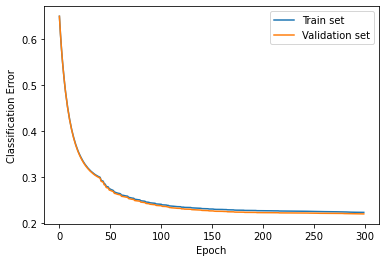

Accuracy: 89 %
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      9870
           1       0.82      0.99      0.90     10125

    accuracy                           0.89     19995
   macro avg       0.91      0.89      0.89     19995
weighted avg       0.91      0.89      0.89     19995



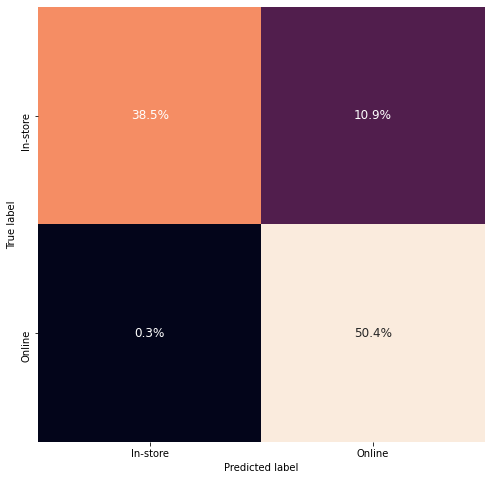

<Figure size 432x288 with 0 Axes>

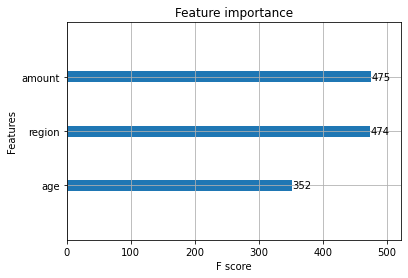

In [69]:
acc, best_est = XGBoost_fit_predict_CV(X_train, X_test, y_train, y_test)

In [84]:
feats_sets = [['age', 'amount_normalized', 'region'],
              ['age_levels_5_mean', 'amount', 'region'], 
              ['age_levels_5_mean', 'amount_levels_5_mean', 'region'], 
              ['age', 'amount_levels_5_mean', 'region'], 
              ['age', 'Region_2', 'Region_3', 'Region_4', 'amount_normalized'], 
              ['age_levels_5_mean', 'Region_2', 'Region_3', 'Region_4', 'amount'], 
              ['age_levels_5_mean', 'Region_2', 'Region_3', 'Region_4', 'amount_levels_5_mean']]
results_feats = {}


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[00:00:28] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:00:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.66909	validation_1-logloss:0.66968
[1]	validation_0-logloss:0.64855	validation_1-logloss:0.64969
[2]	validation_0-logloss:0.60461	validation_1-logloss:0.60537
[3]	validation_0-logloss:0.57306	validation_1-logloss:0.57393
[4]	validation_0-logloss:0.54576	validation_1-logloss:0.54664
[5]	validation_0-logloss:0.52181	validation_1-loglo

[120]	validation_0-logloss:0.21811	validation_1-logloss:0.22345
[121]	validation_0-logloss:0.21803	validation_1-logloss:0.22335
[122]	validation_0-logloss:0.21792	validation_1-logloss:0.22331
[123]	validation_0-logloss:0.21787	validation_1-logloss:0.22332
[124]	validation_0-logloss:0.21784	validation_1-logloss:0.22332
[125]	validation_0-logloss:0.21774	validation_1-logloss:0.22328
[126]	validation_0-logloss:0.21766	validation_1-logloss:0.22319
[127]	validation_0-logloss:0.21757	validation_1-logloss:0.22312
[128]	validation_0-logloss:0.21754	validation_1-logloss:0.22313
[129]	validation_0-logloss:0.21742	validation_1-logloss:0.22310
[130]	validation_0-logloss:0.21735	validation_1-logloss:0.22303
[131]	validation_0-logloss:0.21718	validation_1-logloss:0.22309
[132]	validation_0-logloss:0.21716	validation_1-logloss:0.22311
[133]	validation_0-logloss:0.21715	validation_1-logloss:0.22309
[134]	validation_0-logloss:0.21713	validation_1-logloss:0.22308
[135]	validation_0-logloss:0.21702	valid

[71]	validation_0-logloss:0.22915	validation_1-logloss:0.23223
[72]	validation_0-logloss:0.22846	validation_1-logloss:0.23149
[73]	validation_0-logloss:0.22778	validation_1-logloss:0.23088
[74]	validation_0-logloss:0.22762	validation_1-logloss:0.23082
[75]	validation_0-logloss:0.22750	validation_1-logloss:0.23078
[76]	validation_0-logloss:0.22692	validation_1-logloss:0.23022
[77]	validation_0-logloss:0.22677	validation_1-logloss:0.23019
[78]	validation_0-logloss:0.22619	validation_1-logloss:0.22957
[79]	validation_0-logloss:0.22604	validation_1-logloss:0.22953
[80]	validation_0-logloss:0.22553	validation_1-logloss:0.22905
[81]	validation_0-logloss:0.22546	validation_1-logloss:0.22906
[82]	validation_0-logloss:0.22501	validation_1-logloss:0.22868
[83]	validation_0-logloss:0.22457	validation_1-logloss:0.22829
[84]	validation_0-logloss:0.22412	validation_1-logloss:0.22780
[85]	validation_0-logloss:0.22406	validation_1-logloss:0.22782
[86]	validation_0-logloss:0.22363	validation_1-logloss:

[28]	validation_0-logloss:0.28875	validation_1-logloss:0.28972
[29]	validation_0-logloss:0.28377	validation_1-logloss:0.28470
[30]	validation_0-logloss:0.28244	validation_1-logloss:0.28345
[31]	validation_0-logloss:0.27792	validation_1-logloss:0.27900
[32]	validation_0-logloss:0.27384	validation_1-logloss:0.27494
[33]	validation_0-logloss:0.27016	validation_1-logloss:0.27121
[34]	validation_0-logloss:0.26675	validation_1-logloss:0.26792
[35]	validation_0-logloss:0.26584	validation_1-logloss:0.26708
[36]	validation_0-logloss:0.26498	validation_1-logloss:0.26634
[37]	validation_0-logloss:0.26196	validation_1-logloss:0.26347
[38]	validation_0-logloss:0.25920	validation_1-logloss:0.26065
[39]	validation_0-logloss:0.25848	validation_1-logloss:0.26007
[40]	validation_0-logloss:0.25780	validation_1-logloss:0.25945
[41]	validation_0-logloss:0.25527	validation_1-logloss:0.25704
[42]	validation_0-logloss:0.25474	validation_1-logloss:0.25659
[43]	validation_0-logloss:0.25423	validation_1-logloss:

[158]	validation_0-logloss:0.21578	validation_1-logloss:0.22364
[159]	validation_0-logloss:0.21577	validation_1-logloss:0.22364
[160]	validation_0-logloss:0.21576	validation_1-logloss:0.22363
[161]	validation_0-logloss:0.21574	validation_1-logloss:0.22362
[162]	validation_0-logloss:0.21568	validation_1-logloss:0.22359
[163]	validation_0-logloss:0.21565	validation_1-logloss:0.22359
[164]	validation_0-logloss:0.21564	validation_1-logloss:0.22359
[165]	validation_0-logloss:0.21564	validation_1-logloss:0.22358
[166]	validation_0-logloss:0.21562	validation_1-logloss:0.22356
[167]	validation_0-logloss:0.21560	validation_1-logloss:0.22355
[168]	validation_0-logloss:0.21559	validation_1-logloss:0.22356
[169]	validation_0-logloss:0.21558	validation_1-logloss:0.22354
[170]	validation_0-logloss:0.21558	validation_1-logloss:0.22354
[171]	validation_0-logloss:0.21557	validation_1-logloss:0.22354
[172]	validation_0-logloss:0.21556	validation_1-logloss:0.22355
[173]	validation_0-logloss:0.21553	valid

[102]	validation_0-logloss:0.22004	validation_1-logloss:0.22498
[103]	validation_0-logloss:0.21985	validation_1-logloss:0.22478
[104]	validation_0-logloss:0.21968	validation_1-logloss:0.22459
[105]	validation_0-logloss:0.21957	validation_1-logloss:0.22458
[106]	validation_0-logloss:0.21940	validation_1-logloss:0.22449
[107]	validation_0-logloss:0.21930	validation_1-logloss:0.22440
[108]	validation_0-logloss:0.21912	validation_1-logloss:0.22429
[109]	validation_0-logloss:0.21900	validation_1-logloss:0.22424
[110]	validation_0-logloss:0.21895	validation_1-logloss:0.22421
[111]	validation_0-logloss:0.21891	validation_1-logloss:0.22419
[112]	validation_0-logloss:0.21881	validation_1-logloss:0.22414
[113]	validation_0-logloss:0.21868	validation_1-logloss:0.22399
[114]	validation_0-logloss:0.21851	validation_1-logloss:0.22393
[115]	validation_0-logloss:0.21839	validation_1-logloss:0.22379
[116]	validation_0-logloss:0.21837	validation_1-logloss:0.22377
[117]	validation_0-logloss:0.21825	valid

[49]	validation_0-logloss:0.24647	validation_1-logloss:0.24887
[50]	validation_0-logloss:0.24471	validation_1-logloss:0.24717
[51]	validation_0-logloss:0.24305	validation_1-logloss:0.24559
[52]	validation_0-logloss:0.24278	validation_1-logloss:0.24539
[53]	validation_0-logloss:0.24124	validation_1-logloss:0.24394
[54]	validation_0-logloss:0.24093	validation_1-logloss:0.24383
[55]	validation_0-logloss:0.24066	validation_1-logloss:0.24367
[56]	validation_0-logloss:0.24044	validation_1-logloss:0.24355
[57]	validation_0-logloss:0.23896	validation_1-logloss:0.24201
[58]	validation_0-logloss:0.23870	validation_1-logloss:0.24185
[59]	validation_0-logloss:0.23738	validation_1-logloss:0.24046
[60]	validation_0-logloss:0.23615	validation_1-logloss:0.23920
[61]	validation_0-logloss:0.23593	validation_1-logloss:0.23911
[62]	validation_0-logloss:0.23481	validation_1-logloss:0.23793
[63]	validation_0-logloss:0.23462	validation_1-logloss:0.23783
[64]	validation_0-logloss:0.23356	validation_1-logloss:

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[CV 3/5] END colsample_bytree=2.0, gamma=0.5, max_depth=3, min_child_weight=1;, score=nan total time=   0.0s
[CV 4/5] END colsample_bytree=2.0, gamma=0.5, max_depth=3, min_child_weight=1;, score=nan total time=   0.0s
[CV 5/5] END colsample_bytree=2.0, gamma=0.5, max_depth=3, min_child_weight=1;, score=nan total time=   0.0s
[00:01:12] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:12] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.68742	validation_1-logloss:0.68721
[1]	validation_0-logloss:0.67004	

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[4]	validation_0-logloss:0.60447	validation_1-logloss:0.60460
[5]	validation_0-logloss:0.60129	validation_1-logloss:0.60130
[6]	validation_0-logloss:0.58877	validation_1-logloss:0.58890
[7]	validation_0-logloss:0.56547	validation_1-logloss:0.56563
[8]	validation_0-logloss:0.56299	validation_1-logloss:0.56312
[9]	validation_0-logloss:0.54283	validation_1-logloss:0.54297
[10]	validation_0-logloss:0.53331	validation_1-logloss:0.53347
[11]	validation_0-logloss:0.51587	validation_1-logloss:0.51609
[12]	validation_0-logloss:0.50042	validation_1-logloss:0.50068
[13]	validation_0-logloss:0.49294	validation_1-logloss:0.49314
[14]	validation_0-logloss:0.47937	validation_1-logloss:0.47964
[15]	validation_0-logloss:0.47789	validation_1-logloss:0.47810
[16]	validation_0-logloss:0.46582	validation_1-logloss:0.46609
[17]	validation_0-logloss:0.45975	validation_1-logloss:0.45998
[18]	validation_0-logloss:0.45438	validation_1-logloss:0.45459
[19]	validation_0-logloss:0.44394	validation_1-logloss:0.4440

[134]	validation_0-logloss:0.28536	validation_1-logloss:0.28557
[135]	validation_0-logloss:0.28518	validation_1-logloss:0.28540
[136]	validation_0-logloss:0.28516	validation_1-logloss:0.28539
[137]	validation_0-logloss:0.28451	validation_1-logloss:0.28472
[138]	validation_0-logloss:0.28449	validation_1-logloss:0.28471
[139]	validation_0-logloss:0.28390	validation_1-logloss:0.28409
[140]	validation_0-logloss:0.28331	validation_1-logloss:0.28352
[141]	validation_0-logloss:0.28284	validation_1-logloss:0.28299
[142]	validation_0-logloss:0.28258	validation_1-logloss:0.28276
[143]	validation_0-logloss:0.28211	validation_1-logloss:0.28227
[144]	validation_0-logloss:0.28207	validation_1-logloss:0.28225
[145]	validation_0-logloss:0.28204	validation_1-logloss:0.28223
[146]	validation_0-logloss:0.28156	validation_1-logloss:0.28177
[147]	validation_0-logloss:0.28116	validation_1-logloss:0.28135
[148]	validation_0-logloss:0.28110	validation_1-logloss:0.28133
[149]	validation_0-logloss:0.28074	valid

[263]	validation_0-logloss:0.27065	validation_1-logloss:0.27190
[264]	validation_0-logloss:0.27062	validation_1-logloss:0.27191
[265]	validation_0-logloss:0.27060	validation_1-logloss:0.27190
[266]	validation_0-logloss:0.27057	validation_1-logloss:0.27186
[267]	validation_0-logloss:0.27055	validation_1-logloss:0.27185
[268]	validation_0-logloss:0.27052	validation_1-logloss:0.27185
[269]	validation_0-logloss:0.27051	validation_1-logloss:0.27185
[270]	validation_0-logloss:0.27047	validation_1-logloss:0.27182
[271]	validation_0-logloss:0.27046	validation_1-logloss:0.27181
[272]	validation_0-logloss:0.27043	validation_1-logloss:0.27182
[273]	validation_0-logloss:0.27042	validation_1-logloss:0.27184
[274]	validation_0-logloss:0.27034	validation_1-logloss:0.27176
[275]	validation_0-logloss:0.27031	validation_1-logloss:0.27173
[276]	validation_0-logloss:0.27031	validation_1-logloss:0.27172
[277]	validation_0-logloss:0.27030	validation_1-logloss:0.27172
[278]	validation_0-logloss:0.27029	valid

[82]	validation_0-logloss:0.30678	validation_1-logloss:0.30660
[83]	validation_0-logloss:0.30626	validation_1-logloss:0.30612
[84]	validation_0-logloss:0.30478	validation_1-logloss:0.30457
[85]	validation_0-logloss:0.30457	validation_1-logloss:0.30440
[86]	validation_0-logloss:0.30317	validation_1-logloss:0.30297
[87]	validation_0-logloss:0.30296	validation_1-logloss:0.30283
[88]	validation_0-logloss:0.30169	validation_1-logloss:0.30150
[89]	validation_0-logloss:0.30152	validation_1-logloss:0.30135
[90]	validation_0-logloss:0.30136	validation_1-logloss:0.30129
[91]	validation_0-logloss:0.30126	validation_1-logloss:0.30121
[92]	validation_0-logloss:0.30072	validation_1-logloss:0.30072
[93]	validation_0-logloss:0.29950	validation_1-logloss:0.29946
[94]	validation_0-logloss:0.29900	validation_1-logloss:0.29897
[95]	validation_0-logloss:0.29855	validation_1-logloss:0.29856
[96]	validation_0-logloss:0.29844	validation_1-logloss:0.29851
[97]	validation_0-logloss:0.29729	validation_1-logloss:

[211]	validation_0-logloss:0.27301	validation_1-logloss:0.27402
[212]	validation_0-logloss:0.27297	validation_1-logloss:0.27402
[213]	validation_0-logloss:0.27295	validation_1-logloss:0.27401
[214]	validation_0-logloss:0.27292	validation_1-logloss:0.27401
[215]	validation_0-logloss:0.27276	validation_1-logloss:0.27384
[216]	validation_0-logloss:0.27273	validation_1-logloss:0.27383
[217]	validation_0-logloss:0.27271	validation_1-logloss:0.27383
[218]	validation_0-logloss:0.27257	validation_1-logloss:0.27367
[219]	validation_0-logloss:0.27245	validation_1-logloss:0.27353
[220]	validation_0-logloss:0.27244	validation_1-logloss:0.27351
[221]	validation_0-logloss:0.27242	validation_1-logloss:0.27349
[222]	validation_0-logloss:0.27239	validation_1-logloss:0.27349
[223]	validation_0-logloss:0.27231	validation_1-logloss:0.27343
[224]	validation_0-logloss:0.27229	validation_1-logloss:0.27341
[225]	validation_0-logloss:0.27227	validation_1-logloss:0.27343
[226]	validation_0-logloss:0.27226	valid

[29]	validation_0-logloss:0.38982	validation_1-logloss:0.38988
[30]	validation_0-logloss:0.38721	validation_1-logloss:0.38723
[31]	validation_0-logloss:0.38484	validation_1-logloss:0.38484
[32]	validation_0-logloss:0.37924	validation_1-logloss:0.37924
[33]	validation_0-logloss:0.37416	validation_1-logloss:0.37413
[34]	validation_0-logloss:0.37208	validation_1-logloss:0.37199
[35]	validation_0-logloss:0.37022	validation_1-logloss:0.37006
[36]	validation_0-logloss:0.36849	validation_1-logloss:0.36831
[37]	validation_0-logloss:0.36385	validation_1-logloss:0.36363
[38]	validation_0-logloss:0.36294	validation_1-logloss:0.36282
[39]	validation_0-logloss:0.36215	validation_1-logloss:0.36209
[40]	validation_0-logloss:0.36148	validation_1-logloss:0.36148
[41]	validation_0-logloss:0.35726	validation_1-logloss:0.35724
[42]	validation_0-logloss:0.35569	validation_1-logloss:0.35561
[43]	validation_0-logloss:0.35423	validation_1-logloss:0.35413
[44]	validation_0-logloss:0.35365	validation_1-logloss:

[159]	validation_0-logloss:0.27847	validation_1-logloss:0.27875
[160]	validation_0-logloss:0.27842	validation_1-logloss:0.27872
[161]	validation_0-logloss:0.27808	validation_1-logloss:0.27843
[162]	validation_0-logloss:0.27794	validation_1-logloss:0.27828
[163]	validation_0-logloss:0.27767	validation_1-logloss:0.27801
[164]	validation_0-logloss:0.27761	validation_1-logloss:0.27796
[165]	validation_0-logloss:0.27755	validation_1-logloss:0.27792
[166]	validation_0-logloss:0.27751	validation_1-logloss:0.27789
[167]	validation_0-logloss:0.27725	validation_1-logloss:0.27763
[168]	validation_0-logloss:0.27707	validation_1-logloss:0.27746
[169]	validation_0-logloss:0.27683	validation_1-logloss:0.27721
[170]	validation_0-logloss:0.27669	validation_1-logloss:0.27708
[171]	validation_0-logloss:0.27664	validation_1-logloss:0.27704
[172]	validation_0-logloss:0.27651	validation_1-logloss:0.27692
[173]	validation_0-logloss:0.27638	validation_1-logloss:0.27682
[174]	validation_0-logloss:0.27617	valid

[288]	validation_0-logloss:0.27026	validation_1-logloss:0.27143
[289]	validation_0-logloss:0.27024	validation_1-logloss:0.27141
[290]	validation_0-logloss:0.27022	validation_1-logloss:0.27140
[291]	validation_0-logloss:0.27021	validation_1-logloss:0.27139
[292]	validation_0-logloss:0.27021	validation_1-logloss:0.27139
[293]	validation_0-logloss:0.27020	validation_1-logloss:0.27139
[294]	validation_0-logloss:0.27020	validation_1-logloss:0.27139
[295]	validation_0-logloss:0.27019	validation_1-logloss:0.27138
[296]	validation_0-logloss:0.27017	validation_1-logloss:0.27137
[297]	validation_0-logloss:0.27015	validation_1-logloss:0.27136
[298]	validation_0-logloss:0.27015	validation_1-logloss:0.27136
[299]	validation_0-logloss:0.27008	validation_1-logloss:0.27130
[CV 3/5] END colsample_bytree=0.6, gamma=2, max_depth=4, min_child_weight=10;, score=0.942 total time=  14.7s
[00:01:56] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to s

[107]	validation_0-logloss:0.29379	validation_1-logloss:0.29413
[108]	validation_0-logloss:0.29342	validation_1-logloss:0.29379
[109]	validation_0-logloss:0.29246	validation_1-logloss:0.29279
[110]	validation_0-logloss:0.29212	validation_1-logloss:0.29245
[111]	validation_0-logloss:0.29206	validation_1-logloss:0.29244
[112]	validation_0-logloss:0.29114	validation_1-logloss:0.29150
[113]	validation_0-logloss:0.29109	validation_1-logloss:0.29148
[114]	validation_0-logloss:0.29025	validation_1-logloss:0.29061
[115]	validation_0-logloss:0.29019	validation_1-logloss:0.29058
[116]	validation_0-logloss:0.28985	validation_1-logloss:0.29026
[117]	validation_0-logloss:0.28907	validation_1-logloss:0.28944
[118]	validation_0-logloss:0.28899	validation_1-logloss:0.28943
[119]	validation_0-logloss:0.28895	validation_1-logloss:0.28940
[120]	validation_0-logloss:0.28892	validation_1-logloss:0.28940
[121]	validation_0-logloss:0.28818	validation_1-logloss:0.28863
[122]	validation_0-logloss:0.28747	valid

[236]	validation_0-logloss:0.27174	validation_1-logloss:0.27296
[237]	validation_0-logloss:0.27162	validation_1-logloss:0.27284
[238]	validation_0-logloss:0.27162	validation_1-logloss:0.27283
[239]	validation_0-logloss:0.27159	validation_1-logloss:0.27282
[240]	validation_0-logloss:0.27154	validation_1-logloss:0.27276
[241]	validation_0-logloss:0.27149	validation_1-logloss:0.27271
[242]	validation_0-logloss:0.27139	validation_1-logloss:0.27260
[243]	validation_0-logloss:0.27137	validation_1-logloss:0.27258
[244]	validation_0-logloss:0.27132	validation_1-logloss:0.27253
[245]	validation_0-logloss:0.27130	validation_1-logloss:0.27252
[246]	validation_0-logloss:0.27128	validation_1-logloss:0.27252
[247]	validation_0-logloss:0.27118	validation_1-logloss:0.27241
[248]	validation_0-logloss:0.27116	validation_1-logloss:0.27240
[249]	validation_0-logloss:0.27112	validation_1-logloss:0.27236
[250]	validation_0-logloss:0.27110	validation_1-logloss:0.27235
[251]	validation_0-logloss:0.27108	valid

[55]	validation_0-logloss:0.34139	validation_1-logloss:0.34110
[56]	validation_0-logloss:0.34102	validation_1-logloss:0.34077
[57]	validation_0-logloss:0.33740	validation_1-logloss:0.33709
[58]	validation_0-logloss:0.33670	validation_1-logloss:0.33638
[59]	validation_0-logloss:0.33637	validation_1-logloss:0.33609
[60]	validation_0-logloss:0.33302	validation_1-logloss:0.33271
[61]	validation_0-logloss:0.33240	validation_1-logloss:0.33205
[62]	validation_0-logloss:0.32931	validation_1-logloss:0.32895
[63]	validation_0-logloss:0.32902	validation_1-logloss:0.32869
[64]	validation_0-logloss:0.32623	validation_1-logloss:0.32585
[65]	validation_0-logloss:0.32558	validation_1-logloss:0.32520
[66]	validation_0-logloss:0.32499	validation_1-logloss:0.32461
[67]	validation_0-logloss:0.32238	validation_1-logloss:0.32196
[68]	validation_0-logloss:0.32183	validation_1-logloss:0.32138
[69]	validation_0-logloss:0.32132	validation_1-logloss:0.32086
[70]	validation_0-logloss:0.31890	validation_1-logloss:

[184]	validation_0-logloss:0.27493	validation_1-logloss:0.27570
[185]	validation_0-logloss:0.27474	validation_1-logloss:0.27548
[186]	validation_0-logloss:0.27465	validation_1-logloss:0.27542
[187]	validation_0-logloss:0.27443	validation_1-logloss:0.27522
[188]	validation_0-logloss:0.27439	validation_1-logloss:0.27520
[189]	validation_0-logloss:0.27434	validation_1-logloss:0.27519
[190]	validation_0-logloss:0.27430	validation_1-logloss:0.27516
[191]	validation_0-logloss:0.27426	validation_1-logloss:0.27515
[192]	validation_0-logloss:0.27409	validation_1-logloss:0.27495
[193]	validation_0-logloss:0.27402	validation_1-logloss:0.27489
[194]	validation_0-logloss:0.27397	validation_1-logloss:0.27486
[195]	validation_0-logloss:0.27389	validation_1-logloss:0.27486
[196]	validation_0-logloss:0.27387	validation_1-logloss:0.27485
[197]	validation_0-logloss:0.27381	validation_1-logloss:0.27481
[198]	validation_0-logloss:0.27363	validation_1-logloss:0.27461
[199]	validation_0-logloss:0.27359	valid

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[CV 3/5] END colsample_bytree=2.0, gamma=1, max_depth=6, min_child_weight=5;, score=nan total time=   0.0s
[CV 4/5] END colsample_bytree=2.0, gamma=1, max_depth=6, min_child_weight=5;, score=nan total time=   0.0s
[CV 5/5] END colsample_bytree=2.0, gamma=1, max_depth=6, min_child_weight=5;, score=nan total time=   0.0s
[00:02:25] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.66945	validation_1-logloss:0.66965


C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[1]	validation_0-logloss:0.64907	validation_1-logloss:0.64962
[2]	validation_0-logloss:0.60515	validation_1-logloss:0.60530
[3]	validation_0-logloss:0.57374	validation_1-logloss:0.57391
[4]	validation_0-logloss:0.54637	validation_1-logloss:0.54670
[5]	validation_0-logloss:0.52247	validation_1-logloss:0.52279
[6]	validation_0-logloss:0.51069	validation_1-logloss:0.51114
[7]	validation_0-logloss:0.49040	validation_1-logloss:0.49080
[8]	validation_0-logloss:0.48084	validation_1-logloss:0.48122
[9]	validation_0-logloss:0.46347	validation_1-logloss:0.46377
[10]	validation_0-logloss:0.45555	validation_1-logloss:0.45583
[11]	validation_0-logloss:0.43445	validation_1-logloss:0.43443
[12]	validation_0-logloss:0.42074	validation_1-logloss:0.42071
[13]	validation_0-logloss:0.40329	validation_1-logloss:0.40303
[14]	validation_0-logloss:0.38780	validation_1-logloss:0.38719
[15]	validation_0-logloss:0.38309	validation_1-logloss:0.38248
[16]	validation_0-logloss:0.37307	validation_1-logloss:0.37245
[

[131]	validation_0-logloss:0.22217	validation_1-logloss:0.22165
[132]	validation_0-logloss:0.22216	validation_1-logloss:0.22166
[133]	validation_0-logloss:0.22210	validation_1-logloss:0.22160
[134]	validation_0-logloss:0.22207	validation_1-logloss:0.22160
[135]	validation_0-logloss:0.22190	validation_1-logloss:0.22159
[136]	validation_0-logloss:0.22185	validation_1-logloss:0.22154
[137]	validation_0-logloss:0.22178	validation_1-logloss:0.22154
[138]	validation_0-logloss:0.22170	validation_1-logloss:0.22157
[139]	validation_0-logloss:0.22161	validation_1-logloss:0.22150
[140]	validation_0-logloss:0.22156	validation_1-logloss:0.22143
[141]	validation_0-logloss:0.22155	validation_1-logloss:0.22142
[142]	validation_0-logloss:0.22149	validation_1-logloss:0.22142
[143]	validation_0-logloss:0.22148	validation_1-logloss:0.22143
[144]	validation_0-logloss:0.22134	validation_1-logloss:0.22153
[145]	validation_0-logloss:0.22134	validation_1-logloss:0.22153
[146]	validation_0-logloss:0.22130	valid

[89]	validation_0-logloss:0.22674	validation_1-logloss:0.22591
[90]	validation_0-logloss:0.22637	validation_1-logloss:0.22552
[91]	validation_0-logloss:0.22605	validation_1-logloss:0.22517
[92]	validation_0-logloss:0.22576	validation_1-logloss:0.22495
[93]	validation_0-logloss:0.22546	validation_1-logloss:0.22463
[94]	validation_0-logloss:0.22530	validation_1-logloss:0.22451
[95]	validation_0-logloss:0.22527	validation_1-logloss:0.22449
[96]	validation_0-logloss:0.22499	validation_1-logloss:0.22421
[97]	validation_0-logloss:0.22476	validation_1-logloss:0.22398
[98]	validation_0-logloss:0.22474	validation_1-logloss:0.22398
[99]	validation_0-logloss:0.22465	validation_1-logloss:0.22400
[100]	validation_0-logloss:0.22444	validation_1-logloss:0.22375
[101]	validation_0-logloss:0.22438	validation_1-logloss:0.22377
[102]	validation_0-logloss:0.22418	validation_1-logloss:0.22361
[103]	validation_0-logloss:0.22398	validation_1-logloss:0.22339
[104]	validation_0-logloss:0.22380	validation_1-log

[20]	validation_0-logloss:0.32957	validation_1-logloss:0.32862
[21]	validation_0-logloss:0.32123	validation_1-logloss:0.32015
[22]	validation_0-logloss:0.31877	validation_1-logloss:0.31771
[23]	validation_0-logloss:0.31662	validation_1-logloss:0.31550
[24]	validation_0-logloss:0.31079	validation_1-logloss:0.30966
[25]	validation_0-logloss:0.30405	validation_1-logloss:0.30281
[26]	validation_0-logloss:0.30230	validation_1-logloss:0.30105
[27]	validation_0-logloss:0.29634	validation_1-logloss:0.29499
[28]	validation_0-logloss:0.29092	validation_1-logloss:0.28948
[29]	validation_0-logloss:0.28602	validation_1-logloss:0.28446
[30]	validation_0-logloss:0.28475	validation_1-logloss:0.28322
[31]	validation_0-logloss:0.28034	validation_1-logloss:0.27876
[32]	validation_0-logloss:0.27633	validation_1-logloss:0.27470
[33]	validation_0-logloss:0.27268	validation_1-logloss:0.27099
[34]	validation_0-logloss:0.26932	validation_1-logloss:0.26760
[35]	validation_0-logloss:0.26845	validation_1-logloss:

[150]	validation_0-logloss:0.22144	validation_1-logloss:0.22185
[151]	validation_0-logloss:0.22140	validation_1-logloss:0.22180
[152]	validation_0-logloss:0.22127	validation_1-logloss:0.22183
[153]	validation_0-logloss:0.22127	validation_1-logloss:0.22182
[154]	validation_0-logloss:0.22126	validation_1-logloss:0.22181
[155]	validation_0-logloss:0.22121	validation_1-logloss:0.22176
[156]	validation_0-logloss:0.22119	validation_1-logloss:0.22174
[157]	validation_0-logloss:0.22116	validation_1-logloss:0.22173
[158]	validation_0-logloss:0.22116	validation_1-logloss:0.22173
[159]	validation_0-logloss:0.22116	validation_1-logloss:0.22173
[160]	validation_0-logloss:0.22116	validation_1-logloss:0.22173
[161]	validation_0-logloss:0.22116	validation_1-logloss:0.22173
[162]	validation_0-logloss:0.22116	validation_1-logloss:0.22173
[163]	validation_0-logloss:0.22116	validation_1-logloss:0.22173
[164]	validation_0-logloss:0.22116	validation_1-logloss:0.22173
[165]	validation_0-logloss:0.22116	valid

[92]	validation_0-logloss:0.22566	validation_1-logloss:0.22496
[93]	validation_0-logloss:0.22539	validation_1-logloss:0.22465
[94]	validation_0-logloss:0.22513	validation_1-logloss:0.22443
[95]	validation_0-logloss:0.22503	validation_1-logloss:0.22444
[96]	validation_0-logloss:0.22477	validation_1-logloss:0.22416
[97]	validation_0-logloss:0.22453	validation_1-logloss:0.22391
[98]	validation_0-logloss:0.22450	validation_1-logloss:0.22391
[99]	validation_0-logloss:0.22445	validation_1-logloss:0.22389
[100]	validation_0-logloss:0.22433	validation_1-logloss:0.22374
[101]	validation_0-logloss:0.22423	validation_1-logloss:0.22371
[102]	validation_0-logloss:0.22409	validation_1-logloss:0.22365
[103]	validation_0-logloss:0.22390	validation_1-logloss:0.22343
[104]	validation_0-logloss:0.22371	validation_1-logloss:0.22324
[105]	validation_0-logloss:0.22368	validation_1-logloss:0.22326
[106]	validation_0-logloss:0.22356	validation_1-logloss:0.22319
[107]	validation_0-logloss:0.22346	validation_1-

[25]	validation_0-logloss:0.30386	validation_1-logloss:0.30246
[26]	validation_0-logloss:0.30205	validation_1-logloss:0.30069
[27]	validation_0-logloss:0.29607	validation_1-logloss:0.29460
[28]	validation_0-logloss:0.29067	validation_1-logloss:0.28909
[29]	validation_0-logloss:0.28570	validation_1-logloss:0.28409
[30]	validation_0-logloss:0.28444	validation_1-logloss:0.28287
[31]	validation_0-logloss:0.28004	validation_1-logloss:0.27840
[32]	validation_0-logloss:0.27600	validation_1-logloss:0.27433
[33]	validation_0-logloss:0.27235	validation_1-logloss:0.27061
[34]	validation_0-logloss:0.26897	validation_1-logloss:0.26722
[35]	validation_0-logloss:0.26809	validation_1-logloss:0.26638
[36]	validation_0-logloss:0.26731	validation_1-logloss:0.26561
[37]	validation_0-logloss:0.26433	validation_1-logloss:0.26263
[38]	validation_0-logloss:0.26155	validation_1-logloss:0.25981
[39]	validation_0-logloss:0.26093	validation_1-logloss:0.25921
[40]	validation_0-logloss:0.26030	validation_1-logloss:

[155]	validation_0-logloss:0.22107	validation_1-logloss:0.22162
[156]	validation_0-logloss:0.22107	validation_1-logloss:0.22162
[157]	validation_0-logloss:0.22107	validation_1-logloss:0.22162
[158]	validation_0-logloss:0.22107	validation_1-logloss:0.22162
[159]	validation_0-logloss:0.22107	validation_1-logloss:0.22162
[160]	validation_0-logloss:0.22107	validation_1-logloss:0.22162
[161]	validation_0-logloss:0.22107	validation_1-logloss:0.22162
[162]	validation_0-logloss:0.22107	validation_1-logloss:0.22162
[163]	validation_0-logloss:0.22107	validation_1-logloss:0.22162
[164]	validation_0-logloss:0.22107	validation_1-logloss:0.22162
[165]	validation_0-logloss:0.22107	validation_1-logloss:0.22162
[166]	validation_0-logloss:0.22107	validation_1-logloss:0.22162
[167]	validation_0-logloss:0.22107	validation_1-logloss:0.22162
[168]	validation_0-logloss:0.22107	validation_1-logloss:0.22162
[169]	validation_0-logloss:0.22107	validation_1-logloss:0.22162
[170]	validation_0-logloss:0.22107	valid

[103]	validation_0-logloss:0.22810	validation_1-logloss:0.22467
[104]	validation_0-logloss:0.22799	validation_1-logloss:0.22469
[105]	validation_0-logloss:0.22799	validation_1-logloss:0.22466
[106]	validation_0-logloss:0.22798	validation_1-logloss:0.22466
[107]	validation_0-logloss:0.22796	validation_1-logloss:0.22464
[108]	validation_0-logloss:0.22784	validation_1-logloss:0.22459
[109]	validation_0-logloss:0.22740	validation_1-logloss:0.22407
[110]	validation_0-logloss:0.22736	validation_1-logloss:0.22405
[111]	validation_0-logloss:0.22732	validation_1-logloss:0.22403
[112]	validation_0-logloss:0.22681	validation_1-logloss:0.22360
[113]	validation_0-logloss:0.22677	validation_1-logloss:0.22364
[114]	validation_0-logloss:0.22675	validation_1-logloss:0.22363
[115]	validation_0-logloss:0.22673	validation_1-logloss:0.22361
[116]	validation_0-logloss:0.22645	validation_1-logloss:0.22326
[117]	validation_0-logloss:0.22604	validation_1-logloss:0.22288
[118]	validation_0-logloss:0.22601	valid

[79]	validation_0-logloss:0.23217	validation_1-logloss:0.22846
[80]	validation_0-logloss:0.23210	validation_1-logloss:0.22838
[81]	validation_0-logloss:0.23204	validation_1-logloss:0.22834
[82]	validation_0-logloss:0.23130	validation_1-logloss:0.22752
[83]	validation_0-logloss:0.23124	validation_1-logloss:0.22746
[84]	validation_0-logloss:0.23119	validation_1-logloss:0.22740
[85]	validation_0-logloss:0.23051	validation_1-logloss:0.22665
[86]	validation_0-logloss:0.23048	validation_1-logloss:0.22661
[87]	validation_0-logloss:0.23038	validation_1-logloss:0.22661
[88]	validation_0-logloss:0.23030	validation_1-logloss:0.22655
[89]	validation_0-logloss:0.22985	validation_1-logloss:0.22597
[90]	validation_0-logloss:0.22955	validation_1-logloss:0.22569
[91]	validation_0-logloss:0.22931	validation_1-logloss:0.22543
[92]	validation_0-logloss:0.22927	validation_1-logloss:0.22538
[93]	validation_0-logloss:0.22922	validation_1-logloss:0.22534
[94]	validation_0-logloss:0.22873	validation_1-logloss:

[45]	validation_0-logloss:0.25012	validation_1-logloss:0.24733
[46]	validation_0-logloss:0.24946	validation_1-logloss:0.24664
[47]	validation_0-logloss:0.24876	validation_1-logloss:0.24603
[48]	validation_0-logloss:0.24671	validation_1-logloss:0.24394
[49]	validation_0-logloss:0.24616	validation_1-logloss:0.24341
[50]	validation_0-logloss:0.24571	validation_1-logloss:0.24290
[51]	validation_0-logloss:0.24522	validation_1-logloss:0.24245
[52]	validation_0-logloss:0.24345	validation_1-logloss:0.24066
[53]	validation_0-logloss:0.24308	validation_1-logloss:0.24025
[54]	validation_0-logloss:0.24260	validation_1-logloss:0.23989
[55]	validation_0-logloss:0.24235	validation_1-logloss:0.23956
[56]	validation_0-logloss:0.24082	validation_1-logloss:0.23802
[57]	validation_0-logloss:0.24056	validation_1-logloss:0.23769
[58]	validation_0-logloss:0.24030	validation_1-logloss:0.23742
[59]	validation_0-logloss:0.23957	validation_1-logloss:0.23677
[60]	validation_0-logloss:0.23943	validation_1-logloss:

[14]	validation_0-logloss:0.35185	validation_1-logloss:0.34887
[15]	validation_0-logloss:0.34378	validation_1-logloss:0.34079
[16]	validation_0-logloss:0.33627	validation_1-logloss:0.33339
[17]	validation_0-logloss:0.32883	validation_1-logloss:0.32574
[18]	validation_0-logloss:0.32272	validation_1-logloss:0.31958
[19]	validation_0-logloss:0.31691	validation_1-logloss:0.31395
[20]	validation_0-logloss:0.31125	validation_1-logloss:0.30827
[21]	validation_0-logloss:0.30647	validation_1-logloss:0.30352
[22]	validation_0-logloss:0.30211	validation_1-logloss:0.29915
[23]	validation_0-logloss:0.29802	validation_1-logloss:0.29516
[24]	validation_0-logloss:0.29431	validation_1-logloss:0.29144
[25]	validation_0-logloss:0.29090	validation_1-logloss:0.28804
[26]	validation_0-logloss:0.28775	validation_1-logloss:0.28488
[27]	validation_0-logloss:0.28491	validation_1-logloss:0.28202
[28]	validation_0-logloss:0.28217	validation_1-logloss:0.27937
[29]	validation_0-logloss:0.27970	validation_1-logloss:

[144]	validation_0-logloss:0.22516	validation_1-logloss:0.22229
[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1;, score=0.994 total time=  14.4s
[00:04:28] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:04:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.64360	validation_1-logloss:0.64296
[1]	validation_0-logloss:0.60094	validation_1-logloss:0.60017
[2]	validation_0-logloss:0.56441	validation_1-logloss:0.56328
[3]	validation_0-logloss:0.53293	validation_1-logloss:0.53121

[118]	validation_0-logloss:0.22578	validation_1-logloss:0.22215
[119]	validation_0-logloss:0.22575	validation_1-logloss:0.22214
[120]	validation_0-logloss:0.22574	validation_1-logloss:0.22212
[121]	validation_0-logloss:0.22556	validation_1-logloss:0.22198
[122]	validation_0-logloss:0.22555	validation_1-logloss:0.22197
[123]	validation_0-logloss:0.22539	validation_1-logloss:0.22184
[124]	validation_0-logloss:0.22523	validation_1-logloss:0.22178
[125]	validation_0-logloss:0.22521	validation_1-logloss:0.22177
[126]	validation_0-logloss:0.22493	validation_1-logloss:0.22151
[127]	validation_0-logloss:0.22492	validation_1-logloss:0.22151
[128]	validation_0-logloss:0.22468	validation_1-logloss:0.22127
[129]	validation_0-logloss:0.22468	validation_1-logloss:0.22127
[130]	validation_0-logloss:0.22468	validation_1-logloss:0.22127
[131]	validation_0-logloss:0.22468	validation_1-logloss:0.22127
[132]	validation_0-logloss:0.22468	validation_1-logloss:0.22127
[133]	validation_0-logloss:0.22468	valid

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[CV 2/5] END colsample_bytree=2.0, gamma=0.3, max_depth=3, min_child_weight=1;, score=nan total time=   0.0s
[CV 3/5] END colsample_bytree=2.0, gamma=0.3, max_depth=3, min_child_weight=1;, score=nan total time=   0.0s
[CV 4/5] END colsample_bytree=2.0, gamma=0.3, max_depth=3, min_child_weight=1;, score=nan total time=   0.0s


C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[CV 5/5] END colsample_bytree=2.0, gamma=0.3, max_depth=3, min_child_weight=1;, score=nan total time=   0.0s
[00:04:40] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:04:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.66928	validation_1-logloss:0.66978
[1]	validation_0-logloss:0.64894	validation_1-logloss:0.64986
[2]	validation_0-logloss:0.60496	validation_1-logloss:0.60550
[3]	validation_0-logloss:0.57341	validation_1-logloss:0.57404
[4]	validation_0-logloss:0.54602	validation_1-logloss:0.54673
[5]

[119]	validation_0-logloss:0.22171	validation_1-logloss:0.22533
[120]	validation_0-logloss:0.22169	validation_1-logloss:0.22532
[121]	validation_0-logloss:0.22169	validation_1-logloss:0.22533
[122]	validation_0-logloss:0.22161	validation_1-logloss:0.22527
[123]	validation_0-logloss:0.22159	validation_1-logloss:0.22530
[124]	validation_0-logloss:0.22157	validation_1-logloss:0.22527
[125]	validation_0-logloss:0.22154	validation_1-logloss:0.22533
[126]	validation_0-logloss:0.22152	validation_1-logloss:0.22533
[127]	validation_0-logloss:0.22152	validation_1-logloss:0.22531
[128]	validation_0-logloss:0.22149	validation_1-logloss:0.22532
[129]	validation_0-logloss:0.22143	validation_1-logloss:0.22527
[130]	validation_0-logloss:0.22142	validation_1-logloss:0.22526
[131]	validation_0-logloss:0.22139	validation_1-logloss:0.22529
[132]	validation_0-logloss:0.22137	validation_1-logloss:0.22529
[133]	validation_0-logloss:0.22135	validation_1-logloss:0.22527
[134]	validation_0-logloss:0.22132	valid

[76]	validation_0-logloss:0.22912	validation_1-logloss:0.23065
[77]	validation_0-logloss:0.22906	validation_1-logloss:0.23064
[78]	validation_0-logloss:0.22847	validation_1-logloss:0.23002
[79]	validation_0-logloss:0.22837	validation_1-logloss:0.23006
[80]	validation_0-logloss:0.22788	validation_1-logloss:0.22965
[81]	validation_0-logloss:0.22781	validation_1-logloss:0.22966
[82]	validation_0-logloss:0.22736	validation_1-logloss:0.22929
[83]	validation_0-logloss:0.22695	validation_1-logloss:0.22892
[84]	validation_0-logloss:0.22646	validation_1-logloss:0.22842
[85]	validation_0-logloss:0.22642	validation_1-logloss:0.22840
[86]	validation_0-logloss:0.22607	validation_1-logloss:0.22808
[87]	validation_0-logloss:0.22564	validation_1-logloss:0.22762
[88]	validation_0-logloss:0.22534	validation_1-logloss:0.22737
[89]	validation_0-logloss:0.22529	validation_1-logloss:0.22735
[90]	validation_0-logloss:0.22492	validation_1-logloss:0.22696
[91]	validation_0-logloss:0.22463	validation_1-logloss:

[7]	validation_0-logloss:0.49019	validation_1-logloss:0.49112
[8]	validation_0-logloss:0.48060	validation_1-logloss:0.48167
[9]	validation_0-logloss:0.46314	validation_1-logloss:0.46416
[10]	validation_0-logloss:0.45517	validation_1-logloss:0.45637
[11]	validation_0-logloss:0.43396	validation_1-logloss:0.43489
[12]	validation_0-logloss:0.42025	validation_1-logloss:0.42115
[13]	validation_0-logloss:0.40276	validation_1-logloss:0.40341
[14]	validation_0-logloss:0.38712	validation_1-logloss:0.38762
[15]	validation_0-logloss:0.38234	validation_1-logloss:0.38290
[16]	validation_0-logloss:0.37235	validation_1-logloss:0.37285
[17]	validation_0-logloss:0.35969	validation_1-logloss:0.36004
[18]	validation_0-logloss:0.34831	validation_1-logloss:0.34860
[19]	validation_0-logloss:0.33809	validation_1-logloss:0.33821
[20]	validation_0-logloss:0.32886	validation_1-logloss:0.32881
[21]	validation_0-logloss:0.32051	validation_1-logloss:0.32036
[22]	validation_0-logloss:0.31798	validation_1-logloss:0.3

[137]	validation_0-logloss:0.22085	validation_1-logloss:0.22447
[138]	validation_0-logloss:0.22083	validation_1-logloss:0.22449
[139]	validation_0-logloss:0.22080	validation_1-logloss:0.22453
[140]	validation_0-logloss:0.22077	validation_1-logloss:0.22449
[141]	validation_0-logloss:0.22077	validation_1-logloss:0.22448
[142]	validation_0-logloss:0.22075	validation_1-logloss:0.22451
[143]	validation_0-logloss:0.22073	validation_1-logloss:0.22452
[144]	validation_0-logloss:0.22071	validation_1-logloss:0.22453
[145]	validation_0-logloss:0.22071	validation_1-logloss:0.22452
[146]	validation_0-logloss:0.22070	validation_1-logloss:0.22451
[147]	validation_0-logloss:0.22066	validation_1-logloss:0.22451
[148]	validation_0-logloss:0.22065	validation_1-logloss:0.22451
[149]	validation_0-logloss:0.22058	validation_1-logloss:0.22444
[150]	validation_0-logloss:0.22057	validation_1-logloss:0.22444
[151]	validation_0-logloss:0.22055	validation_1-logloss:0.22442
[152]	validation_0-logloss:0.22047	valid

[81]	validation_0-logloss:0.22776	validation_1-logloss:0.23011
[82]	validation_0-logloss:0.22730	validation_1-logloss:0.22973
[83]	validation_0-logloss:0.22690	validation_1-logloss:0.22939
[84]	validation_0-logloss:0.22641	validation_1-logloss:0.22889
[85]	validation_0-logloss:0.22635	validation_1-logloss:0.22894
[86]	validation_0-logloss:0.22600	validation_1-logloss:0.22866
[87]	validation_0-logloss:0.22558	validation_1-logloss:0.22824
[88]	validation_0-logloss:0.22527	validation_1-logloss:0.22799
[89]	validation_0-logloss:0.22523	validation_1-logloss:0.22797
[90]	validation_0-logloss:0.22486	validation_1-logloss:0.22758
[91]	validation_0-logloss:0.22452	validation_1-logloss:0.22724
[92]	validation_0-logloss:0.22426	validation_1-logloss:0.22702
[93]	validation_0-logloss:0.22402	validation_1-logloss:0.22677
[94]	validation_0-logloss:0.22379	validation_1-logloss:0.22658
[95]	validation_0-logloss:0.22375	validation_1-logloss:0.22659
[96]	validation_0-logloss:0.22352	validation_1-logloss:

[21]	validation_0-logloss:0.32017	validation_1-logloss:0.32027
[22]	validation_0-logloss:0.31761	validation_1-logloss:0.31783
[23]	validation_0-logloss:0.31534	validation_1-logloss:0.31563
[24]	validation_0-logloss:0.30958	validation_1-logloss:0.30975
[25]	validation_0-logloss:0.30281	validation_1-logloss:0.30291
[26]	validation_0-logloss:0.30103	validation_1-logloss:0.30117
[27]	validation_0-logloss:0.29502	validation_1-logloss:0.29509
[28]	validation_0-logloss:0.28959	validation_1-logloss:0.28957
[29]	validation_0-logloss:0.28464	validation_1-logloss:0.28458
[30]	validation_0-logloss:0.28337	validation_1-logloss:0.28340
[31]	validation_0-logloss:0.27890	validation_1-logloss:0.27899
[32]	validation_0-logloss:0.27486	validation_1-logloss:0.27495
[33]	validation_0-logloss:0.27119	validation_1-logloss:0.27124
[34]	validation_0-logloss:0.26780	validation_1-logloss:0.26794
[35]	validation_0-logloss:0.26690	validation_1-logloss:0.26715
[36]	validation_0-logloss:0.26608	validation_1-logloss:

[151]	validation_0-logloss:0.22064	validation_1-logloss:0.22439
[152]	validation_0-logloss:0.22056	validation_1-logloss:0.22441
[153]	validation_0-logloss:0.22054	validation_1-logloss:0.22442
[154]	validation_0-logloss:0.22054	validation_1-logloss:0.22442
[155]	validation_0-logloss:0.22053	validation_1-logloss:0.22443
[156]	validation_0-logloss:0.22053	validation_1-logloss:0.22442
[157]	validation_0-logloss:0.22051	validation_1-logloss:0.22443
[158]	validation_0-logloss:0.22050	validation_1-logloss:0.22442
[159]	validation_0-logloss:0.22047	validation_1-logloss:0.22447
[160]	validation_0-logloss:0.22047	validation_1-logloss:0.22445
[161]	validation_0-logloss:0.22046	validation_1-logloss:0.22444
[162]	validation_0-logloss:0.22046	validation_1-logloss:0.22445
[163]	validation_0-logloss:0.22043	validation_1-logloss:0.22444
[164]	validation_0-logloss:0.22042	validation_1-logloss:0.22444
[165]	validation_0-logloss:0.22042	validation_1-logloss:0.22443
[166]	validation_0-logloss:0.22041	valid

[98]	validation_0-logloss:0.23842	validation_1-logloss:0.23444
[99]	validation_0-logloss:0.23839	validation_1-logloss:0.23443
[100]	validation_0-logloss:0.23803	validation_1-logloss:0.23404
[101]	validation_0-logloss:0.23796	validation_1-logloss:0.23403
[102]	validation_0-logloss:0.23713	validation_1-logloss:0.23322
[103]	validation_0-logloss:0.23682	validation_1-logloss:0.23284
[104]	validation_0-logloss:0.23654	validation_1-logloss:0.23253
[105]	validation_0-logloss:0.23649	validation_1-logloss:0.23256
[106]	validation_0-logloss:0.23575	validation_1-logloss:0.23184
[107]	validation_0-logloss:0.23514	validation_1-logloss:0.23126
[108]	validation_0-logloss:0.23457	validation_1-logloss:0.23076
[109]	validation_0-logloss:0.23439	validation_1-logloss:0.23057
[110]	validation_0-logloss:0.23435	validation_1-logloss:0.23057
[111]	validation_0-logloss:0.23431	validation_1-logloss:0.23060
[112]	validation_0-logloss:0.23430	validation_1-logloss:0.23057
[113]	validation_0-logloss:0.23397	validat

[16]	validation_0-logloss:0.37959	validation_1-logloss:0.37841
[17]	validation_0-logloss:0.36841	validation_1-logloss:0.36719
[18]	validation_0-logloss:0.35855	validation_1-logloss:0.35710
[19]	validation_0-logloss:0.34954	validation_1-logloss:0.34790
[20]	validation_0-logloss:0.34137	validation_1-logloss:0.33967
[21]	validation_0-logloss:0.33407	validation_1-logloss:0.33215
[22]	validation_0-logloss:0.33183	validation_1-logloss:0.32990
[23]	validation_0-logloss:0.32999	validation_1-logloss:0.32794
[24]	validation_0-logloss:0.32430	validation_1-logloss:0.32218
[25]	validation_0-logloss:0.31839	validation_1-logloss:0.31618
[26]	validation_0-logloss:0.31689	validation_1-logloss:0.31461
[27]	validation_0-logloss:0.31165	validation_1-logloss:0.30921
[28]	validation_0-logloss:0.30674	validation_1-logloss:0.30431
[29]	validation_0-logloss:0.30248	validation_1-logloss:0.29990
[30]	validation_0-logloss:0.30132	validation_1-logloss:0.29877
[31]	validation_0-logloss:0.29738	validation_1-logloss:

[146]	validation_0-logloss:0.23087	validation_1-logloss:0.22793
[147]	validation_0-logloss:0.23087	validation_1-logloss:0.22793
[148]	validation_0-logloss:0.23087	validation_1-logloss:0.22793
[149]	validation_0-logloss:0.23086	validation_1-logloss:0.22793
[150]	validation_0-logloss:0.23086	validation_1-logloss:0.22793
[151]	validation_0-logloss:0.23084	validation_1-logloss:0.22790
[152]	validation_0-logloss:0.23084	validation_1-logloss:0.22790
[153]	validation_0-logloss:0.23084	validation_1-logloss:0.22790
[154]	validation_0-logloss:0.23083	validation_1-logloss:0.22789
[155]	validation_0-logloss:0.23083	validation_1-logloss:0.22789
[156]	validation_0-logloss:0.23083	validation_1-logloss:0.22790
[157]	validation_0-logloss:0.23083	validation_1-logloss:0.22789
[158]	validation_0-logloss:0.23083	validation_1-logloss:0.22790
[159]	validation_0-logloss:0.23083	validation_1-logloss:0.22790
[160]	validation_0-logloss:0.23076	validation_1-logloss:0.22781
[161]	validation_0-logloss:0.23076	valid

[83]	validation_0-logloss:0.24590	validation_1-logloss:0.24346
[84]	validation_0-logloss:0.24521	validation_1-logloss:0.24264
[85]	validation_0-logloss:0.24513	validation_1-logloss:0.24263
[86]	validation_0-logloss:0.24390	validation_1-logloss:0.24131
[87]	validation_0-logloss:0.24335	validation_1-logloss:0.24067
[88]	validation_0-logloss:0.24225	validation_1-logloss:0.23951
[89]	validation_0-logloss:0.24222	validation_1-logloss:0.23949
[90]	validation_0-logloss:0.24175	validation_1-logloss:0.23894
[91]	validation_0-logloss:0.24131	validation_1-logloss:0.23843
[92]	validation_0-logloss:0.24039	validation_1-logloss:0.23744
[93]	validation_0-logloss:0.24002	validation_1-logloss:0.23700
[94]	validation_0-logloss:0.23923	validation_1-logloss:0.23613
[95]	validation_0-logloss:0.23917	validation_1-logloss:0.23610
[96]	validation_0-logloss:0.23864	validation_1-logloss:0.23556
[97]	validation_0-logloss:0.23819	validation_1-logloss:0.23508
[98]	validation_0-logloss:0.23816	validation_1-logloss:

[15]	validation_0-logloss:0.38961	validation_1-logloss:0.38856
[16]	validation_0-logloss:0.37980	validation_1-logloss:0.37879
[17]	validation_0-logloss:0.36878	validation_1-logloss:0.36756
[18]	validation_0-logloss:0.35878	validation_1-logloss:0.35745
[19]	validation_0-logloss:0.34984	validation_1-logloss:0.34834
[20]	validation_0-logloss:0.34162	validation_1-logloss:0.34003
[21]	validation_0-logloss:0.33432	validation_1-logloss:0.33257
[22]	validation_0-logloss:0.33215	validation_1-logloss:0.33032
[23]	validation_0-logloss:0.33029	validation_1-logloss:0.32836
[24]	validation_0-logloss:0.32451	validation_1-logloss:0.32259
[25]	validation_0-logloss:0.31864	validation_1-logloss:0.31651
[26]	validation_0-logloss:0.31707	validation_1-logloss:0.31489
[27]	validation_0-logloss:0.31174	validation_1-logloss:0.30955
[28]	validation_0-logloss:0.30539	validation_1-logloss:0.30293
[29]	validation_0-logloss:0.30095	validation_1-logloss:0.29846
[30]	validation_0-logloss:0.29991	validation_1-logloss:

[145]	validation_0-logloss:0.22890	validation_1-logloss:0.22623
[146]	validation_0-logloss:0.22885	validation_1-logloss:0.22617
[147]	validation_0-logloss:0.22867	validation_1-logloss:0.22603
[148]	validation_0-logloss:0.22866	validation_1-logloss:0.22605
[149]	validation_0-logloss:0.22866	validation_1-logloss:0.22606
[150]	validation_0-logloss:0.22864	validation_1-logloss:0.22606
[151]	validation_0-logloss:0.22856	validation_1-logloss:0.22595
[152]	validation_0-logloss:0.22853	validation_1-logloss:0.22596
[153]	validation_0-logloss:0.22853	validation_1-logloss:0.22596
[154]	validation_0-logloss:0.22851	validation_1-logloss:0.22595
[155]	validation_0-logloss:0.22833	validation_1-logloss:0.22584
[156]	validation_0-logloss:0.22832	validation_1-logloss:0.22583
[157]	validation_0-logloss:0.22815	validation_1-logloss:0.22569
[158]	validation_0-logloss:0.22814	validation_1-logloss:0.22570
[159]	validation_0-logloss:0.22790	validation_1-logloss:0.22552
[160]	validation_0-logloss:0.22786	valid

[18]	validation_0-logloss:0.35840	validation_1-logloss:0.35690
[19]	validation_0-logloss:0.34945	validation_1-logloss:0.34772
[20]	validation_0-logloss:0.34135	validation_1-logloss:0.33948
[21]	validation_0-logloss:0.33400	validation_1-logloss:0.33197
[22]	validation_0-logloss:0.33180	validation_1-logloss:0.32972
[23]	validation_0-logloss:0.32989	validation_1-logloss:0.32777
[24]	validation_0-logloss:0.32424	validation_1-logloss:0.32199
[25]	validation_0-logloss:0.31823	validation_1-logloss:0.31597
[26]	validation_0-logloss:0.31678	validation_1-logloss:0.31440
[27]	validation_0-logloss:0.31147	validation_1-logloss:0.30904
[28]	validation_0-logloss:0.30661	validation_1-logloss:0.30409
[29]	validation_0-logloss:0.30233	validation_1-logloss:0.29969
[30]	validation_0-logloss:0.30120	validation_1-logloss:0.29852
[31]	validation_0-logloss:0.29731	validation_1-logloss:0.29460
[32]	validation_0-logloss:0.29372	validation_1-logloss:0.29100
[33]	validation_0-logloss:0.29048	validation_1-logloss:

[148]	validation_0-logloss:0.22875	validation_1-logloss:0.22586
[149]	validation_0-logloss:0.22873	validation_1-logloss:0.22582
[150]	validation_0-logloss:0.22867	validation_1-logloss:0.22584
[151]	validation_0-logloss:0.22865	validation_1-logloss:0.22582
[152]	validation_0-logloss:0.22865	validation_1-logloss:0.22582
[153]	validation_0-logloss:0.22865	validation_1-logloss:0.22582
[154]	validation_0-logloss:0.22863	validation_1-logloss:0.22579
[155]	validation_0-logloss:0.22844	validation_1-logloss:0.22563
[156]	validation_0-logloss:0.22844	validation_1-logloss:0.22563
[157]	validation_0-logloss:0.22844	validation_1-logloss:0.22563
[158]	validation_0-logloss:0.22844	validation_1-logloss:0.22563
[159]	validation_0-logloss:0.22844	validation_1-logloss:0.22563
[160]	validation_0-logloss:0.22840	validation_1-logloss:0.22557
[161]	validation_0-logloss:0.22838	validation_1-logloss:0.22555
[162]	validation_0-logloss:0.22838	validation_1-logloss:0.22555
[163]	validation_0-logloss:0.22838	valid

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[2]	validation_0-logloss:0.56447	validation_1-logloss:0.56334
[3]	validation_0-logloss:0.53295	validation_1-logloss:0.53131
[4]	validation_0-logloss:0.50532	validation_1-logloss:0.50326
[5]	validation_0-logloss:0.48083	validation_1-logloss:0.47869
[6]	validation_0-logloss:0.45921	validation_1-logloss:0.45678
[7]	validation_0-logloss:0.44105	validation_1-logloss:0.43843
[8]	validation_0-logloss:0.42354	validation_1-logloss:0.42082
[9]	validation_0-logloss:0.40883	validation_1-logloss:0.40607
[10]	validation_0-logloss:0.39476	validation_1-logloss:0.39175
[11]	validation_0-logloss:0.38259	validation_1-logloss:0.37975
[12]	validation_0-logloss:0.37174	validation_1-logloss:0.36896
[13]	validation_0-logloss:0.36110	validation_1-logloss:0.35812
[14]	validation_0-logloss:0.35227	validation_1-logloss:0.34921
[15]	validation_0-logloss:0.34348	validation_1-logloss:0.34025
[16]	validation_0-logloss:0.33595	validation_1-logloss:0.33284
[17]	validation_0-logloss:0.32920	validation_1-logloss:0.32610


[132]	validation_0-logloss:0.22570	validation_1-logloss:0.22251
[133]	validation_0-logloss:0.22570	validation_1-logloss:0.22251
[134]	validation_0-logloss:0.22570	validation_1-logloss:0.22252
[135]	validation_0-logloss:0.22570	validation_1-logloss:0.22252
[136]	validation_0-logloss:0.22570	validation_1-logloss:0.22252
[137]	validation_0-logloss:0.22570	validation_1-logloss:0.22252
[138]	validation_0-logloss:0.22570	validation_1-logloss:0.22252
[139]	validation_0-logloss:0.22570	validation_1-logloss:0.22252
[140]	validation_0-logloss:0.22570	validation_1-logloss:0.22252
[141]	validation_0-logloss:0.22570	validation_1-logloss:0.22252
[142]	validation_0-logloss:0.22570	validation_1-logloss:0.22252
[143]	validation_0-logloss:0.22570	validation_1-logloss:0.22252
[144]	validation_0-logloss:0.22570	validation_1-logloss:0.22252
[145]	validation_0-logloss:0.22570	validation_1-logloss:0.22252
[146]	validation_0-logloss:0.22570	validation_1-logloss:0.22252
[147]	validation_0-logloss:0.22570	valid

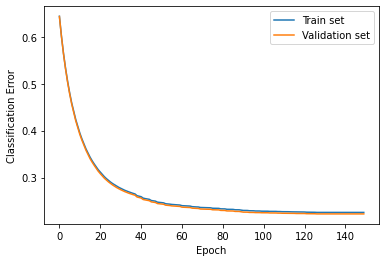

Accuracy: 89 %
              precision    recall  f1-score   support

           0       1.00      0.78      0.87      9870
           1       0.82      1.00      0.90     10125

    accuracy                           0.89     19995
   macro avg       0.91      0.89      0.89     19995
weighted avg       0.91      0.89      0.89     19995



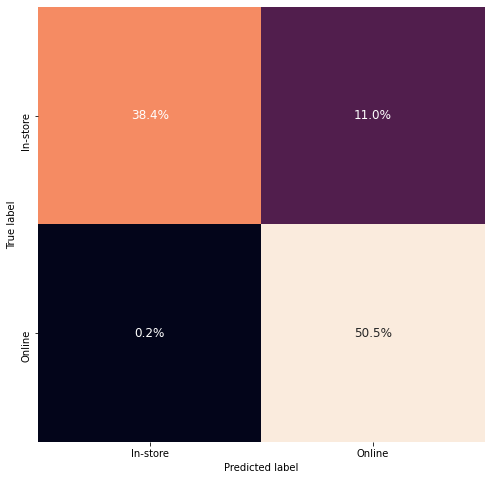

<Figure size 432x288 with 0 Axes>

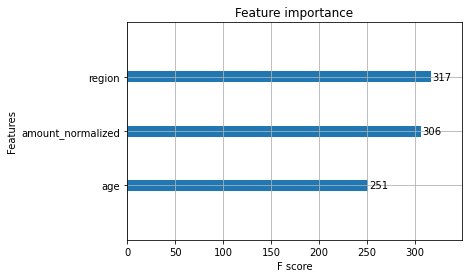

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[00:06:05] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:06:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.66967	validation_1-logloss:0.66979
[1]	validation_0-logloss:0.64942	validation_1-logloss:0.64990
[2]	validation_0-logloss:0.60552	validation_1-logloss:0.60557
[3]	validation_0-logloss:0.57409	validation_1-logloss:0.57421
[4]	validation_0-logloss:0.54676	validation_1-logloss:0.54702
[5]	validation_0-logloss:0.52294	validation_1-loglo

[120]	validation_0-logloss:0.22518	validation_1-logloss:0.22560
[121]	validation_0-logloss:0.22516	validation_1-logloss:0.22558
[122]	validation_0-logloss:0.22514	validation_1-logloss:0.22559
[123]	validation_0-logloss:0.22510	validation_1-logloss:0.22551
[124]	validation_0-logloss:0.22508	validation_1-logloss:0.22551
[125]	validation_0-logloss:0.22500	validation_1-logloss:0.22546
[126]	validation_0-logloss:0.22497	validation_1-logloss:0.22544
[127]	validation_0-logloss:0.22494	validation_1-logloss:0.22541
[128]	validation_0-logloss:0.22492	validation_1-logloss:0.22540
[129]	validation_0-logloss:0.22491	validation_1-logloss:0.22539
[130]	validation_0-logloss:0.22488	validation_1-logloss:0.22535
[131]	validation_0-logloss:0.22487	validation_1-logloss:0.22536
[132]	validation_0-logloss:0.22486	validation_1-logloss:0.22533
[133]	validation_0-logloss:0.22474	validation_1-logloss:0.22520
[134]	validation_0-logloss:0.22473	validation_1-logloss:0.22520
[135]	validation_0-logloss:0.22471	valid

[73]	validation_0-logloss:0.23249	validation_1-logloss:0.23102
[74]	validation_0-logloss:0.23241	validation_1-logloss:0.23097
[75]	validation_0-logloss:0.23236	validation_1-logloss:0.23093
[76]	validation_0-logloss:0.23181	validation_1-logloss:0.23042
[77]	validation_0-logloss:0.23177	validation_1-logloss:0.23038
[78]	validation_0-logloss:0.23117	validation_1-logloss:0.22978
[79]	validation_0-logloss:0.23114	validation_1-logloss:0.22975
[80]	validation_0-logloss:0.23068	validation_1-logloss:0.22927
[81]	validation_0-logloss:0.23065	validation_1-logloss:0.22927
[82]	validation_0-logloss:0.23020	validation_1-logloss:0.22888
[83]	validation_0-logloss:0.22980	validation_1-logloss:0.22855
[84]	validation_0-logloss:0.22938	validation_1-logloss:0.22807
[85]	validation_0-logloss:0.22934	validation_1-logloss:0.22807
[86]	validation_0-logloss:0.22897	validation_1-logloss:0.22776
[87]	validation_0-logloss:0.22859	validation_1-logloss:0.22736
[88]	validation_0-logloss:0.22828	validation_1-logloss:

[4]	validation_0-logloss:0.54663	validation_1-logloss:0.54693
[5]	validation_0-logloss:0.52282	validation_1-logloss:0.52307
[6]	validation_0-logloss:0.51119	validation_1-logloss:0.51154
[7]	validation_0-logloss:0.49087	validation_1-logloss:0.49127
[8]	validation_0-logloss:0.48149	validation_1-logloss:0.48181
[9]	validation_0-logloss:0.46400	validation_1-logloss:0.46437
[10]	validation_0-logloss:0.45617	validation_1-logloss:0.45661
[11]	validation_0-logloss:0.43499	validation_1-logloss:0.43512
[12]	validation_0-logloss:0.42133	validation_1-logloss:0.42146
[13]	validation_0-logloss:0.40391	validation_1-logloss:0.40371
[14]	validation_0-logloss:0.38833	validation_1-logloss:0.38787
[15]	validation_0-logloss:0.38366	validation_1-logloss:0.38321
[16]	validation_0-logloss:0.37374	validation_1-logloss:0.37322
[17]	validation_0-logloss:0.36109	validation_1-logloss:0.36038
[18]	validation_0-logloss:0.34976	validation_1-logloss:0.34887
[19]	validation_0-logloss:0.33958	validation_1-logloss:0.3384

[134]	validation_0-logloss:0.22477	validation_1-logloss:0.22505
[135]	validation_0-logloss:0.22476	validation_1-logloss:0.22505
[136]	validation_0-logloss:0.22474	validation_1-logloss:0.22504
[137]	validation_0-logloss:0.22471	validation_1-logloss:0.22506
[138]	validation_0-logloss:0.22470	validation_1-logloss:0.22505
[139]	validation_0-logloss:0.22469	validation_1-logloss:0.22506
[140]	validation_0-logloss:0.22468	validation_1-logloss:0.22506
[141]	validation_0-logloss:0.22465	validation_1-logloss:0.22502
[142]	validation_0-logloss:0.22464	validation_1-logloss:0.22503
[143]	validation_0-logloss:0.22463	validation_1-logloss:0.22503
[144]	validation_0-logloss:0.22455	validation_1-logloss:0.22507
[145]	validation_0-logloss:0.22453	validation_1-logloss:0.22502
[146]	validation_0-logloss:0.22452	validation_1-logloss:0.22501
[147]	validation_0-logloss:0.22450	validation_1-logloss:0.22502
[148]	validation_0-logloss:0.22449	validation_1-logloss:0.22500
[149]	validation_0-logloss:0.22448	valid

[78]	validation_0-logloss:0.23100	validation_1-logloss:0.23020
[79]	validation_0-logloss:0.23095	validation_1-logloss:0.23018
[80]	validation_0-logloss:0.23047	validation_1-logloss:0.22978
[81]	validation_0-logloss:0.23044	validation_1-logloss:0.22977
[82]	validation_0-logloss:0.23000	validation_1-logloss:0.22941
[83]	validation_0-logloss:0.22960	validation_1-logloss:0.22907
[84]	validation_0-logloss:0.22918	validation_1-logloss:0.22863
[85]	validation_0-logloss:0.22916	validation_1-logloss:0.22863
[86]	validation_0-logloss:0.22880	validation_1-logloss:0.22830
[87]	validation_0-logloss:0.22842	validation_1-logloss:0.22790
[88]	validation_0-logloss:0.22812	validation_1-logloss:0.22764
[89]	validation_0-logloss:0.22807	validation_1-logloss:0.22762
[90]	validation_0-logloss:0.22773	validation_1-logloss:0.22728
[91]	validation_0-logloss:0.22749	validation_1-logloss:0.22705
[92]	validation_0-logloss:0.22724	validation_1-logloss:0.22682
[93]	validation_0-logloss:0.22698	validation_1-logloss:

[0]	validation_0-logloss:0.66968	validation_1-logloss:0.66981
[1]	validation_0-logloss:0.64936	validation_1-logloss:0.64996
[2]	validation_0-logloss:0.60548	validation_1-logloss:0.60558
[3]	validation_0-logloss:0.57386	validation_1-logloss:0.57411
[4]	validation_0-logloss:0.54657	validation_1-logloss:0.54683
[5]	validation_0-logloss:0.52268	validation_1-logloss:0.52297
[6]	validation_0-logloss:0.51102	validation_1-logloss:0.51140
[7]	validation_0-logloss:0.49072	validation_1-logloss:0.49112
[8]	validation_0-logloss:0.48124	validation_1-logloss:0.48164
[9]	validation_0-logloss:0.46381	validation_1-logloss:0.46418
[10]	validation_0-logloss:0.45593	validation_1-logloss:0.45632
[11]	validation_0-logloss:0.43476	validation_1-logloss:0.43484
[12]	validation_0-logloss:0.42110	validation_1-logloss:0.42116
[13]	validation_0-logloss:0.40367	validation_1-logloss:0.40341
[14]	validation_0-logloss:0.38810	validation_1-logloss:0.38757
[15]	validation_0-logloss:0.38339	validation_1-logloss:0.38290
[1

[130]	validation_0-logloss:0.22499	validation_1-logloss:0.22485
[131]	validation_0-logloss:0.22498	validation_1-logloss:0.22486
[132]	validation_0-logloss:0.22495	validation_1-logloss:0.22483
[133]	validation_0-logloss:0.22494	validation_1-logloss:0.22483
[134]	validation_0-logloss:0.22493	validation_1-logloss:0.22484
[135]	validation_0-logloss:0.22491	validation_1-logloss:0.22481
[136]	validation_0-logloss:0.22488	validation_1-logloss:0.22476
[137]	validation_0-logloss:0.22487	validation_1-logloss:0.22477
[138]	validation_0-logloss:0.22486	validation_1-logloss:0.22475
[139]	validation_0-logloss:0.22485	validation_1-logloss:0.22475
[140]	validation_0-logloss:0.22484	validation_1-logloss:0.22474
[141]	validation_0-logloss:0.22482	validation_1-logloss:0.22470
[142]	validation_0-logloss:0.22481	validation_1-logloss:0.22470
[143]	validation_0-logloss:0.22480	validation_1-logloss:0.22466
[144]	validation_0-logloss:0.22479	validation_1-logloss:0.22467
[145]	validation_0-logloss:0.22477	valid

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[5]	validation_0-logloss:0.60132	validation_1-logloss:0.60132
[6]	validation_0-logloss:0.58879	validation_1-logloss:0.58892
[7]	validation_0-logloss:0.56546	validation_1-logloss:0.56566
[8]	validation_0-logloss:0.56301	validation_1-logloss:0.56315
[9]	validation_0-logloss:0.54283	validation_1-logloss:0.54299
[10]	validation_0-logloss:0.53330	validation_1-logloss:0.53349
[11]	validation_0-logloss:0.51588	validation_1-logloss:0.51611
[12]	validation_0-logloss:0.50040	validation_1-logloss:0.50070
[13]	validation_0-logloss:0.49295	validation_1-logloss:0.49316
[14]	validation_0-logloss:0.47937	validation_1-logloss:0.47966
[15]	validation_0-logloss:0.47791	validation_1-logloss:0.47812
[16]	validation_0-logloss:0.46582	validation_1-logloss:0.46612
[17]	validation_0-logloss:0.45976	validation_1-logloss:0.46002
[18]	validation_0-logloss:0.45437	validation_1-logloss:0.45462
[19]	validation_0-logloss:0.44394	validation_1-logloss:0.44410
[20]	validation_0-logloss:0.43443	validation_1-logloss:0.434

[135]	validation_0-logloss:0.28546	validation_1-logloss:0.28586
[136]	validation_0-logloss:0.28545	validation_1-logloss:0.28586
[137]	validation_0-logloss:0.28478	validation_1-logloss:0.28518
[138]	validation_0-logloss:0.28476	validation_1-logloss:0.28518
[139]	validation_0-logloss:0.28415	validation_1-logloss:0.28455
[140]	validation_0-logloss:0.28359	validation_1-logloss:0.28398
[141]	validation_0-logloss:0.28308	validation_1-logloss:0.28345
[142]	validation_0-logloss:0.28285	validation_1-logloss:0.28321
[143]	validation_0-logloss:0.28238	validation_1-logloss:0.28272
[144]	validation_0-logloss:0.28232	validation_1-logloss:0.28270
[145]	validation_0-logloss:0.28228	validation_1-logloss:0.28268
[146]	validation_0-logloss:0.28181	validation_1-logloss:0.28222
[147]	validation_0-logloss:0.28142	validation_1-logloss:0.28180
[148]	validation_0-logloss:0.28136	validation_1-logloss:0.28176
[149]	validation_0-logloss:0.28097	validation_1-logloss:0.28137
[150]	validation_0-logloss:0.28073	valid

[264]	validation_0-logloss:0.27157	validation_1-logloss:0.27301
[265]	validation_0-logloss:0.27156	validation_1-logloss:0.27300
[266]	validation_0-logloss:0.27154	validation_1-logloss:0.27302
[267]	validation_0-logloss:0.27154	validation_1-logloss:0.27301
[268]	validation_0-logloss:0.27153	validation_1-logloss:0.27301
[269]	validation_0-logloss:0.27151	validation_1-logloss:0.27301
[270]	validation_0-logloss:0.27139	validation_1-logloss:0.27289
[271]	validation_0-logloss:0.27137	validation_1-logloss:0.27288
[272]	validation_0-logloss:0.27137	validation_1-logloss:0.27288
[273]	validation_0-logloss:0.27136	validation_1-logloss:0.27287
[274]	validation_0-logloss:0.27133	validation_1-logloss:0.27286
[275]	validation_0-logloss:0.27132	validation_1-logloss:0.27283
[276]	validation_0-logloss:0.27131	validation_1-logloss:0.27283
[277]	validation_0-logloss:0.27130	validation_1-logloss:0.27284
[278]	validation_0-logloss:0.27129	validation_1-logloss:0.27283
[279]	validation_0-logloss:0.27119	valid

[83]	validation_0-logloss:0.30657	validation_1-logloss:0.30652
[84]	validation_0-logloss:0.30505	validation_1-logloss:0.30496
[85]	validation_0-logloss:0.30485	validation_1-logloss:0.30484
[86]	validation_0-logloss:0.30342	validation_1-logloss:0.30340
[87]	validation_0-logloss:0.30327	validation_1-logloss:0.30331
[88]	validation_0-logloss:0.30201	validation_1-logloss:0.30197
[89]	validation_0-logloss:0.30184	validation_1-logloss:0.30185
[90]	validation_0-logloss:0.30169	validation_1-logloss:0.30178
[91]	validation_0-logloss:0.30158	validation_1-logloss:0.30171
[92]	validation_0-logloss:0.30108	validation_1-logloss:0.30122
[93]	validation_0-logloss:0.29984	validation_1-logloss:0.29995
[94]	validation_0-logloss:0.29935	validation_1-logloss:0.29949
[95]	validation_0-logloss:0.29894	validation_1-logloss:0.29907
[96]	validation_0-logloss:0.29881	validation_1-logloss:0.29901
[97]	validation_0-logloss:0.29767	validation_1-logloss:0.29780
[98]	validation_0-logloss:0.29757	validation_1-logloss:

[212]	validation_0-logloss:0.27355	validation_1-logloss:0.27505
[213]	validation_0-logloss:0.27354	validation_1-logloss:0.27505
[214]	validation_0-logloss:0.27351	validation_1-logloss:0.27507
[215]	validation_0-logloss:0.27343	validation_1-logloss:0.27500
[216]	validation_0-logloss:0.27341	validation_1-logloss:0.27500
[217]	validation_0-logloss:0.27338	validation_1-logloss:0.27502
[218]	validation_0-logloss:0.27321	validation_1-logloss:0.27482
[219]	validation_0-logloss:0.27315	validation_1-logloss:0.27477
[220]	validation_0-logloss:0.27313	validation_1-logloss:0.27479
[221]	validation_0-logloss:0.27310	validation_1-logloss:0.27478
[222]	validation_0-logloss:0.27310	validation_1-logloss:0.27476
[223]	validation_0-logloss:0.27293	validation_1-logloss:0.27458
[224]	validation_0-logloss:0.27291	validation_1-logloss:0.27457
[225]	validation_0-logloss:0.27288	validation_1-logloss:0.27456
[226]	validation_0-logloss:0.27287	validation_1-logloss:0.27454
[227]	validation_0-logloss:0.27286	valid

[30]	validation_0-logloss:0.38721	validation_1-logloss:0.38723
[31]	validation_0-logloss:0.38484	validation_1-logloss:0.38484
[32]	validation_0-logloss:0.37924	validation_1-logloss:0.37924
[33]	validation_0-logloss:0.37416	validation_1-logloss:0.37413
[34]	validation_0-logloss:0.37208	validation_1-logloss:0.37199
[35]	validation_0-logloss:0.37023	validation_1-logloss:0.37005
[36]	validation_0-logloss:0.36849	validation_1-logloss:0.36830
[37]	validation_0-logloss:0.36385	validation_1-logloss:0.36363
[38]	validation_0-logloss:0.36294	validation_1-logloss:0.36282
[39]	validation_0-logloss:0.36215	validation_1-logloss:0.36208
[40]	validation_0-logloss:0.36149	validation_1-logloss:0.36148
[41]	validation_0-logloss:0.35726	validation_1-logloss:0.35724
[42]	validation_0-logloss:0.35569	validation_1-logloss:0.35560
[43]	validation_0-logloss:0.35422	validation_1-logloss:0.35413
[44]	validation_0-logloss:0.35363	validation_1-logloss:0.35357
[45]	validation_0-logloss:0.35239	validation_1-logloss:

[160]	validation_0-logloss:0.27856	validation_1-logloss:0.27899
[161]	validation_0-logloss:0.27826	validation_1-logloss:0.27870
[162]	validation_0-logloss:0.27809	validation_1-logloss:0.27854
[163]	validation_0-logloss:0.27783	validation_1-logloss:0.27827
[164]	validation_0-logloss:0.27776	validation_1-logloss:0.27822
[165]	validation_0-logloss:0.27771	validation_1-logloss:0.27818
[166]	validation_0-logloss:0.27765	validation_1-logloss:0.27815
[167]	validation_0-logloss:0.27740	validation_1-logloss:0.27788
[168]	validation_0-logloss:0.27724	validation_1-logloss:0.27773
[169]	validation_0-logloss:0.27699	validation_1-logloss:0.27748
[170]	validation_0-logloss:0.27684	validation_1-logloss:0.27734
[171]	validation_0-logloss:0.27679	validation_1-logloss:0.27730
[172]	validation_0-logloss:0.27666	validation_1-logloss:0.27718
[173]	validation_0-logloss:0.27654	validation_1-logloss:0.27710
[174]	validation_0-logloss:0.27630	validation_1-logloss:0.27686
[175]	validation_0-logloss:0.27608	valid

[289]	validation_0-logloss:0.27113	validation_1-logloss:0.27258
[290]	validation_0-logloss:0.27112	validation_1-logloss:0.27257
[291]	validation_0-logloss:0.27111	validation_1-logloss:0.27257
[292]	validation_0-logloss:0.27110	validation_1-logloss:0.27257
[293]	validation_0-logloss:0.27109	validation_1-logloss:0.27257
[294]	validation_0-logloss:0.27109	validation_1-logloss:0.27257
[295]	validation_0-logloss:0.27109	validation_1-logloss:0.27256
[296]	validation_0-logloss:0.27108	validation_1-logloss:0.27256
[297]	validation_0-logloss:0.27097	validation_1-logloss:0.27246
[298]	validation_0-logloss:0.27097	validation_1-logloss:0.27246
[299]	validation_0-logloss:0.27096	validation_1-logloss:0.27245
[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=20;, score=0.938 total time=   4.2s
[00:06:44] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed

[108]	validation_0-logloss:0.29377	validation_1-logloss:0.29414
[109]	validation_0-logloss:0.29279	validation_1-logloss:0.29313
[110]	validation_0-logloss:0.29244	validation_1-logloss:0.29285
[111]	validation_0-logloss:0.29240	validation_1-logloss:0.29283
[112]	validation_0-logloss:0.29146	validation_1-logloss:0.29189
[113]	validation_0-logloss:0.29142	validation_1-logloss:0.29186
[114]	validation_0-logloss:0.29057	validation_1-logloss:0.29099
[115]	validation_0-logloss:0.29052	validation_1-logloss:0.29096
[116]	validation_0-logloss:0.29019	validation_1-logloss:0.29062
[117]	validation_0-logloss:0.28938	validation_1-logloss:0.28980
[118]	validation_0-logloss:0.28933	validation_1-logloss:0.28977
[119]	validation_0-logloss:0.28928	validation_1-logloss:0.28974
[120]	validation_0-logloss:0.28925	validation_1-logloss:0.28973
[121]	validation_0-logloss:0.28849	validation_1-logloss:0.28896
[122]	validation_0-logloss:0.28780	validation_1-logloss:0.28825
[123]	validation_0-logloss:0.28775	valid

[237]	validation_0-logloss:0.27244	validation_1-logloss:0.27393
[238]	validation_0-logloss:0.27242	validation_1-logloss:0.27392
[239]	validation_0-logloss:0.27241	validation_1-logloss:0.27392
[240]	validation_0-logloss:0.27236	validation_1-logloss:0.27387
[241]	validation_0-logloss:0.27232	validation_1-logloss:0.27383
[242]	validation_0-logloss:0.27218	validation_1-logloss:0.27369
[243]	validation_0-logloss:0.27215	validation_1-logloss:0.27366
[244]	validation_0-logloss:0.27212	validation_1-logloss:0.27362
[245]	validation_0-logloss:0.27209	validation_1-logloss:0.27362
[246]	validation_0-logloss:0.27208	validation_1-logloss:0.27361
[247]	validation_0-logloss:0.27205	validation_1-logloss:0.27358
[248]	validation_0-logloss:0.27204	validation_1-logloss:0.27357
[249]	validation_0-logloss:0.27192	validation_1-logloss:0.27344
[250]	validation_0-logloss:0.27190	validation_1-logloss:0.27343
[251]	validation_0-logloss:0.27189	validation_1-logloss:0.27342
[252]	validation_0-logloss:0.27188	valid

[56]	validation_0-logloss:0.34109	validation_1-logloss:0.34104
[57]	validation_0-logloss:0.33747	validation_1-logloss:0.33735
[58]	validation_0-logloss:0.33682	validation_1-logloss:0.33666
[59]	validation_0-logloss:0.33646	validation_1-logloss:0.33639
[60]	validation_0-logloss:0.33314	validation_1-logloss:0.33301
[61]	validation_0-logloss:0.33253	validation_1-logloss:0.33236
[62]	validation_0-logloss:0.32942	validation_1-logloss:0.32925
[63]	validation_0-logloss:0.32911	validation_1-logloss:0.32900
[64]	validation_0-logloss:0.32630	validation_1-logloss:0.32615
[65]	validation_0-logloss:0.32570	validation_1-logloss:0.32554
[66]	validation_0-logloss:0.32512	validation_1-logloss:0.32498
[67]	validation_0-logloss:0.32252	validation_1-logloss:0.32233
[68]	validation_0-logloss:0.32198	validation_1-logloss:0.32176
[69]	validation_0-logloss:0.32148	validation_1-logloss:0.32124
[70]	validation_0-logloss:0.31905	validation_1-logloss:0.31877
[71]	validation_0-logloss:0.31685	validation_1-logloss:

[185]	validation_0-logloss:0.27500	validation_1-logloss:0.27615
[186]	validation_0-logloss:0.27493	validation_1-logloss:0.27610
[187]	validation_0-logloss:0.27486	validation_1-logloss:0.27601
[188]	validation_0-logloss:0.27482	validation_1-logloss:0.27598
[189]	validation_0-logloss:0.27478	validation_1-logloss:0.27596
[190]	validation_0-logloss:0.27475	validation_1-logloss:0.27594
[191]	validation_0-logloss:0.27472	validation_1-logloss:0.27593
[192]	validation_0-logloss:0.27463	validation_1-logloss:0.27583
[193]	validation_0-logloss:0.27455	validation_1-logloss:0.27578
[194]	validation_0-logloss:0.27450	validation_1-logloss:0.27574
[195]	validation_0-logloss:0.27446	validation_1-logloss:0.27572
[196]	validation_0-logloss:0.27444	validation_1-logloss:0.27570
[197]	validation_0-logloss:0.27442	validation_1-logloss:0.27569
[198]	validation_0-logloss:0.27420	validation_1-logloss:0.27548
[199]	validation_0-logloss:0.27416	validation_1-logloss:0.27553
[200]	validation_0-logloss:0.27415	valid

[3]	validation_0-logloss:0.57603	validation_1-logloss:0.57604
[4]	validation_0-logloss:0.54921	validation_1-logloss:0.54948
[5]	validation_0-logloss:0.52592	validation_1-logloss:0.52624
[6]	validation_0-logloss:0.51466	validation_1-logloss:0.51481
[7]	validation_0-logloss:0.49466	validation_1-logloss:0.49504
[8]	validation_0-logloss:0.48536	validation_1-logloss:0.48562
[9]	validation_0-logloss:0.46834	validation_1-logloss:0.46858
[10]	validation_0-logloss:0.46060	validation_1-logloss:0.46075
[11]	validation_0-logloss:0.43973	validation_1-logloss:0.43941
[12]	validation_0-logloss:0.42628	validation_1-logloss:0.42601
[13]	validation_0-logloss:0.40898	validation_1-logloss:0.40835
[14]	validation_0-logloss:0.39366	validation_1-logloss:0.39259
[15]	validation_0-logloss:0.38923	validation_1-logloss:0.38805
[16]	validation_0-logloss:0.37943	validation_1-logloss:0.37822
[17]	validation_0-logloss:0.36834	validation_1-logloss:0.36699
[18]	validation_0-logloss:0.35833	validation_1-logloss:0.35688

[133]	validation_0-logloss:0.23477	validation_1-logloss:0.23129
[134]	validation_0-logloss:0.23465	validation_1-logloss:0.23126
[135]	validation_0-logloss:0.23371	validation_1-logloss:0.23038
[136]	validation_0-logloss:0.23353	validation_1-logloss:0.23017
[137]	validation_0-logloss:0.23352	validation_1-logloss:0.23018
[138]	validation_0-logloss:0.23343	validation_1-logloss:0.23020
[139]	validation_0-logloss:0.23264	validation_1-logloss:0.22940
[140]	validation_0-logloss:0.23235	validation_1-logloss:0.22908
[141]	validation_0-logloss:0.23228	validation_1-logloss:0.22898
[142]	validation_0-logloss:0.23149	validation_1-logloss:0.22828
[143]	validation_0-logloss:0.23084	validation_1-logloss:0.22767
[144]	validation_0-logloss:0.23076	validation_1-logloss:0.22765
[145]	validation_0-logloss:0.23062	validation_1-logloss:0.22763
[146]	validation_0-logloss:0.23052	validation_1-logloss:0.22749
[147]	validation_0-logloss:0.22991	validation_1-logloss:0.22698
[148]	validation_0-logloss:0.22986	valid

[262]	validation_0-logloss:0.22085	validation_1-logloss:0.22162
[263]	validation_0-logloss:0.22082	validation_1-logloss:0.22163
[264]	validation_0-logloss:0.22081	validation_1-logloss:0.22163
[265]	validation_0-logloss:0.22081	validation_1-logloss:0.22164
[266]	validation_0-logloss:0.22075	validation_1-logloss:0.22168
[267]	validation_0-logloss:0.22073	validation_1-logloss:0.22170
[268]	validation_0-logloss:0.22071	validation_1-logloss:0.22171
[269]	validation_0-logloss:0.22071	validation_1-logloss:0.22171
[270]	validation_0-logloss:0.22069	validation_1-logloss:0.22171
[271]	validation_0-logloss:0.22067	validation_1-logloss:0.22171
[272]	validation_0-logloss:0.22061	validation_1-logloss:0.22171
[273]	validation_0-logloss:0.22060	validation_1-logloss:0.22171
[274]	validation_0-logloss:0.22057	validation_1-logloss:0.22170
[275]	validation_0-logloss:0.22055	validation_1-logloss:0.22168
[276]	validation_0-logloss:0.22052	validation_1-logloss:0.22175
[277]	validation_0-logloss:0.22051	valid

[98]	validation_0-logloss:0.24558	validation_1-logloss:0.24285
[99]	validation_0-logloss:0.24555	validation_1-logloss:0.24284
[100]	validation_0-logloss:0.24516	validation_1-logloss:0.24242
[101]	validation_0-logloss:0.24510	validation_1-logloss:0.24237
[102]	validation_0-logloss:0.24497	validation_1-logloss:0.24224
[103]	validation_0-logloss:0.24482	validation_1-logloss:0.24211
[104]	validation_0-logloss:0.24450	validation_1-logloss:0.24176
[105]	validation_0-logloss:0.24446	validation_1-logloss:0.24177
[106]	validation_0-logloss:0.24437	validation_1-logloss:0.24167
[107]	validation_0-logloss:0.24424	validation_1-logloss:0.24159
[108]	validation_0-logloss:0.24416	validation_1-logloss:0.24151
[109]	validation_0-logloss:0.24410	validation_1-logloss:0.24143
[110]	validation_0-logloss:0.24407	validation_1-logloss:0.24142
[111]	validation_0-logloss:0.24401	validation_1-logloss:0.24138
[112]	validation_0-logloss:0.24268	validation_1-logloss:0.23989
[113]	validation_0-logloss:0.24221	validat

[227]	validation_0-logloss:0.22292	validation_1-logloss:0.22207
[228]	validation_0-logloss:0.22291	validation_1-logloss:0.22205
[229]	validation_0-logloss:0.22285	validation_1-logloss:0.22215
[230]	validation_0-logloss:0.22281	validation_1-logloss:0.22218
[231]	validation_0-logloss:0.22280	validation_1-logloss:0.22212
[232]	validation_0-logloss:0.22279	validation_1-logloss:0.22213
[233]	validation_0-logloss:0.22279	validation_1-logloss:0.22212
[234]	validation_0-logloss:0.22276	validation_1-logloss:0.22213
[235]	validation_0-logloss:0.22276	validation_1-logloss:0.22213
[236]	validation_0-logloss:0.22275	validation_1-logloss:0.22211
[237]	validation_0-logloss:0.22275	validation_1-logloss:0.22210
[238]	validation_0-logloss:0.22273	validation_1-logloss:0.22211
[239]	validation_0-logloss:0.22269	validation_1-logloss:0.22211
[240]	validation_0-logloss:0.22268	validation_1-logloss:0.22211
[241]	validation_0-logloss:0.22267	validation_1-logloss:0.22211
[242]	validation_0-logloss:0.22242	valid

[61]	validation_0-logloss:0.25738	validation_1-logloss:0.25477
[62]	validation_0-logloss:0.25652	validation_1-logloss:0.25389
[63]	validation_0-logloss:0.25626	validation_1-logloss:0.25365
[64]	validation_0-logloss:0.25539	validation_1-logloss:0.25278
[65]	validation_0-logloss:0.25459	validation_1-logloss:0.25200
[66]	validation_0-logloss:0.25440	validation_1-logloss:0.25180
[67]	validation_0-logloss:0.25368	validation_1-logloss:0.25111
[68]	validation_0-logloss:0.25348	validation_1-logloss:0.25093
[69]	validation_0-logloss:0.25285	validation_1-logloss:0.25026
[70]	validation_0-logloss:0.25223	validation_1-logloss:0.24965
[71]	validation_0-logloss:0.25168	validation_1-logloss:0.24909
[72]	validation_0-logloss:0.25117	validation_1-logloss:0.24857
[73]	validation_0-logloss:0.25061	validation_1-logloss:0.24807
[74]	validation_0-logloss:0.25048	validation_1-logloss:0.24794
[75]	validation_0-logloss:0.25033	validation_1-logloss:0.24783
[76]	validation_0-logloss:0.24987	validation_1-logloss:

[190]	validation_0-logloss:0.22498	validation_1-logloss:0.22400
[191]	validation_0-logloss:0.22496	validation_1-logloss:0.22398
[192]	validation_0-logloss:0.22494	validation_1-logloss:0.22395
[193]	validation_0-logloss:0.22487	validation_1-logloss:0.22391
[194]	validation_0-logloss:0.22458	validation_1-logloss:0.22364
[195]	validation_0-logloss:0.22429	validation_1-logloss:0.22343
[196]	validation_0-logloss:0.22426	validation_1-logloss:0.22340
[197]	validation_0-logloss:0.22421	validation_1-logloss:0.22341
[198]	validation_0-logloss:0.22419	validation_1-logloss:0.22341
[199]	validation_0-logloss:0.22414	validation_1-logloss:0.22340
[200]	validation_0-logloss:0.22412	validation_1-logloss:0.22338
[201]	validation_0-logloss:0.22407	validation_1-logloss:0.22343
[202]	validation_0-logloss:0.22401	validation_1-logloss:0.22348
[203]	validation_0-logloss:0.22396	validation_1-logloss:0.22345
[204]	validation_0-logloss:0.22389	validation_1-logloss:0.22341
[205]	validation_0-logloss:0.22388	valid

[27]	validation_0-logloss:0.31143	validation_1-logloss:0.30912
[28]	validation_0-logloss:0.30507	validation_1-logloss:0.30254
[29]	validation_0-logloss:0.30068	validation_1-logloss:0.29810
[30]	validation_0-logloss:0.29970	validation_1-logloss:0.29710
[31]	validation_0-logloss:0.29583	validation_1-logloss:0.29314
[32]	validation_0-logloss:0.29217	validation_1-logloss:0.28940
[33]	validation_0-logloss:0.28888	validation_1-logloss:0.28607
[34]	validation_0-logloss:0.28587	validation_1-logloss:0.28303
[35]	validation_0-logloss:0.28508	validation_1-logloss:0.28221
[36]	validation_0-logloss:0.28443	validation_1-logloss:0.28162
[37]	validation_0-logloss:0.28179	validation_1-logloss:0.27894
[38]	validation_0-logloss:0.27897	validation_1-logloss:0.27609
[39]	validation_0-logloss:0.27842	validation_1-logloss:0.27547
[40]	validation_0-logloss:0.27781	validation_1-logloss:0.27491
[41]	validation_0-logloss:0.27556	validation_1-logloss:0.27266
[42]	validation_0-logloss:0.27507	validation_1-logloss:

[157]	validation_0-logloss:0.22891	validation_1-logloss:0.22638
[158]	validation_0-logloss:0.22880	validation_1-logloss:0.22635
[159]	validation_0-logloss:0.22880	validation_1-logloss:0.22636
[160]	validation_0-logloss:0.22862	validation_1-logloss:0.22619
[161]	validation_0-logloss:0.22845	validation_1-logloss:0.22603
[162]	validation_0-logloss:0.22842	validation_1-logloss:0.22603
[163]	validation_0-logloss:0.22837	validation_1-logloss:0.22603
[164]	validation_0-logloss:0.22832	validation_1-logloss:0.22598
[165]	validation_0-logloss:0.22816	validation_1-logloss:0.22585
[166]	validation_0-logloss:0.22802	validation_1-logloss:0.22570
[167]	validation_0-logloss:0.22791	validation_1-logloss:0.22560
[168]	validation_0-logloss:0.22783	validation_1-logloss:0.22562
[169]	validation_0-logloss:0.22773	validation_1-logloss:0.22549
[170]	validation_0-logloss:0.22762	validation_1-logloss:0.22560
[171]	validation_0-logloss:0.22757	validation_1-logloss:0.22553
[172]	validation_0-logloss:0.22752	valid

[286]	validation_0-logloss:0.22057	validation_1-logloss:0.22165
[CV 4/5] END colsample_bytree=0.8, gamma=0.3, max_depth=5, min_child_weight=5;, score=0.992 total time=   6.1s
[00:07:17] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:07:17] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.67019	validation_1-logloss:0.67039
[1]	validation_0-logloss:0.65046	validation_1-logloss:0.65095
[2]	validation_0-logloss:0.60681	validation_1-logloss:0.60676
[3]	validation_0-logloss:0.57603	validation_1-logloss:0.57606

[118]	validation_0-logloss:0.23936	validation_1-logloss:0.23666
[119]	validation_0-logloss:0.23901	validation_1-logloss:0.23623
[120]	validation_0-logloss:0.23880	validation_1-logloss:0.23598
[121]	validation_0-logloss:0.23848	validation_1-logloss:0.23560
[122]	validation_0-logloss:0.23740	validation_1-logloss:0.23442
[123]	validation_0-logloss:0.23732	validation_1-logloss:0.23440
[124]	validation_0-logloss:0.23718	validation_1-logloss:0.23438
[125]	validation_0-logloss:0.23713	validation_1-logloss:0.23434
[126]	validation_0-logloss:0.23689	validation_1-logloss:0.23401
[127]	validation_0-logloss:0.23675	validation_1-logloss:0.23389
[128]	validation_0-logloss:0.23664	validation_1-logloss:0.23384
[129]	validation_0-logloss:0.23566	validation_1-logloss:0.23284
[130]	validation_0-logloss:0.23544	validation_1-logloss:0.23255
[131]	validation_0-logloss:0.23451	validation_1-logloss:0.23160
[132]	validation_0-logloss:0.23441	validation_1-logloss:0.23162
[133]	validation_0-logloss:0.23408	valid

[247]	validation_0-logloss:0.22165	validation_1-logloss:0.22168
[248]	validation_0-logloss:0.22161	validation_1-logloss:0.22173
[249]	validation_0-logloss:0.22159	validation_1-logloss:0.22174
[250]	validation_0-logloss:0.22154	validation_1-logloss:0.22174
[251]	validation_0-logloss:0.22154	validation_1-logloss:0.22174
[252]	validation_0-logloss:0.22153	validation_1-logloss:0.22174
[253]	validation_0-logloss:0.22152	validation_1-logloss:0.22174
[254]	validation_0-logloss:0.22152	validation_1-logloss:0.22174
[255]	validation_0-logloss:0.22152	validation_1-logloss:0.22175
[256]	validation_0-logloss:0.22148	validation_1-logloss:0.22180
[257]	validation_0-logloss:0.22143	validation_1-logloss:0.22179
[258]	validation_0-logloss:0.22139	validation_1-logloss:0.22181
[259]	validation_0-logloss:0.22135	validation_1-logloss:0.22181
[260]	validation_0-logloss:0.22135	validation_1-logloss:0.22180
[261]	validation_0-logloss:0.22129	validation_1-logloss:0.22182
[262]	validation_0-logloss:0.22128	valid

[101]	validation_0-logloss:0.26985	validation_1-logloss:0.26870
[102]	validation_0-logloss:0.26971	validation_1-logloss:0.26854
[103]	validation_0-logloss:0.26959	validation_1-logloss:0.26841
[104]	validation_0-logloss:0.26812	validation_1-logloss:0.26682
[105]	validation_0-logloss:0.26801	validation_1-logloss:0.26671
[106]	validation_0-logloss:0.26456	validation_1-logloss:0.26313
[107]	validation_0-logloss:0.26447	validation_1-logloss:0.26299
[108]	validation_0-logloss:0.26432	validation_1-logloss:0.26290
[109]	validation_0-logloss:0.26140	validation_1-logloss:0.25982
[110]	validation_0-logloss:0.26106	validation_1-logloss:0.25946
[111]	validation_0-logloss:0.26077	validation_1-logloss:0.25918
[112]	validation_0-logloss:0.26066	validation_1-logloss:0.25905
[113]	validation_0-logloss:0.26052	validation_1-logloss:0.25894
[114]	validation_0-logloss:0.26042	validation_1-logloss:0.25883
[115]	validation_0-logloss:0.25919	validation_1-logloss:0.25739
[116]	validation_0-logloss:0.25909	valid

[230]	validation_0-logloss:0.22985	validation_1-logloss:0.22626
[231]	validation_0-logloss:0.22985	validation_1-logloss:0.22626
[232]	validation_0-logloss:0.22985	validation_1-logloss:0.22626
[233]	validation_0-logloss:0.22985	validation_1-logloss:0.22626
[234]	validation_0-logloss:0.22975	validation_1-logloss:0.22614
[235]	validation_0-logloss:0.22971	validation_1-logloss:0.22615
[236]	validation_0-logloss:0.22968	validation_1-logloss:0.22609
[237]	validation_0-logloss:0.22965	validation_1-logloss:0.22605
[238]	validation_0-logloss:0.22958	validation_1-logloss:0.22596
[239]	validation_0-logloss:0.22958	validation_1-logloss:0.22596
[240]	validation_0-logloss:0.22958	validation_1-logloss:0.22596
[241]	validation_0-logloss:0.22956	validation_1-logloss:0.22592
[242]	validation_0-logloss:0.22956	validation_1-logloss:0.22592
[243]	validation_0-logloss:0.22952	validation_1-logloss:0.22587
[244]	validation_0-logloss:0.22912	validation_1-logloss:0.22548
[245]	validation_0-logloss:0.22912	valid

[75]	validation_0-logloss:0.27706	validation_1-logloss:0.27582
[76]	validation_0-logloss:0.27648	validation_1-logloss:0.27530
[77]	validation_0-logloss:0.27624	validation_1-logloss:0.27510
[78]	validation_0-logloss:0.27572	validation_1-logloss:0.27459
[79]	validation_0-logloss:0.27550	validation_1-logloss:0.27436
[80]	validation_0-logloss:0.27508	validation_1-logloss:0.27390
[81]	validation_0-logloss:0.27484	validation_1-logloss:0.27367
[82]	validation_0-logloss:0.27442	validation_1-logloss:0.27325
[83]	validation_0-logloss:0.27402	validation_1-logloss:0.27286
[84]	validation_0-logloss:0.27363	validation_1-logloss:0.27247
[85]	validation_0-logloss:0.27341	validation_1-logloss:0.27225
[86]	validation_0-logloss:0.27302	validation_1-logloss:0.27191
[87]	validation_0-logloss:0.27268	validation_1-logloss:0.27157
[88]	validation_0-logloss:0.27239	validation_1-logloss:0.27128
[89]	validation_0-logloss:0.27212	validation_1-logloss:0.27105
[90]	validation_0-logloss:0.27183	validation_1-logloss:

[204]	validation_0-logloss:0.23018	validation_1-logloss:0.22642
[205]	validation_0-logloss:0.23014	validation_1-logloss:0.22639
[206]	validation_0-logloss:0.22975	validation_1-logloss:0.22595
[207]	validation_0-logloss:0.22972	validation_1-logloss:0.22595
[208]	validation_0-logloss:0.22969	validation_1-logloss:0.22592
[209]	validation_0-logloss:0.22968	validation_1-logloss:0.22594
[210]	validation_0-logloss:0.22967	validation_1-logloss:0.22595
[211]	validation_0-logloss:0.22966	validation_1-logloss:0.22596
[212]	validation_0-logloss:0.22964	validation_1-logloss:0.22599
[213]	validation_0-logloss:0.22959	validation_1-logloss:0.22596
[214]	validation_0-logloss:0.22959	validation_1-logloss:0.22597
[215]	validation_0-logloss:0.22956	validation_1-logloss:0.22595
[216]	validation_0-logloss:0.22950	validation_1-logloss:0.22587
[217]	validation_0-logloss:0.22947	validation_1-logloss:0.22588
[218]	validation_0-logloss:0.22914	validation_1-logloss:0.22552
[219]	validation_0-logloss:0.22910	valid

[46]	validation_0-logloss:0.30182	validation_1-logloss:0.30026
[47]	validation_0-logloss:0.29983	validation_1-logloss:0.29835
[48]	validation_0-logloss:0.29801	validation_1-logloss:0.29659
[49]	validation_0-logloss:0.29713	validation_1-logloss:0.29568
[50]	validation_0-logloss:0.29546	validation_1-logloss:0.29395
[51]	validation_0-logloss:0.29384	validation_1-logloss:0.29243
[52]	validation_0-logloss:0.29344	validation_1-logloss:0.29198
[53]	validation_0-logloss:0.29202	validation_1-logloss:0.29060
[54]	validation_0-logloss:0.29158	validation_1-logloss:0.29017
[55]	validation_0-logloss:0.29094	validation_1-logloss:0.28947
[56]	validation_0-logloss:0.29067	validation_1-logloss:0.28911
[57]	validation_0-logloss:0.28925	validation_1-logloss:0.28780
[58]	validation_0-logloss:0.28892	validation_1-logloss:0.28740
[59]	validation_0-logloss:0.28763	validation_1-logloss:0.28619
[60]	validation_0-logloss:0.28650	validation_1-logloss:0.28508
[61]	validation_0-logloss:0.28582	validation_1-logloss:

[175]	validation_0-logloss:0.23446	validation_1-logloss:0.23140
[176]	validation_0-logloss:0.23418	validation_1-logloss:0.23106
[177]	validation_0-logloss:0.23412	validation_1-logloss:0.23102
[178]	validation_0-logloss:0.23349	validation_1-logloss:0.23037
[179]	validation_0-logloss:0.23344	validation_1-logloss:0.23033
[180]	validation_0-logloss:0.23340	validation_1-logloss:0.23035
[181]	validation_0-logloss:0.23316	validation_1-logloss:0.23006
[182]	validation_0-logloss:0.23313	validation_1-logloss:0.23007
[183]	validation_0-logloss:0.23310	validation_1-logloss:0.23009
[184]	validation_0-logloss:0.23309	validation_1-logloss:0.23008
[185]	validation_0-logloss:0.23285	validation_1-logloss:0.22981
[186]	validation_0-logloss:0.23283	validation_1-logloss:0.22984
[187]	validation_0-logloss:0.23278	validation_1-logloss:0.22979
[188]	validation_0-logloss:0.23277	validation_1-logloss:0.22980
[189]	validation_0-logloss:0.23273	validation_1-logloss:0.22976
[190]	validation_0-logloss:0.23271	valid

[0]	validation_0-logloss:0.67466	validation_1-logloss:0.67457
[1]	validation_0-logloss:0.65860	validation_1-logloss:0.65879
[2]	validation_0-logloss:0.61990	validation_1-logloss:0.62004
[3]	validation_0-logloss:0.59064	validation_1-logloss:0.59111
[4]	validation_0-logloss:0.56528	validation_1-logloss:0.56603
[5]	validation_0-logloss:0.54329	validation_1-logloss:0.54413
[6]	validation_0-logloss:0.53388	validation_1-logloss:0.53468
[7]	validation_0-logloss:0.51492	validation_1-logloss:0.51590
[8]	validation_0-logloss:0.50709	validation_1-logloss:0.50810
[9]	validation_0-logloss:0.49080	validation_1-logloss:0.49179
[10]	validation_0-logloss:0.48429	validation_1-logloss:0.48509
[11]	validation_0-logloss:0.46666	validation_1-logloss:0.46723
[12]	validation_0-logloss:0.45352	validation_1-logloss:0.45429
[13]	validation_0-logloss:0.43908	validation_1-logloss:0.43963
[14]	validation_0-logloss:0.42608	validation_1-logloss:0.42647
[15]	validation_0-logloss:0.42170	validation_1-logloss:0.42190
[1

[130]	validation_0-logloss:0.25162	validation_1-logloss:0.24910
[131]	validation_0-logloss:0.24957	validation_1-logloss:0.24696
[132]	validation_0-logloss:0.24948	validation_1-logloss:0.24691
[133]	validation_0-logloss:0.24941	validation_1-logloss:0.24685
[134]	validation_0-logloss:0.24935	validation_1-logloss:0.24682
[135]	validation_0-logloss:0.24761	validation_1-logloss:0.24500
[136]	validation_0-logloss:0.24664	validation_1-logloss:0.24387
[137]	validation_0-logloss:0.24607	validation_1-logloss:0.24320
[138]	validation_0-logloss:0.24597	validation_1-logloss:0.24311
[139]	validation_0-logloss:0.24591	validation_1-logloss:0.24304
[140]	validation_0-logloss:0.24505	validation_1-logloss:0.24209
[141]	validation_0-logloss:0.24430	validation_1-logloss:0.24121
[142]	validation_0-logloss:0.24291	validation_1-logloss:0.23975
[143]	validation_0-logloss:0.24285	validation_1-logloss:0.23968
[144]	validation_0-logloss:0.24274	validation_1-logloss:0.23958
[145]	validation_0-logloss:0.24267	valid

[259]	validation_0-logloss:0.22778	validation_1-logloss:0.22406
[260]	validation_0-logloss:0.22775	validation_1-logloss:0.22407
[261]	validation_0-logloss:0.22773	validation_1-logloss:0.22410
[262]	validation_0-logloss:0.22769	validation_1-logloss:0.22403
[263]	validation_0-logloss:0.22767	validation_1-logloss:0.22403
[264]	validation_0-logloss:0.22765	validation_1-logloss:0.22405
[265]	validation_0-logloss:0.22763	validation_1-logloss:0.22403
[266]	validation_0-logloss:0.22763	validation_1-logloss:0.22403
[267]	validation_0-logloss:0.22763	validation_1-logloss:0.22403
[268]	validation_0-logloss:0.22763	validation_1-logloss:0.22403
[269]	validation_0-logloss:0.22761	validation_1-logloss:0.22401
[270]	validation_0-logloss:0.22759	validation_1-logloss:0.22397
[271]	validation_0-logloss:0.22758	validation_1-logloss:0.22397
[272]	validation_0-logloss:0.22758	validation_1-logloss:0.22397
[273]	validation_0-logloss:0.22758	validation_1-logloss:0.22397
[274]	validation_0-logloss:0.22756	valid

[78]	validation_0-logloss:0.27535	validation_1-logloss:0.27392
[79]	validation_0-logloss:0.27498	validation_1-logloss:0.27351
[80]	validation_0-logloss:0.27451	validation_1-logloss:0.27305
[81]	validation_0-logloss:0.27421	validation_1-logloss:0.27281
[82]	validation_0-logloss:0.27384	validation_1-logloss:0.27238
[83]	validation_0-logloss:0.27342	validation_1-logloss:0.27198
[84]	validation_0-logloss:0.27303	validation_1-logloss:0.27159
[85]	validation_0-logloss:0.27281	validation_1-logloss:0.27137
[86]	validation_0-logloss:0.27243	validation_1-logloss:0.27103
[87]	validation_0-logloss:0.27209	validation_1-logloss:0.27070
[88]	validation_0-logloss:0.27179	validation_1-logloss:0.27040
[89]	validation_0-logloss:0.27161	validation_1-logloss:0.27020
[90]	validation_0-logloss:0.27127	validation_1-logloss:0.26992
[91]	validation_0-logloss:0.27102	validation_1-logloss:0.26965
[92]	validation_0-logloss:0.27076	validation_1-logloss:0.26941
[93]	validation_0-logloss:0.27054	validation_1-logloss:

[207]	validation_0-logloss:0.22945	validation_1-logloss:0.22566
[208]	validation_0-logloss:0.22909	validation_1-logloss:0.22528
[209]	validation_0-logloss:0.22908	validation_1-logloss:0.22530
[210]	validation_0-logloss:0.22906	validation_1-logloss:0.22534
[211]	validation_0-logloss:0.22906	validation_1-logloss:0.22534
[212]	validation_0-logloss:0.22906	validation_1-logloss:0.22534
[213]	validation_0-logloss:0.22906	validation_1-logloss:0.22534
[214]	validation_0-logloss:0.22906	validation_1-logloss:0.22534
[215]	validation_0-logloss:0.22899	validation_1-logloss:0.22525
[216]	validation_0-logloss:0.22895	validation_1-logloss:0.22518
[217]	validation_0-logloss:0.22895	validation_1-logloss:0.22518
[218]	validation_0-logloss:0.22895	validation_1-logloss:0.22518
[219]	validation_0-logloss:0.22895	validation_1-logloss:0.22518
[220]	validation_0-logloss:0.22894	validation_1-logloss:0.22518
[221]	validation_0-logloss:0.22890	validation_1-logloss:0.22512
[222]	validation_0-logloss:0.22890	valid

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[CV 5/5] END colsample_bytree=1.5, gamma=0.3, max_depth=10, min_child_weight=20;, score=nan total time=   0.0s
[00:07:46] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:07:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.68722	validation_1-logloss:0.68716
[1]	validation_0-logloss:0.66976	validation_1-logloss:0.66999
[2]	validation_0-logloss:0.63654	validation_1-logloss:0.63682
[3]	validation_0-logloss:0.60800	validation_1-logloss:0.60842
[4]	validation_0-logloss:0.60415	validation_1-logloss:0.60456
[

[119]	validation_0-logloss:0.28751	validation_1-logloss:0.28922
[120]	validation_0-logloss:0.28746	validation_1-logloss:0.28919
[121]	validation_0-logloss:0.28674	validation_1-logloss:0.28844
[122]	validation_0-logloss:0.28606	validation_1-logloss:0.28774
[123]	validation_0-logloss:0.28600	validation_1-logloss:0.28770
[124]	validation_0-logloss:0.28562	validation_1-logloss:0.28733
[125]	validation_0-logloss:0.28499	validation_1-logloss:0.28668
[126]	validation_0-logloss:0.28493	validation_1-logloss:0.28664
[127]	validation_0-logloss:0.28489	validation_1-logloss:0.28660
[128]	validation_0-logloss:0.28451	validation_1-logloss:0.28625
[129]	validation_0-logloss:0.28419	validation_1-logloss:0.28600
[130]	validation_0-logloss:0.28415	validation_1-logloss:0.28599
[131]	validation_0-logloss:0.28388	validation_1-logloss:0.28576
[132]	validation_0-logloss:0.28385	validation_1-logloss:0.28577
[133]	validation_0-logloss:0.28383	validation_1-logloss:0.28577
[134]	validation_0-logloss:0.28357	valid

[248]	validation_0-logloss:0.26815	validation_1-logloss:0.27196
[249]	validation_0-logloss:0.26807	validation_1-logloss:0.27189
[250]	validation_0-logloss:0.26805	validation_1-logloss:0.27187
[251]	validation_0-logloss:0.26803	validation_1-logloss:0.27186
[252]	validation_0-logloss:0.26799	validation_1-logloss:0.27183
[253]	validation_0-logloss:0.26798	validation_1-logloss:0.27182
[254]	validation_0-logloss:0.26793	validation_1-logloss:0.27177
[255]	validation_0-logloss:0.26791	validation_1-logloss:0.27176
[256]	validation_0-logloss:0.26785	validation_1-logloss:0.27169
[257]	validation_0-logloss:0.26781	validation_1-logloss:0.27165
[258]	validation_0-logloss:0.26779	validation_1-logloss:0.27164
[259]	validation_0-logloss:0.26777	validation_1-logloss:0.27163
[260]	validation_0-logloss:0.26771	validation_1-logloss:0.27157
[261]	validation_0-logloss:0.26767	validation_1-logloss:0.27155
[262]	validation_0-logloss:0.26764	validation_1-logloss:0.27152
[263]	validation_0-logloss:0.26760	valid

[67]	validation_0-logloss:0.32111	validation_1-logloss:0.32213
[68]	validation_0-logloss:0.32053	validation_1-logloss:0.32157
[69]	validation_0-logloss:0.32000	validation_1-logloss:0.32107
[70]	validation_0-logloss:0.31758	validation_1-logloss:0.31860
[71]	validation_0-logloss:0.31536	validation_1-logloss:0.31633
[72]	validation_0-logloss:0.31506	validation_1-logloss:0.31606
[73]	validation_0-logloss:0.31302	validation_1-logloss:0.31398
[74]	validation_0-logloss:0.31273	validation_1-logloss:0.31375
[75]	validation_0-logloss:0.31248	validation_1-logloss:0.31355
[76]	validation_0-logloss:0.31060	validation_1-logloss:0.31162
[77]	validation_0-logloss:0.31000	validation_1-logloss:0.31106
[78]	validation_0-logloss:0.30978	validation_1-logloss:0.31088
[79]	validation_0-logloss:0.30958	validation_1-logloss:0.31072
[80]	validation_0-logloss:0.30783	validation_1-logloss:0.30892
[81]	validation_0-logloss:0.30727	validation_1-logloss:0.30844
[82]	validation_0-logloss:0.30563	validation_1-logloss:

[196]	validation_0-logloss:0.27166	validation_1-logloss:0.27498
[197]	validation_0-logloss:0.27161	validation_1-logloss:0.27498
[198]	validation_0-logloss:0.27142	validation_1-logloss:0.27478
[199]	validation_0-logloss:0.27138	validation_1-logloss:0.27474
[200]	validation_0-logloss:0.27135	validation_1-logloss:0.27473
[201]	validation_0-logloss:0.27128	validation_1-logloss:0.27469
[202]	validation_0-logloss:0.27126	validation_1-logloss:0.27468
[203]	validation_0-logloss:0.27108	validation_1-logloss:0.27448
[204]	validation_0-logloss:0.27103	validation_1-logloss:0.27446
[205]	validation_0-logloss:0.27101	validation_1-logloss:0.27446
[206]	validation_0-logloss:0.27094	validation_1-logloss:0.27443
[207]	validation_0-logloss:0.27092	validation_1-logloss:0.27441
[208]	validation_0-logloss:0.27075	validation_1-logloss:0.27422
[209]	validation_0-logloss:0.27073	validation_1-logloss:0.27421
[210]	validation_0-logloss:0.27072	validation_1-logloss:0.27421
[211]	validation_0-logloss:0.27056	valid

[14]	validation_0-logloss:0.47901	validation_1-logloss:0.47978
[15]	validation_0-logloss:0.47741	validation_1-logloss:0.47822
[16]	validation_0-logloss:0.46540	validation_1-logloss:0.46622
[17]	validation_0-logloss:0.45926	validation_1-logloss:0.46010
[18]	validation_0-logloss:0.45390	validation_1-logloss:0.45472
[19]	validation_0-logloss:0.44341	validation_1-logloss:0.44421
[20]	validation_0-logloss:0.43394	validation_1-logloss:0.43474
[21]	validation_0-logloss:0.42946	validation_1-logloss:0.43022
[22]	validation_0-logloss:0.42826	validation_1-logloss:0.42908
[23]	validation_0-logloss:0.42430	validation_1-logloss:0.42512
[24]	validation_0-logloss:0.41595	validation_1-logloss:0.41674
[25]	validation_0-logloss:0.41248	validation_1-logloss:0.41331
[26]	validation_0-logloss:0.40943	validation_1-logloss:0.41023
[27]	validation_0-logloss:0.40197	validation_1-logloss:0.40272
[28]	validation_0-logloss:0.39518	validation_1-logloss:0.39592
[29]	validation_0-logloss:0.38902	validation_1-logloss:

[144]	validation_0-logloss:0.28032	validation_1-logloss:0.28278
[145]	validation_0-logloss:0.28028	validation_1-logloss:0.28275
[146]	validation_0-logloss:0.27984	validation_1-logloss:0.28229
[147]	validation_0-logloss:0.27943	validation_1-logloss:0.28187
[148]	validation_0-logloss:0.27938	validation_1-logloss:0.28184
[149]	validation_0-logloss:0.27900	validation_1-logloss:0.28145
[150]	validation_0-logloss:0.27871	validation_1-logloss:0.28127
[151]	validation_0-logloss:0.27835	validation_1-logloss:0.28090
[152]	validation_0-logloss:0.27805	validation_1-logloss:0.28076
[153]	validation_0-logloss:0.27782	validation_1-logloss:0.28057
[154]	validation_0-logloss:0.27748	validation_1-logloss:0.28023
[155]	validation_0-logloss:0.27718	validation_1-logloss:0.27990
[156]	validation_0-logloss:0.27695	validation_1-logloss:0.27973
[157]	validation_0-logloss:0.27675	validation_1-logloss:0.27954
[158]	validation_0-logloss:0.27668	validation_1-logloss:0.27951
[159]	validation_0-logloss:0.27638	valid

[273]	validation_0-logloss:0.26755	validation_1-logloss:0.27245
[274]	validation_0-logloss:0.26751	validation_1-logloss:0.27242
[275]	validation_0-logloss:0.26745	validation_1-logloss:0.27235
[276]	validation_0-logloss:0.26738	validation_1-logloss:0.27237
[277]	validation_0-logloss:0.26734	validation_1-logloss:0.27239
[278]	validation_0-logloss:0.26733	validation_1-logloss:0.27238
[279]	validation_0-logloss:0.26729	validation_1-logloss:0.27235
[280]	validation_0-logloss:0.26727	validation_1-logloss:0.27237
[281]	validation_0-logloss:0.26724	validation_1-logloss:0.27233
[282]	validation_0-logloss:0.26719	validation_1-logloss:0.27228
[283]	validation_0-logloss:0.26715	validation_1-logloss:0.27232
[284]	validation_0-logloss:0.26712	validation_1-logloss:0.27230
[285]	validation_0-logloss:0.26707	validation_1-logloss:0.27225
[286]	validation_0-logloss:0.26705	validation_1-logloss:0.27223
[287]	validation_0-logloss:0.26703	validation_1-logloss:0.27221
[288]	validation_0-logloss:0.26697	valid

[92]	validation_0-logloss:0.29921	validation_1-logloss:0.30074
[93]	validation_0-logloss:0.29799	validation_1-logloss:0.29948
[94]	validation_0-logloss:0.29743	validation_1-logloss:0.29897
[95]	validation_0-logloss:0.29696	validation_1-logloss:0.29861
[96]	validation_0-logloss:0.29685	validation_1-logloss:0.29852
[97]	validation_0-logloss:0.29568	validation_1-logloss:0.29732
[98]	validation_0-logloss:0.29557	validation_1-logloss:0.29724
[99]	validation_0-logloss:0.29511	validation_1-logloss:0.29690
[100]	validation_0-logloss:0.29501	validation_1-logloss:0.29683
[101]	validation_0-logloss:0.29493	validation_1-logloss:0.29678
[102]	validation_0-logloss:0.29384	validation_1-logloss:0.29565
[103]	validation_0-logloss:0.29375	validation_1-logloss:0.29558
[104]	validation_0-logloss:0.29368	validation_1-logloss:0.29556
[105]	validation_0-logloss:0.29363	validation_1-logloss:0.29551
[106]	validation_0-logloss:0.29260	validation_1-logloss:0.29445
[107]	validation_0-logloss:0.29218	validation_1-

[221]	validation_0-logloss:0.26971	validation_1-logloss:0.27358
[222]	validation_0-logloss:0.26965	validation_1-logloss:0.27356
[223]	validation_0-logloss:0.26953	validation_1-logloss:0.27343
[224]	validation_0-logloss:0.26950	validation_1-logloss:0.27342
[225]	validation_0-logloss:0.26947	validation_1-logloss:0.27342
[226]	validation_0-logloss:0.26943	validation_1-logloss:0.27341
[227]	validation_0-logloss:0.26938	validation_1-logloss:0.27340
[228]	validation_0-logloss:0.26937	validation_1-logloss:0.27339
[229]	validation_0-logloss:0.26935	validation_1-logloss:0.27338
[230]	validation_0-logloss:0.26934	validation_1-logloss:0.27338
[231]	validation_0-logloss:0.26931	validation_1-logloss:0.27338
[232]	validation_0-logloss:0.26926	validation_1-logloss:0.27338
[233]	validation_0-logloss:0.26912	validation_1-logloss:0.27325
[234]	validation_0-logloss:0.26900	validation_1-logloss:0.27312
[235]	validation_0-logloss:0.26898	validation_1-logloss:0.27312
[236]	validation_0-logloss:0.26896	valid

[40]	validation_0-logloss:0.36022	validation_1-logloss:0.36104
[41]	validation_0-logloss:0.35600	validation_1-logloss:0.35679
[42]	validation_0-logloss:0.35441	validation_1-logloss:0.35519
[43]	validation_0-logloss:0.35298	validation_1-logloss:0.35376
[44]	validation_0-logloss:0.35237	validation_1-logloss:0.35321
[45]	validation_0-logloss:0.35106	validation_1-logloss:0.35192
[46]	validation_0-logloss:0.34985	validation_1-logloss:0.35076
[47]	validation_0-logloss:0.34878	validation_1-logloss:0.34967
[48]	validation_0-logloss:0.34827	validation_1-logloss:0.34919
[49]	validation_0-logloss:0.34780	validation_1-logloss:0.34878
[50]	validation_0-logloss:0.34683	validation_1-logloss:0.34783
[51]	validation_0-logloss:0.34290	validation_1-logloss:0.34385
[52]	validation_0-logloss:0.34199	validation_1-logloss:0.34297
[53]	validation_0-logloss:0.34120	validation_1-logloss:0.34216
[54]	validation_0-logloss:0.34077	validation_1-logloss:0.34180
[55]	validation_0-logloss:0.34005	validation_1-logloss:

[169]	validation_0-logloss:0.27442	validation_1-logloss:0.27772
[170]	validation_0-logloss:0.27426	validation_1-logloss:0.27762
[171]	validation_0-logloss:0.27420	validation_1-logloss:0.27758
[172]	validation_0-logloss:0.27406	validation_1-logloss:0.27748
[173]	validation_0-logloss:0.27392	validation_1-logloss:0.27742
[174]	validation_0-logloss:0.27369	validation_1-logloss:0.27717
[175]	validation_0-logloss:0.27348	validation_1-logloss:0.27695
[176]	validation_0-logloss:0.27342	validation_1-logloss:0.27691
[177]	validation_0-logloss:0.27329	validation_1-logloss:0.27683
[178]	validation_0-logloss:0.27316	validation_1-logloss:0.27677
[179]	validation_0-logloss:0.27294	validation_1-logloss:0.27655
[180]	validation_0-logloss:0.27289	validation_1-logloss:0.27652
[181]	validation_0-logloss:0.27285	validation_1-logloss:0.27649
[182]	validation_0-logloss:0.27270	validation_1-logloss:0.27645
[183]	validation_0-logloss:0.27266	validation_1-logloss:0.27643
[184]	validation_0-logloss:0.27256	valid

[298]	validation_0-logloss:0.26633	validation_1-logloss:0.27218
[299]	validation_0-logloss:0.26631	validation_1-logloss:0.27216
[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=6, min_child_weight=5;, score=0.921 total time=   5.0s
[00:08:11] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:08:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.67448	validation_1-logloss:0.67442
[1]	validation_0-logloss:0.65834	validation_1-logloss:0.65848
[2]	validation_0-logloss:0.61964	validation_1-logloss:0.619

[117]	validation_0-logloss:0.25243	validation_1-logloss:0.25065
[118]	validation_0-logloss:0.25233	validation_1-logloss:0.25051
[119]	validation_0-logloss:0.25222	validation_1-logloss:0.25035
[120]	validation_0-logloss:0.25101	validation_1-logloss:0.24896
[121]	validation_0-logloss:0.24993	validation_1-logloss:0.24773
[122]	validation_0-logloss:0.24883	validation_1-logloss:0.24649
[123]	validation_0-logloss:0.24870	validation_1-logloss:0.24636
[124]	validation_0-logloss:0.24865	validation_1-logloss:0.24637
[125]	validation_0-logloss:0.24852	validation_1-logloss:0.24622
[126]	validation_0-logloss:0.24760	validation_1-logloss:0.24514
[127]	validation_0-logloss:0.24678	validation_1-logloss:0.24419
[128]	validation_0-logloss:0.24669	validation_1-logloss:0.24411
[129]	validation_0-logloss:0.24533	validation_1-logloss:0.24271
[130]	validation_0-logloss:0.24519	validation_1-logloss:0.24256
[131]	validation_0-logloss:0.24517	validation_1-logloss:0.24256
[132]	validation_0-logloss:0.24507	valid

[246]	validation_0-logloss:0.23004	validation_1-logloss:0.22707
[247]	validation_0-logloss:0.23002	validation_1-logloss:0.22706
[248]	validation_0-logloss:0.23002	validation_1-logloss:0.22705
[249]	validation_0-logloss:0.23001	validation_1-logloss:0.22703
[250]	validation_0-logloss:0.22996	validation_1-logloss:0.22702
[251]	validation_0-logloss:0.22989	validation_1-logloss:0.22693
[252]	validation_0-logloss:0.22988	validation_1-logloss:0.22693
[253]	validation_0-logloss:0.22987	validation_1-logloss:0.22693
[254]	validation_0-logloss:0.22987	validation_1-logloss:0.22692
[255]	validation_0-logloss:0.22980	validation_1-logloss:0.22684
[256]	validation_0-logloss:0.22978	validation_1-logloss:0.22684
[257]	validation_0-logloss:0.22978	validation_1-logloss:0.22683
[258]	validation_0-logloss:0.22977	validation_1-logloss:0.22684
[259]	validation_0-logloss:0.22975	validation_1-logloss:0.22687
[260]	validation_0-logloss:0.22974	validation_1-logloss:0.22684
[261]	validation_0-logloss:0.22973	valid

[65]	validation_0-logloss:0.28200	validation_1-logloss:0.28065
[66]	validation_0-logloss:0.28182	validation_1-logloss:0.28043
[67]	validation_0-logloss:0.28093	validation_1-logloss:0.27960
[68]	validation_0-logloss:0.28064	validation_1-logloss:0.27917
[69]	validation_0-logloss:0.27984	validation_1-logloss:0.27839
[70]	validation_0-logloss:0.27917	validation_1-logloss:0.27767
[71]	validation_0-logloss:0.27841	validation_1-logloss:0.27699
[72]	validation_0-logloss:0.27779	validation_1-logloss:0.27637
[73]	validation_0-logloss:0.27718	validation_1-logloss:0.27578
[74]	validation_0-logloss:0.27691	validation_1-logloss:0.27557
[75]	validation_0-logloss:0.27656	validation_1-logloss:0.27518
[76]	validation_0-logloss:0.27601	validation_1-logloss:0.27464
[77]	validation_0-logloss:0.27572	validation_1-logloss:0.27442
[78]	validation_0-logloss:0.27528	validation_1-logloss:0.27391
[79]	validation_0-logloss:0.27492	validation_1-logloss:0.27358
[80]	validation_0-logloss:0.27443	validation_1-logloss:

[194]	validation_0-logloss:0.23316	validation_1-logloss:0.22989
[195]	validation_0-logloss:0.23312	validation_1-logloss:0.22987
[196]	validation_0-logloss:0.23311	validation_1-logloss:0.22986
[197]	validation_0-logloss:0.23271	validation_1-logloss:0.22946
[198]	validation_0-logloss:0.23269	validation_1-logloss:0.22945
[199]	validation_0-logloss:0.23268	validation_1-logloss:0.22944
[200]	validation_0-logloss:0.23265	validation_1-logloss:0.22937
[201]	validation_0-logloss:0.23264	validation_1-logloss:0.22936
[202]	validation_0-logloss:0.23262	validation_1-logloss:0.22937
[203]	validation_0-logloss:0.23226	validation_1-logloss:0.22901
[204]	validation_0-logloss:0.23226	validation_1-logloss:0.22901
[205]	validation_0-logloss:0.23225	validation_1-logloss:0.22900
[206]	validation_0-logloss:0.23191	validation_1-logloss:0.22864
[207]	validation_0-logloss:0.23190	validation_1-logloss:0.22866
[208]	validation_0-logloss:0.23146	validation_1-logloss:0.22819
[209]	validation_0-logloss:0.23145	valid

[12]	validation_0-logloss:0.45343	validation_1-logloss:0.45409
[13]	validation_0-logloss:0.43887	validation_1-logloss:0.43943
[14]	validation_0-logloss:0.42590	validation_1-logloss:0.42629
[15]	validation_0-logloss:0.42177	validation_1-logloss:0.42177
[16]	validation_0-logloss:0.41202	validation_1-logloss:0.41231
[17]	validation_0-logloss:0.40140	validation_1-logloss:0.40137
[18]	validation_0-logloss:0.39172	validation_1-logloss:0.39165
[19]	validation_0-logloss:0.38300	validation_1-logloss:0.38269
[20]	validation_0-logloss:0.37498	validation_1-logloss:0.37461
[21]	validation_0-logloss:0.36773	validation_1-logloss:0.36729
[22]	validation_0-logloss:0.36477	validation_1-logloss:0.36432
[23]	validation_0-logloss:0.36288	validation_1-logloss:0.36228
[24]	validation_0-logloss:0.35734	validation_1-logloss:0.35687
[25]	validation_0-logloss:0.35133	validation_1-logloss:0.35076
[26]	validation_0-logloss:0.34911	validation_1-logloss:0.34837
[27]	validation_0-logloss:0.34386	validation_1-logloss:

[142]	validation_0-logloss:0.23905	validation_1-logloss:0.23606
[143]	validation_0-logloss:0.23896	validation_1-logloss:0.23593
[144]	validation_0-logloss:0.23891	validation_1-logloss:0.23591
[145]	validation_0-logloss:0.23889	validation_1-logloss:0.23592
[146]	validation_0-logloss:0.23854	validation_1-logloss:0.23555
[147]	validation_0-logloss:0.23781	validation_1-logloss:0.23481
[148]	validation_0-logloss:0.23778	validation_1-logloss:0.23484
[149]	validation_0-logloss:0.23765	validation_1-logloss:0.23472
[150]	validation_0-logloss:0.23764	validation_1-logloss:0.23471
[151]	validation_0-logloss:0.23734	validation_1-logloss:0.23438
[152]	validation_0-logloss:0.23732	validation_1-logloss:0.23433
[153]	validation_0-logloss:0.23731	validation_1-logloss:0.23433
[154]	validation_0-logloss:0.23705	validation_1-logloss:0.23403
[155]	validation_0-logloss:0.23639	validation_1-logloss:0.23334
[156]	validation_0-logloss:0.23636	validation_1-logloss:0.23335
[157]	validation_0-logloss:0.23622	valid

[271]	validation_0-logloss:0.22982	validation_1-logloss:0.22715
[272]	validation_0-logloss:0.22982	validation_1-logloss:0.22716
[273]	validation_0-logloss:0.22982	validation_1-logloss:0.22716
[274]	validation_0-logloss:0.22981	validation_1-logloss:0.22716
[275]	validation_0-logloss:0.22981	validation_1-logloss:0.22715
[276]	validation_0-logloss:0.22981	validation_1-logloss:0.22716
[277]	validation_0-logloss:0.22980	validation_1-logloss:0.22716
[278]	validation_0-logloss:0.22979	validation_1-logloss:0.22714
[279]	validation_0-logloss:0.22976	validation_1-logloss:0.22707
[280]	validation_0-logloss:0.22969	validation_1-logloss:0.22700
[281]	validation_0-logloss:0.22968	validation_1-logloss:0.22700
[282]	validation_0-logloss:0.22967	validation_1-logloss:0.22701
[283]	validation_0-logloss:0.22966	validation_1-logloss:0.22704
[284]	validation_0-logloss:0.22965	validation_1-logloss:0.22699
[285]	validation_0-logloss:0.22962	validation_1-logloss:0.22695
[286]	validation_0-logloss:0.22961	valid

[90]	validation_0-logloss:0.27125	validation_1-logloss:0.27008
[91]	validation_0-logloss:0.27098	validation_1-logloss:0.26981
[92]	validation_0-logloss:0.27073	validation_1-logloss:0.26957
[93]	validation_0-logloss:0.27050	validation_1-logloss:0.26934
[94]	validation_0-logloss:0.27029	validation_1-logloss:0.26912
[95]	validation_0-logloss:0.27015	validation_1-logloss:0.26893
[96]	validation_0-logloss:0.26999	validation_1-logloss:0.26885
[97]	validation_0-logloss:0.26967	validation_1-logloss:0.26863
[98]	validation_0-logloss:0.26951	validation_1-logloss:0.26849
[99]	validation_0-logloss:0.26924	validation_1-logloss:0.26822
[100]	validation_0-logloss:0.26798	validation_1-logloss:0.26670
[101]	validation_0-logloss:0.26786	validation_1-logloss:0.26663
[102]	validation_0-logloss:0.26740	validation_1-logloss:0.26609
[103]	validation_0-logloss:0.26631	validation_1-logloss:0.26483
[104]	validation_0-logloss:0.26471	validation_1-logloss:0.26300
[105]	validation_0-logloss:0.26446	validation_1-lo

[219]	validation_0-logloss:0.23080	validation_1-logloss:0.22760
[220]	validation_0-logloss:0.23079	validation_1-logloss:0.22761
[221]	validation_0-logloss:0.23078	validation_1-logloss:0.22762
[222]	validation_0-logloss:0.23074	validation_1-logloss:0.22759
[223]	validation_0-logloss:0.23074	validation_1-logloss:0.22759
[224]	validation_0-logloss:0.23067	validation_1-logloss:0.22749
[225]	validation_0-logloss:0.23065	validation_1-logloss:0.22750
[226]	validation_0-logloss:0.23063	validation_1-logloss:0.22750
[227]	validation_0-logloss:0.23062	validation_1-logloss:0.22748
[228]	validation_0-logloss:0.23061	validation_1-logloss:0.22748
[229]	validation_0-logloss:0.23059	validation_1-logloss:0.22750
[230]	validation_0-logloss:0.23058	validation_1-logloss:0.22750
[231]	validation_0-logloss:0.23057	validation_1-logloss:0.22751
[232]	validation_0-logloss:0.23056	validation_1-logloss:0.22749
[233]	validation_0-logloss:0.23055	validation_1-logloss:0.22749
[234]	validation_0-logloss:0.23054	valid

[47]	validation_0-logloss:0.29949	validation_1-logloss:0.29777
[48]	validation_0-logloss:0.29768	validation_1-logloss:0.29601
[49]	validation_0-logloss:0.29691	validation_1-logloss:0.29518
[50]	validation_0-logloss:0.29525	validation_1-logloss:0.29352
[51]	validation_0-logloss:0.29373	validation_1-logloss:0.29196
[52]	validation_0-logloss:0.29330	validation_1-logloss:0.29157
[53]	validation_0-logloss:0.29184	validation_1-logloss:0.29016
[54]	validation_0-logloss:0.29146	validation_1-logloss:0.28980
[55]	validation_0-logloss:0.29097	validation_1-logloss:0.28937
[56]	validation_0-logloss:0.29031	validation_1-logloss:0.28873
[57]	validation_0-logloss:0.28904	validation_1-logloss:0.28741
[58]	validation_0-logloss:0.28857	validation_1-logloss:0.28706
[59]	validation_0-logloss:0.28735	validation_1-logloss:0.28585
[60]	validation_0-logloss:0.28624	validation_1-logloss:0.28474
[61]	validation_0-logloss:0.28565	validation_1-logloss:0.28414
[62]	validation_0-logloss:0.28467	validation_1-logloss:

[176]	validation_0-logloss:0.23284	validation_1-logloss:0.22912
[177]	validation_0-logloss:0.23250	validation_1-logloss:0.22877
[178]	validation_0-logloss:0.23224	validation_1-logloss:0.22849
[179]	validation_0-logloss:0.23210	validation_1-logloss:0.22833
[180]	validation_0-logloss:0.23209	validation_1-logloss:0.22834
[181]	validation_0-logloss:0.23199	validation_1-logloss:0.22822
[182]	validation_0-logloss:0.23197	validation_1-logloss:0.22822
[183]	validation_0-logloss:0.23196	validation_1-logloss:0.22823
[184]	validation_0-logloss:0.23191	validation_1-logloss:0.22825
[185]	validation_0-logloss:0.23183	validation_1-logloss:0.22816
[186]	validation_0-logloss:0.23181	validation_1-logloss:0.22817
[187]	validation_0-logloss:0.23180	validation_1-logloss:0.22818
[188]	validation_0-logloss:0.23178	validation_1-logloss:0.22819
[189]	validation_0-logloss:0.23178	validation_1-logloss:0.22818
[190]	validation_0-logloss:0.23176	validation_1-logloss:0.22819
[191]	validation_0-logloss:0.23176	valid

[CV 3/5] END colsample_bytree=2.0, gamma=0.5, max_depth=5, min_child_weight=5;, score=nan total time=   0.0s
[CV 4/5] END colsample_bytree=2.0, gamma=0.5, max_depth=5, min_child_weight=5;, score=nan total time=   0.0s
[CV 5/5] END colsample_bytree=2.0, gamma=0.5, max_depth=5, min_child_weight=5;, score=nan total time=   0.0s
[00:08:36] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:08:36] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.67446	validation_1-logloss:0.67450
[1]	validation_0-logloss:0.65851	

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[5]	validation_0-logloss:0.54306	validation_1-logloss:0.54394
[6]	validation_0-logloss:0.53373	validation_1-logloss:0.53448
[7]	validation_0-logloss:0.51475	validation_1-logloss:0.51567
[8]	validation_0-logloss:0.50709	validation_1-logloss:0.50785
[9]	validation_0-logloss:0.49053	validation_1-logloss:0.49155
[10]	validation_0-logloss:0.48413	validation_1-logloss:0.48486
[11]	validation_0-logloss:0.46648	validation_1-logloss:0.46700
[12]	validation_0-logloss:0.45346	validation_1-logloss:0.45406
[13]	validation_0-logloss:0.43884	validation_1-logloss:0.43938
[14]	validation_0-logloss:0.42590	validation_1-logloss:0.42622
[15]	validation_0-logloss:0.42174	validation_1-logloss:0.42168
[16]	validation_0-logloss:0.41201	validation_1-logloss:0.41222
[17]	validation_0-logloss:0.40139	validation_1-logloss:0.40128
[18]	validation_0-logloss:0.39170	validation_1-logloss:0.39152
[19]	validation_0-logloss:0.38288	validation_1-logloss:0.38256
[20]	validation_0-logloss:0.37491	validation_1-logloss:0.374

[135]	validation_0-logloss:0.24901	validation_1-logloss:0.24657
[136]	validation_0-logloss:0.24798	validation_1-logloss:0.24538
[137]	validation_0-logloss:0.24794	validation_1-logloss:0.24534
[138]	validation_0-logloss:0.24781	validation_1-logloss:0.24521
[139]	validation_0-logloss:0.24602	validation_1-logloss:0.24339
[140]	validation_0-logloss:0.24516	validation_1-logloss:0.24236
[141]	validation_0-logloss:0.24510	validation_1-logloss:0.24231
[142]	validation_0-logloss:0.24508	validation_1-logloss:0.24228
[143]	validation_0-logloss:0.24505	validation_1-logloss:0.24226
[144]	validation_0-logloss:0.24499	validation_1-logloss:0.24221
[145]	validation_0-logloss:0.24489	validation_1-logloss:0.24214
[146]	validation_0-logloss:0.24413	validation_1-logloss:0.24122
[147]	validation_0-logloss:0.24410	validation_1-logloss:0.24121
[148]	validation_0-logloss:0.24407	validation_1-logloss:0.24120
[149]	validation_0-logloss:0.24338	validation_1-logloss:0.24040
[150]	validation_0-logloss:0.24332	valid

[264]	validation_0-logloss:0.22763	validation_1-logloss:0.22404
[265]	validation_0-logloss:0.22763	validation_1-logloss:0.22404
[266]	validation_0-logloss:0.22763	validation_1-logloss:0.22404
[267]	validation_0-logloss:0.22763	validation_1-logloss:0.22404
[268]	validation_0-logloss:0.22763	validation_1-logloss:0.22404
[269]	validation_0-logloss:0.22763	validation_1-logloss:0.22404
[270]	validation_0-logloss:0.22763	validation_1-logloss:0.22404
[271]	validation_0-logloss:0.22763	validation_1-logloss:0.22404
[272]	validation_0-logloss:0.22763	validation_1-logloss:0.22404
{'min_child_weight': 10, 'max_depth': 3, 'gamma': 2, 'colsample_bytree': 0.8}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.08, max_delta_step=0, max_depth=3,
              min_child_weight=10, missing=nan, monotone_constraints='

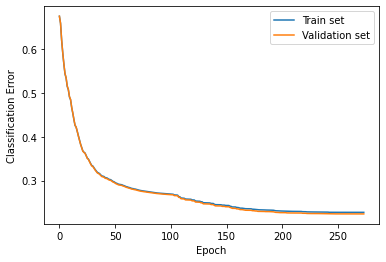

Accuracy: 89 %
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      9870
           1       0.82      0.99      0.90     10125

    accuracy                           0.89     19995
   macro avg       0.91      0.89      0.89     19995
weighted avg       0.91      0.89      0.89     19995



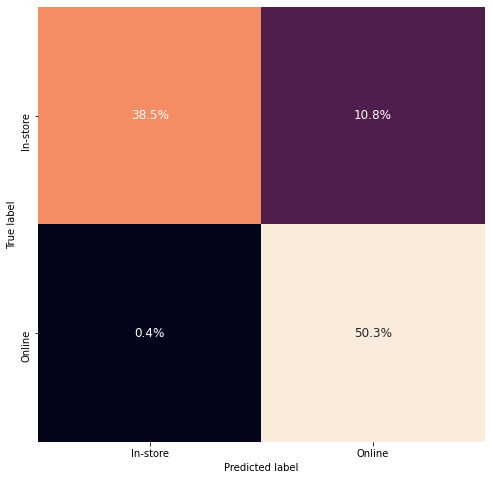

<Figure size 432x288 with 0 Axes>

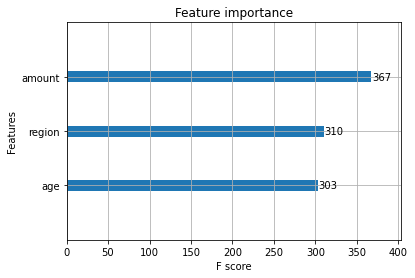

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[00:08:41] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:08:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.64685	validation_1-logloss:0.64613
[1]	validation_0-logloss:0.61579	validation_1-logloss:0.61471
[2]	validation_0-logloss:0.58357	validation_1-logloss:0.58258
[3]	validation_0-logloss:0.55139	validation_1-logloss:0.54995
[4]	validation_0-logloss:0.52356	validation_1-logloss:0.52155
[5]	validation_0-logloss:0.50429	validation_1-loglo

[120]	validation_0-logloss:0.22671	validation_1-logloss:0.22349
[121]	validation_0-logloss:0.22671	validation_1-logloss:0.22351
[122]	validation_0-logloss:0.22668	validation_1-logloss:0.22346
[123]	validation_0-logloss:0.22663	validation_1-logloss:0.22344
[124]	validation_0-logloss:0.22660	validation_1-logloss:0.22345
[125]	validation_0-logloss:0.22659	validation_1-logloss:0.22346
[126]	validation_0-logloss:0.22659	validation_1-logloss:0.22346
[127]	validation_0-logloss:0.22658	validation_1-logloss:0.22348
[128]	validation_0-logloss:0.22657	validation_1-logloss:0.22348
[129]	validation_0-logloss:0.22651	validation_1-logloss:0.22357
[130]	validation_0-logloss:0.22650	validation_1-logloss:0.22357
[131]	validation_0-logloss:0.22645	validation_1-logloss:0.22357
[132]	validation_0-logloss:0.22642	validation_1-logloss:0.22352
[133]	validation_0-logloss:0.22640	validation_1-logloss:0.22351
[134]	validation_0-logloss:0.22621	validation_1-logloss:0.22334
[135]	validation_0-logloss:0.22618	valid

[84]	validation_0-logloss:0.22949	validation_1-logloss:0.22608
[85]	validation_0-logloss:0.22931	validation_1-logloss:0.22594
[86]	validation_0-logloss:0.22927	validation_1-logloss:0.22591
[87]	validation_0-logloss:0.22923	validation_1-logloss:0.22589
[88]	validation_0-logloss:0.22914	validation_1-logloss:0.22590
[89]	validation_0-logloss:0.22903	validation_1-logloss:0.22578
[90]	validation_0-logloss:0.22882	validation_1-logloss:0.22559
[91]	validation_0-logloss:0.22866	validation_1-logloss:0.22542
[92]	validation_0-logloss:0.22857	validation_1-logloss:0.22531
[93]	validation_0-logloss:0.22855	validation_1-logloss:0.22531
[94]	validation_0-logloss:0.22842	validation_1-logloss:0.22518
[95]	validation_0-logloss:0.22834	validation_1-logloss:0.22508
[96]	validation_0-logloss:0.22830	validation_1-logloss:0.22506
[97]	validation_0-logloss:0.22827	validation_1-logloss:0.22508
[98]	validation_0-logloss:0.22813	validation_1-logloss:0.22500
[99]	validation_0-logloss:0.22811	validation_1-logloss:

[213]	validation_0-logloss:0.22556	validation_1-logloss:0.22332
[214]	validation_0-logloss:0.22556	validation_1-logloss:0.22332
[215]	validation_0-logloss:0.22555	validation_1-logloss:0.22331
[216]	validation_0-logloss:0.22555	validation_1-logloss:0.22331
[217]	validation_0-logloss:0.22554	validation_1-logloss:0.22330
[218]	validation_0-logloss:0.22554	validation_1-logloss:0.22330
[219]	validation_0-logloss:0.22554	validation_1-logloss:0.22330
[220]	validation_0-logloss:0.22553	validation_1-logloss:0.22330
[221]	validation_0-logloss:0.22553	validation_1-logloss:0.22329
[222]	validation_0-logloss:0.22552	validation_1-logloss:0.22329
[223]	validation_0-logloss:0.22552	validation_1-logloss:0.22330
[224]	validation_0-logloss:0.22552	validation_1-logloss:0.22329
[225]	validation_0-logloss:0.22549	validation_1-logloss:0.22327
[226]	validation_0-logloss:0.22547	validation_1-logloss:0.22325
[227]	validation_0-logloss:0.22546	validation_1-logloss:0.22324
[228]	validation_0-logloss:0.22546	valid

[85]	validation_0-logloss:0.22926	validation_1-logloss:0.22521
[86]	validation_0-logloss:0.22922	validation_1-logloss:0.22520
[87]	validation_0-logloss:0.22917	validation_1-logloss:0.22517
[88]	validation_0-logloss:0.22910	validation_1-logloss:0.22517
[89]	validation_0-logloss:0.22895	validation_1-logloss:0.22505
[90]	validation_0-logloss:0.22864	validation_1-logloss:0.22476
[91]	validation_0-logloss:0.22847	validation_1-logloss:0.22462
[92]	validation_0-logloss:0.22838	validation_1-logloss:0.22456
[93]	validation_0-logloss:0.22823	validation_1-logloss:0.22446
[94]	validation_0-logloss:0.22811	validation_1-logloss:0.22436
[95]	validation_0-logloss:0.22802	validation_1-logloss:0.22431
[96]	validation_0-logloss:0.22799	validation_1-logloss:0.22428
[97]	validation_0-logloss:0.22796	validation_1-logloss:0.22425
[98]	validation_0-logloss:0.22784	validation_1-logloss:0.22418
[99]	validation_0-logloss:0.22778	validation_1-logloss:0.22415
[100]	validation_0-logloss:0.22771	validation_1-logloss

[49]	validation_0-logloss:0.24544	validation_1-logloss:0.24080
[50]	validation_0-logloss:0.24405	validation_1-logloss:0.23952
[51]	validation_0-logloss:0.24323	validation_1-logloss:0.23864
[52]	validation_0-logloss:0.24203	validation_1-logloss:0.23748
[53]	validation_0-logloss:0.24081	validation_1-logloss:0.23628
[54]	validation_0-logloss:0.24025	validation_1-logloss:0.23572
[55]	validation_0-logloss:0.23920	validation_1-logloss:0.23465
[56]	validation_0-logloss:0.23861	validation_1-logloss:0.23400
[57]	validation_0-logloss:0.23773	validation_1-logloss:0.23317
[58]	validation_0-logloss:0.23723	validation_1-logloss:0.23269
[59]	validation_0-logloss:0.23647	validation_1-logloss:0.23192
[60]	validation_0-logloss:0.23608	validation_1-logloss:0.23153
[61]	validation_0-logloss:0.23570	validation_1-logloss:0.23115
[62]	validation_0-logloss:0.23506	validation_1-logloss:0.23054
[63]	validation_0-logloss:0.23472	validation_1-logloss:0.23026
[64]	validation_0-logloss:0.23418	validation_1-logloss:

[9]	validation_0-logloss:0.42498	validation_1-logloss:0.42199
[10]	validation_0-logloss:0.41375	validation_1-logloss:0.41047
[11]	validation_0-logloss:0.39926	validation_1-logloss:0.39583
[12]	validation_0-logloss:0.38473	validation_1-logloss:0.38112
[13]	validation_0-logloss:0.37364	validation_1-logloss:0.37005
[14]	validation_0-logloss:0.36343	validation_1-logloss:0.35965
[15]	validation_0-logloss:0.35362	validation_1-logloss:0.34967
[16]	validation_0-logloss:0.34829	validation_1-logloss:0.34436
[17]	validation_0-logloss:0.34037	validation_1-logloss:0.33625
[18]	validation_0-logloss:0.33279	validation_1-logloss:0.32844
[19]	validation_0-logloss:0.32587	validation_1-logloss:0.32141
[20]	validation_0-logloss:0.31986	validation_1-logloss:0.31528
[21]	validation_0-logloss:0.31442	validation_1-logloss:0.30961
[22]	validation_0-logloss:0.30760	validation_1-logloss:0.30281
[23]	validation_0-logloss:0.30619	validation_1-logloss:0.30137
[24]	validation_0-logloss:0.30191	validation_1-logloss:0

[139]	validation_0-logloss:0.22587	validation_1-logloss:0.22318
[140]	validation_0-logloss:0.22586	validation_1-logloss:0.22318
[141]	validation_0-logloss:0.22584	validation_1-logloss:0.22318
[142]	validation_0-logloss:0.22582	validation_1-logloss:0.22316
[143]	validation_0-logloss:0.22581	validation_1-logloss:0.22315
[144]	validation_0-logloss:0.22579	validation_1-logloss:0.22316
[145]	validation_0-logloss:0.22578	validation_1-logloss:0.22314
[146]	validation_0-logloss:0.22574	validation_1-logloss:0.22318
[147]	validation_0-logloss:0.22571	validation_1-logloss:0.22311
[148]	validation_0-logloss:0.22570	validation_1-logloss:0.22313
[149]	validation_0-logloss:0.22569	validation_1-logloss:0.22314
[150]	validation_0-logloss:0.22569	validation_1-logloss:0.22314
[151]	validation_0-logloss:0.22567	validation_1-logloss:0.22315
[152]	validation_0-logloss:0.22567	validation_1-logloss:0.22313
[153]	validation_0-logloss:0.22566	validation_1-logloss:0.22314
[154]	validation_0-logloss:0.22562	valid

[44]	validation_0-logloss:0.23136	validation_1-logloss:0.22734
[45]	validation_0-logloss:0.23063	validation_1-logloss:0.22669
[46]	validation_0-logloss:0.23007	validation_1-logloss:0.22608
[47]	validation_0-logloss:0.22946	validation_1-logloss:0.22551
[48]	validation_0-logloss:0.22890	validation_1-logloss:0.22501
[49]	validation_0-logloss:0.22841	validation_1-logloss:0.22453
[50]	validation_0-logloss:0.22805	validation_1-logloss:0.22407
[51]	validation_0-logloss:0.22761	validation_1-logloss:0.22369
[52]	validation_0-logloss:0.22721	validation_1-logloss:0.22335
[53]	validation_0-logloss:0.22697	validation_1-logloss:0.22313
[54]	validation_0-logloss:0.22662	validation_1-logloss:0.22283
[55]	validation_0-logloss:0.22646	validation_1-logloss:0.22267
[56]	validation_0-logloss:0.22615	validation_1-logloss:0.22240
[57]	validation_0-logloss:0.22591	validation_1-logloss:0.22220
[58]	validation_0-logloss:0.22575	validation_1-logloss:0.22202
[59]	validation_0-logloss:0.22547	validation_1-logloss:

[66]	validation_0-logloss:0.22452	validation_1-logloss:0.22320
[67]	validation_0-logloss:0.22446	validation_1-logloss:0.22314
[68]	validation_0-logloss:0.22438	validation_1-logloss:0.22309
[69]	validation_0-logloss:0.22433	validation_1-logloss:0.22305
[70]	validation_0-logloss:0.22429	validation_1-logloss:0.22304
[71]	validation_0-logloss:0.22416	validation_1-logloss:0.22305
[72]	validation_0-logloss:0.22413	validation_1-logloss:0.22302
[73]	validation_0-logloss:0.22393	validation_1-logloss:0.22306
[74]	validation_0-logloss:0.22384	validation_1-logloss:0.22309
[75]	validation_0-logloss:0.22377	validation_1-logloss:0.22309
[76]	validation_0-logloss:0.22364	validation_1-logloss:0.22304
[77]	validation_0-logloss:0.22353	validation_1-logloss:0.22308
[78]	validation_0-logloss:0.22345	validation_1-logloss:0.22315
[79]	validation_0-logloss:0.22337	validation_1-logloss:0.22315
[80]	validation_0-logloss:0.22327	validation_1-logloss:0.22320
[81]	validation_0-logloss:0.22319	validation_1-logloss:

[93]	validation_0-logloss:0.22194	validation_1-logloss:0.22111
[94]	validation_0-logloss:0.22190	validation_1-logloss:0.22111
[95]	validation_0-logloss:0.22189	validation_1-logloss:0.22110
[96]	validation_0-logloss:0.22184	validation_1-logloss:0.22114
[97]	validation_0-logloss:0.22169	validation_1-logloss:0.22122
[98]	validation_0-logloss:0.22166	validation_1-logloss:0.22114
[99]	validation_0-logloss:0.22156	validation_1-logloss:0.22122
[100]	validation_0-logloss:0.22152	validation_1-logloss:0.22121
[101]	validation_0-logloss:0.22150	validation_1-logloss:0.22120
[102]	validation_0-logloss:0.22143	validation_1-logloss:0.22126
[103]	validation_0-logloss:0.22134	validation_1-logloss:0.22127
[104]	validation_0-logloss:0.22132	validation_1-logloss:0.22127
[105]	validation_0-logloss:0.22128	validation_1-logloss:0.22129
[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=8, min_child_weight=10;, score=0.996 total time=   4.0s
[00:09:15] WARNING: ..\src\learner.cc:541: 
Parameters: { silen

[00:09:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.64004	validation_1-logloss:0.63959
[1]	validation_0-logloss:0.59442	validation_1-logloss:0.59390
[2]	validation_0-logloss:0.55526	validation_1-logloss:0.55451
[3]	validation_0-logloss:0.52140	validation_1-logloss:0.52028
[4]	validation_0-logloss:0.49169	validation_1-logloss:0.49034
[5]	validation_0-logloss:0.46533	validation_1-logloss:0.46395
[6]	validation_0-logloss:0.44225	validation_1-logloss:0.44059
[7]	validation_0-logloss:0.42183	validation_1-logloss:0.41984
[8]	validation_0-logloss:0.40328	validation_1-logloss:0.40127
[9]	validation_0-logloss:0.38694	validation_1-logloss:0.38465
[10]	validation_0-logloss:0.37227	validation_1-logloss:0.36974
[11]	validation_0-logloss:0.35899	validation_1-logloss:0.35633
[1

[17]	validation_0-logloss:0.33355	validation_1-logloss:0.33086
[18]	validation_0-logloss:0.32589	validation_1-logloss:0.32318
[19]	validation_0-logloss:0.31903	validation_1-logloss:0.31628
[20]	validation_0-logloss:0.31287	validation_1-logloss:0.31005
[21]	validation_0-logloss:0.30741	validation_1-logloss:0.30452
[22]	validation_0-logloss:0.30075	validation_1-logloss:0.29793
[23]	validation_0-logloss:0.29671	validation_1-logloss:0.29383
[24]	validation_0-logloss:0.29247	validation_1-logloss:0.28956
[25]	validation_0-logloss:0.28864	validation_1-logloss:0.28569
[26]	validation_0-logloss:0.28486	validation_1-logloss:0.28189
[27]	validation_0-logloss:0.28061	validation_1-logloss:0.27772
[28]	validation_0-logloss:0.27770	validation_1-logloss:0.27480
[29]	validation_0-logloss:0.27401	validation_1-logloss:0.27117
[30]	validation_0-logloss:0.27065	validation_1-logloss:0.26785
[31]	validation_0-logloss:0.26802	validation_1-logloss:0.26516
[32]	validation_0-logloss:0.26580	validation_1-logloss:

[0]	validation_0-logloss:0.64631	validation_1-logloss:0.64575
[1]	validation_0-logloss:0.61274	validation_1-logloss:0.61204
[2]	validation_0-logloss:0.58073	validation_1-logloss:0.58020
[3]	validation_0-logloss:0.54842	validation_1-logloss:0.54754
[4]	validation_0-logloss:0.52031	validation_1-logloss:0.51911
[5]	validation_0-logloss:0.49942	validation_1-logloss:0.49811
[6]	validation_0-logloss:0.47891	validation_1-logloss:0.47767
[7]	validation_0-logloss:0.45824	validation_1-logloss:0.45681
[8]	validation_0-logloss:0.44005	validation_1-logloss:0.43833
[9]	validation_0-logloss:0.42079	validation_1-logloss:0.41896
[10]	validation_0-logloss:0.40821	validation_1-logloss:0.40642
[11]	validation_0-logloss:0.39361	validation_1-logloss:0.39165
[12]	validation_0-logloss:0.37909	validation_1-logloss:0.37709
[13]	validation_0-logloss:0.36838	validation_1-logloss:0.36643
[14]	validation_0-logloss:0.35826	validation_1-logloss:0.35618
[15]	validation_0-logloss:0.34832	validation_1-logloss:0.34616
[1

[130]	validation_0-logloss:0.22320	validation_1-logloss:0.22525
[131]	validation_0-logloss:0.22318	validation_1-logloss:0.22522
[132]	validation_0-logloss:0.22315	validation_1-logloss:0.22524
[133]	validation_0-logloss:0.22313	validation_1-logloss:0.22523
[134]	validation_0-logloss:0.22312	validation_1-logloss:0.22524
[135]	validation_0-logloss:0.22311	validation_1-logloss:0.22522
[136]	validation_0-logloss:0.22310	validation_1-logloss:0.22524
[137]	validation_0-logloss:0.22310	validation_1-logloss:0.22526
[138]	validation_0-logloss:0.22309	validation_1-logloss:0.22525
[139]	validation_0-logloss:0.22308	validation_1-logloss:0.22526
[140]	validation_0-logloss:0.22307	validation_1-logloss:0.22525
[141]	validation_0-logloss:0.22306	validation_1-logloss:0.22527
[142]	validation_0-logloss:0.22306	validation_1-logloss:0.22526
[143]	validation_0-logloss:0.22305	validation_1-logloss:0.22526
[144]	validation_0-logloss:0.22304	validation_1-logloss:0.22526
[145]	validation_0-logloss:0.22303	valid

[98]	validation_0-logloss:0.22422	validation_1-logloss:0.22485
[99]	validation_0-logloss:0.22407	validation_1-logloss:0.22468
[100]	validation_0-logloss:0.22403	validation_1-logloss:0.22467
[101]	validation_0-logloss:0.22400	validation_1-logloss:0.22465
[102]	validation_0-logloss:0.22398	validation_1-logloss:0.22465
[103]	validation_0-logloss:0.22396	validation_1-logloss:0.22470
[104]	validation_0-logloss:0.22394	validation_1-logloss:0.22470
[105]	validation_0-logloss:0.22390	validation_1-logloss:0.22467
[106]	validation_0-logloss:0.22374	validation_1-logloss:0.22453
[107]	validation_0-logloss:0.22370	validation_1-logloss:0.22450
[108]	validation_0-logloss:0.22368	validation_1-logloss:0.22456
[109]	validation_0-logloss:0.22362	validation_1-logloss:0.22460
[110]	validation_0-logloss:0.22359	validation_1-logloss:0.22459
[111]	validation_0-logloss:0.22357	validation_1-logloss:0.22463
[112]	validation_0-logloss:0.22356	validation_1-logloss:0.22465
[113]	validation_0-logloss:0.22354	validat

[89]	validation_0-logloss:0.22480	validation_1-logloss:0.22573
[90]	validation_0-logloss:0.22459	validation_1-logloss:0.22553
[91]	validation_0-logloss:0.22448	validation_1-logloss:0.22551
[92]	validation_0-logloss:0.22443	validation_1-logloss:0.22548
[93]	validation_0-logloss:0.22439	validation_1-logloss:0.22550
[94]	validation_0-logloss:0.22434	validation_1-logloss:0.22550
[95]	validation_0-logloss:0.22430	validation_1-logloss:0.22548
[96]	validation_0-logloss:0.22428	validation_1-logloss:0.22550
[97]	validation_0-logloss:0.22421	validation_1-logloss:0.22549
[98]	validation_0-logloss:0.22417	validation_1-logloss:0.22549
[99]	validation_0-logloss:0.22414	validation_1-logloss:0.22546
[100]	validation_0-logloss:0.22404	validation_1-logloss:0.22535
[101]	validation_0-logloss:0.22402	validation_1-logloss:0.22533
[102]	validation_0-logloss:0.22400	validation_1-logloss:0.22533
[103]	validation_0-logloss:0.22398	validation_1-logloss:0.22534
[104]	validation_0-logloss:0.22397	validation_1-log

[71]	validation_0-logloss:0.22694	validation_1-logloss:0.22660
[72]	validation_0-logloss:0.22676	validation_1-logloss:0.22646
[73]	validation_0-logloss:0.22658	validation_1-logloss:0.22634
[74]	validation_0-logloss:0.22646	validation_1-logloss:0.22625
[75]	validation_0-logloss:0.22629	validation_1-logloss:0.22623
[76]	validation_0-logloss:0.22595	validation_1-logloss:0.22602
[77]	validation_0-logloss:0.22584	validation_1-logloss:0.22594
[78]	validation_0-logloss:0.22579	validation_1-logloss:0.22597
[79]	validation_0-logloss:0.22574	validation_1-logloss:0.22599
[80]	validation_0-logloss:0.22558	validation_1-logloss:0.22590
[81]	validation_0-logloss:0.22534	validation_1-logloss:0.22568
[82]	validation_0-logloss:0.22520	validation_1-logloss:0.22564
[83]	validation_0-logloss:0.22507	validation_1-logloss:0.22559
[84]	validation_0-logloss:0.22496	validation_1-logloss:0.22553
[85]	validation_0-logloss:0.22490	validation_1-logloss:0.22552
[86]	validation_0-logloss:0.22485	validation_1-logloss:

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[1]	validation_0-logloss:0.61251	validation_1-logloss:0.61167
[2]	validation_0-logloss:0.58053	validation_1-logloss:0.57977
[3]	validation_0-logloss:0.54835	validation_1-logloss:0.54708
[4]	validation_0-logloss:0.52004	validation_1-logloss:0.51864
[5]	validation_0-logloss:0.49920	validation_1-logloss:0.49746
[6]	validation_0-logloss:0.47878	validation_1-logloss:0.47701
[7]	validation_0-logloss:0.45809	validation_1-logloss:0.45609
[8]	validation_0-logloss:0.43981	validation_1-logloss:0.43759
[9]	validation_0-logloss:0.42058	validation_1-logloss:0.41818
[10]	validation_0-logloss:0.40802	validation_1-logloss:0.40543
[11]	validation_0-logloss:0.39350	validation_1-logloss:0.39077
[12]	validation_0-logloss:0.37899	validation_1-logloss:0.37620
[13]	validation_0-logloss:0.36829	validation_1-logloss:0.36553
[14]	validation_0-logloss:0.35812	validation_1-logloss:0.35519
[15]	validation_0-logloss:0.34827	validation_1-logloss:0.34522
[16]	validation_0-logloss:0.34107	validation_1-logloss:0.33793
[

[00:09:56] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.64619	validation_1-logloss:0.64560
[1]	validation_0-logloss:0.61238	validation_1-logloss:0.61166
[2]	validation_0-logloss:0.58046	validation_1-logloss:0.57980
[3]	validation_0-logloss:0.54802	validation_1-logloss:0.54707
[4]	validation_0-logloss:0.52005	validation_1-logloss:0.51856
[5]	validation_0-logloss:0.49904	validation_1-logloss:0.49745
[6]	validation_0-logloss:0.47852	validation_1-logloss:0.47702
[7]	validation_0-logloss:0.45786	validation_1-logloss:0.45608
[8]	validation_0-logloss:0.43965	validation_1-logloss:0.43753
[9]	validation_0-logloss:0.42038	validation_1-logloss:0.41817
[10]	validation_0-logloss:0.40782	validation_1-logloss:0.40550
[11]	validation_0-logloss:0.39331	validation_1-logloss:0.39087
[1

[126]	validation_0-logloss:0.22096	validation_1-logloss:0.22291
[127]	validation_0-logloss:0.22089	validation_1-logloss:0.22293
[128]	validation_0-logloss:0.22089	validation_1-logloss:0.22293
[129]	validation_0-logloss:0.22083	validation_1-logloss:0.22295
[130]	validation_0-logloss:0.22080	validation_1-logloss:0.22292
[131]	validation_0-logloss:0.22079	validation_1-logloss:0.22292
[132]	validation_0-logloss:0.22078	validation_1-logloss:0.22293
[133]	validation_0-logloss:0.22076	validation_1-logloss:0.22290
[134]	validation_0-logloss:0.22076	validation_1-logloss:0.22289
[135]	validation_0-logloss:0.22075	validation_1-logloss:0.22289
[136]	validation_0-logloss:0.22074	validation_1-logloss:0.22288
[137]	validation_0-logloss:0.22064	validation_1-logloss:0.22290
[138]	validation_0-logloss:0.22062	validation_1-logloss:0.22287
[139]	validation_0-logloss:0.22061	validation_1-logloss:0.22287
[140]	validation_0-logloss:0.22060	validation_1-logloss:0.22286
[141]	validation_0-logloss:0.22059	valid

[255]	validation_0-logloss:0.21965	validation_1-logloss:0.22255
[256]	validation_0-logloss:0.21965	validation_1-logloss:0.22255
[257]	validation_0-logloss:0.21965	validation_1-logloss:0.22255
[258]	validation_0-logloss:0.21965	validation_1-logloss:0.22255
[259]	validation_0-logloss:0.21965	validation_1-logloss:0.22255
[260]	validation_0-logloss:0.21965	validation_1-logloss:0.22255
[261]	validation_0-logloss:0.21965	validation_1-logloss:0.22255
[262]	validation_0-logloss:0.21965	validation_1-logloss:0.22255
[263]	validation_0-logloss:0.21965	validation_1-logloss:0.22255
[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=8, min_child_weight=10;, score=0.991 total time=   8.5s
[00:10:04] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abo

[110]	validation_0-logloss:0.22170	validation_1-logloss:0.22182
[111]	validation_0-logloss:0.22149	validation_1-logloss:0.22182
[112]	validation_0-logloss:0.22134	validation_1-logloss:0.22191
[113]	validation_0-logloss:0.22132	validation_1-logloss:0.22191
[114]	validation_0-logloss:0.22129	validation_1-logloss:0.22190
[115]	validation_0-logloss:0.22119	validation_1-logloss:0.22194
[116]	validation_0-logloss:0.22116	validation_1-logloss:0.22191
[117]	validation_0-logloss:0.22113	validation_1-logloss:0.22189
[118]	validation_0-logloss:0.22111	validation_1-logloss:0.22187
[119]	validation_0-logloss:0.22096	validation_1-logloss:0.22186
[120]	validation_0-logloss:0.22094	validation_1-logloss:0.22187
[121]	validation_0-logloss:0.22091	validation_1-logloss:0.22189
[122]	validation_0-logloss:0.22089	validation_1-logloss:0.22189
[123]	validation_0-logloss:0.22065	validation_1-logloss:0.22193
[124]	validation_0-logloss:0.22062	validation_1-logloss:0.22192
[125]	validation_0-logloss:0.22059	valid

[73]	validation_0-logloss:0.22580	validation_1-logloss:0.22401
[74]	validation_0-logloss:0.22564	validation_1-logloss:0.22387
[75]	validation_0-logloss:0.22545	validation_1-logloss:0.22369
[76]	validation_0-logloss:0.22510	validation_1-logloss:0.22339
[77]	validation_0-logloss:0.22498	validation_1-logloss:0.22327
[78]	validation_0-logloss:0.22486	validation_1-logloss:0.22314
[79]	validation_0-logloss:0.22473	validation_1-logloss:0.22305
[80]	validation_0-logloss:0.22445	validation_1-logloss:0.22282
[81]	validation_0-logloss:0.22425	validation_1-logloss:0.22264
[82]	validation_0-logloss:0.22396	validation_1-logloss:0.22243
[83]	validation_0-logloss:0.22381	validation_1-logloss:0.22232
[84]	validation_0-logloss:0.22356	validation_1-logloss:0.22217
[85]	validation_0-logloss:0.22351	validation_1-logloss:0.22214
[86]	validation_0-logloss:0.22341	validation_1-logloss:0.22213
[87]	validation_0-logloss:0.22336	validation_1-logloss:0.22205
[88]	validation_0-logloss:0.22329	validation_1-logloss:

[64]	validation_0-logloss:0.22859	validation_1-logloss:0.22602
[65]	validation_0-logloss:0.22835	validation_1-logloss:0.22581
[66]	validation_0-logloss:0.22781	validation_1-logloss:0.22536
[67]	validation_0-logloss:0.22753	validation_1-logloss:0.22514
[68]	validation_0-logloss:0.22721	validation_1-logloss:0.22494
[69]	validation_0-logloss:0.22690	validation_1-logloss:0.22471
[70]	validation_0-logloss:0.22669	validation_1-logloss:0.22452
[71]	validation_0-logloss:0.22632	validation_1-logloss:0.22418
[72]	validation_0-logloss:0.22610	validation_1-logloss:0.22396
[73]	validation_0-logloss:0.22589	validation_1-logloss:0.22381
[74]	validation_0-logloss:0.22572	validation_1-logloss:0.22366
[75]	validation_0-logloss:0.22556	validation_1-logloss:0.22354
[76]	validation_0-logloss:0.22522	validation_1-logloss:0.22326
[77]	validation_0-logloss:0.22505	validation_1-logloss:0.22319
[78]	validation_0-logloss:0.22492	validation_1-logloss:0.22310
[79]	validation_0-logloss:0.22483	validation_1-logloss:

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[2]	validation_0-logloss:0.58347	validation_1-logloss:0.58249
[3]	validation_0-logloss:0.55116	validation_1-logloss:0.54984
[4]	validation_0-logloss:0.52338	validation_1-logloss:0.52142
[5]	validation_0-logloss:0.50406	validation_1-logloss:0.50186
[6]	validation_0-logloss:0.48311	validation_1-logloss:0.48098
[7]	validation_0-logloss:0.46248	validation_1-logloss:0.45997
[8]	validation_0-logloss:0.44430	validation_1-logloss:0.44145
[9]	validation_0-logloss:0.42494	validation_1-logloss:0.42194
[10]	validation_0-logloss:0.41369	validation_1-logloss:0.41045
[11]	validation_0-logloss:0.39918	validation_1-logloss:0.39576
[12]	validation_0-logloss:0.38470	validation_1-logloss:0.38107
[13]	validation_0-logloss:0.37346	validation_1-logloss:0.36997
[14]	validation_0-logloss:0.36331	validation_1-logloss:0.35953
[15]	validation_0-logloss:0.35347	validation_1-logloss:0.34958
[16]	validation_0-logloss:0.34813	validation_1-logloss:0.34429
[17]	validation_0-logloss:0.34027	validation_1-logloss:0.33621


[132]	validation_0-logloss:0.22415	validation_1-logloss:0.22083
[133]	validation_0-logloss:0.22406	validation_1-logloss:0.22074
[134]	validation_0-logloss:0.22403	validation_1-logloss:0.22074
[135]	validation_0-logloss:0.22395	validation_1-logloss:0.22064
[136]	validation_0-logloss:0.22390	validation_1-logloss:0.22063
[137]	validation_0-logloss:0.22383	validation_1-logloss:0.22063
[138]	validation_0-logloss:0.22378	validation_1-logloss:0.22064
[139]	validation_0-logloss:0.22366	validation_1-logloss:0.22063
[140]	validation_0-logloss:0.22365	validation_1-logloss:0.22063
[141]	validation_0-logloss:0.22358	validation_1-logloss:0.22063
[142]	validation_0-logloss:0.22350	validation_1-logloss:0.22057
[143]	validation_0-logloss:0.22347	validation_1-logloss:0.22056
[144]	validation_0-logloss:0.22341	validation_1-logloss:0.22054
[145]	validation_0-logloss:0.22339	validation_1-logloss:0.22054
[146]	validation_0-logloss:0.22334	validation_1-logloss:0.22052
[147]	validation_0-logloss:0.22318	valid

[17]	validation_0-logloss:0.34008	validation_1-logloss:0.33633
[18]	validation_0-logloss:0.33246	validation_1-logloss:0.32854
[19]	validation_0-logloss:0.32552	validation_1-logloss:0.32154
[20]	validation_0-logloss:0.31954	validation_1-logloss:0.31544
[21]	validation_0-logloss:0.31408	validation_1-logloss:0.30984
[22]	validation_0-logloss:0.30732	validation_1-logloss:0.30306
[23]	validation_0-logloss:0.30585	validation_1-logloss:0.30158
[24]	validation_0-logloss:0.30148	validation_1-logloss:0.29712
[25]	validation_0-logloss:0.29751	validation_1-logloss:0.29310
[26]	validation_0-logloss:0.29368	validation_1-logloss:0.28922
[27]	validation_0-logloss:0.28885	validation_1-logloss:0.28445
[28]	validation_0-logloss:0.28743	validation_1-logloss:0.28312
[29]	validation_0-logloss:0.28317	validation_1-logloss:0.27887
[30]	validation_0-logloss:0.27918	validation_1-logloss:0.27498
[31]	validation_0-logloss:0.27642	validation_1-logloss:0.27213
[32]	validation_0-logloss:0.27535	validation_1-logloss:

[147]	validation_0-logloss:0.22340	validation_1-logloss:0.22154
[148]	validation_0-logloss:0.22339	validation_1-logloss:0.22152
[149]	validation_0-logloss:0.22338	validation_1-logloss:0.22152
[150]	validation_0-logloss:0.22337	validation_1-logloss:0.22151
[151]	validation_0-logloss:0.22335	validation_1-logloss:0.22154
[152]	validation_0-logloss:0.22323	validation_1-logloss:0.22148
[153]	validation_0-logloss:0.22323	validation_1-logloss:0.22147
[154]	validation_0-logloss:0.22315	validation_1-logloss:0.22146
[155]	validation_0-logloss:0.22315	validation_1-logloss:0.22146
[156]	validation_0-logloss:0.22309	validation_1-logloss:0.22138
[157]	validation_0-logloss:0.22309	validation_1-logloss:0.22138
[158]	validation_0-logloss:0.22307	validation_1-logloss:0.22140
[159]	validation_0-logloss:0.22307	validation_1-logloss:0.22140
[160]	validation_0-logloss:0.22307	validation_1-logloss:0.22140
[161]	validation_0-logloss:0.22307	validation_1-logloss:0.22140
[162]	validation_0-logloss:0.22307	valid

[75]	validation_0-logloss:0.23067	validation_1-logloss:0.22629
[76]	validation_0-logloss:0.23032	validation_1-logloss:0.22596
[77]	validation_0-logloss:0.23020	validation_1-logloss:0.22583
[78]	validation_0-logloss:0.23004	validation_1-logloss:0.22572
[79]	validation_0-logloss:0.22991	validation_1-logloss:0.22562
[80]	validation_0-logloss:0.22962	validation_1-logloss:0.22534
[81]	validation_0-logloss:0.22931	validation_1-logloss:0.22503
[82]	validation_0-logloss:0.22913	validation_1-logloss:0.22482
[83]	validation_0-logloss:0.22887	validation_1-logloss:0.22458
[84]	validation_0-logloss:0.22870	validation_1-logloss:0.22442
[85]	validation_0-logloss:0.22861	validation_1-logloss:0.22435
[86]	validation_0-logloss:0.22851	validation_1-logloss:0.22428
[87]	validation_0-logloss:0.22846	validation_1-logloss:0.22422
[88]	validation_0-logloss:0.22840	validation_1-logloss:0.22416
[89]	validation_0-logloss:0.22807	validation_1-logloss:0.22386
[90]	validation_0-logloss:0.22796	validation_1-logloss:

[38]	validation_0-logloss:0.25935	validation_1-logloss:0.25458
[39]	validation_0-logloss:0.25712	validation_1-logloss:0.25238
[40]	validation_0-logloss:0.25565	validation_1-logloss:0.25091
[41]	validation_0-logloss:0.25421	validation_1-logloss:0.24948
[42]	validation_0-logloss:0.25308	validation_1-logloss:0.24834
[43]	validation_0-logloss:0.25201	validation_1-logloss:0.24729
[44]	validation_0-logloss:0.25104	validation_1-logloss:0.24634
[45]	validation_0-logloss:0.24969	validation_1-logloss:0.24497
[46]	validation_0-logloss:0.24788	validation_1-logloss:0.24316
[47]	validation_0-logloss:0.24688	validation_1-logloss:0.24216
[48]	validation_0-logloss:0.24570	validation_1-logloss:0.24107
[49]	validation_0-logloss:0.24483	validation_1-logloss:0.24016
[50]	validation_0-logloss:0.24348	validation_1-logloss:0.23885
[51]	validation_0-logloss:0.24270	validation_1-logloss:0.23807
[52]	validation_0-logloss:0.24151	validation_1-logloss:0.23688
[53]	validation_0-logloss:0.24028	validation_1-logloss:

[167]	validation_0-logloss:0.22282	validation_1-logloss:0.22084
[168]	validation_0-logloss:0.22276	validation_1-logloss:0.22078
[169]	validation_0-logloss:0.22269	validation_1-logloss:0.22074
[170]	validation_0-logloss:0.22265	validation_1-logloss:0.22072
[171]	validation_0-logloss:0.22265	validation_1-logloss:0.22072
[172]	validation_0-logloss:0.22265	validation_1-logloss:0.22072
[173]	validation_0-logloss:0.22265	validation_1-logloss:0.22072
[174]	validation_0-logloss:0.22265	validation_1-logloss:0.22072
[175]	validation_0-logloss:0.22265	validation_1-logloss:0.22072
[176]	validation_0-logloss:0.22265	validation_1-logloss:0.22072
[177]	validation_0-logloss:0.22265	validation_1-logloss:0.22072
[178]	validation_0-logloss:0.22265	validation_1-logloss:0.22072
[179]	validation_0-logloss:0.22265	validation_1-logloss:0.22072
[180]	validation_0-logloss:0.22264	validation_1-logloss:0.22071
[181]	validation_0-logloss:0.22264	validation_1-logloss:0.22071
[182]	validation_0-logloss:0.22263	valid

[68]	validation_0-logloss:0.23225	validation_1-logloss:0.22758
[69]	validation_0-logloss:0.23200	validation_1-logloss:0.22733
[70]	validation_0-logloss:0.23178	validation_1-logloss:0.22713
[71]	validation_0-logloss:0.23125	validation_1-logloss:0.22661
[72]	validation_0-logloss:0.23097	validation_1-logloss:0.22632
[73]	validation_0-logloss:0.23082	validation_1-logloss:0.22614
[74]	validation_0-logloss:0.23067	validation_1-logloss:0.22600
[75]	validation_0-logloss:0.23049	validation_1-logloss:0.22585
[76]	validation_0-logloss:0.23011	validation_1-logloss:0.22550
[77]	validation_0-logloss:0.22997	validation_1-logloss:0.22538
[78]	validation_0-logloss:0.22985	validation_1-logloss:0.22525
[79]	validation_0-logloss:0.22974	validation_1-logloss:0.22514
[80]	validation_0-logloss:0.22946	validation_1-logloss:0.22484
[81]	validation_0-logloss:0.22908	validation_1-logloss:0.22447
[82]	validation_0-logloss:0.22886	validation_1-logloss:0.22426
[83]	validation_0-logloss:0.22864	validation_1-logloss:

[31]	validation_0-logloss:0.31660	validation_1-logloss:0.31565
[32]	validation_0-logloss:0.31478	validation_1-logloss:0.31386
[33]	validation_0-logloss:0.31232	validation_1-logloss:0.31143
[34]	validation_0-logloss:0.31008	validation_1-logloss:0.30924
[35]	validation_0-logloss:0.30545	validation_1-logloss:0.30470
[36]	validation_0-logloss:0.30278	validation_1-logloss:0.30197
[37]	validation_0-logloss:0.30102	validation_1-logloss:0.30024
[38]	validation_0-logloss:0.29713	validation_1-logloss:0.29644
[39]	validation_0-logloss:0.29359	validation_1-logloss:0.29300
[40]	validation_0-logloss:0.28997	validation_1-logloss:0.28947
[41]	validation_0-logloss:0.28805	validation_1-logloss:0.28749
[42]	validation_0-logloss:0.28416	validation_1-logloss:0.28357
[43]	validation_0-logloss:0.28299	validation_1-logloss:0.28243
[44]	validation_0-logloss:0.28006	validation_1-logloss:0.27971
[45]	validation_0-logloss:0.27793	validation_1-logloss:0.27751
[46]	validation_0-logloss:0.27472	validation_1-logloss:

[161]	validation_0-logloss:0.21476	validation_1-logloss:0.22230
[162]	validation_0-logloss:0.21473	validation_1-logloss:0.22231
[163]	validation_0-logloss:0.21466	validation_1-logloss:0.22228
[164]	validation_0-logloss:0.21463	validation_1-logloss:0.22225
[165]	validation_0-logloss:0.21447	validation_1-logloss:0.22222
[166]	validation_0-logloss:0.21440	validation_1-logloss:0.22228
[167]	validation_0-logloss:0.21423	validation_1-logloss:0.22218
[168]	validation_0-logloss:0.21422	validation_1-logloss:0.22218
[169]	validation_0-logloss:0.21421	validation_1-logloss:0.22217
[170]	validation_0-logloss:0.21413	validation_1-logloss:0.22208
[171]	validation_0-logloss:0.21401	validation_1-logloss:0.22210
[172]	validation_0-logloss:0.21386	validation_1-logloss:0.22201
[173]	validation_0-logloss:0.21383	validation_1-logloss:0.22203
[174]	validation_0-logloss:0.21363	validation_1-logloss:0.22195
[175]	validation_0-logloss:0.21359	validation_1-logloss:0.22197
[176]	validation_0-logloss:0.21347	valid

[290]	validation_0-logloss:0.21208	validation_1-logloss:0.22125
[291]	validation_0-logloss:0.21206	validation_1-logloss:0.22123
[292]	validation_0-logloss:0.21206	validation_1-logloss:0.22123
[293]	validation_0-logloss:0.21206	validation_1-logloss:0.22123
[294]	validation_0-logloss:0.21206	validation_1-logloss:0.22123
[295]	validation_0-logloss:0.21206	validation_1-logloss:0.22123
[296]	validation_0-logloss:0.21206	validation_1-logloss:0.22123
[297]	validation_0-logloss:0.21206	validation_1-logloss:0.22123
[298]	validation_0-logloss:0.21206	validation_1-logloss:0.22123
[299]	validation_0-logloss:0.21206	validation_1-logloss:0.22123
[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=10, min_child_weight=1;, score=0.989 total time=  10.2s
[00:10:53] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip t

[109]	validation_0-logloss:0.22240	validation_1-logloss:0.22752
[110]	validation_0-logloss:0.22203	validation_1-logloss:0.22715
[111]	validation_0-logloss:0.22178	validation_1-logloss:0.22706
[112]	validation_0-logloss:0.22148	validation_1-logloss:0.22687
[113]	validation_0-logloss:0.22131	validation_1-logloss:0.22671
[114]	validation_0-logloss:0.22119	validation_1-logloss:0.22656
[115]	validation_0-logloss:0.22106	validation_1-logloss:0.22644
[116]	validation_0-logloss:0.22083	validation_1-logloss:0.22633
[117]	validation_0-logloss:0.22067	validation_1-logloss:0.22617
[118]	validation_0-logloss:0.22049	validation_1-logloss:0.22614
[119]	validation_0-logloss:0.22040	validation_1-logloss:0.22603
[120]	validation_0-logloss:0.22014	validation_1-logloss:0.22590
[121]	validation_0-logloss:0.21990	validation_1-logloss:0.22584
[122]	validation_0-logloss:0.21983	validation_1-logloss:0.22577
[123]	validation_0-logloss:0.21966	validation_1-logloss:0.22571
[124]	validation_0-logloss:0.21939	valid

[238]	validation_0-logloss:0.21147	validation_1-logloss:0.22294
[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=10, min_child_weight=1;, score=0.991 total time=   8.3s
[00:11:01] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:11:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.66645	validation_1-logloss:0.66659
[1]	validation_0-logloss:0.65485	validation_1-logloss:0.65449
[2]	validation_0-logloss:0.64497	validation_1-logloss:0.64409
[3]	validation_0-logloss:0.60680	validation_1-logloss:0.60587


[118]	validation_0-logloss:0.22073	validation_1-logloss:0.22545
[119]	validation_0-logloss:0.22064	validation_1-logloss:0.22535
[120]	validation_0-logloss:0.22038	validation_1-logloss:0.22520
[121]	validation_0-logloss:0.22016	validation_1-logloss:0.22514
[122]	validation_0-logloss:0.22009	validation_1-logloss:0.22507
[123]	validation_0-logloss:0.21996	validation_1-logloss:0.22496
[124]	validation_0-logloss:0.21969	validation_1-logloss:0.22470
[125]	validation_0-logloss:0.21938	validation_1-logloss:0.22464
[126]	validation_0-logloss:0.21912	validation_1-logloss:0.22440
[127]	validation_0-logloss:0.21900	validation_1-logloss:0.22437
[128]	validation_0-logloss:0.21896	validation_1-logloss:0.22432
[129]	validation_0-logloss:0.21877	validation_1-logloss:0.22431
[130]	validation_0-logloss:0.21855	validation_1-logloss:0.22410
[131]	validation_0-logloss:0.21824	validation_1-logloss:0.22419
[132]	validation_0-logloss:0.21797	validation_1-logloss:0.22409
[133]	validation_0-logloss:0.21791	valid

[12]	validation_0-logloss:0.44299	validation_1-logloss:0.44144
[13]	validation_0-logloss:0.42928	validation_1-logloss:0.42787
[14]	validation_0-logloss:0.41903	validation_1-logloss:0.41759
[15]	validation_0-logloss:0.40489	validation_1-logloss:0.40323
[16]	validation_0-logloss:0.39814	validation_1-logloss:0.39660
[17]	validation_0-logloss:0.39000	validation_1-logloss:0.38840
[18]	validation_0-logloss:0.38322	validation_1-logloss:0.38171
[19]	validation_0-logloss:0.37537	validation_1-logloss:0.37385
[20]	validation_0-logloss:0.36960	validation_1-logloss:0.36814
[21]	validation_0-logloss:0.36047	validation_1-logloss:0.35895
[22]	validation_0-logloss:0.35228	validation_1-logloss:0.35075
[23]	validation_0-logloss:0.34547	validation_1-logloss:0.34432
[24]	validation_0-logloss:0.34048	validation_1-logloss:0.33930
[25]	validation_0-logloss:0.33398	validation_1-logloss:0.33274
[26]	validation_0-logloss:0.33005	validation_1-logloss:0.32888
[27]	validation_0-logloss:0.32780	validation_1-logloss:

[142]	validation_0-logloss:0.21699	validation_1-logloss:0.22340
[143]	validation_0-logloss:0.21696	validation_1-logloss:0.22337
[144]	validation_0-logloss:0.21683	validation_1-logloss:0.22339
[145]	validation_0-logloss:0.21668	validation_1-logloss:0.22334
[146]	validation_0-logloss:0.21666	validation_1-logloss:0.22332
[147]	validation_0-logloss:0.21639	validation_1-logloss:0.22315
[148]	validation_0-logloss:0.21623	validation_1-logloss:0.22301
[149]	validation_0-logloss:0.21612	validation_1-logloss:0.22290
[150]	validation_0-logloss:0.21610	validation_1-logloss:0.22288
[151]	validation_0-logloss:0.21604	validation_1-logloss:0.22288
[152]	validation_0-logloss:0.21583	validation_1-logloss:0.22278
[153]	validation_0-logloss:0.21580	validation_1-logloss:0.22274
[154]	validation_0-logloss:0.21570	validation_1-logloss:0.22265
[155]	validation_0-logloss:0.21560	validation_1-logloss:0.22264
[156]	validation_0-logloss:0.21559	validation_1-logloss:0.22263
[157]	validation_0-logloss:0.21550	valid

[31]	validation_0-logloss:0.31622	validation_1-logloss:0.31538
[32]	validation_0-logloss:0.31440	validation_1-logloss:0.31356
[33]	validation_0-logloss:0.31192	validation_1-logloss:0.31110
[34]	validation_0-logloss:0.30968	validation_1-logloss:0.30888
[35]	validation_0-logloss:0.30506	validation_1-logloss:0.30435
[36]	validation_0-logloss:0.30241	validation_1-logloss:0.30165
[37]	validation_0-logloss:0.30063	validation_1-logloss:0.29990
[38]	validation_0-logloss:0.29675	validation_1-logloss:0.29611
[39]	validation_0-logloss:0.29322	validation_1-logloss:0.29267
[40]	validation_0-logloss:0.28958	validation_1-logloss:0.28909
[41]	validation_0-logloss:0.28769	validation_1-logloss:0.28713
[42]	validation_0-logloss:0.28375	validation_1-logloss:0.28314
[43]	validation_0-logloss:0.28256	validation_1-logloss:0.28199
[44]	validation_0-logloss:0.27970	validation_1-logloss:0.27923
[45]	validation_0-logloss:0.27754	validation_1-logloss:0.27710
[46]	validation_0-logloss:0.27430	validation_1-logloss:

[161]	validation_0-logloss:0.21471	validation_1-logloss:0.22279
[162]	validation_0-logloss:0.21458	validation_1-logloss:0.22275
[163]	validation_0-logloss:0.21448	validation_1-logloss:0.22279
[164]	validation_0-logloss:0.21446	validation_1-logloss:0.22277
[165]	validation_0-logloss:0.21434	validation_1-logloss:0.22273
[166]	validation_0-logloss:0.21425	validation_1-logloss:0.22279
[167]	validation_0-logloss:0.21412	validation_1-logloss:0.22275
[168]	validation_0-logloss:0.21411	validation_1-logloss:0.22275
[169]	validation_0-logloss:0.21410	validation_1-logloss:0.22274
[170]	validation_0-logloss:0.21401	validation_1-logloss:0.22265
[171]	validation_0-logloss:0.21391	validation_1-logloss:0.22266
[172]	validation_0-logloss:0.21368	validation_1-logloss:0.22258
[173]	validation_0-logloss:0.21363	validation_1-logloss:0.22259
[174]	validation_0-logloss:0.21343	validation_1-logloss:0.22259
[175]	validation_0-logloss:0.21340	validation_1-logloss:0.22261
[176]	validation_0-logloss:0.21329	valid

[13]	validation_0-logloss:0.42937	validation_1-logloss:0.42763
[14]	validation_0-logloss:0.41918	validation_1-logloss:0.41737
[15]	validation_0-logloss:0.40505	validation_1-logloss:0.40306
[16]	validation_0-logloss:0.39836	validation_1-logloss:0.39647
[17]	validation_0-logloss:0.39023	validation_1-logloss:0.38828
[18]	validation_0-logloss:0.38351	validation_1-logloss:0.38163
[19]	validation_0-logloss:0.37566	validation_1-logloss:0.37384
[20]	validation_0-logloss:0.36993	validation_1-logloss:0.36815
[21]	validation_0-logloss:0.36084	validation_1-logloss:0.35908
[22]	validation_0-logloss:0.35273	validation_1-logloss:0.35095
[23]	validation_0-logloss:0.34606	validation_1-logloss:0.34452
[24]	validation_0-logloss:0.34110	validation_1-logloss:0.33951
[25]	validation_0-logloss:0.33463	validation_1-logloss:0.33301
[26]	validation_0-logloss:0.33073	validation_1-logloss:0.32915
[27]	validation_0-logloss:0.32847	validation_1-logloss:0.32688
[28]	validation_0-logloss:0.32645	validation_1-logloss:

[143]	validation_0-logloss:0.21890	validation_1-logloss:0.22408
[144]	validation_0-logloss:0.21879	validation_1-logloss:0.22409
[145]	validation_0-logloss:0.21864	validation_1-logloss:0.22406
[146]	validation_0-logloss:0.21863	validation_1-logloss:0.22404
[147]	validation_0-logloss:0.21840	validation_1-logloss:0.22398
[148]	validation_0-logloss:0.21824	validation_1-logloss:0.22383
[149]	validation_0-logloss:0.21813	validation_1-logloss:0.22372
[150]	validation_0-logloss:0.21811	validation_1-logloss:0.22371
[151]	validation_0-logloss:0.21808	validation_1-logloss:0.22370
[152]	validation_0-logloss:0.21786	validation_1-logloss:0.22352
[153]	validation_0-logloss:0.21783	validation_1-logloss:0.22349
[154]	validation_0-logloss:0.21773	validation_1-logloss:0.22339
[155]	validation_0-logloss:0.21770	validation_1-logloss:0.22341
[156]	validation_0-logloss:0.21769	validation_1-logloss:0.22340
[157]	validation_0-logloss:0.21760	validation_1-logloss:0.22331
[158]	validation_0-logloss:0.21760	valid

[42]	validation_0-logloss:0.28458	validation_1-logloss:0.28352
[43]	validation_0-logloss:0.28340	validation_1-logloss:0.28237
[44]	validation_0-logloss:0.28061	validation_1-logloss:0.27954
[45]	validation_0-logloss:0.27844	validation_1-logloss:0.27742
[46]	validation_0-logloss:0.27526	validation_1-logloss:0.27449
[47]	validation_0-logloss:0.27347	validation_1-logloss:0.27283
[48]	validation_0-logloss:0.27144	validation_1-logloss:0.27077
[49]	validation_0-logloss:0.26886	validation_1-logloss:0.26838
[50]	validation_0-logloss:0.26636	validation_1-logloss:0.26594
[51]	validation_0-logloss:0.26544	validation_1-logloss:0.26502
[52]	validation_0-logloss:0.26417	validation_1-logloss:0.26369
[53]	validation_0-logloss:0.26183	validation_1-logloss:0.26148
[54]	validation_0-logloss:0.25995	validation_1-logloss:0.25973
[55]	validation_0-logloss:0.25795	validation_1-logloss:0.25795
[56]	validation_0-logloss:0.25715	validation_1-logloss:0.25717
[57]	validation_0-logloss:0.25529	validation_1-logloss:

[171]	validation_0-logloss:0.21756	validation_1-logloss:0.22328
[172]	validation_0-logloss:0.21748	validation_1-logloss:0.22322
[173]	validation_0-logloss:0.21738	validation_1-logloss:0.22329
[174]	validation_0-logloss:0.21725	validation_1-logloss:0.22324
[175]	validation_0-logloss:0.21715	validation_1-logloss:0.22319
[176]	validation_0-logloss:0.21702	validation_1-logloss:0.22318
[177]	validation_0-logloss:0.21693	validation_1-logloss:0.22321
[178]	validation_0-logloss:0.21687	validation_1-logloss:0.22316
[179]	validation_0-logloss:0.21686	validation_1-logloss:0.22317
[180]	validation_0-logloss:0.21681	validation_1-logloss:0.22312
[181]	validation_0-logloss:0.21680	validation_1-logloss:0.22311
[182]	validation_0-logloss:0.21679	validation_1-logloss:0.22310
[183]	validation_0-logloss:0.21671	validation_1-logloss:0.22305
[184]	validation_0-logloss:0.21669	validation_1-logloss:0.22305
[185]	validation_0-logloss:0.21644	validation_1-logloss:0.22308
[186]	validation_0-logloss:0.21643	valid

[50]	validation_0-logloss:0.26622	validation_1-logloss:0.26594
[51]	validation_0-logloss:0.26532	validation_1-logloss:0.26505
[52]	validation_0-logloss:0.26403	validation_1-logloss:0.26373
[53]	validation_0-logloss:0.26171	validation_1-logloss:0.26140
[54]	validation_0-logloss:0.25982	validation_1-logloss:0.25963
[55]	validation_0-logloss:0.25782	validation_1-logloss:0.25777
[56]	validation_0-logloss:0.25703	validation_1-logloss:0.25700
[57]	validation_0-logloss:0.25516	validation_1-logloss:0.25520
[58]	validation_0-logloss:0.25415	validation_1-logloss:0.25428
[59]	validation_0-logloss:0.25343	validation_1-logloss:0.25358
[60]	validation_0-logloss:0.25219	validation_1-logloss:0.25247
[61]	validation_0-logloss:0.25077	validation_1-logloss:0.25115
[62]	validation_0-logloss:0.24918	validation_1-logloss:0.24963
[63]	validation_0-logloss:0.24797	validation_1-logloss:0.24855
[64]	validation_0-logloss:0.24734	validation_1-logloss:0.24796
[65]	validation_0-logloss:0.24621	validation_1-logloss:

[179]	validation_0-logloss:0.21664	validation_1-logloss:0.22306
[180]	validation_0-logloss:0.21659	validation_1-logloss:0.22301
[181]	validation_0-logloss:0.21656	validation_1-logloss:0.22299
[182]	validation_0-logloss:0.21655	validation_1-logloss:0.22299
[183]	validation_0-logloss:0.21646	validation_1-logloss:0.22295
[184]	validation_0-logloss:0.21645	validation_1-logloss:0.22294
[185]	validation_0-logloss:0.21639	validation_1-logloss:0.22293
[186]	validation_0-logloss:0.21634	validation_1-logloss:0.22298
[187]	validation_0-logloss:0.21634	validation_1-logloss:0.22298
[188]	validation_0-logloss:0.21630	validation_1-logloss:0.22294
[189]	validation_0-logloss:0.21627	validation_1-logloss:0.22291
[190]	validation_0-logloss:0.21618	validation_1-logloss:0.22292
[191]	validation_0-logloss:0.21617	validation_1-logloss:0.22292
[192]	validation_0-logloss:0.21616	validation_1-logloss:0.22291
[193]	validation_0-logloss:0.21615	validation_1-logloss:0.22290
[194]	validation_0-logloss:0.21615	valid

[72]	validation_0-logloss:0.24052	validation_1-logloss:0.24113
[73]	validation_0-logloss:0.23953	validation_1-logloss:0.24020
[74]	validation_0-logloss:0.23914	validation_1-logloss:0.23982
[75]	validation_0-logloss:0.23869	validation_1-logloss:0.23932
[76]	validation_0-logloss:0.23768	validation_1-logloss:0.23849
[77]	validation_0-logloss:0.23680	validation_1-logloss:0.23772
[78]	validation_0-logloss:0.23638	validation_1-logloss:0.23733
[79]	validation_0-logloss:0.23583	validation_1-logloss:0.23678
[80]	validation_0-logloss:0.23511	validation_1-logloss:0.23610
[81]	validation_0-logloss:0.23484	validation_1-logloss:0.23586
[82]	validation_0-logloss:0.23421	validation_1-logloss:0.23531
[83]	validation_0-logloss:0.23374	validation_1-logloss:0.23486
[84]	validation_0-logloss:0.23295	validation_1-logloss:0.23422
[85]	validation_0-logloss:0.23255	validation_1-logloss:0.23384
[86]	validation_0-logloss:0.23210	validation_1-logloss:0.23351
[87]	validation_0-logloss:0.23176	validation_1-logloss:

[201]	validation_0-logloss:0.21733	validation_1-logloss:0.22250
[202]	validation_0-logloss:0.21733	validation_1-logloss:0.22250
[203]	validation_0-logloss:0.21733	validation_1-logloss:0.22250
[204]	validation_0-logloss:0.21733	validation_1-logloss:0.22250
[205]	validation_0-logloss:0.21732	validation_1-logloss:0.22249
[206]	validation_0-logloss:0.21730	validation_1-logloss:0.22248
[207]	validation_0-logloss:0.21730	validation_1-logloss:0.22248
[208]	validation_0-logloss:0.21728	validation_1-logloss:0.22245
[209]	validation_0-logloss:0.21728	validation_1-logloss:0.22245
[210]	validation_0-logloss:0.21727	validation_1-logloss:0.22245
[211]	validation_0-logloss:0.21727	validation_1-logloss:0.22245
[212]	validation_0-logloss:0.21727	validation_1-logloss:0.22245
[213]	validation_0-logloss:0.21727	validation_1-logloss:0.22245
[214]	validation_0-logloss:0.21727	validation_1-logloss:0.22245
[215]	validation_0-logloss:0.21727	validation_1-logloss:0.22245
[216]	validation_0-logloss:0.21727	valid

[19]	validation_0-logloss:0.37526	validation_1-logloss:0.37369
[20]	validation_0-logloss:0.36951	validation_1-logloss:0.36798
[21]	validation_0-logloss:0.36043	validation_1-logloss:0.35893
[22]	validation_0-logloss:0.35230	validation_1-logloss:0.35080
[23]	validation_0-logloss:0.34564	validation_1-logloss:0.34436
[24]	validation_0-logloss:0.34069	validation_1-logloss:0.33937
[25]	validation_0-logloss:0.33426	validation_1-logloss:0.33288
[26]	validation_0-logloss:0.33033	validation_1-logloss:0.32900
[27]	validation_0-logloss:0.32806	validation_1-logloss:0.32676
[28]	validation_0-logloss:0.32605	validation_1-logloss:0.32475
[29]	validation_0-logloss:0.32265	validation_1-logloss:0.32140
[30]	validation_0-logloss:0.31958	validation_1-logloss:0.31839
[31]	validation_0-logloss:0.31682	validation_1-logloss:0.31567
[32]	validation_0-logloss:0.31500	validation_1-logloss:0.31385
[33]	validation_0-logloss:0.31252	validation_1-logloss:0.31138
[34]	validation_0-logloss:0.31027	validation_1-logloss:

[149]	validation_0-logloss:0.21862	validation_1-logloss:0.22347
[150]	validation_0-logloss:0.21861	validation_1-logloss:0.22346
[151]	validation_0-logloss:0.21857	validation_1-logloss:0.22344
[152]	validation_0-logloss:0.21841	validation_1-logloss:0.22331
[153]	validation_0-logloss:0.21838	validation_1-logloss:0.22328
[154]	validation_0-logloss:0.21828	validation_1-logloss:0.22318
[155]	validation_0-logloss:0.21816	validation_1-logloss:0.22320
[156]	validation_0-logloss:0.21815	validation_1-logloss:0.22318
[157]	validation_0-logloss:0.21806	validation_1-logloss:0.22310
[158]	validation_0-logloss:0.21806	validation_1-logloss:0.22309
[159]	validation_0-logloss:0.21799	validation_1-logloss:0.22313
[160]	validation_0-logloss:0.21788	validation_1-logloss:0.22302
[161]	validation_0-logloss:0.21778	validation_1-logloss:0.22292
[162]	validation_0-logloss:0.21773	validation_1-logloss:0.22290
[163]	validation_0-logloss:0.21770	validation_1-logloss:0.22290
[164]	validation_0-logloss:0.21768	valid

[47]	validation_0-logloss:0.28319	validation_1-logloss:0.27809
[48]	validation_0-logloss:0.27890	validation_1-logloss:0.27367
[49]	validation_0-logloss:0.27825	validation_1-logloss:0.27303
[50]	validation_0-logloss:0.27454	validation_1-logloss:0.26911
[51]	validation_0-logloss:0.27240	validation_1-logloss:0.26722
[52]	validation_0-logloss:0.27167	validation_1-logloss:0.26658
[53]	validation_0-logloss:0.27113	validation_1-logloss:0.26605
[54]	validation_0-logloss:0.26906	validation_1-logloss:0.26415
[55]	validation_0-logloss:0.26853	validation_1-logloss:0.26358
[56]	validation_0-logloss:0.26801	validation_1-logloss:0.26308
[57]	validation_0-logloss:0.26753	validation_1-logloss:0.26264
[58]	validation_0-logloss:0.26539	validation_1-logloss:0.26051
[59]	validation_0-logloss:0.26498	validation_1-logloss:0.26003
[60]	validation_0-logloss:0.26449	validation_1-logloss:0.25960
[61]	validation_0-logloss:0.26172	validation_1-logloss:0.25678
[62]	validation_0-logloss:0.26130	validation_1-logloss:

[176]	validation_0-logloss:0.22724	validation_1-logloss:0.22305
[177]	validation_0-logloss:0.22694	validation_1-logloss:0.22272
[178]	validation_0-logloss:0.22691	validation_1-logloss:0.22272
[179]	validation_0-logloss:0.22674	validation_1-logloss:0.22251
[180]	validation_0-logloss:0.22670	validation_1-logloss:0.22250
[181]	validation_0-logloss:0.22670	validation_1-logloss:0.22251
[182]	validation_0-logloss:0.22668	validation_1-logloss:0.22252
[183]	validation_0-logloss:0.22666	validation_1-logloss:0.22249
[184]	validation_0-logloss:0.22664	validation_1-logloss:0.22249
[185]	validation_0-logloss:0.22663	validation_1-logloss:0.22248
[186]	validation_0-logloss:0.22659	validation_1-logloss:0.22249
[187]	validation_0-logloss:0.22632	validation_1-logloss:0.22221
[188]	validation_0-logloss:0.22628	validation_1-logloss:0.22221
[189]	validation_0-logloss:0.22628	validation_1-logloss:0.22220
[190]	validation_0-logloss:0.22604	validation_1-logloss:0.22194
[191]	validation_0-logloss:0.22601	valid

[5]	validation_0-logloss:0.51618	validation_1-logloss:0.51498
[6]	validation_0-logloss:0.49833	validation_1-logloss:0.49680
[7]	validation_0-logloss:0.48271	validation_1-logloss:0.48090
[8]	validation_0-logloss:0.46851	validation_1-logloss:0.46659
[9]	validation_0-logloss:0.45615	validation_1-logloss:0.45399
[10]	validation_0-logloss:0.44499	validation_1-logloss:0.44261
[11]	validation_0-logloss:0.43493	validation_1-logloss:0.43256
[12]	validation_0-logloss:0.42596	validation_1-logloss:0.42342
[13]	validation_0-logloss:0.41792	validation_1-logloss:0.41530
[14]	validation_0-logloss:0.41056	validation_1-logloss:0.40780
[15]	validation_0-logloss:0.39879	validation_1-logloss:0.39565
[16]	validation_0-logloss:0.39265	validation_1-logloss:0.38944
[17]	validation_0-logloss:0.38268	validation_1-logloss:0.37914
[18]	validation_0-logloss:0.37752	validation_1-logloss:0.37395
[19]	validation_0-logloss:0.36901	validation_1-logloss:0.36519
[20]	validation_0-logloss:0.36460	validation_1-logloss:0.360

[135]	validation_0-logloss:0.23216	validation_1-logloss:0.22869
[136]	validation_0-logloss:0.23192	validation_1-logloss:0.22840
[137]	validation_0-logloss:0.23189	validation_1-logloss:0.22837
[138]	validation_0-logloss:0.23176	validation_1-logloss:0.22821
[139]	validation_0-logloss:0.23170	validation_1-logloss:0.22818
[140]	validation_0-logloss:0.23125	validation_1-logloss:0.22776
[141]	validation_0-logloss:0.23121	validation_1-logloss:0.22773
[142]	validation_0-logloss:0.23115	validation_1-logloss:0.22770
[143]	validation_0-logloss:0.23114	validation_1-logloss:0.22773
[144]	validation_0-logloss:0.23080	validation_1-logloss:0.22734
[145]	validation_0-logloss:0.23075	validation_1-logloss:0.22732
[146]	validation_0-logloss:0.23068	validation_1-logloss:0.22732
[147]	validation_0-logloss:0.23016	validation_1-logloss:0.22671
[148]	validation_0-logloss:0.23010	validation_1-logloss:0.22669
[149]	validation_0-logloss:0.23008	validation_1-logloss:0.22671
[150]	validation_0-logloss:0.23003	valid

[264]	validation_0-logloss:0.22345	validation_1-logloss:0.22107
[265]	validation_0-logloss:0.22342	validation_1-logloss:0.22108
[266]	validation_0-logloss:0.22342	validation_1-logloss:0.22109
[267]	validation_0-logloss:0.22339	validation_1-logloss:0.22111
[268]	validation_0-logloss:0.22337	validation_1-logloss:0.22113
[269]	validation_0-logloss:0.22336	validation_1-logloss:0.22112
[270]	validation_0-logloss:0.22334	validation_1-logloss:0.22110
[271]	validation_0-logloss:0.22333	validation_1-logloss:0.22110
[272]	validation_0-logloss:0.22332	validation_1-logloss:0.22107
[273]	validation_0-logloss:0.22328	validation_1-logloss:0.22099
[274]	validation_0-logloss:0.22325	validation_1-logloss:0.22100
[275]	validation_0-logloss:0.22323	validation_1-logloss:0.22099
[276]	validation_0-logloss:0.22323	validation_1-logloss:0.22100
[277]	validation_0-logloss:0.22323	validation_1-logloss:0.22099
[278]	validation_0-logloss:0.22317	validation_1-logloss:0.22091
[279]	validation_0-logloss:0.22317	valid

[83]	validation_0-logloss:0.24816	validation_1-logloss:0.24385
[84]	validation_0-logloss:0.24802	validation_1-logloss:0.24369
[85]	validation_0-logloss:0.24788	validation_1-logloss:0.24353
[86]	validation_0-logloss:0.24634	validation_1-logloss:0.24192
[87]	validation_0-logloss:0.24508	validation_1-logloss:0.24074
[88]	validation_0-logloss:0.24493	validation_1-logloss:0.24060
[89]	validation_0-logloss:0.24472	validation_1-logloss:0.24046
[90]	validation_0-logloss:0.24425	validation_1-logloss:0.23996
[91]	validation_0-logloss:0.24408	validation_1-logloss:0.23984
[92]	validation_0-logloss:0.24399	validation_1-logloss:0.23973
[93]	validation_0-logloss:0.24268	validation_1-logloss:0.23835
[94]	validation_0-logloss:0.24257	validation_1-logloss:0.23827
[95]	validation_0-logloss:0.24160	validation_1-logloss:0.23733
[96]	validation_0-logloss:0.24146	validation_1-logloss:0.23723
[97]	validation_0-logloss:0.24139	validation_1-logloss:0.23713
[98]	validation_0-logloss:0.24125	validation_1-logloss:

[212]	validation_0-logloss:0.22540	validation_1-logloss:0.22204
[213]	validation_0-logloss:0.22539	validation_1-logloss:0.22205
[214]	validation_0-logloss:0.22537	validation_1-logloss:0.22205
[215]	validation_0-logloss:0.22534	validation_1-logloss:0.22205
[216]	validation_0-logloss:0.22531	validation_1-logloss:0.22205
[217]	validation_0-logloss:0.22517	validation_1-logloss:0.22191
[218]	validation_0-logloss:0.22512	validation_1-logloss:0.22194
[219]	validation_0-logloss:0.22512	validation_1-logloss:0.22194
[220]	validation_0-logloss:0.22508	validation_1-logloss:0.22196
[221]	validation_0-logloss:0.22494	validation_1-logloss:0.22182
[222]	validation_0-logloss:0.22492	validation_1-logloss:0.22181
[223]	validation_0-logloss:0.22490	validation_1-logloss:0.22179
[224]	validation_0-logloss:0.22478	validation_1-logloss:0.22167
[225]	validation_0-logloss:0.22476	validation_1-logloss:0.22168
[226]	validation_0-logloss:0.22475	validation_1-logloss:0.22169
[227]	validation_0-logloss:0.22473	valid

[67]	validation_0-logloss:0.25821	validation_1-logloss:0.25340
[68]	validation_0-logloss:0.25787	validation_1-logloss:0.25302
[69]	validation_0-logloss:0.25640	validation_1-logloss:0.25154
[70]	validation_0-logloss:0.25604	validation_1-logloss:0.25116
[71]	validation_0-logloss:0.25566	validation_1-logloss:0.25084
[72]	validation_0-logloss:0.25542	validation_1-logloss:0.25054
[73]	validation_0-logloss:0.25508	validation_1-logloss:0.25027
[74]	validation_0-logloss:0.25297	validation_1-logloss:0.24811
[75]	validation_0-logloss:0.25263	validation_1-logloss:0.24784
[76]	validation_0-logloss:0.25244	validation_1-logloss:0.24757
[77]	validation_0-logloss:0.25055	validation_1-logloss:0.24562
[78]	validation_0-logloss:0.25029	validation_1-logloss:0.24544
[79]	validation_0-logloss:0.24919	validation_1-logloss:0.24436
[80]	validation_0-logloss:0.24896	validation_1-logloss:0.24415
[81]	validation_0-logloss:0.24869	validation_1-logloss:0.24394
[82]	validation_0-logloss:0.24715	validation_1-logloss:

[196]	validation_0-logloss:0.22651	validation_1-logloss:0.22311
[197]	validation_0-logloss:0.22645	validation_1-logloss:0.22306
[198]	validation_0-logloss:0.22640	validation_1-logloss:0.22310
[199]	validation_0-logloss:0.22636	validation_1-logloss:0.22307
[200]	validation_0-logloss:0.22615	validation_1-logloss:0.22284
[201]	validation_0-logloss:0.22612	validation_1-logloss:0.22285
[202]	validation_0-logloss:0.22609	validation_1-logloss:0.22286
[203]	validation_0-logloss:0.22590	validation_1-logloss:0.22265
[204]	validation_0-logloss:0.22589	validation_1-logloss:0.22266
[205]	validation_0-logloss:0.22587	validation_1-logloss:0.22266
[206]	validation_0-logloss:0.22576	validation_1-logloss:0.22254
[207]	validation_0-logloss:0.22576	validation_1-logloss:0.22256
[208]	validation_0-logloss:0.22574	validation_1-logloss:0.22256
[209]	validation_0-logloss:0.22571	validation_1-logloss:0.22259
[210]	validation_0-logloss:0.22570	validation_1-logloss:0.22254
[211]	validation_0-logloss:0.22565	valid

[14]	validation_0-logloss:0.40575	validation_1-logloss:0.40254
[15]	validation_0-logloss:0.39909	validation_1-logloss:0.39572
[16]	validation_0-logloss:0.39281	validation_1-logloss:0.38945
[17]	validation_0-logloss:0.38286	validation_1-logloss:0.37914
[18]	validation_0-logloss:0.37775	validation_1-logloss:0.37393
[19]	validation_0-logloss:0.36920	validation_1-logloss:0.36517
[20]	validation_0-logloss:0.36486	validation_1-logloss:0.36060
[21]	validation_0-logloss:0.35763	validation_1-logloss:0.35314
[22]	validation_0-logloss:0.35393	validation_1-logloss:0.34930
[23]	validation_0-logloss:0.34593	validation_1-logloss:0.34141
[24]	validation_0-logloss:0.34016	validation_1-logloss:0.33537
[25]	validation_0-logloss:0.33331	validation_1-logloss:0.32862
[26]	validation_0-logloss:0.33043	validation_1-logloss:0.32578
[27]	validation_0-logloss:0.32453	validation_1-logloss:0.31995
[28]	validation_0-logloss:0.32201	validation_1-logloss:0.31740
[29]	validation_0-logloss:0.31774	validation_1-logloss:

[144]	validation_0-logloss:0.23047	validation_1-logloss:0.22592
[145]	validation_0-logloss:0.23004	validation_1-logloss:0.22545
[146]	validation_0-logloss:0.23000	validation_1-logloss:0.22543
[147]	validation_0-logloss:0.22971	validation_1-logloss:0.22509
[148]	validation_0-logloss:0.22964	validation_1-logloss:0.22507
[149]	validation_0-logloss:0.22965	validation_1-logloss:0.22510
[150]	validation_0-logloss:0.22961	validation_1-logloss:0.22509
[151]	validation_0-logloss:0.22934	validation_1-logloss:0.22476
[152]	validation_0-logloss:0.22933	validation_1-logloss:0.22477
[153]	validation_0-logloss:0.22927	validation_1-logloss:0.22479
[154]	validation_0-logloss:0.22900	validation_1-logloss:0.22450
[155]	validation_0-logloss:0.22900	validation_1-logloss:0.22449
[156]	validation_0-logloss:0.22896	validation_1-logloss:0.22451
[157]	validation_0-logloss:0.22894	validation_1-logloss:0.22451
[158]	validation_0-logloss:0.22865	validation_1-logloss:0.22423
[159]	validation_0-logloss:0.22864	valid

[273]	validation_0-logloss:0.22294	validation_1-logloss:0.22043
[274]	validation_0-logloss:0.22294	validation_1-logloss:0.22043
[275]	validation_0-logloss:0.22292	validation_1-logloss:0.22043
[276]	validation_0-logloss:0.22290	validation_1-logloss:0.22041
[277]	validation_0-logloss:0.22286	validation_1-logloss:0.22044
[278]	validation_0-logloss:0.22282	validation_1-logloss:0.22040
[279]	validation_0-logloss:0.22281	validation_1-logloss:0.22037
[280]	validation_0-logloss:0.22279	validation_1-logloss:0.22034
[281]	validation_0-logloss:0.22279	validation_1-logloss:0.22033
[282]	validation_0-logloss:0.22277	validation_1-logloss:0.22034
[283]	validation_0-logloss:0.22275	validation_1-logloss:0.22037
[284]	validation_0-logloss:0.22270	validation_1-logloss:0.22031
[285]	validation_0-logloss:0.22267	validation_1-logloss:0.22032
[286]	validation_0-logloss:0.22266	validation_1-logloss:0.22036
[287]	validation_0-logloss:0.22264	validation_1-logloss:0.22039
[288]	validation_0-logloss:0.22263	valid

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.99153774 0.99399814 0.98997204        nan 0.99261883        nan
 0.99474371 0.98848089 0.98974837 0.99500466]
  category=UserWarning


[7]	validation_0-logloss:0.48294	validation_1-logloss:0.48115
[8]	validation_0-logloss:0.46883	validation_1-logloss:0.46683
[9]	validation_0-logloss:0.45649	validation_1-logloss:0.45420
[10]	validation_0-logloss:0.44529	validation_1-logloss:0.44279
[11]	validation_0-logloss:0.43526	validation_1-logloss:0.43269
[12]	validation_0-logloss:0.42616	validation_1-logloss:0.42353
[13]	validation_0-logloss:0.41804	validation_1-logloss:0.41530
[14]	validation_0-logloss:0.41081	validation_1-logloss:0.40781
[15]	validation_0-logloss:0.39899	validation_1-logloss:0.39568
[16]	validation_0-logloss:0.39281	validation_1-logloss:0.38940
[17]	validation_0-logloss:0.38283	validation_1-logloss:0.37913
[18]	validation_0-logloss:0.37775	validation_1-logloss:0.37392
[19]	validation_0-logloss:0.36932	validation_1-logloss:0.36517
[20]	validation_0-logloss:0.36487	validation_1-logloss:0.36061
[21]	validation_0-logloss:0.35769	validation_1-logloss:0.35316
[22]	validation_0-logloss:0.35391	validation_1-logloss:0.3

[137]	validation_0-logloss:0.23107	validation_1-logloss:0.22669
[138]	validation_0-logloss:0.23105	validation_1-logloss:0.22670
[139]	validation_0-logloss:0.23061	validation_1-logloss:0.22621
[140]	validation_0-logloss:0.23026	validation_1-logloss:0.22584
[141]	validation_0-logloss:0.23023	validation_1-logloss:0.22582
[142]	validation_0-logloss:0.23022	validation_1-logloss:0.22579
[143]	validation_0-logloss:0.22987	validation_1-logloss:0.22543
[144]	validation_0-logloss:0.22986	validation_1-logloss:0.22541
[145]	validation_0-logloss:0.22982	validation_1-logloss:0.22543
[146]	validation_0-logloss:0.22951	validation_1-logloss:0.22510
[147]	validation_0-logloss:0.22949	validation_1-logloss:0.22508
[148]	validation_0-logloss:0.22940	validation_1-logloss:0.22497
[149]	validation_0-logloss:0.22937	validation_1-logloss:0.22496
[150]	validation_0-logloss:0.22937	validation_1-logloss:0.22497
[151]	validation_0-logloss:0.22906	validation_1-logloss:0.22467
[152]	validation_0-logloss:0.22904	valid

[266]	validation_0-logloss:0.22330	validation_1-logloss:0.22042
[267]	validation_0-logloss:0.22329	validation_1-logloss:0.22042
[268]	validation_0-logloss:0.22328	validation_1-logloss:0.22041
[269]	validation_0-logloss:0.22323	validation_1-logloss:0.22038
[270]	validation_0-logloss:0.22318	validation_1-logloss:0.22033
[271]	validation_0-logloss:0.22317	validation_1-logloss:0.22033
[272]	validation_0-logloss:0.22316	validation_1-logloss:0.22032
[273]	validation_0-logloss:0.22315	validation_1-logloss:0.22033
[274]	validation_0-logloss:0.22314	validation_1-logloss:0.22033
[275]	validation_0-logloss:0.22312	validation_1-logloss:0.22035
[276]	validation_0-logloss:0.22311	validation_1-logloss:0.22035
[277]	validation_0-logloss:0.22305	validation_1-logloss:0.22027
[278]	validation_0-logloss:0.22302	validation_1-logloss:0.22027
[279]	validation_0-logloss:0.22298	validation_1-logloss:0.22030
[280]	validation_0-logloss:0.22295	validation_1-logloss:0.22030
[281]	validation_0-logloss:0.22294	valid

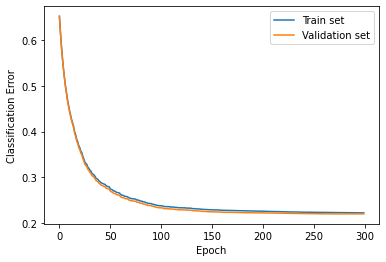

Accuracy: 89 %
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      9870
           1       0.82      1.00      0.90     10125

    accuracy                           0.89     19995
   macro avg       0.91      0.89      0.89     19995
weighted avg       0.91      0.89      0.89     19995



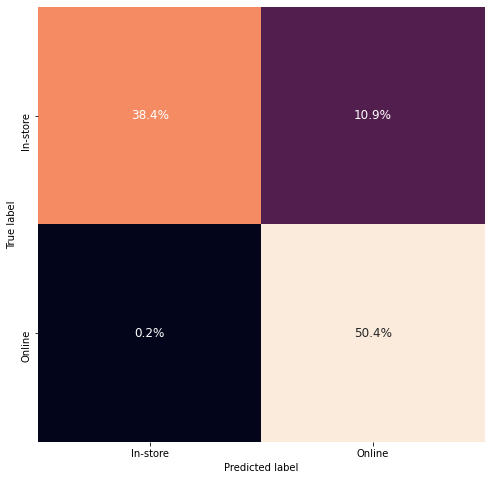

<Figure size 432x288 with 0 Axes>

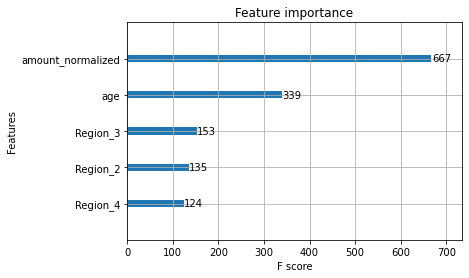

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[00:12:43] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:12:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.64049	validation_1-logloss:0.63990
[1]	validation_0-logloss:0.59506	validation_1-logloss:0.59448
[2]	validation_0-logloss:0.55630	validation_1-logloss:0.55536
[3]	validation_0-logloss:0.52278	validation_1-logloss:0.52133
[4]	validation_0-logloss:0.49324	validation_1-logloss:0.49157
[5]	validation_0-logloss:0.46716	validation_1-loglo

[120]	validation_0-logloss:0.22287	validation_1-logloss:0.22034
[121]	validation_0-logloss:0.22279	validation_1-logloss:0.22037
[122]	validation_0-logloss:0.22269	validation_1-logloss:0.22038
[123]	validation_0-logloss:0.22259	validation_1-logloss:0.22043
[124]	validation_0-logloss:0.22242	validation_1-logloss:0.22037
[125]	validation_0-logloss:0.22230	validation_1-logloss:0.22036
[126]	validation_0-logloss:0.22211	validation_1-logloss:0.22024
[127]	validation_0-logloss:0.22207	validation_1-logloss:0.22026
[128]	validation_0-logloss:0.22204	validation_1-logloss:0.22022
[129]	validation_0-logloss:0.22200	validation_1-logloss:0.22017
[130]	validation_0-logloss:0.22197	validation_1-logloss:0.22016
[131]	validation_0-logloss:0.22193	validation_1-logloss:0.22012
[132]	validation_0-logloss:0.22191	validation_1-logloss:0.22011
[133]	validation_0-logloss:0.22182	validation_1-logloss:0.22010
[134]	validation_0-logloss:0.22181	validation_1-logloss:0.22010
[135]	validation_0-logloss:0.22172	valid

[63]	validation_0-logloss:0.22918	validation_1-logloss:0.22660
[64]	validation_0-logloss:0.22910	validation_1-logloss:0.22654
[65]	validation_0-logloss:0.22873	validation_1-logloss:0.22618
[66]	validation_0-logloss:0.22852	validation_1-logloss:0.22615
[67]	validation_0-logloss:0.22846	validation_1-logloss:0.22608
[68]	validation_0-logloss:0.22811	validation_1-logloss:0.22577
[69]	validation_0-logloss:0.22804	validation_1-logloss:0.22573
[70]	validation_0-logloss:0.22801	validation_1-logloss:0.22571
[71]	validation_0-logloss:0.22795	validation_1-logloss:0.22568
[72]	validation_0-logloss:0.22776	validation_1-logloss:0.22553
[73]	validation_0-logloss:0.22760	validation_1-logloss:0.22542
[74]	validation_0-logloss:0.22754	validation_1-logloss:0.22540
[75]	validation_0-logloss:0.22743	validation_1-logloss:0.22535
[76]	validation_0-logloss:0.22731	validation_1-logloss:0.22518
[77]	validation_0-logloss:0.22725	validation_1-logloss:0.22515
[78]	validation_0-logloss:0.22721	validation_1-logloss:

[18]	validation_0-logloss:0.29893	validation_1-logloss:0.29507
[19]	validation_0-logloss:0.29286	validation_1-logloss:0.28896
[20]	validation_0-logloss:0.28736	validation_1-logloss:0.28337
[21]	validation_0-logloss:0.28239	validation_1-logloss:0.27829
[22]	validation_0-logloss:0.27786	validation_1-logloss:0.27362
[23]	validation_0-logloss:0.27354	validation_1-logloss:0.26935
[24]	validation_0-logloss:0.26969	validation_1-logloss:0.26545
[25]	validation_0-logloss:0.26615	validation_1-logloss:0.26185
[26]	validation_0-logloss:0.26291	validation_1-logloss:0.25859
[27]	validation_0-logloss:0.26008	validation_1-logloss:0.25557
[28]	validation_0-logloss:0.25727	validation_1-logloss:0.25281
[29]	validation_0-logloss:0.25478	validation_1-logloss:0.25035
[30]	validation_0-logloss:0.25259	validation_1-logloss:0.24810
[31]	validation_0-logloss:0.25043	validation_1-logloss:0.24601
[32]	validation_0-logloss:0.24853	validation_1-logloss:0.24410
[33]	validation_0-logloss:0.24676	validation_1-logloss:

[148]	validation_0-logloss:0.22100	validation_1-logloss:0.22122
[149]	validation_0-logloss:0.22100	validation_1-logloss:0.22123
[150]	validation_0-logloss:0.22093	validation_1-logloss:0.22125
[151]	validation_0-logloss:0.22080	validation_1-logloss:0.22127
[152]	validation_0-logloss:0.22064	validation_1-logloss:0.22129
[153]	validation_0-logloss:0.22064	validation_1-logloss:0.22129
[154]	validation_0-logloss:0.22050	validation_1-logloss:0.22131
[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=6, min_child_weight=1;, score=0.998 total time=   4.7s
[00:12:59] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:12:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the 

[112]	validation_0-logloss:0.22368	validation_1-logloss:0.22094
[113]	validation_0-logloss:0.22349	validation_1-logloss:0.22087
[114]	validation_0-logloss:0.22348	validation_1-logloss:0.22087
[115]	validation_0-logloss:0.22338	validation_1-logloss:0.22087
[116]	validation_0-logloss:0.22336	validation_1-logloss:0.22088
[117]	validation_0-logloss:0.22307	validation_1-logloss:0.22078
[118]	validation_0-logloss:0.22306	validation_1-logloss:0.22079
[119]	validation_0-logloss:0.22279	validation_1-logloss:0.22073
[120]	validation_0-logloss:0.22274	validation_1-logloss:0.22072
[121]	validation_0-logloss:0.22263	validation_1-logloss:0.22069
[122]	validation_0-logloss:0.22253	validation_1-logloss:0.22068
[123]	validation_0-logloss:0.22250	validation_1-logloss:0.22067
[124]	validation_0-logloss:0.22242	validation_1-logloss:0.22063
[125]	validation_0-logloss:0.22239	validation_1-logloss:0.22064
[126]	validation_0-logloss:0.22235	validation_1-logloss:0.22062
[127]	validation_0-logloss:0.22232	valid

[65]	validation_0-logloss:0.22844	validation_1-logloss:0.22390
[66]	validation_0-logloss:0.22826	validation_1-logloss:0.22379
[67]	validation_0-logloss:0.22814	validation_1-logloss:0.22365
[68]	validation_0-logloss:0.22806	validation_1-logloss:0.22358
[69]	validation_0-logloss:0.22796	validation_1-logloss:0.22351
[70]	validation_0-logloss:0.22762	validation_1-logloss:0.22312
[71]	validation_0-logloss:0.22754	validation_1-logloss:0.22305
[72]	validation_0-logloss:0.22732	validation_1-logloss:0.22275
[73]	validation_0-logloss:0.22718	validation_1-logloss:0.22271
[74]	validation_0-logloss:0.22712	validation_1-logloss:0.22266
[75]	validation_0-logloss:0.22703	validation_1-logloss:0.22263
[76]	validation_0-logloss:0.22699	validation_1-logloss:0.22258
[77]	validation_0-logloss:0.22675	validation_1-logloss:0.22238
[78]	validation_0-logloss:0.22671	validation_1-logloss:0.22237
[79]	validation_0-logloss:0.22659	validation_1-logloss:0.22221
[80]	validation_0-logloss:0.22655	validation_1-logloss:

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[CV 3/5] END colsample_bytree=2.0, gamma=2, max_depth=4, min_child_weight=5;, score=nan total time=   0.0s
[CV 4/5] END colsample_bytree=2.0, gamma=2, max_depth=4, min_child_weight=5;, score=nan total time=   0.0s
[CV 5/5] END colsample_bytree=2.0, gamma=2, max_depth=4, min_child_weight=5;, score=nan total time=   0.0s
[00:13:09] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:13:09] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.64697	validation_1-logloss:0.64669
[1]	validation_0-logloss:0.60714	valida

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[3]	validation_0-logloss:0.54123	validation_1-logloss:0.54015
[4]	validation_0-logloss:0.51491	validation_1-logloss:0.51380
[5]	validation_0-logloss:0.48985	validation_1-logloss:0.48810
[6]	validation_0-logloss:0.46777	validation_1-logloss:0.46558
[7]	validation_0-logloss:0.44928	validation_1-logloss:0.44673
[8]	validation_0-logloss:0.43150	validation_1-logloss:0.42862
[9]	validation_0-logloss:0.41647	validation_1-logloss:0.41334
[10]	validation_0-logloss:0.40224	validation_1-logloss:0.39864
[11]	validation_0-logloss:0.38960	validation_1-logloss:0.38613
[12]	validation_0-logloss:0.37802	validation_1-logloss:0.37409
[13]	validation_0-logloss:0.36770	validation_1-logloss:0.36368
[14]	validation_0-logloss:0.35817	validation_1-logloss:0.35374
[15]	validation_0-logloss:0.34953	validation_1-logloss:0.34504
[16]	validation_0-logloss:0.34162	validation_1-logloss:0.33680
[17]	validation_0-logloss:0.33428	validation_1-logloss:0.32944
[18]	validation_0-logloss:0.32668	validation_1-logloss:0.32167

[133]	validation_0-logloss:0.22593	validation_1-logloss:0.22259
[134]	validation_0-logloss:0.22592	validation_1-logloss:0.22259
[135]	validation_0-logloss:0.22586	validation_1-logloss:0.22259
[136]	validation_0-logloss:0.22582	validation_1-logloss:0.22261
[137]	validation_0-logloss:0.22574	validation_1-logloss:0.22254
[138]	validation_0-logloss:0.22572	validation_1-logloss:0.22253
[139]	validation_0-logloss:0.22568	validation_1-logloss:0.22257
[140]	validation_0-logloss:0.22563	validation_1-logloss:0.22258
[141]	validation_0-logloss:0.22558	validation_1-logloss:0.22257
[142]	validation_0-logloss:0.22556	validation_1-logloss:0.22255
[143]	validation_0-logloss:0.22555	validation_1-logloss:0.22252
[144]	validation_0-logloss:0.22551	validation_1-logloss:0.22256
[145]	validation_0-logloss:0.22549	validation_1-logloss:0.22254
[146]	validation_0-logloss:0.22546	validation_1-logloss:0.22253
[147]	validation_0-logloss:0.22545	validation_1-logloss:0.22250
[148]	validation_0-logloss:0.22542	valid

[81]	validation_0-logloss:0.23392	validation_1-logloss:0.23006
[82]	validation_0-logloss:0.23349	validation_1-logloss:0.22965
[83]	validation_0-logloss:0.23337	validation_1-logloss:0.22947
[84]	validation_0-logloss:0.23303	validation_1-logloss:0.22921
[85]	validation_0-logloss:0.23297	validation_1-logloss:0.22917
[86]	validation_0-logloss:0.23261	validation_1-logloss:0.22878
[87]	validation_0-logloss:0.23251	validation_1-logloss:0.22875
[88]	validation_0-logloss:0.23246	validation_1-logloss:0.22873
[89]	validation_0-logloss:0.23244	validation_1-logloss:0.22874
[90]	validation_0-logloss:0.23215	validation_1-logloss:0.22853
[91]	validation_0-logloss:0.23176	validation_1-logloss:0.22807
[92]	validation_0-logloss:0.23169	validation_1-logloss:0.22808
[93]	validation_0-logloss:0.23114	validation_1-logloss:0.22757
[94]	validation_0-logloss:0.23068	validation_1-logloss:0.22710
[95]	validation_0-logloss:0.23059	validation_1-logloss:0.22698
[96]	validation_0-logloss:0.23038	validation_1-logloss:

[12]	validation_0-logloss:0.37781	validation_1-logloss:0.37409
[13]	validation_0-logloss:0.36751	validation_1-logloss:0.36369
[14]	validation_0-logloss:0.35794	validation_1-logloss:0.35371
[15]	validation_0-logloss:0.34928	validation_1-logloss:0.34503
[16]	validation_0-logloss:0.34135	validation_1-logloss:0.33675
[17]	validation_0-logloss:0.33406	validation_1-logloss:0.32941
[18]	validation_0-logloss:0.32638	validation_1-logloss:0.32165
[19]	validation_0-logloss:0.32150	validation_1-logloss:0.31666
[20]	validation_0-logloss:0.31715	validation_1-logloss:0.31225
[21]	validation_0-logloss:0.31316	validation_1-logloss:0.30812
[22]	validation_0-logloss:0.30794	validation_1-logloss:0.30291
[23]	validation_0-logloss:0.30455	validation_1-logloss:0.29952
[24]	validation_0-logloss:0.30139	validation_1-logloss:0.29640
[25]	validation_0-logloss:0.29637	validation_1-logloss:0.29132
[26]	validation_0-logloss:0.29372	validation_1-logloss:0.28866
[27]	validation_0-logloss:0.28933	validation_1-logloss:

[142]	validation_0-logloss:0.22624	validation_1-logloss:0.22312
[143]	validation_0-logloss:0.22624	validation_1-logloss:0.22312
[144]	validation_0-logloss:0.22624	validation_1-logloss:0.22312
[145]	validation_0-logloss:0.22624	validation_1-logloss:0.22312
[146]	validation_0-logloss:0.22624	validation_1-logloss:0.22312
[147]	validation_0-logloss:0.22624	validation_1-logloss:0.22312
[148]	validation_0-logloss:0.22624	validation_1-logloss:0.22312
[149]	validation_0-logloss:0.22624	validation_1-logloss:0.22312
[150]	validation_0-logloss:0.22624	validation_1-logloss:0.22312
[151]	validation_0-logloss:0.22624	validation_1-logloss:0.22312
[152]	validation_0-logloss:0.22624	validation_1-logloss:0.22312
[153]	validation_0-logloss:0.22624	validation_1-logloss:0.22312
[154]	validation_0-logloss:0.22624	validation_1-logloss:0.22312
[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=4, min_child_weight=20;, score=0.996 total time=   3.6s
[00:13:21] WARNING: ..\src\learner.cc:541: 
Parameters: 

[106]	validation_0-logloss:0.22882	validation_1-logloss:0.22456
[107]	validation_0-logloss:0.22867	validation_1-logloss:0.22443
[108]	validation_0-logloss:0.22856	validation_1-logloss:0.22440
[109]	validation_0-logloss:0.22834	validation_1-logloss:0.22419
[110]	validation_0-logloss:0.22830	validation_1-logloss:0.22415
[111]	validation_0-logloss:0.22818	validation_1-logloss:0.22406
[112]	validation_0-logloss:0.22790	validation_1-logloss:0.22379
[113]	validation_0-logloss:0.22763	validation_1-logloss:0.22353
[114]	validation_0-logloss:0.22759	validation_1-logloss:0.22351
[115]	validation_0-logloss:0.22758	validation_1-logloss:0.22351
[116]	validation_0-logloss:0.22736	validation_1-logloss:0.22328
[117]	validation_0-logloss:0.22734	validation_1-logloss:0.22326
[118]	validation_0-logloss:0.22713	validation_1-logloss:0.22306
[119]	validation_0-logloss:0.22709	validation_1-logloss:0.22301
[120]	validation_0-logloss:0.22706	validation_1-logloss:0.22301
[121]	validation_0-logloss:0.22700	valid

[35]	validation_0-logloss:0.27146	validation_1-logloss:0.26606
[36]	validation_0-logloss:0.26899	validation_1-logloss:0.26360
[37]	validation_0-logloss:0.26637	validation_1-logloss:0.26098
[38]	validation_0-logloss:0.26527	validation_1-logloss:0.25990
[39]	validation_0-logloss:0.26433	validation_1-logloss:0.25888
[40]	validation_0-logloss:0.26328	validation_1-logloss:0.25791
[41]	validation_0-logloss:0.26085	validation_1-logloss:0.25534
[42]	validation_0-logloss:0.25985	validation_1-logloss:0.25448
[43]	validation_0-logloss:0.25911	validation_1-logloss:0.25372
[44]	validation_0-logloss:0.25687	validation_1-logloss:0.25140
[45]	validation_0-logloss:0.25618	validation_1-logloss:0.25072
[46]	validation_0-logloss:0.25558	validation_1-logloss:0.25014
[47]	validation_0-logloss:0.25354	validation_1-logloss:0.24808
[48]	validation_0-logloss:0.25296	validation_1-logloss:0.24757
[49]	validation_0-logloss:0.25112	validation_1-logloss:0.24581
[50]	validation_0-logloss:0.25068	validation_1-logloss:

[0]	validation_0-logloss:0.64141	validation_1-logloss:0.64067
[1]	validation_0-logloss:0.59692	validation_1-logloss:0.59591
[2]	validation_0-logloss:0.55873	validation_1-logloss:0.55735
[3]	validation_0-logloss:0.52561	validation_1-logloss:0.52380
[4]	validation_0-logloss:0.49676	validation_1-logloss:0.49448
[5]	validation_0-logloss:0.47111	validation_1-logloss:0.46858
[6]	validation_0-logloss:0.44856	validation_1-logloss:0.44572
[7]	validation_0-logloss:0.42877	validation_1-logloss:0.42537
[8]	validation_0-logloss:0.41081	validation_1-logloss:0.40723
[9]	validation_0-logloss:0.39486	validation_1-logloss:0.39103
[10]	validation_0-logloss:0.38064	validation_1-logloss:0.37644
[11]	validation_0-logloss:0.36759	validation_1-logloss:0.36337
[12]	validation_0-logloss:0.35606	validation_1-logloss:0.35153
[13]	validation_0-logloss:0.34557	validation_1-logloss:0.34088
[14]	validation_0-logloss:0.33613	validation_1-logloss:0.33141
[15]	validation_0-logloss:0.32754	validation_1-logloss:0.32263
[1

[130]	validation_0-logloss:0.22341	validation_1-logloss:0.22130
[131]	validation_0-logloss:0.22335	validation_1-logloss:0.22136
[132]	validation_0-logloss:0.22334	validation_1-logloss:0.22137
[133]	validation_0-logloss:0.22332	validation_1-logloss:0.22139
[134]	validation_0-logloss:0.22317	validation_1-logloss:0.22130
[135]	validation_0-logloss:0.22314	validation_1-logloss:0.22133
[136]	validation_0-logloss:0.22309	validation_1-logloss:0.22139
[137]	validation_0-logloss:0.22305	validation_1-logloss:0.22140
[138]	validation_0-logloss:0.22294	validation_1-logloss:0.22134
[139]	validation_0-logloss:0.22291	validation_1-logloss:0.22133
[140]	validation_0-logloss:0.22282	validation_1-logloss:0.22133
[141]	validation_0-logloss:0.22280	validation_1-logloss:0.22133
[142]	validation_0-logloss:0.22275	validation_1-logloss:0.22135
[143]	validation_0-logloss:0.22275	validation_1-logloss:0.22135
[144]	validation_0-logloss:0.22274	validation_1-logloss:0.22136
[CV 1/5] END colsample_bytree=1.0, gamma

[104]	validation_0-logloss:0.22532	validation_1-logloss:0.22311
[105]	validation_0-logloss:0.22510	validation_1-logloss:0.22290
[106]	validation_0-logloss:0.22504	validation_1-logloss:0.22288
[107]	validation_0-logloss:0.22498	validation_1-logloss:0.22286
[108]	validation_0-logloss:0.22497	validation_1-logloss:0.22287
[109]	validation_0-logloss:0.22496	validation_1-logloss:0.22286
[110]	validation_0-logloss:0.22477	validation_1-logloss:0.22276
[111]	validation_0-logloss:0.22459	validation_1-logloss:0.22258
[112]	validation_0-logloss:0.22458	validation_1-logloss:0.22257
[113]	validation_0-logloss:0.22456	validation_1-logloss:0.22260
[114]	validation_0-logloss:0.22455	validation_1-logloss:0.22261
[115]	validation_0-logloss:0.22447	validation_1-logloss:0.22260
[116]	validation_0-logloss:0.22446	validation_1-logloss:0.22257
[117]	validation_0-logloss:0.22445	validation_1-logloss:0.22258
[118]	validation_0-logloss:0.22443	validation_1-logloss:0.22256
[119]	validation_0-logloss:0.22428	valid

[43]	validation_0-logloss:0.24701	validation_1-logloss:0.24220
[44]	validation_0-logloss:0.24533	validation_1-logloss:0.24054
[45]	validation_0-logloss:0.24473	validation_1-logloss:0.24000
[46]	validation_0-logloss:0.24315	validation_1-logloss:0.23838
[47]	validation_0-logloss:0.24265	validation_1-logloss:0.23792
[48]	validation_0-logloss:0.24209	validation_1-logloss:0.23745
[49]	validation_0-logloss:0.24170	validation_1-logloss:0.23706
[50]	validation_0-logloss:0.24089	validation_1-logloss:0.23619
[51]	validation_0-logloss:0.23964	validation_1-logloss:0.23496
[52]	validation_0-logloss:0.23922	validation_1-logloss:0.23464
[53]	validation_0-logloss:0.23896	validation_1-logloss:0.23434
[54]	validation_0-logloss:0.23770	validation_1-logloss:0.23317
[55]	validation_0-logloss:0.23746	validation_1-logloss:0.23289
[56]	validation_0-logloss:0.23719	validation_1-logloss:0.23266
[57]	validation_0-logloss:0.23698	validation_1-logloss:0.23244
[58]	validation_0-logloss:0.23597	validation_1-logloss:

[0]	validation_0-logloss:0.64146	validation_1-logloss:0.64075
[1]	validation_0-logloss:0.59698	validation_1-logloss:0.59606
[2]	validation_0-logloss:0.55874	validation_1-logloss:0.55755
[3]	validation_0-logloss:0.52592	validation_1-logloss:0.52403
[4]	validation_0-logloss:0.49683	validation_1-logloss:0.49477
[5]	validation_0-logloss:0.47129	validation_1-logloss:0.46899
[6]	validation_0-logloss:0.44865	validation_1-logloss:0.44614
[7]	validation_0-logloss:0.42889	validation_1-logloss:0.42586
[8]	validation_0-logloss:0.41091	validation_1-logloss:0.40770
[9]	validation_0-logloss:0.39504	validation_1-logloss:0.39148
[10]	validation_0-logloss:0.38087	validation_1-logloss:0.37688
[11]	validation_0-logloss:0.36776	validation_1-logloss:0.36386
[12]	validation_0-logloss:0.35626	validation_1-logloss:0.35206
[13]	validation_0-logloss:0.34574	validation_1-logloss:0.34134
[14]	validation_0-logloss:0.33635	validation_1-logloss:0.33168
[15]	validation_0-logloss:0.32771	validation_1-logloss:0.32306
[1

[130]	validation_0-logloss:0.22371	validation_1-logloss:0.22146
[131]	validation_0-logloss:0.22370	validation_1-logloss:0.22144
[132]	validation_0-logloss:0.22369	validation_1-logloss:0.22143
[133]	validation_0-logloss:0.22354	validation_1-logloss:0.22133
[134]	validation_0-logloss:0.22347	validation_1-logloss:0.22132
[135]	validation_0-logloss:0.22333	validation_1-logloss:0.22122
[136]	validation_0-logloss:0.22327	validation_1-logloss:0.22128
[137]	validation_0-logloss:0.22326	validation_1-logloss:0.22126
[138]	validation_0-logloss:0.22322	validation_1-logloss:0.22129
[139]	validation_0-logloss:0.22317	validation_1-logloss:0.22126
[140]	validation_0-logloss:0.22316	validation_1-logloss:0.22125
[141]	validation_0-logloss:0.22311	validation_1-logloss:0.22130
[142]	validation_0-logloss:0.22310	validation_1-logloss:0.22129
[143]	validation_0-logloss:0.22300	validation_1-logloss:0.22117
[144]	validation_0-logloss:0.22298	validation_1-logloss:0.22115
[145]	validation_0-logloss:0.22297	valid

[75]	validation_0-logloss:0.22967	validation_1-logloss:0.22507
[76]	validation_0-logloss:0.22921	validation_1-logloss:0.22457
[77]	validation_0-logloss:0.22905	validation_1-logloss:0.22442
[78]	validation_0-logloss:0.22864	validation_1-logloss:0.22397
[79]	validation_0-logloss:0.22860	validation_1-logloss:0.22396
[80]	validation_0-logloss:0.22836	validation_1-logloss:0.22379
[81]	validation_0-logloss:0.22796	validation_1-logloss:0.22340
[82]	validation_0-logloss:0.22762	validation_1-logloss:0.22310
[83]	validation_0-logloss:0.22758	validation_1-logloss:0.22311
[84]	validation_0-logloss:0.22728	validation_1-logloss:0.22284
[85]	validation_0-logloss:0.22725	validation_1-logloss:0.22285
[86]	validation_0-logloss:0.22709	validation_1-logloss:0.22271
[87]	validation_0-logloss:0.22704	validation_1-logloss:0.22272
[88]	validation_0-logloss:0.22700	validation_1-logloss:0.22270
[89]	validation_0-logloss:0.22697	validation_1-logloss:0.22268
[90]	validation_0-logloss:0.22694	validation_1-logloss:

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[CV 5/5] END colsample_bytree=1.5, gamma=0.5, max_depth=5, min_child_weight=1;, score=nan total time=   0.0s
[00:13:55] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:13:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.64014	validation_1-logloss:0.63962
[1]	validation_0-logloss:0.59438	validation_1-logloss:0.59397
[2]	validation_0-logloss:0.55535	validation_1-logloss:0.55461
[3]	validation_0-logloss:0.52145	validation_1-logloss:0.52040
[4]	validation_0-logloss:0.49181	validation_1-logloss:0.49045
[5]

[1]	validation_0-logloss:0.59435	validation_1-logloss:0.59398
[2]	validation_0-logloss:0.55521	validation_1-logloss:0.55462
[3]	validation_0-logloss:0.52129	validation_1-logloss:0.52042
[4]	validation_0-logloss:0.49166	validation_1-logloss:0.49046
[5]	validation_0-logloss:0.46525	validation_1-logloss:0.46413
[6]	validation_0-logloss:0.44214	validation_1-logloss:0.44074
[7]	validation_0-logloss:0.42176	validation_1-logloss:0.42003
[8]	validation_0-logloss:0.40325	validation_1-logloss:0.40151
[9]	validation_0-logloss:0.38692	validation_1-logloss:0.38494
[10]	validation_0-logloss:0.37224	validation_1-logloss:0.37007
[11]	validation_0-logloss:0.35889	validation_1-logloss:0.35673
[12]	validation_0-logloss:0.34700	validation_1-logloss:0.34469
[13]	validation_0-logloss:0.33620	validation_1-logloss:0.33382
[14]	validation_0-logloss:0.32648	validation_1-logloss:0.32400
[15]	validation_0-logloss:0.31779	validation_1-logloss:0.31510
[16]	validation_0-logloss:0.30966	validation_1-logloss:0.30702
[

[13]	validation_0-logloss:0.33641	validation_1-logloss:0.33352
[14]	validation_0-logloss:0.32670	validation_1-logloss:0.32366
[15]	validation_0-logloss:0.31789	validation_1-logloss:0.31472
[16]	validation_0-logloss:0.30976	validation_1-logloss:0.30657
[17]	validation_0-logloss:0.30253	validation_1-logloss:0.29923
[18]	validation_0-logloss:0.29593	validation_1-logloss:0.29249
[19]	validation_0-logloss:0.28983	validation_1-logloss:0.28639
[20]	validation_0-logloss:0.28437	validation_1-logloss:0.28081
[21]	validation_0-logloss:0.27937	validation_1-logloss:0.27574
[22]	validation_0-logloss:0.27485	validation_1-logloss:0.27107
[23]	validation_0-logloss:0.27053	validation_1-logloss:0.26682
[24]	validation_0-logloss:0.26673	validation_1-logloss:0.26294
[25]	validation_0-logloss:0.26314	validation_1-logloss:0.25937
[26]	validation_0-logloss:0.25994	validation_1-logloss:0.25614
[27]	validation_0-logloss:0.25709	validation_1-logloss:0.25318
[28]	validation_0-logloss:0.25435	validation_1-logloss:

[25]	validation_0-logloss:0.26336	validation_1-logloss:0.25960
[26]	validation_0-logloss:0.26016	validation_1-logloss:0.25633
[27]	validation_0-logloss:0.25729	validation_1-logloss:0.25333
[28]	validation_0-logloss:0.25448	validation_1-logloss:0.25063
[29]	validation_0-logloss:0.25202	validation_1-logloss:0.24811
[30]	validation_0-logloss:0.24974	validation_1-logloss:0.24580
[31]	validation_0-logloss:0.24762	validation_1-logloss:0.24367
[32]	validation_0-logloss:0.24572	validation_1-logloss:0.24171
[33]	validation_0-logloss:0.24390	validation_1-logloss:0.23992
[34]	validation_0-logloss:0.24238	validation_1-logloss:0.23827
[35]	validation_0-logloss:0.24081	validation_1-logloss:0.23674
[36]	validation_0-logloss:0.23941	validation_1-logloss:0.23537
[37]	validation_0-logloss:0.23817	validation_1-logloss:0.23410
[38]	validation_0-logloss:0.23703	validation_1-logloss:0.23291
[39]	validation_0-logloss:0.23604	validation_1-logloss:0.23183
[40]	validation_0-logloss:0.23502	validation_1-logloss:

[39]	validation_0-logloss:0.23591	validation_1-logloss:0.23140
[40]	validation_0-logloss:0.23485	validation_1-logloss:0.23040
[41]	validation_0-logloss:0.23406	validation_1-logloss:0.22950
[42]	validation_0-logloss:0.23309	validation_1-logloss:0.22866
[43]	validation_0-logloss:0.23241	validation_1-logloss:0.22787
[44]	validation_0-logloss:0.23172	validation_1-logloss:0.22714
[45]	validation_0-logloss:0.23108	validation_1-logloss:0.22648
[46]	validation_0-logloss:0.23047	validation_1-logloss:0.22585
[47]	validation_0-logloss:0.22990	validation_1-logloss:0.22528
[48]	validation_0-logloss:0.22935	validation_1-logloss:0.22475
[49]	validation_0-logloss:0.22895	validation_1-logloss:0.22436
[50]	validation_0-logloss:0.22851	validation_1-logloss:0.22390
[51]	validation_0-logloss:0.22818	validation_1-logloss:0.22354
[52]	validation_0-logloss:0.22778	validation_1-logloss:0.22315
[53]	validation_0-logloss:0.22748	validation_1-logloss:0.22287
[54]	validation_0-logloss:0.22717	validation_1-logloss:

[52]	validation_0-logloss:0.27178	validation_1-logloss:0.26663
[53]	validation_0-logloss:0.27125	validation_1-logloss:0.26612
[54]	validation_0-logloss:0.27067	validation_1-logloss:0.26559
[55]	validation_0-logloss:0.27025	validation_1-logloss:0.26512
[56]	validation_0-logloss:0.26701	validation_1-logloss:0.26184
[57]	validation_0-logloss:0.26511	validation_1-logloss:0.25985
[58]	validation_0-logloss:0.26471	validation_1-logloss:0.25944
[59]	validation_0-logloss:0.26199	validation_1-logloss:0.25668
[60]	validation_0-logloss:0.26154	validation_1-logloss:0.25630
[61]	validation_0-logloss:0.26105	validation_1-logloss:0.25584
[62]	validation_0-logloss:0.26073	validation_1-logloss:0.25555
[63]	validation_0-logloss:0.26027	validation_1-logloss:0.25516
[64]	validation_0-logloss:0.25792	validation_1-logloss:0.25288
[65]	validation_0-logloss:0.25743	validation_1-logloss:0.25253
[66]	validation_0-logloss:0.25718	validation_1-logloss:0.25229
[67]	validation_0-logloss:0.25508	validation_1-logloss:

[181]	validation_0-logloss:0.22654	validation_1-logloss:0.22275
[182]	validation_0-logloss:0.22648	validation_1-logloss:0.22269
[183]	validation_0-logloss:0.22648	validation_1-logloss:0.22268
[184]	validation_0-logloss:0.22643	validation_1-logloss:0.22264
[185]	validation_0-logloss:0.22640	validation_1-logloss:0.22267
[186]	validation_0-logloss:0.22640	validation_1-logloss:0.22267
[187]	validation_0-logloss:0.22635	validation_1-logloss:0.22264
[188]	validation_0-logloss:0.22628	validation_1-logloss:0.22257
[189]	validation_0-logloss:0.22626	validation_1-logloss:0.22259
[190]	validation_0-logloss:0.22623	validation_1-logloss:0.22259
[191]	validation_0-logloss:0.22620	validation_1-logloss:0.22255
[192]	validation_0-logloss:0.22613	validation_1-logloss:0.22250
[193]	validation_0-logloss:0.22610	validation_1-logloss:0.22250
[194]	validation_0-logloss:0.22608	validation_1-logloss:0.22250
[195]	validation_0-logloss:0.22607	validation_1-logloss:0.22252
[196]	validation_0-logloss:0.22604	valid

[16]	validation_0-logloss:0.39265	validation_1-logloss:0.38944
[17]	validation_0-logloss:0.38268	validation_1-logloss:0.37914
[18]	validation_0-logloss:0.37752	validation_1-logloss:0.37395
[19]	validation_0-logloss:0.36901	validation_1-logloss:0.36519
[20]	validation_0-logloss:0.36460	validation_1-logloss:0.36068
[21]	validation_0-logloss:0.35748	validation_1-logloss:0.35322
[22]	validation_0-logloss:0.35374	validation_1-logloss:0.34941
[23]	validation_0-logloss:0.34577	validation_1-logloss:0.34153
[24]	validation_0-logloss:0.33879	validation_1-logloss:0.33454
[25]	validation_0-logloss:0.33325	validation_1-logloss:0.32879
[26]	validation_0-logloss:0.33035	validation_1-logloss:0.32595
[27]	validation_0-logloss:0.32781	validation_1-logloss:0.32337
[28]	validation_0-logloss:0.32197	validation_1-logloss:0.31759
[29]	validation_0-logloss:0.31766	validation_1-logloss:0.31303
[30]	validation_0-logloss:0.31542	validation_1-logloss:0.31085
[31]	validation_0-logloss:0.31344	validation_1-logloss:

[146]	validation_0-logloss:0.22969	validation_1-logloss:0.22615
[147]	validation_0-logloss:0.22950	validation_1-logloss:0.22592
[148]	validation_0-logloss:0.22945	validation_1-logloss:0.22592
[149]	validation_0-logloss:0.22912	validation_1-logloss:0.22554
[150]	validation_0-logloss:0.22909	validation_1-logloss:0.22554
[151]	validation_0-logloss:0.22897	validation_1-logloss:0.22542
[152]	validation_0-logloss:0.22892	validation_1-logloss:0.22538
[153]	validation_0-logloss:0.22877	validation_1-logloss:0.22520
[154]	validation_0-logloss:0.22878	validation_1-logloss:0.22521
[155]	validation_0-logloss:0.22874	validation_1-logloss:0.22521
[156]	validation_0-logloss:0.22874	validation_1-logloss:0.22522
[157]	validation_0-logloss:0.22845	validation_1-logloss:0.22489
[158]	validation_0-logloss:0.22824	validation_1-logloss:0.22460
[159]	validation_0-logloss:0.22823	validation_1-logloss:0.22461
[160]	validation_0-logloss:0.22820	validation_1-logloss:0.22460
[161]	validation_0-logloss:0.22816	valid

[0]	validation_0-logloss:0.65183	validation_1-logloss:0.65146
[1]	validation_0-logloss:0.61614	validation_1-logloss:0.61600
[2]	validation_0-logloss:0.58582	validation_1-logloss:0.58542
[3]	validation_0-logloss:0.55971	validation_1-logloss:0.55881
[4]	validation_0-logloss:0.53670	validation_1-logloss:0.53560
[5]	validation_0-logloss:0.51647	validation_1-logloss:0.51523
[6]	validation_0-logloss:0.49859	validation_1-logloss:0.49711
[7]	validation_0-logloss:0.48293	validation_1-logloss:0.48116
[8]	validation_0-logloss:0.46884	validation_1-logloss:0.46684
[9]	validation_0-logloss:0.45647	validation_1-logloss:0.45420
[10]	validation_0-logloss:0.44529	validation_1-logloss:0.44280
[11]	validation_0-logloss:0.43512	validation_1-logloss:0.43271
[12]	validation_0-logloss:0.42618	validation_1-logloss:0.42353
[13]	validation_0-logloss:0.41808	validation_1-logloss:0.41532
[14]	validation_0-logloss:0.41077	validation_1-logloss:0.40788
[15]	validation_0-logloss:0.39894	validation_1-logloss:0.39579
[1

[130]	validation_0-logloss:0.23131	validation_1-logloss:0.22722
[131]	validation_0-logloss:0.23103	validation_1-logloss:0.22689
[132]	validation_0-logloss:0.23074	validation_1-logloss:0.22660
[133]	validation_0-logloss:0.23068	validation_1-logloss:0.22655
[134]	validation_0-logloss:0.23061	validation_1-logloss:0.22655
[135]	validation_0-logloss:0.23034	validation_1-logloss:0.22625
[136]	validation_0-logloss:0.23005	validation_1-logloss:0.22594
[137]	validation_0-logloss:0.23000	validation_1-logloss:0.22593
[138]	validation_0-logloss:0.22978	validation_1-logloss:0.22568
[139]	validation_0-logloss:0.22970	validation_1-logloss:0.22564
[140]	validation_0-logloss:0.22946	validation_1-logloss:0.22541
[141]	validation_0-logloss:0.22933	validation_1-logloss:0.22526
[142]	validation_0-logloss:0.22912	validation_1-logloss:0.22500
[143]	validation_0-logloss:0.22906	validation_1-logloss:0.22496
[144]	validation_0-logloss:0.22905	validation_1-logloss:0.22493
[145]	validation_0-logloss:0.22894	valid

[259]	validation_0-logloss:0.22499	validation_1-logloss:0.22288
[260]	validation_0-logloss:0.22496	validation_1-logloss:0.22289
[261]	validation_0-logloss:0.22495	validation_1-logloss:0.22294
[262]	validation_0-logloss:0.22493	validation_1-logloss:0.22296
[263]	validation_0-logloss:0.22490	validation_1-logloss:0.22301
[264]	validation_0-logloss:0.22488	validation_1-logloss:0.22306
[265]	validation_0-logloss:0.22488	validation_1-logloss:0.22308
[266]	validation_0-logloss:0.22478	validation_1-logloss:0.22299
[267]	validation_0-logloss:0.22478	validation_1-logloss:0.22298
[268]	validation_0-logloss:0.22477	validation_1-logloss:0.22299
[269]	validation_0-logloss:0.22477	validation_1-logloss:0.22299
[270]	validation_0-logloss:0.22475	validation_1-logloss:0.22299
[271]	validation_0-logloss:0.22473	validation_1-logloss:0.22298
[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=20;, score=0.995 total time=   6.6s
[00:14:42] WARNING: ..\src\learner.cc:541: 
Parameters: 

[106]	validation_0-logloss:0.23769	validation_1-logloss:0.23332
[107]	validation_0-logloss:0.23766	validation_1-logloss:0.23326
[108]	validation_0-logloss:0.23735	validation_1-logloss:0.23293
[109]	validation_0-logloss:0.23725	validation_1-logloss:0.23289
[110]	validation_0-logloss:0.23626	validation_1-logloss:0.23189
[111]	validation_0-logloss:0.23573	validation_1-logloss:0.23138
[112]	validation_0-logloss:0.23567	validation_1-logloss:0.23132
[113]	validation_0-logloss:0.23500	validation_1-logloss:0.23062
[114]	validation_0-logloss:0.23495	validation_1-logloss:0.23056
[115]	validation_0-logloss:0.23433	validation_1-logloss:0.22992
[116]	validation_0-logloss:0.23416	validation_1-logloss:0.22975
[117]	validation_0-logloss:0.23406	validation_1-logloss:0.22957
[118]	validation_0-logloss:0.23402	validation_1-logloss:0.22958
[119]	validation_0-logloss:0.23396	validation_1-logloss:0.22958
[120]	validation_0-logloss:0.23391	validation_1-logloss:0.22953
[121]	validation_0-logloss:0.23336	valid

[235]	validation_0-logloss:0.22512	validation_1-logloss:0.22208
[236]	validation_0-logloss:0.22511	validation_1-logloss:0.22207
[237]	validation_0-logloss:0.22510	validation_1-logloss:0.22208
[238]	validation_0-logloss:0.22510	validation_1-logloss:0.22208
[239]	validation_0-logloss:0.22509	validation_1-logloss:0.22207
[240]	validation_0-logloss:0.22509	validation_1-logloss:0.22208
[241]	validation_0-logloss:0.22508	validation_1-logloss:0.22208
[242]	validation_0-logloss:0.22501	validation_1-logloss:0.22201
[243]	validation_0-logloss:0.22499	validation_1-logloss:0.22200
[244]	validation_0-logloss:0.22497	validation_1-logloss:0.22202
[245]	validation_0-logloss:0.22497	validation_1-logloss:0.22203
[246]	validation_0-logloss:0.22497	validation_1-logloss:0.22203
[247]	validation_0-logloss:0.22495	validation_1-logloss:0.22202
[248]	validation_0-logloss:0.22491	validation_1-logloss:0.22197
[249]	validation_0-logloss:0.22491	validation_1-logloss:0.22198
[250]	validation_0-logloss:0.22490	valid

[72]	validation_0-logloss:0.25374	validation_1-logloss:0.24891
[73]	validation_0-logloss:0.25345	validation_1-logloss:0.24873
[74]	validation_0-logloss:0.25160	validation_1-logloss:0.24674
[75]	validation_0-logloss:0.25137	validation_1-logloss:0.24657
[76]	validation_0-logloss:0.24958	validation_1-logloss:0.24488
[77]	validation_0-logloss:0.24941	validation_1-logloss:0.24471
[78]	validation_0-logloss:0.24912	validation_1-logloss:0.24447
[79]	validation_0-logloss:0.24896	validation_1-logloss:0.24430
[80]	validation_0-logloss:0.24735	validation_1-logloss:0.24263
[81]	validation_0-logloss:0.24717	validation_1-logloss:0.24250
[82]	validation_0-logloss:0.24696	validation_1-logloss:0.24232
[83]	validation_0-logloss:0.24676	validation_1-logloss:0.24214
[84]	validation_0-logloss:0.24529	validation_1-logloss:0.24076
[85]	validation_0-logloss:0.24518	validation_1-logloss:0.24068
[86]	validation_0-logloss:0.24504	validation_1-logloss:0.24057
[87]	validation_0-logloss:0.24374	validation_1-logloss:

[201]	validation_0-logloss:0.22585	validation_1-logloss:0.22241
[202]	validation_0-logloss:0.22583	validation_1-logloss:0.22245
[203]	validation_0-logloss:0.22573	validation_1-logloss:0.22237
[204]	validation_0-logloss:0.22573	validation_1-logloss:0.22237
[205]	validation_0-logloss:0.22569	validation_1-logloss:0.22234
[206]	validation_0-logloss:0.22567	validation_1-logloss:0.22234
[207]	validation_0-logloss:0.22565	validation_1-logloss:0.22231
[208]	validation_0-logloss:0.22561	validation_1-logloss:0.22228
[209]	validation_0-logloss:0.22556	validation_1-logloss:0.22225
[210]	validation_0-logloss:0.22555	validation_1-logloss:0.22224
[211]	validation_0-logloss:0.22550	validation_1-logloss:0.22218
[212]	validation_0-logloss:0.22547	validation_1-logloss:0.22215
[213]	validation_0-logloss:0.22546	validation_1-logloss:0.22213
[214]	validation_0-logloss:0.22542	validation_1-logloss:0.22211
[215]	validation_0-logloss:0.22541	validation_1-logloss:0.22211
[216]	validation_0-logloss:0.22540	valid

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[00:14:56] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:14:56] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.66648	validation_1-logloss:0.66667
[1]	validation_0-logloss:0.65485	validation_1-logloss:0.65450
[2]	validation_0-logloss:0.64491	validation_1-logloss:0.64403
[3]	validation_0-logloss:0.60686	validation_1-logloss:0.60594
[4]	validation_0-logloss:0.58160	validation_1-logloss:0.58061
[5]	validation_0-logloss:0.56473	validation_1-logloss:0.56394
[6]	validation_0-logloss:0.55846	validation_1-logl

[121]	validation_0-logloss:0.21975	validation_1-logloss:0.22515
[122]	validation_0-logloss:0.21967	validation_1-logloss:0.22509
[123]	validation_0-logloss:0.21949	validation_1-logloss:0.22498
[124]	validation_0-logloss:0.21923	validation_1-logloss:0.22472
[125]	validation_0-logloss:0.21910	validation_1-logloss:0.22466
[126]	validation_0-logloss:0.21885	validation_1-logloss:0.22443
[127]	validation_0-logloss:0.21869	validation_1-logloss:0.22436
[128]	validation_0-logloss:0.21865	validation_1-logloss:0.22431
[129]	validation_0-logloss:0.21853	validation_1-logloss:0.22425
[130]	validation_0-logloss:0.21832	validation_1-logloss:0.22404
[131]	validation_0-logloss:0.21805	validation_1-logloss:0.22399
[132]	validation_0-logloss:0.21773	validation_1-logloss:0.22381
[133]	validation_0-logloss:0.21766	validation_1-logloss:0.22373
[134]	validation_0-logloss:0.21752	validation_1-logloss:0.22375
[135]	validation_0-logloss:0.21745	validation_1-logloss:0.22368
[136]	validation_0-logloss:0.21741	valid

[250]	validation_0-logloss:0.21218	validation_1-logloss:0.22137
[251]	validation_0-logloss:0.21215	validation_1-logloss:0.22134
[252]	validation_0-logloss:0.21215	validation_1-logloss:0.22134
[253]	validation_0-logloss:0.21215	validation_1-logloss:0.22134
[254]	validation_0-logloss:0.21215	validation_1-logloss:0.22134
[255]	validation_0-logloss:0.21215	validation_1-logloss:0.22134
[256]	validation_0-logloss:0.21215	validation_1-logloss:0.22134
[257]	validation_0-logloss:0.21215	validation_1-logloss:0.22134
[258]	validation_0-logloss:0.21215	validation_1-logloss:0.22134
[259]	validation_0-logloss:0.21215	validation_1-logloss:0.22134
[260]	validation_0-logloss:0.21215	validation_1-logloss:0.22134
[261]	validation_0-logloss:0.21215	validation_1-logloss:0.22134
[262]	validation_0-logloss:0.21215	validation_1-logloss:0.22134
[263]	validation_0-logloss:0.21215	validation_1-logloss:0.22134
[264]	validation_0-logloss:0.21215	validation_1-logloss:0.22134
[265]	validation_0-logloss:0.21212	valid

[69]	validation_0-logloss:0.24209	validation_1-logloss:0.24386
[70]	validation_0-logloss:0.24147	validation_1-logloss:0.24335
[71]	validation_0-logloss:0.24026	validation_1-logloss:0.24217
[72]	validation_0-logloss:0.23903	validation_1-logloss:0.24104
[73]	validation_0-logloss:0.23799	validation_1-logloss:0.24012
[74]	validation_0-logloss:0.23760	validation_1-logloss:0.23973
[75]	validation_0-logloss:0.23715	validation_1-logloss:0.23924
[76]	validation_0-logloss:0.23612	validation_1-logloss:0.23840
[77]	validation_0-logloss:0.23526	validation_1-logloss:0.23769
[78]	validation_0-logloss:0.23482	validation_1-logloss:0.23739
[79]	validation_0-logloss:0.23428	validation_1-logloss:0.23693
[80]	validation_0-logloss:0.23355	validation_1-logloss:0.23633
[81]	validation_0-logloss:0.23327	validation_1-logloss:0.23606
[82]	validation_0-logloss:0.23262	validation_1-logloss:0.23555
[83]	validation_0-logloss:0.23213	validation_1-logloss:0.23505
[84]	validation_0-logloss:0.23130	validation_1-logloss:

[198]	validation_0-logloss:0.21284	validation_1-logloss:0.22313
[199]	validation_0-logloss:0.21279	validation_1-logloss:0.22306
[200]	validation_0-logloss:0.21277	validation_1-logloss:0.22302
[201]	validation_0-logloss:0.21263	validation_1-logloss:0.22300
[202]	validation_0-logloss:0.21259	validation_1-logloss:0.22300
[203]	validation_0-logloss:0.21257	validation_1-logloss:0.22301
[204]	validation_0-logloss:0.21248	validation_1-logloss:0.22305
[205]	validation_0-logloss:0.21247	validation_1-logloss:0.22304
[206]	validation_0-logloss:0.21245	validation_1-logloss:0.22307
[207]	validation_0-logloss:0.21238	validation_1-logloss:0.22304
[208]	validation_0-logloss:0.21233	validation_1-logloss:0.22297
[209]	validation_0-logloss:0.21228	validation_1-logloss:0.22300
[210]	validation_0-logloss:0.21227	validation_1-logloss:0.22299
[211]	validation_0-logloss:0.21227	validation_1-logloss:0.22299
[212]	validation_0-logloss:0.21226	validation_1-logloss:0.22301
[213]	validation_0-logloss:0.21224	valid

[78]	validation_0-logloss:0.23500	validation_1-logloss:0.23712
[79]	validation_0-logloss:0.23440	validation_1-logloss:0.23659
[80]	validation_0-logloss:0.23370	validation_1-logloss:0.23595
[81]	validation_0-logloss:0.23342	validation_1-logloss:0.23569
[82]	validation_0-logloss:0.23278	validation_1-logloss:0.23511
[83]	validation_0-logloss:0.23230	validation_1-logloss:0.23464
[84]	validation_0-logloss:0.23145	validation_1-logloss:0.23397
[85]	validation_0-logloss:0.23094	validation_1-logloss:0.23355
[86]	validation_0-logloss:0.23047	validation_1-logloss:0.23319
[87]	validation_0-logloss:0.23016	validation_1-logloss:0.23292
[88]	validation_0-logloss:0.22979	validation_1-logloss:0.23257
[89]	validation_0-logloss:0.22956	validation_1-logloss:0.23238
[90]	validation_0-logloss:0.22885	validation_1-logloss:0.23171
[91]	validation_0-logloss:0.22848	validation_1-logloss:0.23135
[92]	validation_0-logloss:0.22814	validation_1-logloss:0.23104
[93]	validation_0-logloss:0.22789	validation_1-logloss:

[207]	validation_0-logloss:0.21166	validation_1-logloss:0.22212
[208]	validation_0-logloss:0.21161	validation_1-logloss:0.22208
[209]	validation_0-logloss:0.21161	validation_1-logloss:0.22210
[210]	validation_0-logloss:0.21157	validation_1-logloss:0.22211
[211]	validation_0-logloss:0.21157	validation_1-logloss:0.22210
[212]	validation_0-logloss:0.21156	validation_1-logloss:0.22212
[213]	validation_0-logloss:0.21155	validation_1-logloss:0.22213
[214]	validation_0-logloss:0.21154	validation_1-logloss:0.22215
[215]	validation_0-logloss:0.21153	validation_1-logloss:0.22215
[216]	validation_0-logloss:0.21152	validation_1-logloss:0.22217
[217]	validation_0-logloss:0.21149	validation_1-logloss:0.22214
[218]	validation_0-logloss:0.21147	validation_1-logloss:0.22212
[219]	validation_0-logloss:0.21146	validation_1-logloss:0.22212
[220]	validation_0-logloss:0.21145	validation_1-logloss:0.22215
[221]	validation_0-logloss:0.21136	validation_1-logloss:0.22213
[222]	validation_0-logloss:0.21135	valid

[102]	validation_0-logloss:0.22513	validation_1-logloss:0.22875
[103]	validation_0-logloss:0.22500	validation_1-logloss:0.22863
[104]	validation_0-logloss:0.22490	validation_1-logloss:0.22852
[105]	validation_0-logloss:0.22432	validation_1-logloss:0.22814
[106]	validation_0-logloss:0.22380	validation_1-logloss:0.22782
[107]	validation_0-logloss:0.22331	validation_1-logloss:0.22751
[108]	validation_0-logloss:0.22303	validation_1-logloss:0.22726
[109]	validation_0-logloss:0.22261	validation_1-logloss:0.22703
[110]	validation_0-logloss:0.22224	validation_1-logloss:0.22668
[111]	validation_0-logloss:0.22203	validation_1-logloss:0.22652
[112]	validation_0-logloss:0.22173	validation_1-logloss:0.22631
[113]	validation_0-logloss:0.22155	validation_1-logloss:0.22616
[114]	validation_0-logloss:0.22142	validation_1-logloss:0.22601
[115]	validation_0-logloss:0.22129	validation_1-logloss:0.22588
[116]	validation_0-logloss:0.22106	validation_1-logloss:0.22578
[117]	validation_0-logloss:0.22090	valid

[1]	validation_0-logloss:0.65474	validation_1-logloss:0.65445
[2]	validation_0-logloss:0.64478	validation_1-logloss:0.64402
[3]	validation_0-logloss:0.60677	validation_1-logloss:0.60590
[4]	validation_0-logloss:0.58146	validation_1-logloss:0.58058
[5]	validation_0-logloss:0.56462	validation_1-logloss:0.56387
[6]	validation_0-logloss:0.55832	validation_1-logloss:0.55721
[7]	validation_0-logloss:0.53114	validation_1-logloss:0.52991
[8]	validation_0-logloss:0.51335	validation_1-logloss:0.51207
[9]	validation_0-logloss:0.48905	validation_1-logloss:0.48754
[10]	validation_0-logloss:0.47309	validation_1-logloss:0.47182
[11]	validation_0-logloss:0.46052	validation_1-logloss:0.45935
[12]	validation_0-logloss:0.44234	validation_1-logloss:0.44096
[13]	validation_0-logloss:0.42867	validation_1-logloss:0.42741
[14]	validation_0-logloss:0.41847	validation_1-logloss:0.41717
[15]	validation_0-logloss:0.40429	validation_1-logloss:0.40279
[16]	validation_0-logloss:0.39752	validation_1-logloss:0.39619
[

[131]	validation_0-logloss:0.21809	validation_1-logloss:0.22450
[132]	validation_0-logloss:0.21781	validation_1-logloss:0.22442
[133]	validation_0-logloss:0.21775	validation_1-logloss:0.22435
[134]	validation_0-logloss:0.21761	validation_1-logloss:0.22428
[135]	validation_0-logloss:0.21756	validation_1-logloss:0.22422
[136]	validation_0-logloss:0.21752	validation_1-logloss:0.22418
[137]	validation_0-logloss:0.21726	validation_1-logloss:0.22408
[138]	validation_0-logloss:0.21710	validation_1-logloss:0.22402
[139]	validation_0-logloss:0.21700	validation_1-logloss:0.22398
[140]	validation_0-logloss:0.21680	validation_1-logloss:0.22394
[141]	validation_0-logloss:0.21677	validation_1-logloss:0.22391
[142]	validation_0-logloss:0.21673	validation_1-logloss:0.22387
[143]	validation_0-logloss:0.21669	validation_1-logloss:0.22384
[144]	validation_0-logloss:0.21655	validation_1-logloss:0.22390
[145]	validation_0-logloss:0.21640	validation_1-logloss:0.22385
[146]	validation_0-logloss:0.21637	valid

[260]	validation_0-logloss:0.20927	validation_1-logloss:0.22252
[261]	validation_0-logloss:0.20915	validation_1-logloss:0.22247
[262]	validation_0-logloss:0.20893	validation_1-logloss:0.22258
[263]	validation_0-logloss:0.20892	validation_1-logloss:0.22259
[264]	validation_0-logloss:0.20871	validation_1-logloss:0.22257
[265]	validation_0-logloss:0.20869	validation_1-logloss:0.22255
[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=10, min_child_weight=1;, score=0.984 total time=  10.3s
[00:15:50] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:15:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.99452004        nan        nan 0.99347623 0.99384902        nan
 0.99828518 0.99220876        nan 0.98848089]
  category=UserWarning


[3]	validation_0-logloss:0.52144	validation_1-logloss:0.52037
[4]	validation_0-logloss:0.49175	validation_1-logloss:0.49042
[5]	validation_0-logloss:0.46538	validation_1-logloss:0.46405
[6]	validation_0-logloss:0.44227	validation_1-logloss:0.44070
[7]	validation_0-logloss:0.42194	validation_1-logloss:0.41994
[8]	validation_0-logloss:0.40349	validation_1-logloss:0.40137
[9]	validation_0-logloss:0.38717	validation_1-logloss:0.38475
[10]	validation_0-logloss:0.37244	validation_1-logloss:0.36985
[11]	validation_0-logloss:0.35912	validation_1-logloss:0.35643
[12]	validation_0-logloss:0.34715	validation_1-logloss:0.34436
[13]	validation_0-logloss:0.33630	validation_1-logloss:0.33345
[14]	validation_0-logloss:0.32664	validation_1-logloss:0.32356
[15]	validation_0-logloss:0.31789	validation_1-logloss:0.31460
[16]	validation_0-logloss:0.30983	validation_1-logloss:0.30647
[17]	validation_0-logloss:0.30248	validation_1-logloss:0.29908
[18]	validation_0-logloss:0.29594	validation_1-logloss:0.29237

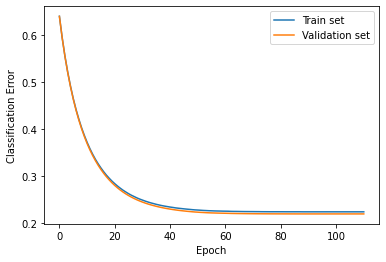

Accuracy: 89 %
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      9870
           1       0.82      1.00      0.90     10125

    accuracy                           0.89     19995
   macro avg       0.91      0.89      0.89     19995
weighted avg       0.91      0.89      0.89     19995



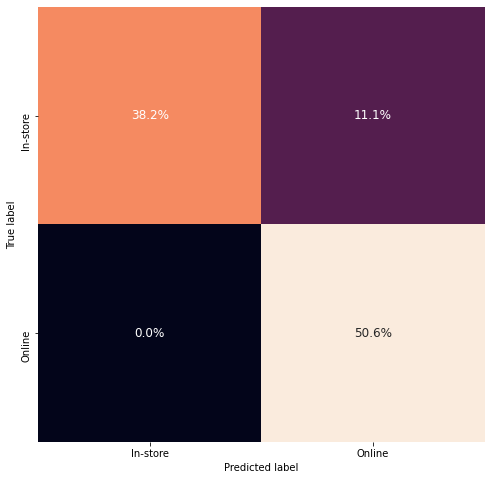

<Figure size 432x288 with 0 Axes>

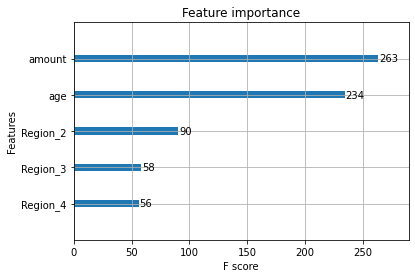

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[00:15:55] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:15:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.66772	validation_1-logloss:0.66770
[1]	validation_0-logloss:0.65620	validation_1-logloss:0.65564
[2]	validation_0-logloss:0.64662	validation_1-logloss:0.64543
[3]	validation_0-logloss:0.60876	validation_1-logloss:0.60725
[4]	validation_0-logloss:0.58342	validation_1-logloss:0.58192
[5]	validation_0-logloss:0.56747	validation_1-loglo

[120]	validation_0-logloss:0.22909	validation_1-logloss:0.22563
[121]	validation_0-logloss:0.22901	validation_1-logloss:0.22565
[122]	validation_0-logloss:0.22894	validation_1-logloss:0.22560
[123]	validation_0-logloss:0.22884	validation_1-logloss:0.22549
[124]	validation_0-logloss:0.22872	validation_1-logloss:0.22539
[125]	validation_0-logloss:0.22863	validation_1-logloss:0.22530
[126]	validation_0-logloss:0.22853	validation_1-logloss:0.22521
[127]	validation_0-logloss:0.22845	validation_1-logloss:0.22516
[128]	validation_0-logloss:0.22843	validation_1-logloss:0.22517
[129]	validation_0-logloss:0.22835	validation_1-logloss:0.22511
[130]	validation_0-logloss:0.22825	validation_1-logloss:0.22502
[131]	validation_0-logloss:0.22817	validation_1-logloss:0.22504
[132]	validation_0-logloss:0.22796	validation_1-logloss:0.22487
[133]	validation_0-logloss:0.22788	validation_1-logloss:0.22477
[134]	validation_0-logloss:0.22783	validation_1-logloss:0.22482
[135]	validation_0-logloss:0.22781	valid

[4]	validation_0-logloss:0.58356	validation_1-logloss:0.58214
[5]	validation_0-logloss:0.56756	validation_1-logloss:0.56611
[6]	validation_0-logloss:0.56132	validation_1-logloss:0.55954
[7]	validation_0-logloss:0.53412	validation_1-logloss:0.53210
[8]	validation_0-logloss:0.51627	validation_1-logloss:0.51414
[9]	validation_0-logloss:0.49205	validation_1-logloss:0.48949
[10]	validation_0-logloss:0.47631	validation_1-logloss:0.47364
[11]	validation_0-logloss:0.46372	validation_1-logloss:0.46125
[12]	validation_0-logloss:0.44568	validation_1-logloss:0.44283
[13]	validation_0-logloss:0.43191	validation_1-logloss:0.42918
[14]	validation_0-logloss:0.42165	validation_1-logloss:0.41887
[15]	validation_0-logloss:0.40756	validation_1-logloss:0.40448
[16]	validation_0-logloss:0.40133	validation_1-logloss:0.39821
[17]	validation_0-logloss:0.39316	validation_1-logloss:0.38996
[18]	validation_0-logloss:0.38642	validation_1-logloss:0.38333
[19]	validation_0-logloss:0.37925	validation_1-logloss:0.3759

[134]	validation_0-logloss:0.22820	validation_1-logloss:0.22604
[135]	validation_0-logloss:0.22818	validation_1-logloss:0.22603
[136]	validation_0-logloss:0.22817	validation_1-logloss:0.22603
[137]	validation_0-logloss:0.22814	validation_1-logloss:0.22602
[138]	validation_0-logloss:0.22805	validation_1-logloss:0.22593
[139]	validation_0-logloss:0.22796	validation_1-logloss:0.22586
[140]	validation_0-logloss:0.22793	validation_1-logloss:0.22587
[141]	validation_0-logloss:0.22793	validation_1-logloss:0.22587
[142]	validation_0-logloss:0.22791	validation_1-logloss:0.22587
[143]	validation_0-logloss:0.22790	validation_1-logloss:0.22587
[144]	validation_0-logloss:0.22785	validation_1-logloss:0.22587
[145]	validation_0-logloss:0.22776	validation_1-logloss:0.22574
[146]	validation_0-logloss:0.22776	validation_1-logloss:0.22574
[147]	validation_0-logloss:0.22758	validation_1-logloss:0.22557
[148]	validation_0-logloss:0.22734	validation_1-logloss:0.22533
[149]	validation_0-logloss:0.22727	valid

[263]	validation_0-logloss:0.22491	validation_1-logloss:0.22399
[264]	validation_0-logloss:0.22490	validation_1-logloss:0.22399
[265]	validation_0-logloss:0.22490	validation_1-logloss:0.22398
[266]	validation_0-logloss:0.22489	validation_1-logloss:0.22398
[267]	validation_0-logloss:0.22489	validation_1-logloss:0.22398
[268]	validation_0-logloss:0.22489	validation_1-logloss:0.22397
[269]	validation_0-logloss:0.22488	validation_1-logloss:0.22396
[270]	validation_0-logloss:0.22487	validation_1-logloss:0.22396
[271]	validation_0-logloss:0.22487	validation_1-logloss:0.22396
[272]	validation_0-logloss:0.22486	validation_1-logloss:0.22397
[273]	validation_0-logloss:0.22484	validation_1-logloss:0.22401
[274]	validation_0-logloss:0.22483	validation_1-logloss:0.22399
[275]	validation_0-logloss:0.22483	validation_1-logloss:0.22399
[276]	validation_0-logloss:0.22482	validation_1-logloss:0.22400
[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=6, min_child_weight=30;, score=0.992 total time=

[105]	validation_0-logloss:0.23208	validation_1-logloss:0.22872
[106]	validation_0-logloss:0.23166	validation_1-logloss:0.22834
[107]	validation_0-logloss:0.23128	validation_1-logloss:0.22803
[108]	validation_0-logloss:0.23111	validation_1-logloss:0.22788
[109]	validation_0-logloss:0.23078	validation_1-logloss:0.22759
[110]	validation_0-logloss:0.23039	validation_1-logloss:0.22723
[111]	validation_0-logloss:0.23025	validation_1-logloss:0.22710
[112]	validation_0-logloss:0.23005	validation_1-logloss:0.22690
[113]	validation_0-logloss:0.22990	validation_1-logloss:0.22679
[114]	validation_0-logloss:0.22979	validation_1-logloss:0.22667
[115]	validation_0-logloss:0.22967	validation_1-logloss:0.22655
[116]	validation_0-logloss:0.22956	validation_1-logloss:0.22646
[117]	validation_0-logloss:0.22942	validation_1-logloss:0.22634
[118]	validation_0-logloss:0.22927	validation_1-logloss:0.22619
[119]	validation_0-logloss:0.22920	validation_1-logloss:0.22609
[120]	validation_0-logloss:0.22901	valid

[0]	validation_0-logloss:0.66786	validation_1-logloss:0.66782
[1]	validation_0-logloss:0.65661	validation_1-logloss:0.65600
[2]	validation_0-logloss:0.64682	validation_1-logloss:0.64584
[3]	validation_0-logloss:0.60907	validation_1-logloss:0.60767
[4]	validation_0-logloss:0.58365	validation_1-logloss:0.58230
[5]	validation_0-logloss:0.56774	validation_1-logloss:0.56633
[6]	validation_0-logloss:0.56131	validation_1-logloss:0.55956
[7]	validation_0-logloss:0.53436	validation_1-logloss:0.53225
[8]	validation_0-logloss:0.51636	validation_1-logloss:0.51431
[9]	validation_0-logloss:0.49221	validation_1-logloss:0.48970
[10]	validation_0-logloss:0.47651	validation_1-logloss:0.47391
[11]	validation_0-logloss:0.46392	validation_1-logloss:0.46144
[12]	validation_0-logloss:0.44591	validation_1-logloss:0.44301
[13]	validation_0-logloss:0.43209	validation_1-logloss:0.42937
[14]	validation_0-logloss:0.42180	validation_1-logloss:0.41904
[15]	validation_0-logloss:0.40776	validation_1-logloss:0.40460
[1

[130]	validation_0-logloss:0.22821	validation_1-logloss:0.22540
[131]	validation_0-logloss:0.22813	validation_1-logloss:0.22537
[132]	validation_0-logloss:0.22791	validation_1-logloss:0.22520
[133]	validation_0-logloss:0.22782	validation_1-logloss:0.22512
[134]	validation_0-logloss:0.22779	validation_1-logloss:0.22515
[135]	validation_0-logloss:0.22778	validation_1-logloss:0.22513
[136]	validation_0-logloss:0.22776	validation_1-logloss:0.22514
[137]	validation_0-logloss:0.22770	validation_1-logloss:0.22514
[138]	validation_0-logloss:0.22762	validation_1-logloss:0.22507
[139]	validation_0-logloss:0.22754	validation_1-logloss:0.22503
[140]	validation_0-logloss:0.22749	validation_1-logloss:0.22508
[141]	validation_0-logloss:0.22748	validation_1-logloss:0.22510
[142]	validation_0-logloss:0.22747	validation_1-logloss:0.22509
[143]	validation_0-logloss:0.22746	validation_1-logloss:0.22510
[144]	validation_0-logloss:0.22740	validation_1-logloss:0.22516
[145]	validation_0-logloss:0.22732	valid

[9]	validation_0-logloss:0.49199	validation_1-logloss:0.48944
[10]	validation_0-logloss:0.47622	validation_1-logloss:0.47353
[11]	validation_0-logloss:0.46363	validation_1-logloss:0.46108
[12]	validation_0-logloss:0.44560	validation_1-logloss:0.44263
[13]	validation_0-logloss:0.43180	validation_1-logloss:0.42899
[14]	validation_0-logloss:0.42158	validation_1-logloss:0.41870
[15]	validation_0-logloss:0.40753	validation_1-logloss:0.40425
[16]	validation_0-logloss:0.40128	validation_1-logloss:0.39790
[17]	validation_0-logloss:0.39311	validation_1-logloss:0.38967
[18]	validation_0-logloss:0.38633	validation_1-logloss:0.38301
[19]	validation_0-logloss:0.37916	validation_1-logloss:0.37557
[20]	validation_0-logloss:0.37339	validation_1-logloss:0.36985
[21]	validation_0-logloss:0.36436	validation_1-logloss:0.36069
[22]	validation_0-logloss:0.35629	validation_1-logloss:0.35246
[23]	validation_0-logloss:0.34973	validation_1-logloss:0.34591
[24]	validation_0-logloss:0.34473	validation_1-logloss:0

[139]	validation_0-logloss:0.22762	validation_1-logloss:0.22471
[140]	validation_0-logloss:0.22757	validation_1-logloss:0.22475
[141]	validation_0-logloss:0.22756	validation_1-logloss:0.22474
[142]	validation_0-logloss:0.22755	validation_1-logloss:0.22473
[143]	validation_0-logloss:0.22754	validation_1-logloss:0.22472
[144]	validation_0-logloss:0.22752	validation_1-logloss:0.22476
[145]	validation_0-logloss:0.22744	validation_1-logloss:0.22473
[146]	validation_0-logloss:0.22743	validation_1-logloss:0.22473
[147]	validation_0-logloss:0.22727	validation_1-logloss:0.22459
[148]	validation_0-logloss:0.22704	validation_1-logloss:0.22437
[149]	validation_0-logloss:0.22697	validation_1-logloss:0.22432
[150]	validation_0-logloss:0.22695	validation_1-logloss:0.22433
[151]	validation_0-logloss:0.22692	validation_1-logloss:0.22434
[152]	validation_0-logloss:0.22679	validation_1-logloss:0.22424
[153]	validation_0-logloss:0.22678	validation_1-logloss:0.22423
[154]	validation_0-logloss:0.22674	valid

[268]	validation_0-logloss:0.22434	validation_1-logloss:0.22311
[269]	validation_0-logloss:0.22433	validation_1-logloss:0.22312
[270]	validation_0-logloss:0.22433	validation_1-logloss:0.22312
[271]	validation_0-logloss:0.22432	validation_1-logloss:0.22314
[272]	validation_0-logloss:0.22432	validation_1-logloss:0.22315
[273]	validation_0-logloss:0.22431	validation_1-logloss:0.22315
[274]	validation_0-logloss:0.22431	validation_1-logloss:0.22318
[275]	validation_0-logloss:0.22430	validation_1-logloss:0.22318
[276]	validation_0-logloss:0.22430	validation_1-logloss:0.22317
[277]	validation_0-logloss:0.22428	validation_1-logloss:0.22318
[278]	validation_0-logloss:0.22425	validation_1-logloss:0.22316
[279]	validation_0-logloss:0.22425	validation_1-logloss:0.22317
[280]	validation_0-logloss:0.22422	validation_1-logloss:0.22315
[281]	validation_0-logloss:0.22422	validation_1-logloss:0.22314
[282]	validation_0-logloss:0.22421	validation_1-logloss:0.22315
[283]	validation_0-logloss:0.22421	valid

[100]	validation_0-logloss:0.22248	validation_1-logloss:0.22375
[101]	validation_0-logloss:0.22245	validation_1-logloss:0.22374
[102]	validation_0-logloss:0.22243	validation_1-logloss:0.22373
[103]	validation_0-logloss:0.22239	validation_1-logloss:0.22373
[104]	validation_0-logloss:0.22236	validation_1-logloss:0.22372
[105]	validation_0-logloss:0.22223	validation_1-logloss:0.22360
[106]	validation_0-logloss:0.22222	validation_1-logloss:0.22359
[107]	validation_0-logloss:0.22214	validation_1-logloss:0.22366
[108]	validation_0-logloss:0.22209	validation_1-logloss:0.22368
[109]	validation_0-logloss:0.22208	validation_1-logloss:0.22367
[110]	validation_0-logloss:0.22208	validation_1-logloss:0.22367
[111]	validation_0-logloss:0.22205	validation_1-logloss:0.22367
[112]	validation_0-logloss:0.22204	validation_1-logloss:0.22369
[113]	validation_0-logloss:0.22203	validation_1-logloss:0.22368
[114]	validation_0-logloss:0.22197	validation_1-logloss:0.22376
[115]	validation_0-logloss:0.22192	valid

[92]	validation_0-logloss:0.22315	validation_1-logloss:0.22485
[93]	validation_0-logloss:0.22305	validation_1-logloss:0.22479
[94]	validation_0-logloss:0.22301	validation_1-logloss:0.22480
[95]	validation_0-logloss:0.22298	validation_1-logloss:0.22475
[96]	validation_0-logloss:0.22296	validation_1-logloss:0.22474
[97]	validation_0-logloss:0.22295	validation_1-logloss:0.22474
[98]	validation_0-logloss:0.22289	validation_1-logloss:0.22466
[99]	validation_0-logloss:0.22285	validation_1-logloss:0.22462
[100]	validation_0-logloss:0.22284	validation_1-logloss:0.22462
[101]	validation_0-logloss:0.22281	validation_1-logloss:0.22459
[102]	validation_0-logloss:0.22269	validation_1-logloss:0.22446
[103]	validation_0-logloss:0.22268	validation_1-logloss:0.22446
[104]	validation_0-logloss:0.22267	validation_1-logloss:0.22447
[105]	validation_0-logloss:0.22265	validation_1-logloss:0.22444
[106]	validation_0-logloss:0.22265	validation_1-logloss:0.22443
[107]	validation_0-logloss:0.22265	validation_1-

[62]	validation_0-logloss:0.22917	validation_1-logloss:0.22829
[63]	validation_0-logloss:0.22889	validation_1-logloss:0.22804
[64]	validation_0-logloss:0.22845	validation_1-logloss:0.22762
[65]	validation_0-logloss:0.22822	validation_1-logloss:0.22740
[66]	validation_0-logloss:0.22768	validation_1-logloss:0.22693
[67]	validation_0-logloss:0.22745	validation_1-logloss:0.22673
[68]	validation_0-logloss:0.22716	validation_1-logloss:0.22643
[69]	validation_0-logloss:0.22692	validation_1-logloss:0.22624
[70]	validation_0-logloss:0.22675	validation_1-logloss:0.22610
[71]	validation_0-logloss:0.22640	validation_1-logloss:0.22580
[72]	validation_0-logloss:0.22619	validation_1-logloss:0.22563
[73]	validation_0-logloss:0.22599	validation_1-logloss:0.22553
[74]	validation_0-logloss:0.22582	validation_1-logloss:0.22548
[75]	validation_0-logloss:0.22558	validation_1-logloss:0.22545
[76]	validation_0-logloss:0.22527	validation_1-logloss:0.22519
[77]	validation_0-logloss:0.22516	validation_1-logloss:

[12]	validation_0-logloss:0.37908	validation_1-logloss:0.37716
[13]	validation_0-logloss:0.36838	validation_1-logloss:0.36655
[14]	validation_0-logloss:0.35822	validation_1-logloss:0.35627
[15]	validation_0-logloss:0.34825	validation_1-logloss:0.34628
[16]	validation_0-logloss:0.34104	validation_1-logloss:0.33901
[17]	validation_0-logloss:0.33326	validation_1-logloss:0.33106
[18]	validation_0-logloss:0.32563	validation_1-logloss:0.32338
[19]	validation_0-logloss:0.31875	validation_1-logloss:0.31648
[20]	validation_0-logloss:0.31257	validation_1-logloss:0.31027
[21]	validation_0-logloss:0.30713	validation_1-logloss:0.30475
[22]	validation_0-logloss:0.30041	validation_1-logloss:0.29814
[23]	validation_0-logloss:0.29633	validation_1-logloss:0.29403
[24]	validation_0-logloss:0.29204	validation_1-logloss:0.28975
[25]	validation_0-logloss:0.28822	validation_1-logloss:0.28586
[26]	validation_0-logloss:0.28438	validation_1-logloss:0.28203
[27]	validation_0-logloss:0.28010	validation_1-logloss:

[142]	validation_0-logloss:0.22224	validation_1-logloss:0.22339
[143]	validation_0-logloss:0.22224	validation_1-logloss:0.22339
[144]	validation_0-logloss:0.22224	validation_1-logloss:0.22339
[145]	validation_0-logloss:0.22224	validation_1-logloss:0.22339
[146]	validation_0-logloss:0.22224	validation_1-logloss:0.22339
[147]	validation_0-logloss:0.22224	validation_1-logloss:0.22339
[148]	validation_0-logloss:0.22224	validation_1-logloss:0.22339
[149]	validation_0-logloss:0.22224	validation_1-logloss:0.22339
[150]	validation_0-logloss:0.22224	validation_1-logloss:0.22339
[151]	validation_0-logloss:0.22224	validation_1-logloss:0.22339
[152]	validation_0-logloss:0.22224	validation_1-logloss:0.22339
[153]	validation_0-logloss:0.22224	validation_1-logloss:0.22339
[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=10, min_child_weight=20;, score=0.993 total time=   6.1s
[00:16:50] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due t

[107]	validation_0-logloss:0.22263	validation_1-logloss:0.22328
[108]	validation_0-logloss:0.22254	validation_1-logloss:0.22335
[109]	validation_0-logloss:0.22253	validation_1-logloss:0.22335
[110]	validation_0-logloss:0.22252	validation_1-logloss:0.22335
[111]	validation_0-logloss:0.22246	validation_1-logloss:0.22341
[112]	validation_0-logloss:0.22245	validation_1-logloss:0.22341
[113]	validation_0-logloss:0.22242	validation_1-logloss:0.22340
[114]	validation_0-logloss:0.22238	validation_1-logloss:0.22340
[115]	validation_0-logloss:0.22237	validation_1-logloss:0.22339
[116]	validation_0-logloss:0.22232	validation_1-logloss:0.22337
[117]	validation_0-logloss:0.22230	validation_1-logloss:0.22335
[118]	validation_0-logloss:0.22219	validation_1-logloss:0.22325
[119]	validation_0-logloss:0.22204	validation_1-logloss:0.22329
[120]	validation_0-logloss:0.22204	validation_1-logloss:0.22329
[121]	validation_0-logloss:0.22204	validation_1-logloss:0.22329
[122]	validation_0-logloss:0.22203	valid

[72]	validation_0-logloss:0.23128	validation_1-logloss:0.22667
[73]	validation_0-logloss:0.23108	validation_1-logloss:0.22651
[74]	validation_0-logloss:0.23094	validation_1-logloss:0.22634
[75]	validation_0-logloss:0.23076	validation_1-logloss:0.22618
[76]	validation_0-logloss:0.23042	validation_1-logloss:0.22583
[77]	validation_0-logloss:0.23031	validation_1-logloss:0.22569
[78]	validation_0-logloss:0.23012	validation_1-logloss:0.22558
[79]	validation_0-logloss:0.23001	validation_1-logloss:0.22546
[80]	validation_0-logloss:0.22981	validation_1-logloss:0.22522
[81]	validation_0-logloss:0.22939	validation_1-logloss:0.22481
[82]	validation_0-logloss:0.22917	validation_1-logloss:0.22460
[83]	validation_0-logloss:0.22886	validation_1-logloss:0.22424
[84]	validation_0-logloss:0.22850	validation_1-logloss:0.22389
[85]	validation_0-logloss:0.22839	validation_1-logloss:0.22382
[86]	validation_0-logloss:0.22833	validation_1-logloss:0.22374
[87]	validation_0-logloss:0.22828	validation_1-logloss:

[201]	validation_0-logloss:0.22068	validation_1-logloss:0.21963
[202]	validation_0-logloss:0.22062	validation_1-logloss:0.21962
[203]	validation_0-logloss:0.22057	validation_1-logloss:0.21965
[204]	validation_0-logloss:0.22056	validation_1-logloss:0.21965
[205]	validation_0-logloss:0.22054	validation_1-logloss:0.21963
[206]	validation_0-logloss:0.22048	validation_1-logloss:0.21960
[207]	validation_0-logloss:0.22043	validation_1-logloss:0.21960
[208]	validation_0-logloss:0.22042	validation_1-logloss:0.21958
[209]	validation_0-logloss:0.22041	validation_1-logloss:0.21959
[210]	validation_0-logloss:0.22036	validation_1-logloss:0.21967
[211]	validation_0-logloss:0.22034	validation_1-logloss:0.21964
[212]	validation_0-logloss:0.22023	validation_1-logloss:0.21970
[213]	validation_0-logloss:0.22016	validation_1-logloss:0.21971
[214]	validation_0-logloss:0.22014	validation_1-logloss:0.21971
[215]	validation_0-logloss:0.22010	validation_1-logloss:0.21970
[216]	validation_0-logloss:0.22006	valid

[91]	validation_0-logloss:0.22777	validation_1-logloss:0.22464
[92]	validation_0-logloss:0.22751	validation_1-logloss:0.22440
[93]	validation_0-logloss:0.22735	validation_1-logloss:0.22433
[94]	validation_0-logloss:0.22730	validation_1-logloss:0.22431
[95]	validation_0-logloss:0.22712	validation_1-logloss:0.22409
[96]	validation_0-logloss:0.22705	validation_1-logloss:0.22410
[97]	validation_0-logloss:0.22701	validation_1-logloss:0.22408
[98]	validation_0-logloss:0.22698	validation_1-logloss:0.22408
[99]	validation_0-logloss:0.22679	validation_1-logloss:0.22386
[100]	validation_0-logloss:0.22675	validation_1-logloss:0.22387
[101]	validation_0-logloss:0.22655	validation_1-logloss:0.22362
[102]	validation_0-logloss:0.22651	validation_1-logloss:0.22358
[103]	validation_0-logloss:0.22647	validation_1-logloss:0.22357
[104]	validation_0-logloss:0.22629	validation_1-logloss:0.22338
[105]	validation_0-logloss:0.22625	validation_1-logloss:0.22338
[106]	validation_0-logloss:0.22622	validation_1-l

[220]	validation_0-logloss:0.22048	validation_1-logloss:0.22045
[221]	validation_0-logloss:0.22039	validation_1-logloss:0.22050
[222]	validation_0-logloss:0.22039	validation_1-logloss:0.22050
[223]	validation_0-logloss:0.22039	validation_1-logloss:0.22050
[224]	validation_0-logloss:0.22039	validation_1-logloss:0.22050
[225]	validation_0-logloss:0.22039	validation_1-logloss:0.22050
[226]	validation_0-logloss:0.22039	validation_1-logloss:0.22050
[227]	validation_0-logloss:0.22039	validation_1-logloss:0.22050
[228]	validation_0-logloss:0.22039	validation_1-logloss:0.22050
[229]	validation_0-logloss:0.22039	validation_1-logloss:0.22050
[230]	validation_0-logloss:0.22039	validation_1-logloss:0.22050
[231]	validation_0-logloss:0.22039	validation_1-logloss:0.22050
[232]	validation_0-logloss:0.22039	validation_1-logloss:0.22050
[233]	validation_0-logloss:0.22039	validation_1-logloss:0.22050
[234]	validation_0-logloss:0.22039	validation_1-logloss:0.22050
[235]	validation_0-logloss:0.22039	valid

[39]	validation_0-logloss:0.25722	validation_1-logloss:0.25249
[40]	validation_0-logloss:0.25574	validation_1-logloss:0.25101
[41]	validation_0-logloss:0.25432	validation_1-logloss:0.24962
[42]	validation_0-logloss:0.25325	validation_1-logloss:0.24849
[43]	validation_0-logloss:0.25219	validation_1-logloss:0.24749
[44]	validation_0-logloss:0.25124	validation_1-logloss:0.24654
[45]	validation_0-logloss:0.24986	validation_1-logloss:0.24516
[46]	validation_0-logloss:0.24801	validation_1-logloss:0.24331
[47]	validation_0-logloss:0.24697	validation_1-logloss:0.24224
[48]	validation_0-logloss:0.24581	validation_1-logloss:0.24111
[49]	validation_0-logloss:0.24494	validation_1-logloss:0.24020
[50]	validation_0-logloss:0.24357	validation_1-logloss:0.23886
[51]	validation_0-logloss:0.24275	validation_1-logloss:0.23806
[52]	validation_0-logloss:0.24158	validation_1-logloss:0.23687
[53]	validation_0-logloss:0.24038	validation_1-logloss:0.23566
[54]	validation_0-logloss:0.23980	validation_1-logloss:

[168]	validation_0-logloss:0.22283	validation_1-logloss:0.22102
[169]	validation_0-logloss:0.22282	validation_1-logloss:0.22101
[170]	validation_0-logloss:0.22273	validation_1-logloss:0.22093
[171]	validation_0-logloss:0.22273	validation_1-logloss:0.22094
[172]	validation_0-logloss:0.22272	validation_1-logloss:0.22094
[173]	validation_0-logloss:0.22264	validation_1-logloss:0.22095
[174]	validation_0-logloss:0.22249	validation_1-logloss:0.22103
[175]	validation_0-logloss:0.22244	validation_1-logloss:0.22100
[176]	validation_0-logloss:0.22242	validation_1-logloss:0.22100
[177]	validation_0-logloss:0.22236	validation_1-logloss:0.22098
[178]	validation_0-logloss:0.22236	validation_1-logloss:0.22098
[179]	validation_0-logloss:0.22234	validation_1-logloss:0.22098
[180]	validation_0-logloss:0.22231	validation_1-logloss:0.22096
[181]	validation_0-logloss:0.22222	validation_1-logloss:0.22098
[182]	validation_0-logloss:0.22217	validation_1-logloss:0.22093
[183]	validation_0-logloss:0.22213	valid

[58]	validation_0-logloss:0.23706	validation_1-logloss:0.23252
[59]	validation_0-logloss:0.23625	validation_1-logloss:0.23171
[60]	validation_0-logloss:0.23583	validation_1-logloss:0.23131
[61]	validation_0-logloss:0.23549	validation_1-logloss:0.23093
[62]	validation_0-logloss:0.23483	validation_1-logloss:0.23030
[63]	validation_0-logloss:0.23451	validation_1-logloss:0.22998
[64]	validation_0-logloss:0.23385	validation_1-logloss:0.22934
[65]	validation_0-logloss:0.23356	validation_1-logloss:0.22907
[66]	validation_0-logloss:0.23305	validation_1-logloss:0.22856
[67]	validation_0-logloss:0.23280	validation_1-logloss:0.22833
[68]	validation_0-logloss:0.23243	validation_1-logloss:0.22800
[69]	validation_0-logloss:0.23212	validation_1-logloss:0.22767
[70]	validation_0-logloss:0.23189	validation_1-logloss:0.22746
[71]	validation_0-logloss:0.23141	validation_1-logloss:0.22697
[72]	validation_0-logloss:0.23116	validation_1-logloss:0.22675
[73]	validation_0-logloss:0.23095	validation_1-logloss:

[187]	validation_0-logloss:0.22180	validation_1-logloss:0.22061
[188]	validation_0-logloss:0.22176	validation_1-logloss:0.22058
[189]	validation_0-logloss:0.22174	validation_1-logloss:0.22057
[190]	validation_0-logloss:0.22167	validation_1-logloss:0.22057
[191]	validation_0-logloss:0.22165	validation_1-logloss:0.22055
[192]	validation_0-logloss:0.22157	validation_1-logloss:0.22051
[193]	validation_0-logloss:0.22154	validation_1-logloss:0.22048
[194]	validation_0-logloss:0.22149	validation_1-logloss:0.22049
[195]	validation_0-logloss:0.22140	validation_1-logloss:0.22056
[196]	validation_0-logloss:0.22132	validation_1-logloss:0.22058
[197]	validation_0-logloss:0.22124	validation_1-logloss:0.22060
[198]	validation_0-logloss:0.22117	validation_1-logloss:0.22055
[199]	validation_0-logloss:0.22115	validation_1-logloss:0.22054
[200]	validation_0-logloss:0.22108	validation_1-logloss:0.22052
[201]	validation_0-logloss:0.22103	validation_1-logloss:0.22058
[202]	validation_0-logloss:0.22102	valid

[93]	validation_0-logloss:0.22711	validation_1-logloss:0.22256
[94]	validation_0-logloss:0.22707	validation_1-logloss:0.22251
[95]	validation_0-logloss:0.22685	validation_1-logloss:0.22231
[96]	validation_0-logloss:0.22682	validation_1-logloss:0.22227
[97]	validation_0-logloss:0.22671	validation_1-logloss:0.22214
[98]	validation_0-logloss:0.22653	validation_1-logloss:0.22204
[99]	validation_0-logloss:0.22637	validation_1-logloss:0.22188
[100]	validation_0-logloss:0.22633	validation_1-logloss:0.22184
[101]	validation_0-logloss:0.22630	validation_1-logloss:0.22177
[102]	validation_0-logloss:0.22611	validation_1-logloss:0.22161
[103]	validation_0-logloss:0.22609	validation_1-logloss:0.22159
[104]	validation_0-logloss:0.22595	validation_1-logloss:0.22145
[105]	validation_0-logloss:0.22593	validation_1-logloss:0.22144
[106]	validation_0-logloss:0.22583	validation_1-logloss:0.22134
[107]	validation_0-logloss:0.22580	validation_1-logloss:0.22133
[108]	validation_0-logloss:0.22573	validation_1

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[CV 2/5] END colsample_bytree=1.5, gamma=1, max_depth=6, min_child_weight=5;, score=nan total time=   0.0s
[CV 3/5] END colsample_bytree=1.5, gamma=1, max_depth=6, min_child_weight=5;, score=nan total time=   0.0s
[CV 4/5] END colsample_bytree=1.5, gamma=1, max_depth=6, min_child_weight=5;, score=nan total time=   0.0s
[CV 5/5] END colsample_bytree=1.5, gamma=1, max_depth=6, min_child_weight=5;, score=nan total time=   0.0s
[00:17:26] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:17:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old beha

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\sklearn.py", line 915, in fit
    callbacks=callbacks)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Anaconda\envs\ubiqum\lib\site-packages\xgboost\core.py", line 1282, in u

[6]	validation_0-logloss:0.46777	validation_1-logloss:0.46569
[7]	validation_0-logloss:0.44928	validation_1-logloss:0.44683
[8]	validation_0-logloss:0.43150	validation_1-logloss:0.42872
[9]	validation_0-logloss:0.41647	validation_1-logloss:0.41343
[10]	validation_0-logloss:0.40224	validation_1-logloss:0.39873
[11]	validation_0-logloss:0.38960	validation_1-logloss:0.38624
[12]	validation_0-logloss:0.37802	validation_1-logloss:0.37420
[13]	validation_0-logloss:0.36770	validation_1-logloss:0.36379
[14]	validation_0-logloss:0.35817	validation_1-logloss:0.35385
[15]	validation_0-logloss:0.34953	validation_1-logloss:0.34513
[16]	validation_0-logloss:0.34162	validation_1-logloss:0.33690
[17]	validation_0-logloss:0.33428	validation_1-logloss:0.32953
[18]	validation_0-logloss:0.32668	validation_1-logloss:0.32176
[19]	validation_0-logloss:0.32172	validation_1-logloss:0.31677
[20]	validation_0-logloss:0.31739	validation_1-logloss:0.31241
[21]	validation_0-logloss:0.31330	validation_1-logloss:0.30

[5]	validation_0-logloss:0.48950	validation_1-logloss:0.48802
[6]	validation_0-logloss:0.46884	validation_1-logloss:0.46721
[7]	validation_0-logloss:0.44892	validation_1-logloss:0.44666
[8]	validation_0-logloss:0.43124	validation_1-logloss:0.42853
[9]	validation_0-logloss:0.41608	validation_1-logloss:0.41330
[10]	validation_0-logloss:0.40185	validation_1-logloss:0.39859
[11]	validation_0-logloss:0.38931	validation_1-logloss:0.38611
[12]	validation_0-logloss:0.37767	validation_1-logloss:0.37406
[13]	validation_0-logloss:0.36735	validation_1-logloss:0.36371
[14]	validation_0-logloss:0.35781	validation_1-logloss:0.35377
[15]	validation_0-logloss:0.34921	validation_1-logloss:0.34513
[16]	validation_0-logloss:0.34118	validation_1-logloss:0.33689
[17]	validation_0-logloss:0.33393	validation_1-logloss:0.32960
[18]	validation_0-logloss:0.32626	validation_1-logloss:0.32183
[19]	validation_0-logloss:0.32138	validation_1-logloss:0.31686
[20]	validation_0-logloss:0.31703	validation_1-logloss:0.312

[7]	validation_0-logloss:0.44907	validation_1-logloss:0.44683
[8]	validation_0-logloss:0.43237	validation_1-logloss:0.43005
[9]	validation_0-logloss:0.41632	validation_1-logloss:0.41342
[10]	validation_0-logloss:0.40194	validation_1-logloss:0.39868
[11]	validation_0-logloss:0.38946	validation_1-logloss:0.38613
[12]	validation_0-logloss:0.37781	validation_1-logloss:0.37409
[13]	validation_0-logloss:0.36751	validation_1-logloss:0.36369
[14]	validation_0-logloss:0.35794	validation_1-logloss:0.35371
[15]	validation_0-logloss:0.34928	validation_1-logloss:0.34503
[16]	validation_0-logloss:0.34135	validation_1-logloss:0.33675
[17]	validation_0-logloss:0.33406	validation_1-logloss:0.32941
[18]	validation_0-logloss:0.32638	validation_1-logloss:0.32165
[19]	validation_0-logloss:0.32150	validation_1-logloss:0.31666
[20]	validation_0-logloss:0.31715	validation_1-logloss:0.31225
[21]	validation_0-logloss:0.31316	validation_1-logloss:0.30812
[22]	validation_0-logloss:0.30794	validation_1-logloss:0.3

[12]	validation_0-logloss:0.37824	validation_1-logloss:0.37453
[13]	validation_0-logloss:0.36789	validation_1-logloss:0.36412
[14]	validation_0-logloss:0.35835	validation_1-logloss:0.35415
[15]	validation_0-logloss:0.34967	validation_1-logloss:0.34544
[16]	validation_0-logloss:0.34069	validation_1-logloss:0.33631
[17]	validation_0-logloss:0.33347	validation_1-logloss:0.32882
[18]	validation_0-logloss:0.32827	validation_1-logloss:0.32339
[19]	validation_0-logloss:0.32175	validation_1-logloss:0.31697
[20]	validation_0-logloss:0.31743	validation_1-logloss:0.31243
[21]	validation_0-logloss:0.31337	validation_1-logloss:0.30840
[22]	validation_0-logloss:0.30817	validation_1-logloss:0.30324
[23]	validation_0-logloss:0.30473	validation_1-logloss:0.29979
[24]	validation_0-logloss:0.29945	validation_1-logloss:0.29447
[25]	validation_0-logloss:0.29650	validation_1-logloss:0.29157
[26]	validation_0-logloss:0.29377	validation_1-logloss:0.28887
[27]	validation_0-logloss:0.28945	validation_1-logloss:

[4]	validation_0-logloss:0.51479	validation_1-logloss:0.51381
[5]	validation_0-logloss:0.48964	validation_1-logloss:0.48808
[6]	validation_0-logloss:0.46885	validation_1-logloss:0.46727
[7]	validation_0-logloss:0.44898	validation_1-logloss:0.44675
[8]	validation_0-logloss:0.43127	validation_1-logloss:0.42860
[9]	validation_0-logloss:0.41623	validation_1-logloss:0.41331
[10]	validation_0-logloss:0.40192	validation_1-logloss:0.39858
[11]	validation_0-logloss:0.38943	validation_1-logloss:0.38605
[12]	validation_0-logloss:0.37779	validation_1-logloss:0.37397
[13]	validation_0-logloss:0.36743	validation_1-logloss:0.36357
[14]	validation_0-logloss:0.35790	validation_1-logloss:0.35361
[15]	validation_0-logloss:0.34929	validation_1-logloss:0.34490
[16]	validation_0-logloss:0.34029	validation_1-logloss:0.33578
[17]	validation_0-logloss:0.33309	validation_1-logloss:0.32830
[18]	validation_0-logloss:0.32638	validation_1-logloss:0.32148
[19]	validation_0-logloss:0.32143	validation_1-logloss:0.3164

[00:17:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.66771	validation_1-logloss:0.66773
[1]	validation_0-logloss:0.65620	validation_1-logloss:0.65567
[2]	validation_0-logloss:0.64648	validation_1-logloss:0.64531
[3]	validation_0-logloss:0.60863	validation_1-logloss:0.60714
[4]	validation_0-logloss:0.58320	validation_1-logloss:0.58174
[5]	validation_0-logloss:0.56727	validation_1-logloss:0.56565
[6]	validation_0-logloss:0.56081	validation_1-logloss:0.55889
[7]	validation_0-logloss:0.53378	validation_1-logloss:0.53159
[8]	validation_0-logloss:0.51587	validation_1-logloss:0.51369
[9]	validation_0-logloss:0.49184	validation_1-logloss:0.48906
[10]	validation_0-logloss:0.47599	validation_1-logloss:0.47318
[11]	validation_0-logloss:0.46343	validation_1-logloss:0.46079
[1

[126]	validation_0-logloss:0.22732	validation_1-logloss:0.22416
[127]	validation_0-logloss:0.22726	validation_1-logloss:0.22411
[128]	validation_0-logloss:0.22722	validation_1-logloss:0.22408
[129]	validation_0-logloss:0.22719	validation_1-logloss:0.22406
[130]	validation_0-logloss:0.22696	validation_1-logloss:0.22384
[131]	validation_0-logloss:0.22686	validation_1-logloss:0.22386
[132]	validation_0-logloss:0.22665	validation_1-logloss:0.22369
[133]	validation_0-logloss:0.22663	validation_1-logloss:0.22369
[134]	validation_0-logloss:0.22659	validation_1-logloss:0.22370
[135]	validation_0-logloss:0.22657	validation_1-logloss:0.22371
[136]	validation_0-logloss:0.22655	validation_1-logloss:0.22371
[137]	validation_0-logloss:0.22647	validation_1-logloss:0.22368
[138]	validation_0-logloss:0.22635	validation_1-logloss:0.22364
[139]	validation_0-logloss:0.22628	validation_1-logloss:0.22357
[140]	validation_0-logloss:0.22620	validation_1-logloss:0.22364
[141]	validation_0-logloss:0.22616	valid

[23]	validation_0-logloss:0.34947	validation_1-logloss:0.34601
[24]	validation_0-logloss:0.34447	validation_1-logloss:0.34093
[25]	validation_0-logloss:0.33804	validation_1-logloss:0.33440
[26]	validation_0-logloss:0.33405	validation_1-logloss:0.33050
[27]	validation_0-logloss:0.33167	validation_1-logloss:0.32815
[28]	validation_0-logloss:0.32956	validation_1-logloss:0.32605
[29]	validation_0-logloss:0.32614	validation_1-logloss:0.32269
[30]	validation_0-logloss:0.32304	validation_1-logloss:0.31969
[31]	validation_0-logloss:0.32025	validation_1-logloss:0.31694
[32]	validation_0-logloss:0.31831	validation_1-logloss:0.31507
[33]	validation_0-logloss:0.31579	validation_1-logloss:0.31261
[34]	validation_0-logloss:0.31355	validation_1-logloss:0.31040
[35]	validation_0-logloss:0.30885	validation_1-logloss:0.30584
[36]	validation_0-logloss:0.30615	validation_1-logloss:0.30311
[37]	validation_0-logloss:0.30439	validation_1-logloss:0.30136
[38]	validation_0-logloss:0.30046	validation_1-logloss:

[153]	validation_0-logloss:0.22549	validation_1-logloss:0.22395
[154]	validation_0-logloss:0.22542	validation_1-logloss:0.22388
[155]	validation_0-logloss:0.22540	validation_1-logloss:0.22387
[156]	validation_0-logloss:0.22536	validation_1-logloss:0.22383
[157]	validation_0-logloss:0.22530	validation_1-logloss:0.22376
[158]	validation_0-logloss:0.22529	validation_1-logloss:0.22375
[159]	validation_0-logloss:0.22526	validation_1-logloss:0.22376
[160]	validation_0-logloss:0.22521	validation_1-logloss:0.22370
[161]	validation_0-logloss:0.22507	validation_1-logloss:0.22354
[162]	validation_0-logloss:0.22505	validation_1-logloss:0.22353
[163]	validation_0-logloss:0.22502	validation_1-logloss:0.22352
[164]	validation_0-logloss:0.22501	validation_1-logloss:0.22350
[165]	validation_0-logloss:0.22500	validation_1-logloss:0.22350
[166]	validation_0-logloss:0.22498	validation_1-logloss:0.22349
[167]	validation_0-logloss:0.22493	validation_1-logloss:0.22350
[168]	validation_0-logloss:0.22492	valid

[49]	validation_0-logloss:0.27279	validation_1-logloss:0.26908
[50]	validation_0-logloss:0.27027	validation_1-logloss:0.26663
[51]	validation_0-logloss:0.26927	validation_1-logloss:0.26568
[52]	validation_0-logloss:0.26797	validation_1-logloss:0.26433
[53]	validation_0-logloss:0.26569	validation_1-logloss:0.26197
[54]	validation_0-logloss:0.26397	validation_1-logloss:0.26019
[55]	validation_0-logloss:0.26202	validation_1-logloss:0.25831
[56]	validation_0-logloss:0.26118	validation_1-logloss:0.25750
[57]	validation_0-logloss:0.25928	validation_1-logloss:0.25569
[58]	validation_0-logloss:0.25841	validation_1-logloss:0.25473
[59]	validation_0-logloss:0.25763	validation_1-logloss:0.25400
[60]	validation_0-logloss:0.25657	validation_1-logloss:0.25293
[61]	validation_0-logloss:0.25516	validation_1-logloss:0.25153
[62]	validation_0-logloss:0.25358	validation_1-logloss:0.25000
[63]	validation_0-logloss:0.25247	validation_1-logloss:0.24883
[64]	validation_0-logloss:0.25180	validation_1-logloss:

[178]	validation_0-logloss:0.22429	validation_1-logloss:0.22277
[179]	validation_0-logloss:0.22425	validation_1-logloss:0.22272
[180]	validation_0-logloss:0.22421	validation_1-logloss:0.22268
[181]	validation_0-logloss:0.22420	validation_1-logloss:0.22268
[182]	validation_0-logloss:0.22420	validation_1-logloss:0.22268
[183]	validation_0-logloss:0.22419	validation_1-logloss:0.22265
[184]	validation_0-logloss:0.22417	validation_1-logloss:0.22266
[185]	validation_0-logloss:0.22414	validation_1-logloss:0.22267
[186]	validation_0-logloss:0.22412	validation_1-logloss:0.22270
[187]	validation_0-logloss:0.22410	validation_1-logloss:0.22265
[188]	validation_0-logloss:0.22407	validation_1-logloss:0.22264
[189]	validation_0-logloss:0.22405	validation_1-logloss:0.22262
[190]	validation_0-logloss:0.22401	validation_1-logloss:0.22265
[191]	validation_0-logloss:0.22397	validation_1-logloss:0.22262
[192]	validation_0-logloss:0.22393	validation_1-logloss:0.22261
[193]	validation_0-logloss:0.22392	valid

[56]	validation_0-logloss:0.26108	validation_1-logloss:0.25740
[57]	validation_0-logloss:0.25918	validation_1-logloss:0.25559
[58]	validation_0-logloss:0.25831	validation_1-logloss:0.25464
[59]	validation_0-logloss:0.25756	validation_1-logloss:0.25391
[60]	validation_0-logloss:0.25651	validation_1-logloss:0.25282
[61]	validation_0-logloss:0.25510	validation_1-logloss:0.25138
[62]	validation_0-logloss:0.25353	validation_1-logloss:0.24985
[63]	validation_0-logloss:0.25239	validation_1-logloss:0.24865
[64]	validation_0-logloss:0.25173	validation_1-logloss:0.24803
[65]	validation_0-logloss:0.25078	validation_1-logloss:0.24696
[66]	validation_0-logloss:0.24974	validation_1-logloss:0.24589
[67]	validation_0-logloss:0.24894	validation_1-logloss:0.24507
[68]	validation_0-logloss:0.24830	validation_1-logloss:0.24449
[69]	validation_0-logloss:0.24777	validation_1-logloss:0.24392
[70]	validation_0-logloss:0.24728	validation_1-logloss:0.24341
[71]	validation_0-logloss:0.24605	validation_1-logloss:

[185]	validation_0-logloss:0.22399	validation_1-logloss:0.22291
[186]	validation_0-logloss:0.22398	validation_1-logloss:0.22288
[187]	validation_0-logloss:0.22395	validation_1-logloss:0.22288
[188]	validation_0-logloss:0.22393	validation_1-logloss:0.22286
[189]	validation_0-logloss:0.22392	validation_1-logloss:0.22286
[190]	validation_0-logloss:0.22392	validation_1-logloss:0.22285
[191]	validation_0-logloss:0.22389	validation_1-logloss:0.22287
[192]	validation_0-logloss:0.22389	validation_1-logloss:0.22286
[193]	validation_0-logloss:0.22388	validation_1-logloss:0.22285
[194]	validation_0-logloss:0.22387	validation_1-logloss:0.22286
[195]	validation_0-logloss:0.22387	validation_1-logloss:0.22285
[196]	validation_0-logloss:0.22386	validation_1-logloss:0.22282
[197]	validation_0-logloss:0.22384	validation_1-logloss:0.22281
[198]	validation_0-logloss:0.22383	validation_1-logloss:0.22281
[199]	validation_0-logloss:0.22382	validation_1-logloss:0.22280
[200]	validation_0-logloss:0.22380	valid

[29]	validation_0-logloss:0.32617	validation_1-logloss:0.32242
[30]	validation_0-logloss:0.32311	validation_1-logloss:0.31940
[31]	validation_0-logloss:0.32032	validation_1-logloss:0.31666
[32]	validation_0-logloss:0.31839	validation_1-logloss:0.31483
[33]	validation_0-logloss:0.31590	validation_1-logloss:0.31239
[34]	validation_0-logloss:0.31363	validation_1-logloss:0.31018
[35]	validation_0-logloss:0.30899	validation_1-logloss:0.30562
[36]	validation_0-logloss:0.30628	validation_1-logloss:0.30290
[37]	validation_0-logloss:0.30453	validation_1-logloss:0.30117
[38]	validation_0-logloss:0.30057	validation_1-logloss:0.29735
[39]	validation_0-logloss:0.29699	validation_1-logloss:0.29389
[40]	validation_0-logloss:0.29360	validation_1-logloss:0.29031
[41]	validation_0-logloss:0.29162	validation_1-logloss:0.28832
[42]	validation_0-logloss:0.28776	validation_1-logloss:0.28427
[43]	validation_0-logloss:0.28656	validation_1-logloss:0.28311
[44]	validation_0-logloss:0.28388	validation_1-logloss:

[159]	validation_0-logloss:0.22531	validation_1-logloss:0.22300
[160]	validation_0-logloss:0.22526	validation_1-logloss:0.22296
[161]	validation_0-logloss:0.22512	validation_1-logloss:0.22281
[162]	validation_0-logloss:0.22508	validation_1-logloss:0.22282
[163]	validation_0-logloss:0.22506	validation_1-logloss:0.22279
[164]	validation_0-logloss:0.22506	validation_1-logloss:0.22278
[165]	validation_0-logloss:0.22505	validation_1-logloss:0.22276
[166]	validation_0-logloss:0.22500	validation_1-logloss:0.22275
[167]	validation_0-logloss:0.22496	validation_1-logloss:0.22274
[168]	validation_0-logloss:0.22496	validation_1-logloss:0.22273
[169]	validation_0-logloss:0.22495	validation_1-logloss:0.22273
[170]	validation_0-logloss:0.22491	validation_1-logloss:0.22270
[171]	validation_0-logloss:0.22488	validation_1-logloss:0.22270
[172]	validation_0-logloss:0.22479	validation_1-logloss:0.22268
[173]	validation_0-logloss:0.22476	validation_1-logloss:0.22268
[174]	validation_0-logloss:0.22464	valid

[38]	validation_0-logloss:0.27164	validation_1-logloss:0.26686
[39]	validation_0-logloss:0.26903	validation_1-logloss:0.26437
[40]	validation_0-logloss:0.26790	validation_1-logloss:0.26310
[41]	validation_0-logloss:0.26648	validation_1-logloss:0.26175
[42]	validation_0-logloss:0.26454	validation_1-logloss:0.25970
[43]	validation_0-logloss:0.26338	validation_1-logloss:0.25856
[44]	validation_0-logloss:0.26169	validation_1-logloss:0.25680
[45]	validation_0-logloss:0.25994	validation_1-logloss:0.25501
[46]	validation_0-logloss:0.25767	validation_1-logloss:0.25273
[47]	validation_0-logloss:0.25639	validation_1-logloss:0.25139
[48]	validation_0-logloss:0.25493	validation_1-logloss:0.24994
[49]	validation_0-logloss:0.25435	validation_1-logloss:0.24936
[50]	validation_0-logloss:0.25262	validation_1-logloss:0.24773
[51]	validation_0-logloss:0.25211	validation_1-logloss:0.24724
[52]	validation_0-logloss:0.25054	validation_1-logloss:0.24577
[53]	validation_0-logloss:0.24987	validation_1-logloss:

[167]	validation_0-logloss:0.22662	validation_1-logloss:0.22338
[168]	validation_0-logloss:0.22661	validation_1-logloss:0.22336
[169]	validation_0-logloss:0.22658	validation_1-logloss:0.22332
[170]	validation_0-logloss:0.22656	validation_1-logloss:0.22331
[171]	validation_0-logloss:0.22648	validation_1-logloss:0.22323
[172]	validation_0-logloss:0.22647	validation_1-logloss:0.22321
[173]	validation_0-logloss:0.22647	validation_1-logloss:0.22320
[174]	validation_0-logloss:0.22644	validation_1-logloss:0.22322
[175]	validation_0-logloss:0.22643	validation_1-logloss:0.22322
[176]	validation_0-logloss:0.22643	validation_1-logloss:0.22323
[177]	validation_0-logloss:0.22640	validation_1-logloss:0.22325
[178]	validation_0-logloss:0.22640	validation_1-logloss:0.22326
[179]	validation_0-logloss:0.22638	validation_1-logloss:0.22326
[180]	validation_0-logloss:0.22636	validation_1-logloss:0.22323
[181]	validation_0-logloss:0.22635	validation_1-logloss:0.22322
[182]	validation_0-logloss:0.22632	valid

[61]	validation_0-logloss:0.24558	validation_1-logloss:0.24171
[62]	validation_0-logloss:0.24433	validation_1-logloss:0.24038
[63]	validation_0-logloss:0.24396	validation_1-logloss:0.24004
[64]	validation_0-logloss:0.24289	validation_1-logloss:0.23901
[65]	validation_0-logloss:0.24257	validation_1-logloss:0.23871
[66]	validation_0-logloss:0.24194	validation_1-logloss:0.23808
[67]	validation_0-logloss:0.24136	validation_1-logloss:0.23743
[68]	validation_0-logloss:0.24090	validation_1-logloss:0.23702
[69]	validation_0-logloss:0.24001	validation_1-logloss:0.23613
[70]	validation_0-logloss:0.23973	validation_1-logloss:0.23589
[71]	validation_0-logloss:0.23888	validation_1-logloss:0.23509
[72]	validation_0-logloss:0.23856	validation_1-logloss:0.23476
[73]	validation_0-logloss:0.23833	validation_1-logloss:0.23455
[74]	validation_0-logloss:0.23810	validation_1-logloss:0.23437
[75]	validation_0-logloss:0.23775	validation_1-logloss:0.23400
[76]	validation_0-logloss:0.23697	validation_1-logloss:

[190]	validation_0-logloss:0.22663	validation_1-logloss:0.22367
[191]	validation_0-logloss:0.22662	validation_1-logloss:0.22368
[192]	validation_0-logloss:0.22661	validation_1-logloss:0.22367
[193]	validation_0-logloss:0.22659	validation_1-logloss:0.22366
[194]	validation_0-logloss:0.22658	validation_1-logloss:0.22367
[195]	validation_0-logloss:0.22658	validation_1-logloss:0.22367
[196]	validation_0-logloss:0.22658	validation_1-logloss:0.22367
[197]	validation_0-logloss:0.22657	validation_1-logloss:0.22367
[198]	validation_0-logloss:0.22656	validation_1-logloss:0.22365
[199]	validation_0-logloss:0.22655	validation_1-logloss:0.22366
[200]	validation_0-logloss:0.22654	validation_1-logloss:0.22368
[201]	validation_0-logloss:0.22653	validation_1-logloss:0.22367
[202]	validation_0-logloss:0.22653	validation_1-logloss:0.22368
[203]	validation_0-logloss:0.22653	validation_1-logloss:0.22368
[204]	validation_0-logloss:0.22653	validation_1-logloss:0.22368
[205]	validation_0-logloss:0.22651	valid

[99]	validation_0-logloss:0.23013	validation_1-logloss:0.22609
[100]	validation_0-logloss:0.23004	validation_1-logloss:0.22603
[101]	validation_0-logloss:0.22987	validation_1-logloss:0.22589
[102]	validation_0-logloss:0.22977	validation_1-logloss:0.22578
[103]	validation_0-logloss:0.22968	validation_1-logloss:0.22572
[104]	validation_0-logloss:0.22956	validation_1-logloss:0.22560
[105]	validation_0-logloss:0.22948	validation_1-logloss:0.22554
[106]	validation_0-logloss:0.22946	validation_1-logloss:0.22554
[107]	validation_0-logloss:0.22944	validation_1-logloss:0.22554
[108]	validation_0-logloss:0.22923	validation_1-logloss:0.22530
[109]	validation_0-logloss:0.22920	validation_1-logloss:0.22525
[110]	validation_0-logloss:0.22900	validation_1-logloss:0.22507
[111]	validation_0-logloss:0.22896	validation_1-logloss:0.22505
[112]	validation_0-logloss:0.22887	validation_1-logloss:0.22498
[113]	validation_0-logloss:0.22878	validation_1-logloss:0.22491
[114]	validation_0-logloss:0.22871	valida

[228]	validation_0-logloss:0.22596	validation_1-logloss:0.22352
[229]	validation_0-logloss:0.22596	validation_1-logloss:0.22351
[230]	validation_0-logloss:0.22596	validation_1-logloss:0.22351
[231]	validation_0-logloss:0.22596	validation_1-logloss:0.22351
[232]	validation_0-logloss:0.22596	validation_1-logloss:0.22351
[233]	validation_0-logloss:0.22596	validation_1-logloss:0.22351
[234]	validation_0-logloss:0.22596	validation_1-logloss:0.22351
[235]	validation_0-logloss:0.22596	validation_1-logloss:0.22351
[236]	validation_0-logloss:0.22596	validation_1-logloss:0.22351
[237]	validation_0-logloss:0.22596	validation_1-logloss:0.22351
[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=30;, score=0.993 total time=   5.0s
[00:18:25] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip

[109]	validation_0-logloss:0.22912	validation_1-logloss:0.22499
[110]	validation_0-logloss:0.22897	validation_1-logloss:0.22484
[111]	validation_0-logloss:0.22893	validation_1-logloss:0.22482
[112]	validation_0-logloss:0.22881	validation_1-logloss:0.22471
[113]	validation_0-logloss:0.22870	validation_1-logloss:0.22458
[114]	validation_0-logloss:0.22865	validation_1-logloss:0.22456
[115]	validation_0-logloss:0.22857	validation_1-logloss:0.22454
[116]	validation_0-logloss:0.22854	validation_1-logloss:0.22453
[117]	validation_0-logloss:0.22852	validation_1-logloss:0.22452
[118]	validation_0-logloss:0.22846	validation_1-logloss:0.22449
[119]	validation_0-logloss:0.22843	validation_1-logloss:0.22446
[120]	validation_0-logloss:0.22840	validation_1-logloss:0.22448
[121]	validation_0-logloss:0.22838	validation_1-logloss:0.22445
[122]	validation_0-logloss:0.22829	validation_1-logloss:0.22436
[123]	validation_0-logloss:0.22824	validation_1-logloss:0.22434
[124]	validation_0-logloss:0.22824	valid

[15]	validation_0-logloss:0.36639	validation_1-logloss:0.36254
[16]	validation_0-logloss:0.36365	validation_1-logloss:0.35980
[17]	validation_0-logloss:0.35568	validation_1-logloss:0.35148
[18]	validation_0-logloss:0.34761	validation_1-logloss:0.34320
[19]	validation_0-logloss:0.34052	validation_1-logloss:0.33579
[20]	validation_0-logloss:0.33404	validation_1-logloss:0.32912
[21]	validation_0-logloss:0.32847	validation_1-logloss:0.32331
[22]	validation_0-logloss:0.32197	validation_1-logloss:0.31688
[23]	validation_0-logloss:0.32049	validation_1-logloss:0.31548
[24]	validation_0-logloss:0.31601	validation_1-logloss:0.31076
[25]	validation_0-logloss:0.31194	validation_1-logloss:0.30662
[26]	validation_0-logloss:0.30778	validation_1-logloss:0.30229
[27]	validation_0-logloss:0.30234	validation_1-logloss:0.29697
[28]	validation_0-logloss:0.30136	validation_1-logloss:0.29605
[29]	validation_0-logloss:0.29653	validation_1-logloss:0.29128
[30]	validation_0-logloss:0.29201	validation_1-logloss:

[145]	validation_0-logloss:0.22711	validation_1-logloss:0.22350
[146]	validation_0-logloss:0.22708	validation_1-logloss:0.22348
[147]	validation_0-logloss:0.22695	validation_1-logloss:0.22336
[148]	validation_0-logloss:0.22692	validation_1-logloss:0.22335
[149]	validation_0-logloss:0.22691	validation_1-logloss:0.22335
[150]	validation_0-logloss:0.22689	validation_1-logloss:0.22337
[151]	validation_0-logloss:0.22685	validation_1-logloss:0.22348
[152]	validation_0-logloss:0.22675	validation_1-logloss:0.22340
[153]	validation_0-logloss:0.22674	validation_1-logloss:0.22340
[154]	validation_0-logloss:0.22670	validation_1-logloss:0.22341
[155]	validation_0-logloss:0.22666	validation_1-logloss:0.22340
[156]	validation_0-logloss:0.22662	validation_1-logloss:0.22336
[157]	validation_0-logloss:0.22661	validation_1-logloss:0.22335
[158]	validation_0-logloss:0.22660	validation_1-logloss:0.22338
[159]	validation_0-logloss:0.22659	validation_1-logloss:0.22337
[160]	validation_0-logloss:0.22659	valid

[94]	validation_0-logloss:0.22451	validation_1-logloss:0.22119
[95]	validation_0-logloss:0.22426	validation_1-logloss:0.22106
[96]	validation_0-logloss:0.22422	validation_1-logloss:0.22105
[97]	validation_0-logloss:0.22411	validation_1-logloss:0.22107
[98]	validation_0-logloss:0.22382	validation_1-logloss:0.22096
[99]	validation_0-logloss:0.22373	validation_1-logloss:0.22099
[100]	validation_0-logloss:0.22371	validation_1-logloss:0.22099
[101]	validation_0-logloss:0.22348	validation_1-logloss:0.22087
[102]	validation_0-logloss:0.22345	validation_1-logloss:0.22087
[103]	validation_0-logloss:0.22335	validation_1-logloss:0.22088
[104]	validation_0-logloss:0.22332	validation_1-logloss:0.22087
[105]	validation_0-logloss:0.22320	validation_1-logloss:0.22083
[106]	validation_0-logloss:0.22303	validation_1-logloss:0.22073
[107]	validation_0-logloss:0.22292	validation_1-logloss:0.22080
[108]	validation_0-logloss:0.22286	validation_1-logloss:0.22083
[109]	validation_0-logloss:0.22281	validation_

[74]	validation_0-logloss:0.22750	validation_1-logloss:0.22521
[75]	validation_0-logloss:0.22716	validation_1-logloss:0.22488
[76]	validation_0-logloss:0.22709	validation_1-logloss:0.22483
[77]	validation_0-logloss:0.22696	validation_1-logloss:0.22474
[78]	validation_0-logloss:0.22692	validation_1-logloss:0.22470
[79]	validation_0-logloss:0.22690	validation_1-logloss:0.22470
[80]	validation_0-logloss:0.22659	validation_1-logloss:0.22444
[81]	validation_0-logloss:0.22653	validation_1-logloss:0.22446
[82]	validation_0-logloss:0.22644	validation_1-logloss:0.22448
[83]	validation_0-logloss:0.22636	validation_1-logloss:0.22442
[84]	validation_0-logloss:0.22611	validation_1-logloss:0.22414
[85]	validation_0-logloss:0.22579	validation_1-logloss:0.22383
[86]	validation_0-logloss:0.22575	validation_1-logloss:0.22383
[87]	validation_0-logloss:0.22561	validation_1-logloss:0.22377
[88]	validation_0-logloss:0.22535	validation_1-logloss:0.22359
[89]	validation_0-logloss:0.22526	validation_1-logloss:

[35]	validation_0-logloss:0.24363	validation_1-logloss:0.23922
[36]	validation_0-logloss:0.24255	validation_1-logloss:0.23818
[37]	validation_0-logloss:0.24158	validation_1-logloss:0.23719
[38]	validation_0-logloss:0.24063	validation_1-logloss:0.23633
[39]	validation_0-logloss:0.23988	validation_1-logloss:0.23551
[40]	validation_0-logloss:0.23871	validation_1-logloss:0.23434
[41]	validation_0-logloss:0.23809	validation_1-logloss:0.23366
[42]	validation_0-logloss:0.23706	validation_1-logloss:0.23273
[43]	validation_0-logloss:0.23651	validation_1-logloss:0.23214
[44]	validation_0-logloss:0.23598	validation_1-logloss:0.23160
[45]	validation_0-logloss:0.23511	validation_1-logloss:0.23074
[46]	validation_0-logloss:0.23472	validation_1-logloss:0.23029
[47]	validation_0-logloss:0.23425	validation_1-logloss:0.22989
[48]	validation_0-logloss:0.23384	validation_1-logloss:0.22950
[49]	validation_0-logloss:0.23317	validation_1-logloss:0.22890
[50]	validation_0-logloss:0.23278	validation_1-logloss:

[41]	validation_0-logloss:0.23830	validation_1-logloss:0.23381
[42]	validation_0-logloss:0.23760	validation_1-logloss:0.23318
[43]	validation_0-logloss:0.23709	validation_1-logloss:0.23258
[44]	validation_0-logloss:0.23653	validation_1-logloss:0.23202
[45]	validation_0-logloss:0.23558	validation_1-logloss:0.23112
[46]	validation_0-logloss:0.23480	validation_1-logloss:0.23028
[47]	validation_0-logloss:0.23439	validation_1-logloss:0.22986
[48]	validation_0-logloss:0.23397	validation_1-logloss:0.22946
[49]	validation_0-logloss:0.23355	validation_1-logloss:0.22911
[50]	validation_0-logloss:0.23296	validation_1-logloss:0.22844
[51]	validation_0-logloss:0.23262	validation_1-logloss:0.22813
[52]	validation_0-logloss:0.23232	validation_1-logloss:0.22785
[53]	validation_0-logloss:0.23182	validation_1-logloss:0.22736
[54]	validation_0-logloss:0.23151	validation_1-logloss:0.22711
[55]	validation_0-logloss:0.23114	validation_1-logloss:0.22665
[56]	validation_0-logloss:0.23081	validation_1-logloss:

[33]	validation_0-logloss:0.24671	validation_1-logloss:0.24209
[34]	validation_0-logloss:0.24521	validation_1-logloss:0.24048
[35]	validation_0-logloss:0.24366	validation_1-logloss:0.23900
[36]	validation_0-logloss:0.24257	validation_1-logloss:0.23796
[37]	validation_0-logloss:0.24164	validation_1-logloss:0.23698
[38]	validation_0-logloss:0.24078	validation_1-logloss:0.23611
[39]	validation_0-logloss:0.23999	validation_1-logloss:0.23530
[40]	validation_0-logloss:0.23920	validation_1-logloss:0.23453
[41]	validation_0-logloss:0.23855	validation_1-logloss:0.23384
[42]	validation_0-logloss:0.23750	validation_1-logloss:0.23288
[43]	validation_0-logloss:0.23687	validation_1-logloss:0.23216
[44]	validation_0-logloss:0.23603	validation_1-logloss:0.23130
[45]	validation_0-logloss:0.23548	validation_1-logloss:0.23081
[46]	validation_0-logloss:0.23508	validation_1-logloss:0.23033
[47]	validation_0-logloss:0.23428	validation_1-logloss:0.22953
[48]	validation_0-logloss:0.23384	validation_1-logloss:

[25]	validation_0-logloss:0.34984	validation_1-logloss:0.34607
[26]	validation_0-logloss:0.34548	validation_1-logloss:0.34181
[27]	validation_0-logloss:0.34284	validation_1-logloss:0.33918
[28]	validation_0-logloss:0.34046	validation_1-logloss:0.33683
[29]	validation_0-logloss:0.33668	validation_1-logloss:0.33317
[30]	validation_0-logloss:0.33333	validation_1-logloss:0.32987
[31]	validation_0-logloss:0.33030	validation_1-logloss:0.32689
[32]	validation_0-logloss:0.32802	validation_1-logloss:0.32457
[33]	validation_0-logloss:0.32528	validation_1-logloss:0.32192
[34]	validation_0-logloss:0.32287	validation_1-logloss:0.31950
[35]	validation_0-logloss:0.31787	validation_1-logloss:0.31459
[36]	validation_0-logloss:0.31487	validation_1-logloss:0.31156
[37]	validation_0-logloss:0.31294	validation_1-logloss:0.30967
[38]	validation_0-logloss:0.30877	validation_1-logloss:0.30556
[39]	validation_0-logloss:0.30490	validation_1-logloss:0.30184
[40]	validation_0-logloss:0.30124	validation_1-logloss:

[155]	validation_0-logloss:0.22633	validation_1-logloss:0.22161
[156]	validation_0-logloss:0.22632	validation_1-logloss:0.22159
[157]	validation_0-logloss:0.22619	validation_1-logloss:0.22147
[158]	validation_0-logloss:0.22618	validation_1-logloss:0.22145
[159]	validation_0-logloss:0.22615	validation_1-logloss:0.22141
[160]	validation_0-logloss:0.22602	validation_1-logloss:0.22130
[161]	validation_0-logloss:0.22590	validation_1-logloss:0.22119
[162]	validation_0-logloss:0.22587	validation_1-logloss:0.22119
[163]	validation_0-logloss:0.22586	validation_1-logloss:0.22117
[164]	validation_0-logloss:0.22582	validation_1-logloss:0.22112
[165]	validation_0-logloss:0.22579	validation_1-logloss:0.22110
[166]	validation_0-logloss:0.22577	validation_1-logloss:0.22108
[167]	validation_0-logloss:0.22576	validation_1-logloss:0.22107
[168]	validation_0-logloss:0.22573	validation_1-logloss:0.22105
[169]	validation_0-logloss:0.22572	validation_1-logloss:0.22104
[170]	validation_0-logloss:0.22563	valid

[284]	validation_0-logloss:0.22207	validation_1-logloss:0.21963
[285]	validation_0-logloss:0.22206	validation_1-logloss:0.21965
[286]	validation_0-logloss:0.22203	validation_1-logloss:0.21962
[287]	validation_0-logloss:0.22202	validation_1-logloss:0.21961
[288]	validation_0-logloss:0.22199	validation_1-logloss:0.21961
[289]	validation_0-logloss:0.22197	validation_1-logloss:0.21959
[290]	validation_0-logloss:0.22196	validation_1-logloss:0.21958
[291]	validation_0-logloss:0.22192	validation_1-logloss:0.21955
[292]	validation_0-logloss:0.22191	validation_1-logloss:0.21954
[293]	validation_0-logloss:0.22188	validation_1-logloss:0.21954
[294]	validation_0-logloss:0.22186	validation_1-logloss:0.21954
[295]	validation_0-logloss:0.22186	validation_1-logloss:0.21954
[296]	validation_0-logloss:0.22186	validation_1-logloss:0.21956
[297]	validation_0-logloss:0.22182	validation_1-logloss:0.21955
[298]	validation_0-logloss:0.22182	validation_1-logloss:0.21955
[299]	validation_0-logloss:0.22181	valid

[103]	validation_0-logloss:0.23464	validation_1-logloss:0.23077
[104]	validation_0-logloss:0.23449	validation_1-logloss:0.23062
[105]	validation_0-logloss:0.23390	validation_1-logloss:0.23008
[106]	validation_0-logloss:0.23336	validation_1-logloss:0.22958
[107]	validation_0-logloss:0.23289	validation_1-logloss:0.22914
[108]	validation_0-logloss:0.23282	validation_1-logloss:0.22909
[109]	validation_0-logloss:0.23238	validation_1-logloss:0.22868
[110]	validation_0-logloss:0.23197	validation_1-logloss:0.22827
[111]	validation_0-logloss:0.23187	validation_1-logloss:0.22823
[112]	validation_0-logloss:0.23173	validation_1-logloss:0.22808
[113]	validation_0-logloss:0.23149	validation_1-logloss:0.22785
[114]	validation_0-logloss:0.23134	validation_1-logloss:0.22766
[115]	validation_0-logloss:0.23118	validation_1-logloss:0.22748
[116]	validation_0-logloss:0.23095	validation_1-logloss:0.22725
[117]	validation_0-logloss:0.23074	validation_1-logloss:0.22703
[118]	validation_0-logloss:0.23058	valid

[232]	validation_0-logloss:0.22376	validation_1-logloss:0.22157
[233]	validation_0-logloss:0.22376	validation_1-logloss:0.22157
[234]	validation_0-logloss:0.22374	validation_1-logloss:0.22153
[235]	validation_0-logloss:0.22373	validation_1-logloss:0.22152
[236]	validation_0-logloss:0.22373	validation_1-logloss:0.22152
[237]	validation_0-logloss:0.22372	validation_1-logloss:0.22151
[238]	validation_0-logloss:0.22370	validation_1-logloss:0.22151
[239]	validation_0-logloss:0.22370	validation_1-logloss:0.22151
[240]	validation_0-logloss:0.22364	validation_1-logloss:0.22142
[241]	validation_0-logloss:0.22364	validation_1-logloss:0.22142
[242]	validation_0-logloss:0.22364	validation_1-logloss:0.22142
[243]	validation_0-logloss:0.22362	validation_1-logloss:0.22141
[244]	validation_0-logloss:0.22357	validation_1-logloss:0.22142
[245]	validation_0-logloss:0.22354	validation_1-logloss:0.22141
[246]	validation_0-logloss:0.22349	validation_1-logloss:0.22133
[247]	validation_0-logloss:0.22345	valid

[51]	validation_0-logloss:0.27497	validation_1-logloss:0.27083
[52]	validation_0-logloss:0.27348	validation_1-logloss:0.26928
[53]	validation_0-logloss:0.27147	validation_1-logloss:0.26726
[54]	validation_0-logloss:0.26977	validation_1-logloss:0.26550
[55]	validation_0-logloss:0.26762	validation_1-logloss:0.26330
[56]	validation_0-logloss:0.26659	validation_1-logloss:0.26231
[57]	validation_0-logloss:0.26457	validation_1-logloss:0.26034
[58]	validation_0-logloss:0.26359	validation_1-logloss:0.25932
[59]	validation_0-logloss:0.26275	validation_1-logloss:0.25846
[60]	validation_0-logloss:0.26158	validation_1-logloss:0.25723
[61]	validation_0-logloss:0.26014	validation_1-logloss:0.25568
[62]	validation_0-logloss:0.25840	validation_1-logloss:0.25402
[63]	validation_0-logloss:0.25729	validation_1-logloss:0.25288
[64]	validation_0-logloss:0.25648	validation_1-logloss:0.25209
[65]	validation_0-logloss:0.25548	validation_1-logloss:0.25105
[66]	validation_0-logloss:0.25442	validation_1-logloss:

[180]	validation_0-logloss:0.22527	validation_1-logloss:0.22135
[181]	validation_0-logloss:0.22526	validation_1-logloss:0.22134
[182]	validation_0-logloss:0.22525	validation_1-logloss:0.22132
[183]	validation_0-logloss:0.22523	validation_1-logloss:0.22132
[184]	validation_0-logloss:0.22522	validation_1-logloss:0.22132
[185]	validation_0-logloss:0.22515	validation_1-logloss:0.22136
[186]	validation_0-logloss:0.22512	validation_1-logloss:0.22136
[187]	validation_0-logloss:0.22512	validation_1-logloss:0.22135
[188]	validation_0-logloss:0.22500	validation_1-logloss:0.22126
[189]	validation_0-logloss:0.22498	validation_1-logloss:0.22123
[190]	validation_0-logloss:0.22488	validation_1-logloss:0.22112
[191]	validation_0-logloss:0.22486	validation_1-logloss:0.22112
[192]	validation_0-logloss:0.22485	validation_1-logloss:0.22113
[193]	validation_0-logloss:0.22484	validation_1-logloss:0.22112
[194]	validation_0-logloss:0.22483	validation_1-logloss:0.22112
[195]	validation_0-logloss:0.22481	valid

[1]	validation_0-logloss:0.66125	validation_1-logloss:0.66105
[2]	validation_0-logloss:0.65352	validation_1-logloss:0.65305
[3]	validation_0-logloss:0.61522	validation_1-logloss:0.61441
[4]	validation_0-logloss:0.58942	validation_1-logloss:0.58864
[5]	validation_0-logloss:0.57495	validation_1-logloss:0.57398
[6]	validation_0-logloss:0.56991	validation_1-logloss:0.56895
[7]	validation_0-logloss:0.54247	validation_1-logloss:0.54112
[8]	validation_0-logloss:0.52404	validation_1-logloss:0.52271
[9]	validation_0-logloss:0.49941	validation_1-logloss:0.49749
[10]	validation_0-logloss:0.48379	validation_1-logloss:0.48171
[11]	validation_0-logloss:0.47078	validation_1-logloss:0.46875
[12]	validation_0-logloss:0.45232	validation_1-logloss:0.44990
[13]	validation_0-logloss:0.43811	validation_1-logloss:0.43583
[14]	validation_0-logloss:0.42770	validation_1-logloss:0.42523
[15]	validation_0-logloss:0.41329	validation_1-logloss:0.41052
[16]	validation_0-logloss:0.40762	validation_1-logloss:0.40479
[

[131]	validation_0-logloss:0.22843	validation_1-logloss:0.22406
[132]	validation_0-logloss:0.22817	validation_1-logloss:0.22378
[133]	validation_0-logloss:0.22809	validation_1-logloss:0.22368
[134]	validation_0-logloss:0.22802	validation_1-logloss:0.22360
[135]	validation_0-logloss:0.22794	validation_1-logloss:0.22350
[136]	validation_0-logloss:0.22787	validation_1-logloss:0.22345
[137]	validation_0-logloss:0.22785	validation_1-logloss:0.22344
[138]	validation_0-logloss:0.22780	validation_1-logloss:0.22338
[139]	validation_0-logloss:0.22767	validation_1-logloss:0.22324
[140]	validation_0-logloss:0.22763	validation_1-logloss:0.22319
[141]	validation_0-logloss:0.22759	validation_1-logloss:0.22315
[142]	validation_0-logloss:0.22752	validation_1-logloss:0.22308
[143]	validation_0-logloss:0.22747	validation_1-logloss:0.22304
[144]	validation_0-logloss:0.22742	validation_1-logloss:0.22299
[145]	validation_0-logloss:0.22738	validation_1-logloss:0.22295
[146]	validation_0-logloss:0.22734	valid

[260]	validation_0-logloss:0.22305	validation_1-logloss:0.22034
[261]	validation_0-logloss:0.22303	validation_1-logloss:0.22032
[262]	validation_0-logloss:0.22298	validation_1-logloss:0.22034
[263]	validation_0-logloss:0.22294	validation_1-logloss:0.22035
[264]	validation_0-logloss:0.22289	validation_1-logloss:0.22038
[265]	validation_0-logloss:0.22284	validation_1-logloss:0.22034
[266]	validation_0-logloss:0.22278	validation_1-logloss:0.22036
[267]	validation_0-logloss:0.22271	validation_1-logloss:0.22037
[268]	validation_0-logloss:0.22266	validation_1-logloss:0.22033
[269]	validation_0-logloss:0.22265	validation_1-logloss:0.22032
[270]	validation_0-logloss:0.22265	validation_1-logloss:0.22031
[271]	validation_0-logloss:0.22263	validation_1-logloss:0.22032
[272]	validation_0-logloss:0.22261	validation_1-logloss:0.22033
[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=1;, score=0.994 total time=   5.3s
[00:19:17] WARNING: ..\src\learner.cc:541: 
Parameters: { s

[106]	validation_0-logloss:0.23326	validation_1-logloss:0.22853
[107]	validation_0-logloss:0.23278	validation_1-logloss:0.22806
[108]	validation_0-logloss:0.23252	validation_1-logloss:0.22776
[109]	validation_0-logloss:0.23209	validation_1-logloss:0.22735
[110]	validation_0-logloss:0.23167	validation_1-logloss:0.22696
[111]	validation_0-logloss:0.23143	validation_1-logloss:0.22671
[112]	validation_0-logloss:0.23132	validation_1-logloss:0.22655
[113]	validation_0-logloss:0.23104	validation_1-logloss:0.22633
[114]	validation_0-logloss:0.23093	validation_1-logloss:0.22613
[115]	validation_0-logloss:0.23073	validation_1-logloss:0.22596
[116]	validation_0-logloss:0.23053	validation_1-logloss:0.22574
[117]	validation_0-logloss:0.23034	validation_1-logloss:0.22554
[118]	validation_0-logloss:0.23016	validation_1-logloss:0.22539
[119]	validation_0-logloss:0.23008	validation_1-logloss:0.22524
[120]	validation_0-logloss:0.22995	validation_1-logloss:0.22511
[121]	validation_0-logloss:0.22983	valid

[235]	validation_0-logloss:0.22363	validation_1-logloss:0.21995
[236]	validation_0-logloss:0.22363	validation_1-logloss:0.21995
[237]	validation_0-logloss:0.22361	validation_1-logloss:0.21995
[238]	validation_0-logloss:0.22361	validation_1-logloss:0.21995
[239]	validation_0-logloss:0.22361	validation_1-logloss:0.21995
[240]	validation_0-logloss:0.22354	validation_1-logloss:0.21989
[241]	validation_0-logloss:0.22354	validation_1-logloss:0.21989
[242]	validation_0-logloss:0.22354	validation_1-logloss:0.21989
[243]	validation_0-logloss:0.22353	validation_1-logloss:0.21987
[244]	validation_0-logloss:0.22347	validation_1-logloss:0.21986
[245]	validation_0-logloss:0.22340	validation_1-logloss:0.21984
[246]	validation_0-logloss:0.22335	validation_1-logloss:0.21979
[247]	validation_0-logloss:0.22331	validation_1-logloss:0.21976
[248]	validation_0-logloss:0.22325	validation_1-logloss:0.21980
[249]	validation_0-logloss:0.22323	validation_1-logloss:0.21981
[250]	validation_0-logloss:0.22322	valid

C:\Anaconda\envs\ubiqum\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.99023299 0.99090401 0.99444548        nan        nan 0.99604846
 0.99000932 0.99123952 0.99474371 0.99448276]
  category=UserWarning


[5]	validation_0-logloss:0.48970	validation_1-logloss:0.48817
[6]	validation_0-logloss:0.46901	validation_1-logloss:0.46738
[7]	validation_0-logloss:0.44918	validation_1-logloss:0.44684
[8]	validation_0-logloss:0.43142	validation_1-logloss:0.42871
[9]	validation_0-logloss:0.41630	validation_1-logloss:0.41342
[10]	validation_0-logloss:0.40197	validation_1-logloss:0.39870
[11]	validation_0-logloss:0.38953	validation_1-logloss:0.38616
[12]	validation_0-logloss:0.37787	validation_1-logloss:0.37408
[13]	validation_0-logloss:0.36745	validation_1-logloss:0.36368
[14]	validation_0-logloss:0.35794	validation_1-logloss:0.35372
[15]	validation_0-logloss:0.34935	validation_1-logloss:0.34500
[16]	validation_0-logloss:0.34141	validation_1-logloss:0.33675
[17]	validation_0-logloss:0.33407	validation_1-logloss:0.32940
[18]	validation_0-logloss:0.32644	validation_1-logloss:0.32162
[19]	validation_0-logloss:0.32149	validation_1-logloss:0.31662
[20]	validation_0-logloss:0.31716	validation_1-logloss:0.312

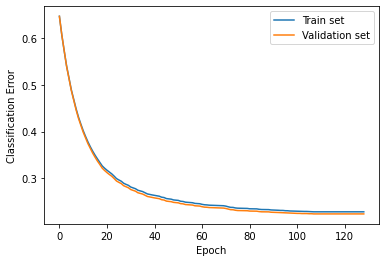

Accuracy: 89 %
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      9870
           1       0.82      0.99      0.90     10125

    accuracy                           0.89     19995
   macro avg       0.91      0.89      0.89     19995
weighted avg       0.91      0.89      0.89     19995



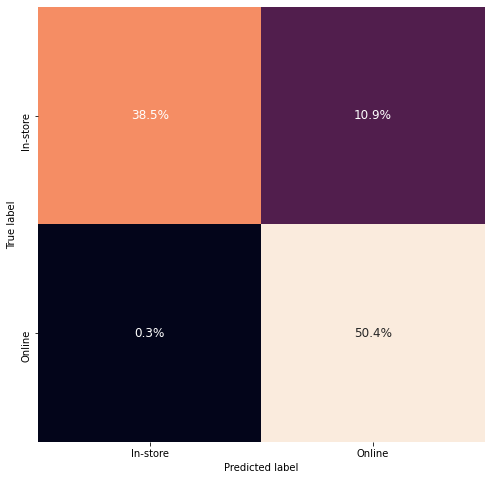

<Figure size 432x288 with 0 Axes>

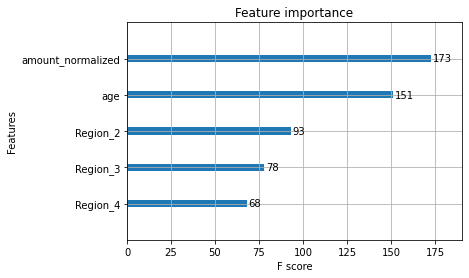

In [82]:
for i, feats in enumerate(feats_sets):
    X = data[feats]
    y = data['in-store']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
    X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=123)
    accuracy, best_model = XGBoost_fit_predict_CV(X_train, X_test, y_train, y_test)
    results_feats[i] = {'feats':feats, 'accuracy':accuracy, 'best_model':best_model}
    

In [86]:
def fit_predict_plot_GS_acc(model, X_train, X_test, y_train, y_test, xticklabels, yticklabels, params):
    clf = GridSearchCV(model, params, cv=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Accuracy:', round(accuracy_score(y_test, y_pred)*100), '%')
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm/np.sum(cm), annot=True, annot_kws={"size": 12}, fmt='.1%', cbar=False, xticklabels=xticklabels, yticklabels=yticklabels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    return round(accuracy_score(y_test, y_pred)*100), clf.best_params_

Accuracy: 89 %
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      9870
           1       0.82      1.00      0.90     10125

    accuracy                           0.89     19995
   macro avg       0.91      0.89      0.89     19995
weighted avg       0.91      0.89      0.89     19995



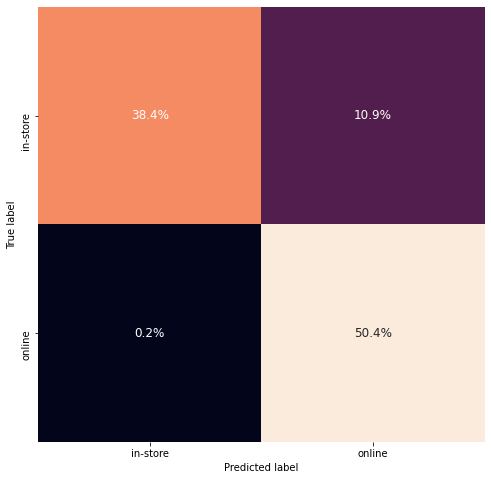

Accuracy: 88 %
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      9870
           1       0.81      1.00      0.89     10125

    accuracy                           0.88     19995
   macro avg       0.90      0.88      0.88     19995
weighted avg       0.90      0.88      0.88     19995



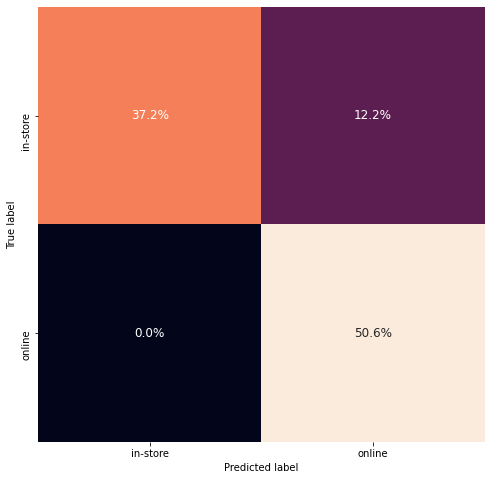

Accuracy: 87 %
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      9870
           1       0.81      0.97      0.88     10125

    accuracy                           0.87     19995
   macro avg       0.88      0.87      0.87     19995
weighted avg       0.88      0.87      0.87     19995



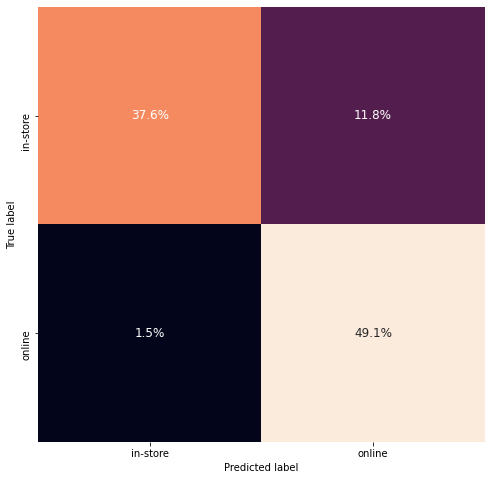

Accuracy: 88 %
              precision    recall  f1-score   support

           0       0.96      0.79      0.86      9870
           1       0.82      0.96      0.89     10125

    accuracy                           0.88     19995
   macro avg       0.89      0.88      0.88     19995
weighted avg       0.89      0.88      0.88     19995



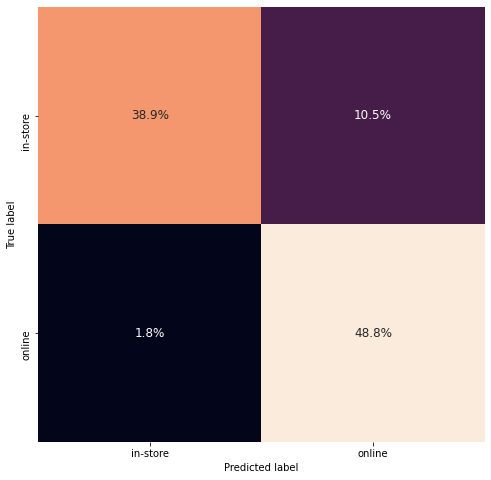

Accuracy: 89 %
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      9870
           1       0.82      0.99      0.90     10125

    accuracy                           0.89     19995
   macro avg       0.91      0.89      0.89     19995
weighted avg       0.91      0.89      0.89     19995



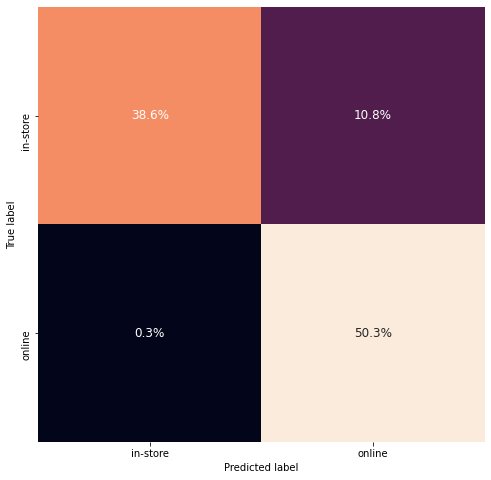

Accuracy: 88 %
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      9870
           1       0.81      1.00      0.89     10125

    accuracy                           0.88     19995
   macro avg       0.90      0.88      0.88     19995
weighted avg       0.90      0.88      0.88     19995



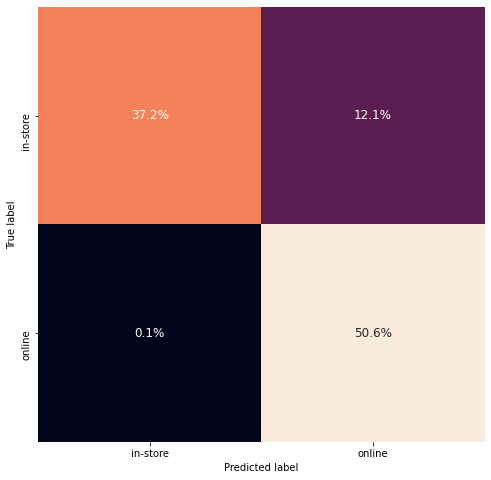

Accuracy: 87 %
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      9870
           1       0.81      0.97      0.88     10125

    accuracy                           0.87     19995
   macro avg       0.88      0.87      0.87     19995
weighted avg       0.88      0.87      0.87     19995



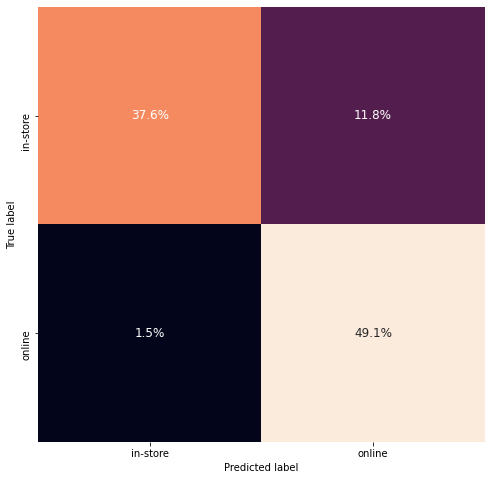

In [87]:
results_feats = {}
tree_para = {'criterion':['gini','entropy'],'max_depth':[2,3,4,5,6,7,8, 10,20]}

for i, feats in enumerate(feats_sets):
    X = data[feats]
    y = data['in-store']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
    model = DecisionTreeClassifier()
    accuracy, best_params = fit_predict_plot_GS_acc(model, X_train, X_test, y_train, y_test, labels, labels, tree_para)
    results_feats[i] = {'feats':feats, 'accuracy':accuracy, 'best_model': best_params}

Accuracy: 89 %
              precision    recall  f1-score   support

           0       1.00      0.78      0.87      9870
           1       0.82      1.00      0.90     10125

    accuracy                           0.89     19995
   macro avg       0.91      0.89      0.89     19995
weighted avg       0.91      0.89      0.89     19995



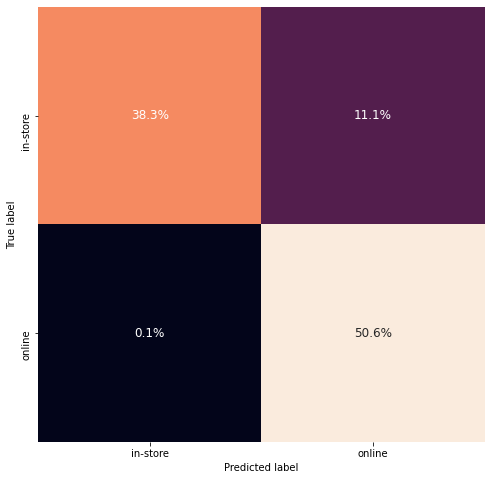

['age', 'amount_normalized', 'region']
Accuracy: 88 %
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      9870
           1       0.81      1.00      0.89     10125

    accuracy                           0.88     19995
   macro avg       0.90      0.88      0.88     19995
weighted avg       0.90      0.88      0.88     19995



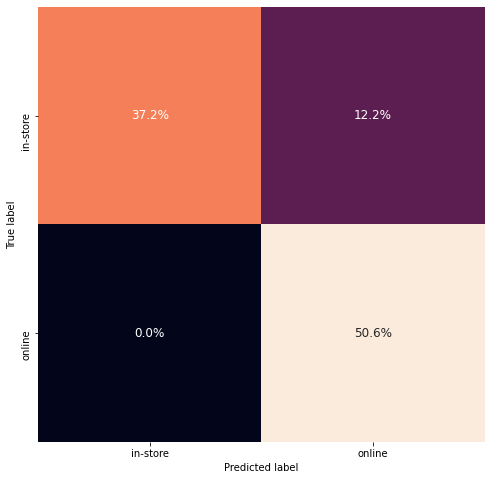

['age_levels_5_mean', 'amount', 'region']
Accuracy: 87 %
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      9870
           1       0.81      0.97      0.88     10125

    accuracy                           0.87     19995
   macro avg       0.88      0.87      0.87     19995
weighted avg       0.88      0.87      0.87     19995



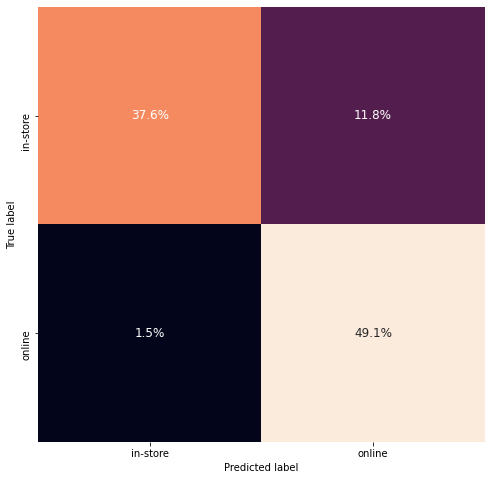

['age_levels_5_mean', 'amount_levels_5_mean', 'region']
Accuracy: 88 %
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      9870
           1       0.82      0.96      0.89     10125

    accuracy                           0.88     19995
   macro avg       0.89      0.88      0.87     19995
weighted avg       0.89      0.88      0.88     19995



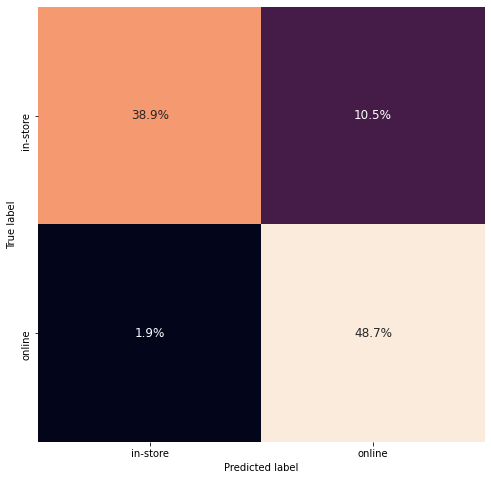

['age', 'amount_levels_5_mean', 'region']
Accuracy: 89 %
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      9870
           1       0.82      1.00      0.90     10125

    accuracy                           0.89     19995
   macro avg       0.91      0.89      0.89     19995
weighted avg       0.91      0.89      0.89     19995



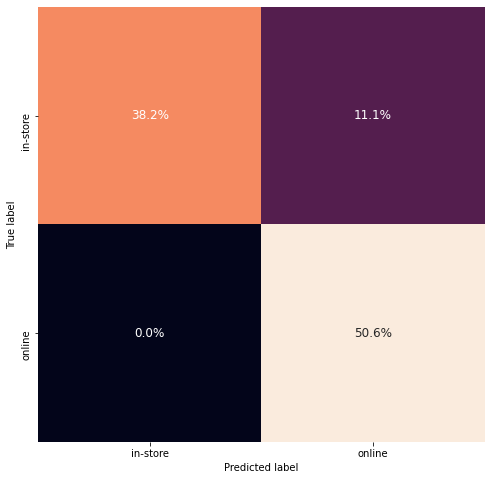

['age', 'Region_2', 'Region_3', 'Region_4', 'amount_normalized']
Accuracy: 88 %
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      9870
           1       0.81      1.00      0.89     10125

    accuracy                           0.88     19995
   macro avg       0.90      0.88      0.88     19995
weighted avg       0.90      0.88      0.88     19995



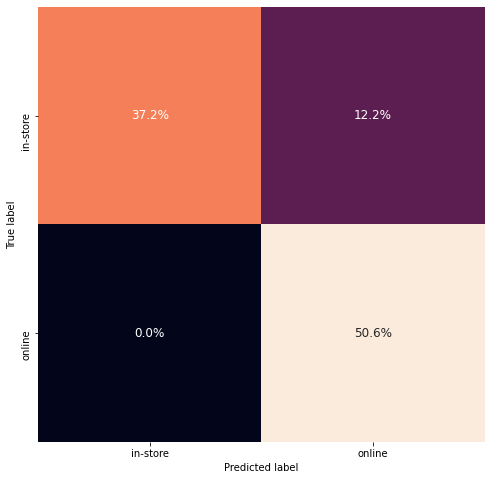

['age_levels_5_mean', 'Region_2', 'Region_3', 'Region_4', 'amount']
Accuracy: 87 %
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      9870
           1       0.81      0.97      0.88     10125

    accuracy                           0.87     19995
   macro avg       0.88      0.87      0.87     19995
weighted avg       0.88      0.87      0.87     19995



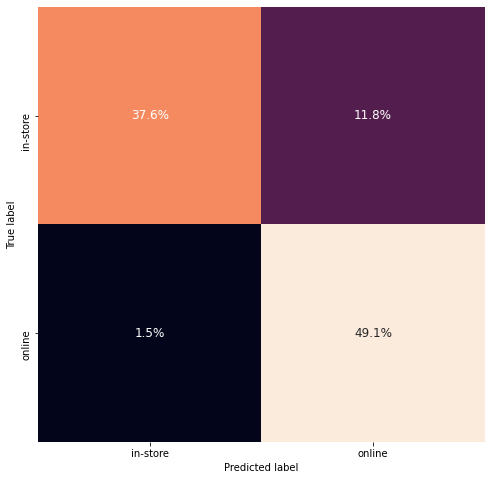

['age_levels_5_mean', 'Region_2', 'Region_3', 'Region_4', 'amount_levels_5_mean']


In [90]:
results_feats = {}
tree_para = {
 'max_depth': [3, 4, 5, 6, 9, None],
 'n_estimators': [100, 200, 400]}

for i, feats in enumerate(feats_sets):
    X = data[feats]
    y = data['in-store']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)
    model = RandomForestClassifier()
    accuracy, best_params = fit_predict_plot_GS_acc(model, X_train, X_test, y_train, y_test, labels, labels, tree_para)
    print(feats)
    results_feats[i] = {'feats':feats, 'accuracy':accuracy, 'best_model': best_params}

# Conclusions <a class="anchor" id="conclusions"></a>

### The dataset contained 21 duplicates which were removed but do not contain missing data. During the analysis of the collection, it was noticed that customers from the north only buy in-store, while customers from the south choose online shopping. Customers from other regions buy both online and in-store. There was no correlation between items and amount, but there were some relationships between other variables such as: age - in-store, region - items, region - age. Total number of items purchased online is same as total number of items purchased online, but customers spend more money during online shoping, because they choose more expensive products than in in-store shopping or it is effect of added shipping costs to amout of items. It may also be due to the higher price of products in the online store. In each age group, customers buy on average the same number of products per person, but younger peoples spend more money than older. Additional analyzes show that people older than 80 years old do not buy in-store, only people in their seventies bought more expensive products in-store than online, people from 30-60 years old spend more less the same in-store and online per one product and youngest people spend more per item online than in-store. Analyzes have shown that customers spend more online. Overall, there were large differences between regions. Both taking into account the type of purchases and the age groups of customers. Due to these differences, it would be necessary to carry out detailed analyzes for each of the regions separately. One example would be to find out why in the North and South regions customers only shop in-store or only online. This may be due to the lack of availability of another purchasing method. Another issue to be clarified could be the shipping cost included in the amount of online purchases (the question is whether it is added, how much is it, etc.), and then preparing the data without shipping costs. 

### Many experiments have been carried out with the model's hyperparameters and with the use of various features, but it did not bring any significant improvement. Also, applying the encoder to the region feature did not increase the efficiency of the model. However, this allows the variable to be treated as categorical but nominal. The conducted tests show that we are not able to correctly predict the age of the client based on demographic data. However, it is possible to predict whether the customer will buy online or in-store with an efficiency of 89%. The models show the same effectiveness on training and test data, which means that there was no overfitting phenomenon and the models can be used to predict new data. Region and amount spent are of the greatest importance in predicting this. The number of items purchased is of low importance. Variable bining has no influence on the achieved efficacy value.

 |Features | Target | Classifier | Hyperparams. | Accuracy |
 |:------|------|------|------|------|
 |Region | Age (7 bins) | DecisionTree| Default | 25% |
 |Region | Age (7 bins) | XBG | Default | 25% |
 |Region | Age (3 bins) | DecisionTree | Default | 47% |
 |Region | Age (3 bins) | XBG| Default | 47% |
 |Region,In-store, Amount, Items | Age (3 bins) | DecisionTree | Default | 43% |
 |Region,In-store, Amount, Items | Age (3 bins) | XBG | Default | 47% |
 |Age (7 bins) | In-store | DecisionTree | max_depth=4 | 59% |
 |Age (7 bins)  | In-store | XBG | Default | 59% |
 |Age, Items, Amount, Region, Age (7 bins), Amount per item, Age (3 bins) | In-store | DecisionTree | default | 84% |
 |Age, Items, Amount, Region, Age (7 bins), Amount per item, Age (3 bins)  | In-store | XBG | Default | 88% |
 |Age, Amount, Region | In-store | DecisionTree | Default | 84% |
 |Age, Amount, Region | In-store | DecisionTree | criterion=gini, max_depth=8| 84% |
 |Age, Amount, Region | In-store | XBG | Default | 89% |
 |Age, Amount, Region | In-store | RandomForest | Default | 85% |
 |Age, Amount normalized, Region | In-store | DecisionTree | criterion=entropy, max_depth=10| 89% |
 |Age (3 bins), Amount (5 bins), Region (One hot encoded) | In-store | DecisionTree | criterion=gini, max_depth=8| 89% |
 |Age, Amount normalized, Region | In-store | XGB | n_estimators=300, booster='gbtree', max_depth=5| 89% |
 |Age (3 bins), Amount (5 bins), Region (One hot encoded) | In-store | XGB | n_estimators=300, booster='gbtree', max_depth=3 | 89% |
 |Age (5 bins), Amount, Region | In-store | RandomForest |n_estimators=200, max_depth=5  | 87% |
 |Age (5 bins), Amount, Region (One hot encoded)| In-store | RandomForest |n_estimators=400, max_depth=3 | 88% |